In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import datetime
import pickle
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, probplot
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from arch.unitroot import VarianceRatio
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller 
from scipy.stats import genpareto
from sklearn.utils import resample
from scipy.optimize import minimize
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.optimize import minimize
from scipy.stats import genpareto
from scipy.optimize import differential_evolution
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from scipy.optimize import differential_evolution
from scipy.stats import gumbel_r
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import Data

In [3]:
btc = pd.read_csv(r'/Users/xiaoyuxu/Desktop/Dissertation-docts/bitcoin_2017_to_2023.csv').iloc[::-1]
btc.set_index(btc.columns[0], inplace=True)
btc = btc[~btc.index.duplicated(keep='first')]
btc_min_return = btc[['close','volume']].copy()
btc_min_return['return'] = np.log(btc_min_return['close'] / btc_min_return['close'].shift(1))
btc_min_return = btc_min_return.loc['2017-01-01':'2023-12-31', ['close','return','volume']]
btc_min_return['rolling_volatility']=btc_min_return['return'].rolling(window=60*24*5).std()

btc_min_return.index = pd.to_datetime(btc_min_return.index)
btc_day_return = btc_min_return.resample('D').last()
btc_day_return.index = btc_day_return.index.date

In [4]:
btc_min_return

,close,return,volume,rolling_volatility
timestamp,,,,
2017-08-17 04:00:00,4261.48,NaN,1.775183,NaN
2017-08-17 04:01:00,4261.48,0.000000,0.000000,NaN
2017-08-17 04:02:00,4280.56,0.004467,0.261074,NaN
2017-08-17 04:03:00,4261.48,-0.004467,0.012008,NaN
2017-08-17 04:04:00,4261.48,0.000000,0.140796,NaN
...,...,...,...,...
2023-08-01 13:15:00,28907.41,0.000395,37.746570,0.000269
2023-08-01 13:16:00,28908.53,0.000039,15.896100,0.000269
2023-08-01 13:17:00,28902.49,-0.000209,11.522630,0.000269


### Lee & Mykland Jump Test

- How often do jumps occur? Can they be related to important events?

- How accurate are the jump detection methods compared to traditional stocks?

- When do jumps occur? Are there any intra-day, weekly seasonality patterns?

- How are jump sizes distributed? Do big or small jumps dominate?

- Do intra-day jumps have a significant effect on end of day returns? Is there a difference between positive and negative jumps?

**Model Description of Lee & Mykland jump test**

Let $X_t \subset \mathbb{R}$ be the return i.e. log price at all times (since CCs trade 24 hourse a day). Then define the model:

$d X_t = \sigma d W_t + Z_t d J_t \quad \text{with} \quad t \in [0, T]$;

where $J_t \in \{0,1\}$ is the jump arrival indicator with jumps of size $Z_t \subset \mathbb{R}$.

Let the observed, with market micro-structure noise $\epsilon$ contamined price at time $t$ be:

$\tilde{P}_t = X_t + \epsilon_t \quad \text{with} \quad \mathbb{E}[\epsilon_t] = 0 \quad Var(\epsilon_t) = q^2$. And let $k$ be obtained via the empirical autocorrelation function lag order of the observed price. Then we compute the average price over the block size $M$:

$\hat{P}(t_j) = \frac{1}{M} \sum_{i=\lfloor j/k \rfloor}^{\lfloor j/k \rfloor + M - 1} \tilde{P}(t_{i k}) \quad \text{with} \quad j = k M, 2 k M, 3 k M, \cdots$.

Then:

$\overline{P}(t_j) = \hat{P}(t_{j + k M}) - \hat{P}(t_j)$;

is used to determine whether a jump has happened between $t_j$ and $t_{j + k M}$ s.t. the test statistic converges in distribution to:

$B_n^{- 1} (\frac{\sqrt{M}}{\sqrt{V_n}} |\overline{P}(t_j)| - A_n ) \rightarrow \xi$;

where

$A_n = \sqrt{2 \log \lfloor \frac{n}{k M} \rfloor}^{1/2} - \frac{\log \pi + \log \log \lfloor \frac{n}{k M} \rfloor}{2 \sqrt{2 \log \lfloor \frac{n}{k M} \rfloor}} \quad B_n = \frac{1}{\sqrt{2 \log \lfloor \frac{n}{k M} \rfloor}} \quad V_n = Var(\sqrt{M} \overline{P}(t_j))$.

We say that if $\hat{\xi}$ greater than $99$ percentile of the standard Gumbel distribution, we conclude that we observe a jump.

In [6]:
# Function to estimate volatility using rolling window standard deviation
def estimate_volatility(data, window_size):
    return data['return'].rolling(window=window_size).std()

# Function to compute observed price including market microstructure noise
def compute_observed_price(data, volatility):
    return data['return'] + np.random.normal(0, volatility)

def compute_block_average(data, M):
    # Compute block averages
    block_averages = []
    n_blocks = len(data) // M
    
    for j in range(n_blocks):
        # Calculate block average P_hat(t_j)
        P_hat_j = data.iloc[j * M : (j + 1) * M]['observed_price'].mean()
        block_averages.append(P_hat_j)
    
    return block_averages

def lee_mykland_jump_test(data, M, k, threshold):
    # Estimate volatility
    volatility = estimate_volatility(data, window_size)
    
    # Compute observed prices
    data['observed_price'] = compute_observed_price(data, volatility)
    
    # Compute block averages
    block_averages = compute_block_average(data, M)
    
    jump_flags = []
    jump_sizes = []
    test_statistic_values = []
    
    # Iterate over blocks
    for j in range(len(block_averages) - 1):
        P_bar_j = block_averages[j]
        P_bar_j_next = block_averages[j + 1]
        
        # Calculate test statistic (difference in block averages)
        P_bar_diff = P_bar_j_next - P_bar_j
        
        # Skip calculation if P_bar_diff is NaN or zero
        if pd.isna(P_bar_diff) or P_bar_diff == 0:
            continue
        
        test_statistic = np.abs(P_bar_diff)
        test_statistic_values.append(test_statistic)
        
        # Perform jump detection based on threshold
        if test_statistic > threshold:
            jump_flags.append(data.index[j * M])  # Store timestamp of detected jump
            
            # Calculate jump size as described
            if j * M + M < len(data):
                jump_size = data.at[data.index[j * M + M], 'observed_price'] - data.at[data.index[j * M], 'observed_price']
                jump_sizes.append(jump_size)
            else:
                jump_sizes.append(0)  # Handle edge case where index is out of bounds
    
    # Compute p-value based on the distribution of test statistics (Gumbel distribution)
    if len(test_statistic_values) > 0:
        p_value = np.mean(np.array(test_statistic_values) > threshold)
    else:
        p_value = 1.0  # Assign a high p-value if no valid test statistics
    
    # Compute average test statistic for detected jumps
    avg_test_statistic = np.mean(test_statistic_values) if test_statistic_values else 0
    
    # Compute volatility of detected jumps
    jump_volatility = estimate_volatility(data.loc[jump_flags], window_size).mean() if jump_flags else 0
    
    return jump_flags, jump_sizes, p_value, avg_test_statistic, jump_volatility

In [11]:
# Define a range of values for M (block size) and k (lag order)
block_sizes = [1,2,3,4, 5]  
lag_orders = [1,2,3,4,5]  

# Parameters for volatility estimation and jump test
window_size = 15   # Rolling window size for volatility estimation
threshold = 0.01   # Threshold for jump detection

# Perform grid search over M and k values
best_params = None
best_p_value = 1.0  # Start with high p-value (least significant)
results = []

for M in block_sizes:
    for k in lag_orders:
        print(M,k)
        jump_flags, jump_sizes, p_value, avg_test_statistic, jump_volatility = lee_mykland_jump_test(btc_min_return, M, k, threshold)
        
        # Print or store results for each parameter combination
        results.append((M, k, len(jump_flags), p_value, avg_test_statistic, jump_volatility))
        
        # Track the best parameters based on statistical significance (lowest p-value)
        if p_value < best_p_value:
            best_p_value = p_value
            best_params = (M, k)
            best_detected_jumps = len(jump_flags)


# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['M', 'k', 'Detected Jumps', 'p-value', 'Avg Test Statistic', 'Jump Volatility'])
results_df

1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5


,M,k,Detected Jumps,p-value,Avg Test Statistic,Jump Volatility
0,1,1,32179,0.010305,0.001472,0.006329
1,1,2,32202,0.010312,0.001470,0.006341
2,1,3,32167,0.010301,0.001470,0.006327
3,1,4,32336,0.010355,0.001470,0.006325
4,1,5,32177,0.010304,0.001471,0.006327
5,2,1,5837,0.003738,0.001035,0.007522
6,2,2,5926,0.003795,0.001038,0.007641
7,2,3,5903,0.003780,0.001035,0.007602
8,2,4,5841,0.003741,0.001036,0.007629
9,2,5,5923,0.003793,0.001037,0.007531


### Visualization Plots

In [30]:
selected_params = [(1, 3), (2, 3), (3, 3), (4, 3), (5, 3),(1,1),(2,1),(3,1),(4,1),(5,1)]

for M, k in selected_params:
    btc_min_return[f'jump_detected_{M}_{k}'] = 0
    btc_min_return[f'jump_size_{M}_{k}'] = 0.0

# Iterate through each parameter set and perform jump test
for M, k in selected_params:
    print((M,k))
    detected_jumps, jump_sizes, p_value, avg_test_statistic, jump_volatility = lee_mykland_jump_test(btc_min_return, M, k, threshold)
    
    # Update the DataFrame with detected jumps and their sizes
    for timestamp, jump_size in zip(detected_jumps, jump_sizes):
        if not pd.isna(timestamp) and timestamp in btc_min_return.index:
            btc_min_return.loc[timestamp, f'jump_detected_{M}_{k}'] = 1
            btc_min_return.loc[timestamp, f'jump_size_{M}_{k}'] = jump_size

(1, 3)
(2, 3)
(3, 3)
(4, 3)
(5, 3)
(1, 1)
(2, 1)
(3, 1)
(4, 1)
(5, 1)


In [31]:
results = []
for M, k in selected_params:
    detected_jumps, jump_sizes, p_value, avg_test_statistic, jump_volatility = lee_mykland_jump_test(btc_min_return, M, k, threshold)
    
    # Calculate the percentage of jumps detected
    total_data_points = len(btc_min_return)
    num_detected_jumps = len(detected_jumps)
    percentage_jumps_detected = (num_detected_jumps / total_data_points) * 100
    
    # Append results to the list
    results.append((f'({M}, {k})', percentage_jumps_detected, num_detected_jumps, p_value, jump_volatility))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Parameters', 'Percentage of Jumps Detected', 'Total Detected Jumps', 'p-value', 'Jump Volatility'])
results_df.set_index('Parameters', inplace=True)

In [32]:
results_df

,Percentage of Jumps Detected,Total Detected Jumps,p-value,Jump Volatility
Parameters,,,,
"(1, 3)",0.824250,25475,0.008246,0.006704
"(2, 3)",0.136475,4218,0.002731,0.008314
"(3, 3)",0.044197,1366,0.001327,NaN
"(4, 3)",0.019187,593,0.000768,NaN
"(5, 3)",0.009157,283,0.000458,NaN
"(1, 1)",0.827745,25583,0.008281,0.006703
"(2, 1)",0.136151,4208,0.002724,0.008158
"(3, 1)",0.042968,1328,0.001290,NaN
"(4, 1)",0.017795,550,0.000712,NaN


#### ACF Plot

<Figure size 864x432 with 0 Axes>

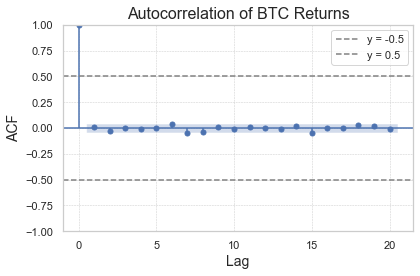

In [16]:
sns.set(style="whitegrid")
def plot_custom_acf(data, title, y1=-0.5, y2=0.5):
    plt.figure(figsize=(12, 6))
    plot_acf(data, lags=20)
    plt.axhline(y=y1, color='gray', linestyle='--', linewidth=1.5, label=f'y = {y1}')
    plt.axhline(y=y2, color='gray', linestyle='--', linewidth=1.5, label=f'y = {y2}')
    plt.title(title, fontsize=16)
    plt.xlabel('Lag', fontsize=14)
    plt.ylabel('ACF', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_custom_acf(btc_day_return['return'].dropna(), 'Autocorrelation of BTC Returns')

#### Number of jumps detected per day

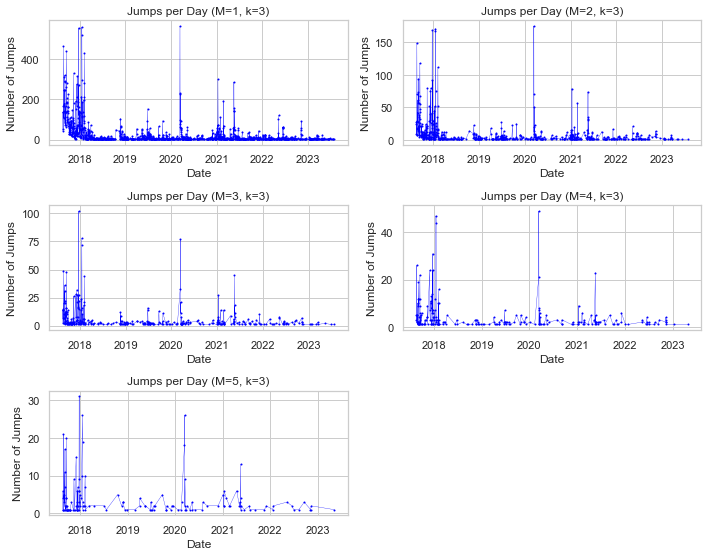

In [17]:
plt.figure(figsize=(10, 10))

for i, (M, k) in enumerate(selected_params):
    # Extract jump detection flags for the current parameters
    jump_detected_col = f'jump_detected_{M}_{k}'
    
    # Get the dates where jumps were detected
    jump_dates = btc_min_return[btc_min_return[jump_detected_col] == 1].index.date
    jumps_per_day = pd.Series(jump_dates).value_counts().sort_index()
    
    # Plotting
    plt.subplot(4, 2, i + 1)
    plt.plot(jumps_per_day.index, jumps_per_day.values, marker='o', linestyle='-', color='blue', markersize=1, linewidth=0.3)
    plt.title(f'Jumps per Day (M={M}, k={k})')
    plt.xlabel('Date')
    plt.ylabel('Number of Jumps')
    plt.grid(True)

plt.tight_layout()
plt.show()

#### Number of jumps aggregated per hour/day/ week/ month/ year

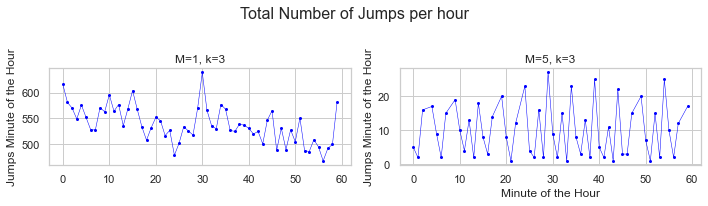

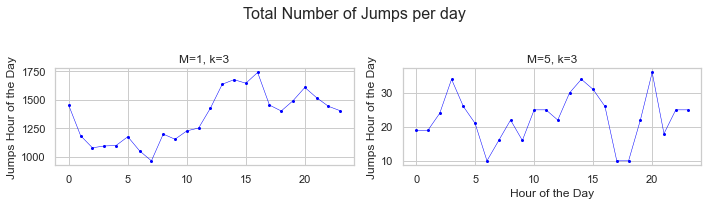

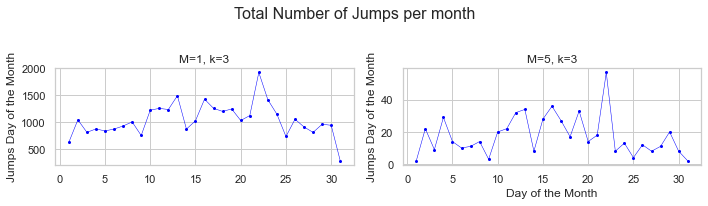

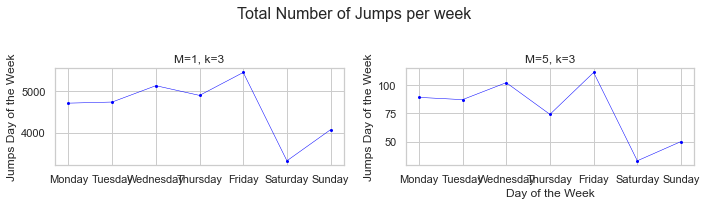

In [18]:
# Function to aggregate jumps per specific period
def aggregate_jumps(jump_dates, period):
    jump_dates_series = pd.Series(jump_dates)
    if period == 'minute':
        return jump_dates_series.dt.minute.value_counts().sort_index()
    elif period == 'hour':
        return jump_dates_series.dt.hour.value_counts().sort_index()
    elif period == 'day':
        return jump_dates_series.dt.day.value_counts().sort_index()
    elif period == 'month':
        return jump_dates_series.dt.month.value_counts().sort_index()
    elif period == 'week':
        return jump_dates_series.dt.dayofweek.value_counts().sort_index()

# Define the periods and labels for aggregation
periods = ['minute', 'hour', 'day', 'week']
period_labels = ['Minute of the Hour', 'Hour of the Day', 'Day of the Month', 'Day of the Week']
aggregation_labels = ['per hour', 'per day', 'per month', 'per week']

# Plotting function
def plot_aggregated_jumps(btc_min_return, selected_params, periods, period_labels, aggregation_labels):
    for period, label, agg_label in zip(periods, period_labels, aggregation_labels):
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        fig.suptitle(f'Total Number of Jumps {agg_label}', fontsize=16)
        
        for idx, (M, k) in enumerate(selected_params):
            jump_detected_col = f'jump_detected_{M}_{k}'
            jump_dates = btc_min_return[btc_min_return[jump_detected_col] == 1].index
            
            # Aggregate jumps per specified period
            jumps_aggregated = aggregate_jumps(jump_dates, period)
            
            # For 'per week' aggregation, adjust x-axis to day of the week
            if period == 'week':
                days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                jumps_aggregated.index = days_of_week
                
            # Plot the aggregated jumps on the respective subplot
            axs[idx].plot(jumps_aggregated.index, jumps_aggregated.values, marker='o', linestyle='-', color='blue', markersize=2, linewidth=0.5)
            axs[idx].set_title(f'M={M}, k={k}')
            axs[idx].set_ylabel(f'Jumps {label}')
            axs[idx].grid(True)
        
        axs[idx].set_xlabel(label)  # Set x-axis label for the last subplot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Run the plotting function with selected_params
selected_params = [(1, 3), (5, 3)]
plot_aggregated_jumps(btc_min_return, selected_params, periods, period_labels, aggregation_labels)

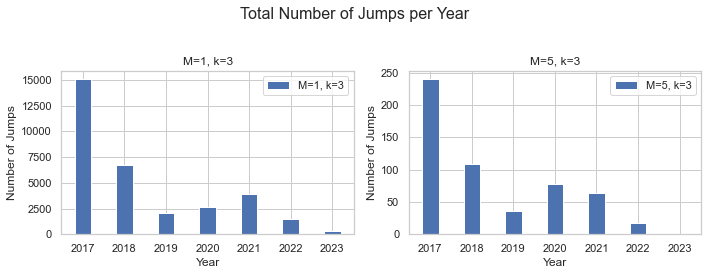

In [19]:
selected_params = [(1, 3),(5, 3)]
# Function to aggregate jumps per year
def aggregate_jumps_by_year(jump_dates):
    jump_dates_series = pd.Series(jump_dates)
    return jump_dates_series.dt.year.value_counts().sort_index()

# Plotting function for aggregated jumps per year
def plot_aggregated_jumps_by_year(btc_min_return, selected_params):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)
    fig.suptitle('Total Number of Jumps per Year', fontsize=16)
    
    for idx, (M, k) in enumerate(selected_params):
        jump_detected_col = f'jump_detected_{M}_{k}'
        jump_dates = btc_min_return[btc_min_return[jump_detected_col] == 1].index
        
        # Aggregate jumps per year
        jumps_aggregated = aggregate_jumps_by_year(jump_dates)
        
        # Plot the aggregated jumps on the bar plot
        ax = axs[idx]
        ax.bar(jumps_aggregated.index, jumps_aggregated.values, width=0.4, label=f'M={M}, k={k}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Jumps')
        ax.set_title(f'M={M}, k={k}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the plotting function
plot_aggregated_jumps_by_year(btc_min_return, selected_params)

#### Plot of aggregated trading volumes

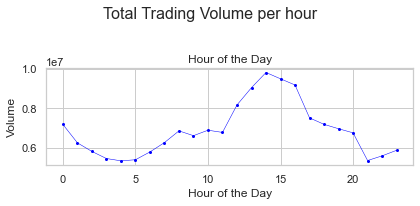

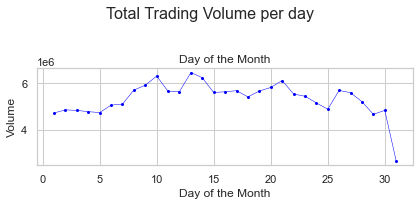

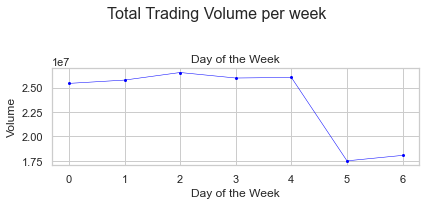

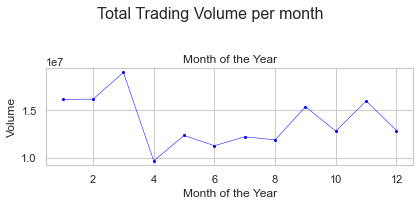

In [20]:
# Function to aggregate volume per specific period
def aggregate_volume(volume_data, period):
    if period == 'minute':
        return volume_data.groupby(volume_data.index.minute).sum()
    elif period == 'hour':
        return volume_data.groupby(volume_data.index.hour).sum()
    elif period == 'day':
        return volume_data.groupby(volume_data.index.day).sum()
    elif period == 'week':
        return volume_data.groupby(volume_data.index.weekday).sum()
    elif period == 'month':
        return volume_data.groupby(volume_data.index.month).sum()

# Define the periods and labels for aggregation
periods = ['hour', 'day', 'week', 'month']
period_labels = ['Hour of the Day', 'Day of the Month', 'Day of the Week', 'Month of the Year']
aggregation_labels = ['per hour', 'per day', 'per week', 'per month']

# Plotting function
def plot_aggregated_volume(btc_min_return, periods, period_labels, aggregation_labels):
    for period, label, agg_label in zip(periods, period_labels, aggregation_labels):
        fig, ax = plt.subplots(figsize=(6, 3))
        fig.suptitle(f'Total Trading Volume {agg_label}', fontsize=16)
        
        # Aggregate volume per specified period
        volume_aggregated = aggregate_volume(btc_min_return['volume'], period)
        
        # Plot the aggregated volume
        ax.plot(volume_aggregated.index, volume_aggregated.values, marker='o', linestyle='-', color='blue', markersize=2, linewidth=0.5)
        ax.set_title(f'{label}')
        ax.set_ylabel(f'Volume')
        ax.grid(True)
        
        # Set x-axis label
        ax.set_xlabel(label)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Run the plotting function with periods and labels
plot_aggregated_volume(btc_min_return, periods, period_labels, aggregation_labels)

#### Histogram of jump sizes

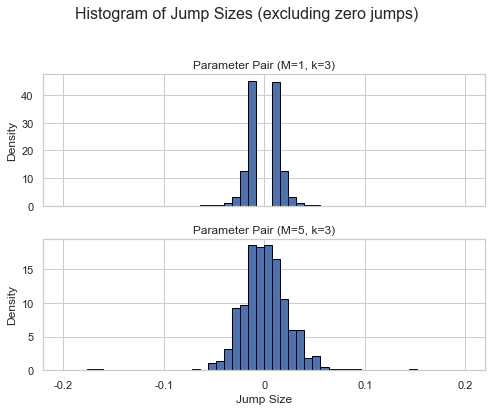

In [21]:
# Function to plot histograms of jump sizes for specific parameter pairs
def plot_jump_size_histograms(btc_min_return, selected_params):
    fig, axs = plt.subplots(len(selected_params), 1, figsize=(7, 6), sharex=True)
    fig.suptitle('Histogram of Jump Sizes (excluding zero jumps)', fontsize=16)
    
    for idx, (M, k) in enumerate(selected_params):
        jump_size_col = f'jump_size_{M}_{k}'
        jump_sizes = btc_min_return[jump_size_col][btc_min_return[jump_size_col] != 0].dropna()
        
        # Plot histogram with adjusted parameters
        axs[idx].hist(jump_sizes, bins=50, edgecolor='black', density=True, range=(-0.2, 0.2))
        axs[idx].set_title(f'Parameter Pair (M={M}, k={k})')
        axs[idx].set_ylabel('Density')
        axs[idx].grid(True)
        
        # Apply logarithmic scale for better visualization
        axs[idx].set_xscale('symlog')
        
        # Set x-axis ticks and labels
        axs[idx].set_xticks(np.arange(-0.2, 0.3, 0.1))
        axs[idx].set_xticklabels(['-0.2', '-0.1', '0', '0.1', '0.2'])
        
    axs[idx].set_xlabel('Jump Size')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Selected parameter pairs (1, 3) and (5, 3)
selected_params = [(1, 3), (5, 3)]

# Plot histograms for selected parameter pairs
plot_jump_size_histograms(btc_min_return, selected_params)

In [22]:
# Function to calculate statistical summary of jump sizes
def jump_size_summary(btc_min_return, selected_params):
    summaries = []
    for M, k in selected_params:
        jump_size_col = f'jump_size_{M}_{k}'
        jump_sizes = btc_min_return[jump_size_col][btc_min_return[jump_size_col] != 0].dropna()
        
        summary = {
            'Parameter Pair': f'(M={M}, k={k})',
            'Mean': jump_sizes.mean(),
            'Std Dev': jump_sizes.std(),
            'Median': jump_sizes.median(),
            'Min': jump_sizes.min(),
            'Max': jump_sizes.max(),
            '25th Percentile (Q1)': jump_sizes.quantile(0.25),
            '75th Percentile (Q3)': jump_sizes.quantile(0.75),
            'Interquartile Range (IQR)': jump_sizes.quantile(0.75) - jump_sizes.quantile(0.25),
            'Number of Jumps': jump_sizes.size
        }
        summaries.append(summary)
    
    return pd.DataFrame(summaries)

# Get statistical summary
summary = jump_size_summary(btc_min_return, selected_params)
summary

,Parameter Pair,Mean,Std Dev,Median,Min,Max,25th Percentile (Q1),75th Percentile (Q3),Interquartile Range (IQR),Number of Jumps
0,"(M=1, k=3)",-0.000023,0.016972,-0.010011,-0.153063,0.198722,-0.013090,0.012995,0.026085,32340
1,"(M=5, k=3)",0.000922,0.025023,0.000576,-0.168006,0.149677,-0.013744,0.014778,0.028523,546


### HAR-EVT model

- The HAR-EVT model is designed to capture the dynamics of financial returns using high-frequency data, while also incorporating Extreme Value Theory (EVT) to model tail risks associated with extreme market events.

**Mathematical Formulation**

$1)$ Return Process

The return process $(Y_t)_t$ is defined as:

$Y_t = \sigma_t Z_t$;

s.t. $\sigma_t = \exp{\{\beta^T R_{M, t-1}\}}$ and $Z_t \sim \mathcal{N}(0,1)$.

$2)$ Conditional Volatility Modeling

$\sigma_t^2 = \exp{\{\mathbb{E}[\log R V_t | \mathcal{F}_{t-1}]\}}$;

s.t.  $R V_t$ is the realized variance and $R_{M, t-1}$ is the vector of lagged realized measures: $\log{R V_t}$, $\log{R V_{t-w}}$, $\log{R V_{t-m}}$ and $\log{1+\hat{J}_{t-1}}$.

$3)$ Model dynamics

$R V_t$ is modeled using a HAR-J (High-Frequency-Autoregressive-Jump) specification:

$\log R V_t = \beta_0 + \beta_d \log{R V_{t-d}} + \beta_w \log{R V_{t-w}} + \beta_m \log{R V_{t-m}}+ \beta_J \log{1+\hat{J}_{t-1}}+\epsilon_t$;

with $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon^2)$ and $\hat{J}_t$ being the estimator of the jump component under quadratic variation.

$4)$ Extreme Value Theory (EVT)

After fitting the HAR-EVT model, the tail risk is estimated using EVT. Standardized residuals $Z_t$ are modeled with the Generalized Pareto Distribution (GPD) above a threshold $u$:

$\mathbb{P}(- Z \geq u) = \phi$;

where $\phi$ is the exceedance probability and $-Z$ is the negative standardized residuals. 

$5)$ VaR

VaR is computed using the estimated parameters from the GPD:

$VaR_{\alpha, t| t-1}(Y) = \begin{cases} \sigma_t u + \frac{\sigma_t \beta}{\xi} [(\frac{1}{\alpha})-1] \quad &\xi \ne 0\\ u + \sigma_t \log \frac{1}{\alpha} \quad &\xi = 0
\end{cases}$;

where $(\xi, \beta)$ are the parameters of the GPD and $u$ is the threshold above which extreme events are considered. 

$6)$ Bootstrap Re-sampling for inference

Due to the complexity and two-step nature of fitting the HAR-EVT model, bootstrap resampling is used to obtain confidence intervals for the tail risk parameters:

Block resampling of residuals $\{\hat{z}_t\}_{t-1}^n$; Resample 
$B$ times to obtain $B$ sets of estimates for VaR and tail parameters; Compute empirical confidence intervals from the bootstrap samples.

In [12]:
btc_min_return['sqr_return'] = btc_min_return['return']**2
btc_min_return['RV_d'] = btc_min_return['sqr_return'].rolling(window=24*60).sum()
u_n = np.percentile(np.abs(btc_min_return['return']), 99)
btc_min_return['TRV'] = btc_min_return['return'].apply(lambda x: x**2 if np.abs(x) > u_n else 0).rolling(window=24*60).sum()
btc_min_return['J'] = btc_min_return['RV_d'] - btc_min_return['TRV']
btc_min_return['log1+J'] = np.log(1 + btc_min_return['J'])
btc_min_return['logRV_d'] = np.log(btc_min_return['RV_d'])
btc_min_return['logRV_w'] = np.log(btc_min_return['sqr_return'].rolling(window=24*60*5).sum())
btc_min_return['logRV_m'] = np.log(btc_min_return['sqr_return'].rolling(window=24*60*22).sum())

btc_min_return = btc_min_return.dropna()

In [13]:
warnings.simplefilter(action='ignore', category=Warning)

X = btc_min_return[['logRV_w', 'logRV_m', 'logRV_d', 'log1+J']]
X = sm.add_constant(X)
y = btc_min_return['logRV_d'].shift(-60)

# Fit the model
model = sm.OLS(y[:-60], X[:-60]).fit()

# Get the fitted values and calculate sigma2_hat
btc_min_return.loc[~y.index.isna(), 'sigma2_hat'] = np.exp(model.fittedvalues)

# Shift sigma2_hat and calculate Z_hat
btc_min_return['sigma2_hat'] = btc_min_return['sigma2_hat'].shift(60)
btc_min_return['Z_hat'] = btc_min_return['return'] / np.sqrt(btc_min_return['sigma2_hat'])
btc_min_return = btc_min_return.dropna()
btc_min_return

,close,return,volume,rolling_volatility,jump_detected_1_3,jump_size_1_3,jump_detected_2_3,jump_size_2_3,jump_detected_3_3,jump_size_3_3,...,sqr_return,RV_d,TRV,J,log1+J,logRV_d,logRV_w,logRV_m,sigma2_hat,Z_hat
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-08 11:59:00,4647.53,0.000000,0.000000,0.003990,0,0.0,0,0.0,0,0.0,...,0.000000e+00,0.008380,0.0,0.008380,0.008345,-4.781888,-2.166069,-0.874144,0.008693,0.000000
2017-09-08 12:00:00,4647.53,0.000000,0.000000,0.003990,0,0.0,0,0.0,0,0.0,...,0.000000e+00,0.008379,0.0,0.008379,0.008344,-4.782071,-2.166069,-0.874144,0.008687,0.000000
2017-09-08 12:01:00,4647.53,0.000000,0.000000,0.003990,0,0.0,0,0.0,0,0.0,...,0.000000e+00,0.008377,0.0,0.008377,0.008342,-4.782253,-2.166069,-0.874144,0.008689,0.000000
2017-09-08 12:02:00,4653.92,0.001374,0.009367,0.003990,0,0.0,0,0.0,0,0.0,...,1.887820e-06,0.008365,0.0,0.008365,0.008330,-4.783683,-2.166167,-0.874140,0.008686,0.014743
2017-09-08 12:03:00,4655.00,0.000232,0.023941,0.003990,0,0.0,0,0.0,0,0.0,...,5.384048e-08,0.008365,0.0,0.008365,0.008330,-4.783676,-2.166385,-0.874142,0.008657,0.002494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01 13:15:00,28907.41,0.000395,37.746570,0.000269,0,0.0,0,0.0,0,0.0,...,1.561297e-07,0.000215,0.0,0.000215,0.000215,-8.446455,-7.560694,-5.297975,0.000212,0.027109
2023-08-01 13:16:00,28908.53,0.000039,15.896100,0.000269,0,0.0,0,0.0,0,0.0,...,1.501070e-09,0.000215,0.0,0.000215,0.000215,-8.446448,-7.560701,-5.297977,0.000212,0.002658
2023-08-01 13:17:00,28902.49,-0.000209,11.522630,0.000269,0,0.0,0,0.0,0,0.0,...,4.366290e-08,0.000215,0.0,0.000215,0.000215,-8.446330,-7.560648,-5.297969,0.000212,-0.014337


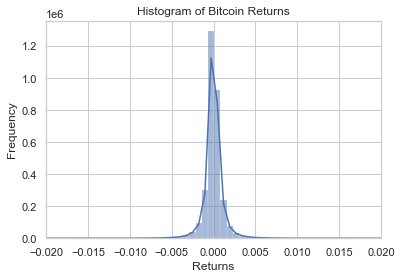

In [240]:
# Plotting the histogram
plt.figure(figsize=(6, 4))
sns.histplot(btc_min_return['return'], bins=200, kde=True)
plt.title('Histogram of Bitcoin Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.xlim([-0.02, 0.02]) 
plt.grid(True)
plt.show()

GPD parameters: xi=0.5877982335934608, beta=0.013831500836961635
Number of violations: 849670
Violation rate (expected 5% for 95% VaR): 0.2747795412180631


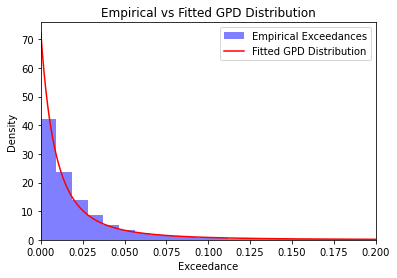

In [14]:
# Fit GPD to the right tail of positive standardized residuals
threshold_general = np.percentile(-btc_min_return['Z_hat'], 95)
btc_min_return['exceedances_left_general'] =- btc_min_return['Z_hat'][btc_min_return['Z_hat'] < -threshold_general] - threshold_general
xi, loc, beta=genpareto.fit(btc_min_return['exceedances_left_general'].dropna())
print(f"GPD parameters: xi={xi}, beta={beta}")

# Calculate VaR using the fitted GPD parameters
def compute_var(alpha, sigma, u, xi, beta):
    if xi != 0:
        VaR = u + (beta / xi) * ((1/alpha) ** xi - 1)
    else:
        VaR = u + beta * np.log(1 / alpha)
    return sigma * VaR

btc_min_return['VaR_left_general'] = btc_min_return.apply(lambda row: compute_var(0.95, np.sqrt(row['sigma2_hat']), threshold, xi, beta), axis=1)


btc_min_return['exceeds_VaR_left_general'] = -btc_min_return['return'] > btc_min_return['VaR_left_general']
num_violations = btc_min_return['exceeds_VaR_left_general'].sum()
total_obs = len(btc_min_return)
violation_rate = num_violations / total_obs

print(f"Number of violations: {num_violations}")
print(f"Violation rate (expected 5% for 95% VaR): {violation_rate}")

# Plot empirical exceedances
quantiles = np.linspace(0.0, 0.99, 1000)
theoretical_quantiles = genpareto.ppf(quantiles, xi, loc=0, scale=beta)
plt.hist(btc_min_return['exceedances_left_general'].dropna(), bins=200, density=True, alpha=0.5, color='blue', label='Empirical Exceedances')

# Plot fitted GPD distribution
plt.plot(theoretical_quantiles, genpareto.pdf(theoretical_quantiles, xi, loc=0, scale=beta),
         color='red', label='Fitted GPD Distribution')

# Add labels and title
plt.xlim(0.0, 0.2)
plt.xlabel('Exceedance')
plt.ylabel('Density')
plt.title('Empirical vs Fitted GPD Distribution')
plt.legend()

# Show plot
plt.show()

GPD parameters: xi=0.591263071921005, beta=0.014258673270372214
Number of violations: 148358
Violation rate (expected 5% for 95% VaR): 0.04797832473316629


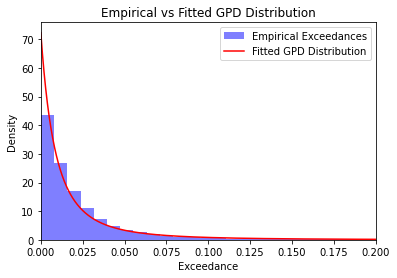

In [16]:
# Fit GPD to the right tail of positive standardized residuals
threshold_right_general = np.percentile(btc_min_return['Z_hat'], 95)
btc_min_return['exceedances_right_general'] =btc_min_return['Z_hat'][btc_min_return['Z_hat'] > threshold_right_general] - threshold_right_general
xi_right, loc_right, beta_right=genpareto.fit(btc_min_return['exceedances_right_general'].dropna())
print(f"GPD parameters: xi={xi_right}, beta={beta_right}")

# Calculate VaR using the fitted GPD parameters
def compute_var(alpha, sigma, u, xi, beta):
    if xi != 0:
        VaR = u + (beta / xi) * ((1/alpha) ** xi - 1)
    else:
        VaR = u + beta * np.log(1 / alpha)
    return sigma * VaR

btc_min_return['VaR_right_general'] = btc_min_return.apply(lambda row: compute_var(0.95, np.sqrt(row['sigma2_hat']), threshold_right_general, xi_right, beta_right), axis=1)


btc_min_return['exceeds_VaR_right_general'] = btc_min_return['return'] > btc_min_return['VaR_right_general']
num_violations_right = btc_min_return['exceeds_VaR_right_general'].sum()
total_obs = len(btc_min_return)
violation_rate_right = num_violations_right / total_obs

print(f"Number of violations: {num_violations_right}")
print(f"Violation rate (expected 5% for 95% VaR): {violation_rate_right}")

# Plot empirical exceedances
quantiles = np.linspace(0.0, 0.99, 1000)
theoretical_quantiles_right = genpareto.ppf(quantiles, xi_right, loc=0, scale=beta_right)
plt.hist(btc_min_return['exceedances_right_general'].dropna(), bins=200, density=True, alpha=0.5, color='blue', label='Empirical Exceedances')

# Plot fitted GPD distribution
plt.plot(theoretical_quantiles_right, genpareto.pdf(theoretical_quantiles_right, xi, loc=0, scale=beta),
         color='red', label='Fitted GPD Distribution')

# Add labels and title
plt.xlim(0.0, 0.2)
plt.xlabel('Exceedance')
plt.ylabel('Density')
plt.title('Empirical vs Fitted GPD Distribution')
plt.legend()

# Show plot
plt.show()

In [17]:
# Compute rolling left and right exceedance thresholds
window_size = 24 * 60
btc_min_return['left_threshold'] = (-btc_min_return['Z_hat']).rolling(window_size).quantile(0.95).shift(1)
btc_min_return['right_threshold'] = btc_min_return['Z_hat'].rolling(window_size).quantile(0.95).shift(1)


btc_min_return['left_exceedance'] = btc_min_return.apply(
    lambda row: - row['Z_hat'] - row['left_threshold'] if row['Z_hat'] < - row['left_threshold'] else np.nan,
    axis=1)
btc_min_return['right_exceedance'] = btc_min_return.apply(
    lambda row: row['Z_hat'] - row['right_threshold'] if row['Z_hat'] > row['right_threshold'] else np.nan,
    axis=1)

In [18]:
# Define function to compute rolling GPD parameters directly
def compute_rolling_gpd_parameters(df, exceedances_column, window, step):
    shapes = np.full(len(df), np.nan)
    scales = np.full(len(df), np.nan)

    for i in range(window+2, len(df) + 1, step):
        start = i - window
        end = i
        
        # Ensure we don't go out of bounds
        if start < 0:
            start = 0
        
        window_exceedances = df[exceedances_column].iloc[start:end]
        
        valid_exceedances = window_exceedances.dropna()
        if not valid_exceedances.empty:
            print(window_exceedances.index[-1])
            shape, loc, scale = genpareto.fit(valid_exceedances)
            shapes[end - 1] = shape
            scales[end - 1] = scale

    return shapes, scales

# Set window size and step
window_size = 24 * 60  
step_size = 60         

# Compute rolling GPD parameters for both tails
btc_min_return['shape_left'], btc_min_return['scale_left'] = compute_rolling_gpd_parameters(
    btc_min_return, 'left_exceedance', window_size, step_size
)

btc_min_return['shape_right'], btc_min_return['scale_right'] = compute_rolling_gpd_parameters(
    btc_min_return, 'right_exceedance', window_size, step_size
)

2017-09-09 13:00:00
2017-09-09 14:00:00
2017-09-09 15:00:00
2017-09-09 16:00:00
2017-09-09 17:00:00
2017-09-09 18:00:00
2017-09-09 19:00:00
2017-09-09 20:00:00
2017-09-09 21:00:00
2017-09-09 22:00:00
2017-09-09 23:00:00
2017-09-10 00:00:00
2017-09-10 01:00:00
2017-09-10 02:00:00
2017-09-10 03:00:00
2017-09-10 04:00:00
2017-09-10 05:00:00
2017-09-10 06:00:00
2017-09-10 07:00:00
2017-09-10 08:00:00
2017-09-10 09:00:00
2017-09-10 10:00:00
2017-09-10 11:00:00
2017-09-10 12:00:00
2017-09-10 13:00:00
2017-09-10 14:00:00
2017-09-10 15:00:00
2017-09-10 16:00:00
2017-09-10 17:00:00
2017-09-10 18:00:00
2017-09-10 19:00:00
2017-09-10 20:00:00
2017-09-10 21:00:00
2017-09-10 22:00:00
2017-09-10 23:00:00
2017-09-11 00:00:00
2017-09-11 01:00:00
2017-09-11 02:00:00
2017-09-11 03:00:00
2017-09-11 04:00:00
2017-09-11 05:00:00
2017-09-11 06:00:00
2017-09-11 07:00:00
2017-09-11 08:00:00
2017-09-11 09:00:00
2017-09-11 10:00:00
2017-09-11 11:00:00
2017-09-11 12:00:00
2017-09-11 13:00:00
2017-09-11 14:00:00


2017-09-26 17:00:00
2017-09-26 18:00:00
2017-09-26 19:00:00
2017-09-26 20:00:00
2017-09-26 21:00:00
2017-09-26 22:00:00
2017-09-26 23:00:00
2017-09-27 00:00:00
2017-09-27 01:00:00
2017-09-27 02:00:00
2017-09-27 03:00:00
2017-09-27 04:00:00
2017-09-27 05:00:00
2017-09-27 06:00:00
2017-09-27 07:00:00
2017-09-27 08:00:00
2017-09-27 09:00:00
2017-09-27 10:00:00
2017-09-27 11:00:00
2017-09-27 12:00:00
2017-09-27 13:00:00
2017-09-27 14:00:00
2017-09-27 15:00:00
2017-09-27 16:00:00
2017-09-27 17:00:00
2017-09-27 18:00:00
2017-09-27 19:00:00
2017-09-27 20:00:00
2017-09-27 21:00:00
2017-09-27 22:00:00
2017-09-27 23:00:00
2017-09-28 00:00:00
2017-09-28 01:00:00
2017-09-28 02:00:00
2017-09-28 03:00:00
2017-09-28 04:00:00
2017-09-28 05:00:00
2017-09-28 06:00:00
2017-09-28 07:00:00
2017-09-28 08:00:00
2017-09-28 09:00:00
2017-09-28 10:00:00
2017-09-28 11:00:00
2017-09-28 12:00:00
2017-09-28 13:00:00
2017-09-28 14:00:00
2017-09-28 15:00:00
2017-09-28 16:00:00
2017-09-28 17:00:00
2017-09-28 18:00:00


2017-10-14 01:00:00
2017-10-14 02:00:00
2017-10-14 03:00:00
2017-10-14 04:00:00
2017-10-14 05:00:00
2017-10-14 06:00:00
2017-10-14 07:00:00
2017-10-14 08:00:00
2017-10-14 09:00:00
2017-10-14 10:00:00
2017-10-14 11:00:00
2017-10-14 12:00:00
2017-10-14 13:00:00
2017-10-14 14:00:00
2017-10-14 15:00:00
2017-10-14 16:00:00
2017-10-14 17:00:00
2017-10-14 18:00:00
2017-10-14 19:00:00
2017-10-14 20:00:00
2017-10-14 21:00:00
2017-10-14 22:00:00
2017-10-14 23:00:00
2017-10-15 00:00:00
2017-10-15 01:00:00
2017-10-15 02:00:00
2017-10-15 03:00:00
2017-10-15 04:00:00
2017-10-15 05:00:00
2017-10-15 06:00:00
2017-10-15 07:00:00
2017-10-15 08:00:00
2017-10-15 09:00:00
2017-10-15 10:00:00
2017-10-15 11:00:00
2017-10-15 12:00:00
2017-10-15 13:00:00
2017-10-15 14:00:00
2017-10-15 15:00:00
2017-10-15 16:00:00
2017-10-15 17:00:00
2017-10-15 18:00:00
2017-10-15 19:00:00
2017-10-15 20:00:00
2017-10-15 21:00:00
2017-10-15 22:00:00
2017-10-15 23:00:00
2017-10-16 00:00:00
2017-10-16 01:00:00
2017-10-16 02:00:00


2017-10-31 07:00:00
2017-10-31 08:00:00
2017-10-31 09:00:00
2017-10-31 10:00:00
2017-10-31 11:00:00
2017-10-31 12:00:00
2017-10-31 13:00:00
2017-10-31 14:00:00
2017-10-31 15:00:00
2017-10-31 16:00:00
2017-10-31 17:00:00
2017-10-31 18:00:00
2017-10-31 19:00:00
2017-10-31 20:00:00
2017-10-31 21:00:00
2017-10-31 22:00:00
2017-10-31 23:00:00
2017-11-01 00:00:00
2017-11-01 01:00:00
2017-11-01 02:00:00
2017-11-01 03:00:00
2017-11-01 04:00:00
2017-11-01 05:00:00
2017-11-01 06:00:00
2017-11-01 07:00:00
2017-11-01 08:00:00
2017-11-01 09:00:00
2017-11-01 10:00:00
2017-11-01 11:00:00
2017-11-01 12:00:00
2017-11-01 13:00:00
2017-11-01 14:00:00
2017-11-01 15:00:00
2017-11-01 16:00:00
2017-11-01 17:00:00
2017-11-01 18:00:00
2017-11-01 19:00:00
2017-11-01 20:00:00
2017-11-01 21:00:00
2017-11-01 22:00:00
2017-11-01 23:00:00
2017-11-02 00:00:00
2017-11-02 01:00:00
2017-11-02 02:00:00
2017-11-02 03:00:00
2017-11-02 04:00:00
2017-11-02 05:00:00
2017-11-02 06:00:00
2017-11-02 07:00:00
2017-11-02 08:00:00


2017-11-17 16:00:00
2017-11-17 17:00:00
2017-11-17 18:00:00
2017-11-17 19:00:00
2017-11-17 20:00:00
2017-11-17 21:00:00
2017-11-17 22:00:00
2017-11-17 23:00:00
2017-11-18 00:00:00
2017-11-18 01:00:00
2017-11-18 02:00:00
2017-11-18 03:00:00
2017-11-18 04:00:00
2017-11-18 05:00:00
2017-11-18 06:00:00
2017-11-18 07:00:00
2017-11-18 08:00:00
2017-11-18 09:00:00
2017-11-18 10:00:00
2017-11-18 11:00:00
2017-11-18 12:00:00
2017-11-18 13:00:00
2017-11-18 14:00:00
2017-11-18 15:00:00
2017-11-18 16:00:00
2017-11-18 17:00:00
2017-11-18 18:00:00
2017-11-18 19:00:00
2017-11-18 20:00:00
2017-11-18 21:00:00
2017-11-18 22:00:00
2017-11-18 23:00:00
2017-11-19 00:00:00
2017-11-19 01:00:00
2017-11-19 02:00:00
2017-11-19 03:00:00
2017-11-19 04:00:00
2017-11-19 05:00:00
2017-11-19 06:00:00
2017-11-19 07:00:00
2017-11-19 08:00:00
2017-11-19 09:00:00
2017-11-19 10:00:00
2017-11-19 11:00:00
2017-11-19 12:00:00
2017-11-19 13:00:00
2017-11-19 14:00:00
2017-11-19 15:00:00
2017-11-19 16:00:00
2017-11-19 17:00:00


2017-12-05 02:48:00
2017-12-05 03:48:00
2017-12-05 04:48:00
2017-12-05 05:48:00
2017-12-05 06:48:00
2017-12-05 07:48:00
2017-12-05 08:48:00
2017-12-05 09:48:00
2017-12-05 10:48:00
2017-12-05 11:48:00
2017-12-05 12:48:00
2017-12-05 13:48:00
2017-12-05 14:48:00
2017-12-05 15:48:00
2017-12-05 16:48:00
2017-12-05 17:48:00
2017-12-05 18:48:00
2017-12-05 19:48:00
2017-12-05 20:48:00
2017-12-05 21:48:00
2017-12-05 22:48:00
2017-12-05 23:48:00
2017-12-06 00:48:00
2017-12-06 01:48:00
2017-12-06 02:48:00
2017-12-06 03:48:00
2017-12-06 04:48:00
2017-12-06 05:48:00
2017-12-06 06:48:00
2017-12-06 07:48:00
2017-12-06 08:48:00
2017-12-06 09:48:00
2017-12-06 10:48:00
2017-12-06 11:48:00
2017-12-06 12:48:00
2017-12-06 13:48:00
2017-12-06 14:48:00
2017-12-06 15:48:00
2017-12-06 16:48:00
2017-12-06 17:48:00
2017-12-06 18:48:00
2017-12-06 19:48:00
2017-12-06 20:48:00
2017-12-06 21:48:00
2017-12-06 22:48:00
2017-12-06 23:48:00
2017-12-07 00:48:00
2017-12-07 01:48:00
2017-12-07 02:48:00
2017-12-07 03:48:00


2017-12-22 11:05:00
2017-12-22 12:05:00
2017-12-22 13:05:00
2017-12-22 14:05:00
2017-12-22 15:05:00
2017-12-22 16:05:00
2017-12-22 17:05:00
2017-12-22 18:05:00
2017-12-22 19:05:00
2017-12-22 20:05:00
2017-12-22 21:05:00
2017-12-22 22:05:00
2017-12-22 23:05:00
2017-12-23 00:05:00
2017-12-23 01:05:00
2017-12-23 02:05:00
2017-12-23 03:05:00
2017-12-23 04:05:00
2017-12-23 05:05:00
2017-12-23 06:05:00
2017-12-23 07:05:00
2017-12-23 08:05:00
2017-12-23 09:05:00
2017-12-23 10:05:00
2017-12-23 11:05:00
2017-12-23 12:05:00
2017-12-23 13:05:00
2017-12-23 14:05:00
2017-12-23 15:05:00
2017-12-23 16:05:00
2017-12-23 17:05:00
2017-12-23 18:05:00
2017-12-23 19:05:00
2017-12-23 20:05:00
2017-12-23 21:05:00
2017-12-23 22:05:00
2017-12-23 23:05:00
2017-12-24 00:05:00
2017-12-24 01:05:00
2017-12-24 02:05:00
2017-12-24 03:05:00
2017-12-24 04:05:00
2017-12-24 05:05:00
2017-12-24 06:05:00
2017-12-24 07:05:00
2017-12-24 08:05:00
2017-12-24 09:05:00
2017-12-24 10:05:00
2017-12-24 11:05:00
2017-12-24 12:05:00


2018-01-08 18:10:00
2018-01-08 19:10:00
2018-01-08 20:10:00
2018-01-08 21:10:00
2018-01-08 22:10:00
2018-01-08 23:10:00
2018-01-09 00:10:00
2018-01-09 01:10:00
2018-01-09 02:10:00
2018-01-09 03:10:00
2018-01-09 04:10:00
2018-01-09 05:10:00
2018-01-09 06:10:00
2018-01-09 07:10:00
2018-01-09 08:10:00
2018-01-09 09:10:00
2018-01-09 10:10:00
2018-01-09 11:10:00
2018-01-09 12:10:00
2018-01-09 13:10:00
2018-01-09 14:10:00
2018-01-09 15:10:00
2018-01-09 16:10:00
2018-01-09 17:10:00
2018-01-09 18:10:00
2018-01-09 19:10:00
2018-01-09 20:10:00
2018-01-09 21:10:00
2018-01-09 22:10:00
2018-01-09 23:10:00
2018-01-10 00:10:00
2018-01-10 01:10:00
2018-01-10 02:10:00
2018-01-10 03:10:00
2018-01-10 04:10:00
2018-01-10 05:10:00
2018-01-10 06:10:00
2018-01-10 07:10:00
2018-01-10 08:10:00
2018-01-10 09:10:00
2018-01-10 10:10:00
2018-01-10 11:10:00
2018-01-10 12:10:00
2018-01-10 13:10:00
2018-01-10 14:10:00
2018-01-10 15:10:00
2018-01-10 16:10:00
2018-01-10 17:10:00
2018-01-10 18:10:00
2018-01-10 19:10:00


2018-01-26 03:10:00
2018-01-26 04:10:00
2018-01-26 05:10:00
2018-01-26 06:10:00
2018-01-26 07:10:00
2018-01-26 08:10:00
2018-01-26 09:10:00
2018-01-26 10:10:00
2018-01-26 11:10:00
2018-01-26 12:10:00
2018-01-26 13:10:00
2018-01-26 14:10:00
2018-01-26 15:10:00
2018-01-26 16:10:00
2018-01-26 17:10:00
2018-01-26 18:10:00
2018-01-26 19:10:00
2018-01-26 20:10:00
2018-01-26 21:10:00
2018-01-26 22:10:00
2018-01-26 23:10:00
2018-01-27 00:10:00
2018-01-27 01:10:00
2018-01-27 02:10:00
2018-01-27 03:10:00
2018-01-27 04:10:00
2018-01-27 05:10:00
2018-01-27 06:10:00
2018-01-27 07:10:00
2018-01-27 08:10:00
2018-01-27 09:10:00
2018-01-27 10:10:00
2018-01-27 11:10:00
2018-01-27 12:10:00
2018-01-27 13:10:00
2018-01-27 14:10:00
2018-01-27 15:10:00
2018-01-27 16:10:00
2018-01-27 17:10:00
2018-01-27 18:10:00
2018-01-27 19:10:00
2018-01-27 20:10:00
2018-01-27 21:10:00
2018-01-27 22:10:00
2018-01-27 23:10:00
2018-01-28 00:10:00
2018-01-28 01:10:00
2018-01-28 02:10:00
2018-01-28 03:10:00
2018-01-28 04:10:00


2018-02-13 15:30:00
2018-02-13 16:30:00
2018-02-13 17:30:00
2018-02-13 18:30:00
2018-02-13 19:30:00
2018-02-13 20:30:00
2018-02-13 21:30:00
2018-02-13 22:30:00
2018-02-13 23:30:00
2018-02-14 00:30:00
2018-02-14 01:30:00
2018-02-14 02:30:00
2018-02-14 03:30:00
2018-02-14 04:30:00
2018-02-14 05:30:00
2018-02-14 06:30:00
2018-02-14 07:30:00
2018-02-14 08:30:00
2018-02-14 09:30:00
2018-02-14 10:30:00
2018-02-14 11:30:00
2018-02-14 12:30:00
2018-02-14 13:30:00
2018-02-14 14:30:00
2018-02-14 15:30:00
2018-02-14 16:30:00
2018-02-14 17:30:00
2018-02-14 18:30:00
2018-02-14 19:30:00
2018-02-14 20:30:00
2018-02-14 21:30:00
2018-02-14 22:30:00
2018-02-14 23:30:00
2018-02-15 00:30:00
2018-02-15 01:30:00
2018-02-15 02:30:00
2018-02-15 03:30:00
2018-02-15 04:30:00
2018-02-15 05:30:00
2018-02-15 06:30:00
2018-02-15 07:30:00
2018-02-15 08:30:00
2018-02-15 09:30:00
2018-02-15 10:30:00
2018-02-15 11:30:00
2018-02-15 12:30:00
2018-02-15 13:30:00
2018-02-15 14:30:00
2018-02-15 15:30:00
2018-02-15 16:30:00


2018-03-02 21:30:00
2018-03-02 22:30:00
2018-03-02 23:30:00
2018-03-03 00:30:00
2018-03-03 01:30:00
2018-03-03 02:30:00
2018-03-03 03:30:00
2018-03-03 04:30:00
2018-03-03 05:30:00
2018-03-03 06:30:00
2018-03-03 07:30:00
2018-03-03 08:30:00
2018-03-03 09:30:00
2018-03-03 10:30:00
2018-03-03 11:30:00
2018-03-03 12:30:00
2018-03-03 13:30:00
2018-03-03 14:30:00
2018-03-03 15:30:00
2018-03-03 16:30:00
2018-03-03 17:30:00
2018-03-03 18:30:00
2018-03-03 19:30:00
2018-03-03 20:30:00
2018-03-03 21:30:00
2018-03-03 22:30:00
2018-03-03 23:30:00
2018-03-04 00:30:00
2018-03-04 01:30:00
2018-03-04 02:30:00
2018-03-04 03:30:00
2018-03-04 04:30:00
2018-03-04 05:30:00
2018-03-04 06:30:00
2018-03-04 07:30:00
2018-03-04 08:30:00
2018-03-04 09:30:00
2018-03-04 10:30:00
2018-03-04 11:30:00
2018-03-04 12:30:00
2018-03-04 13:30:00
2018-03-04 14:30:00
2018-03-04 15:30:00
2018-03-04 16:30:00
2018-03-04 17:30:00
2018-03-04 18:30:00
2018-03-04 19:30:00
2018-03-04 20:30:00
2018-03-04 21:30:00
2018-03-04 22:30:00


2018-03-20 05:30:00
2018-03-20 06:30:00
2018-03-20 07:30:00
2018-03-20 08:30:00
2018-03-20 09:30:00
2018-03-20 10:30:00
2018-03-20 11:30:00
2018-03-20 12:30:00
2018-03-20 13:30:00
2018-03-20 14:30:00
2018-03-20 15:30:00
2018-03-20 16:30:00
2018-03-20 17:30:00
2018-03-20 18:30:00
2018-03-20 19:30:00
2018-03-20 20:30:00
2018-03-20 21:30:00
2018-03-20 22:30:00
2018-03-20 23:30:00
2018-03-21 00:30:00
2018-03-21 01:30:00
2018-03-21 02:30:00
2018-03-21 03:30:00
2018-03-21 04:30:00
2018-03-21 05:30:00
2018-03-21 06:30:00
2018-03-21 07:30:00
2018-03-21 08:30:00
2018-03-21 09:30:00
2018-03-21 10:30:00
2018-03-21 11:30:00
2018-03-21 12:30:00
2018-03-21 13:30:00
2018-03-21 14:30:00
2018-03-21 15:30:00
2018-03-21 16:30:00
2018-03-21 17:30:00
2018-03-21 18:30:00
2018-03-21 19:30:00
2018-03-21 20:30:00
2018-03-21 21:30:00
2018-03-21 22:30:00
2018-03-21 23:30:00
2018-03-22 00:30:00
2018-03-22 01:30:00
2018-03-22 02:30:00
2018-03-22 03:30:00
2018-03-22 04:30:00
2018-03-22 05:30:00
2018-03-22 06:30:00


2018-04-06 14:30:00
2018-04-06 15:30:00
2018-04-06 16:30:00
2018-04-06 17:30:00
2018-04-06 18:30:00
2018-04-06 19:30:00
2018-04-06 20:30:00
2018-04-06 21:30:00
2018-04-06 22:30:00
2018-04-06 23:30:00
2018-04-07 00:30:00
2018-04-07 01:30:00
2018-04-07 02:30:00
2018-04-07 03:30:00
2018-04-07 04:30:00
2018-04-07 05:30:00
2018-04-07 06:30:00
2018-04-07 07:30:00
2018-04-07 08:30:00
2018-04-07 09:30:00
2018-04-07 10:30:00
2018-04-07 11:30:00
2018-04-07 12:30:00
2018-04-07 13:30:00
2018-04-07 14:30:00
2018-04-07 15:30:00
2018-04-07 16:30:00
2018-04-07 17:30:00
2018-04-07 18:30:00
2018-04-07 19:30:00
2018-04-07 20:30:00
2018-04-07 21:30:00
2018-04-07 22:30:00
2018-04-07 23:30:00
2018-04-08 00:30:00
2018-04-08 01:30:00
2018-04-08 02:30:00
2018-04-08 03:30:00
2018-04-08 04:30:00
2018-04-08 05:30:00
2018-04-08 06:30:00
2018-04-08 07:30:00
2018-04-08 08:30:00
2018-04-08 09:30:00
2018-04-08 10:30:00
2018-04-08 11:30:00
2018-04-08 12:30:00
2018-04-08 13:30:00
2018-04-08 14:30:00
2018-04-08 15:30:00


2018-04-23 22:30:00
2018-04-23 23:30:00
2018-04-24 00:30:00
2018-04-24 01:30:00
2018-04-24 02:30:00
2018-04-24 03:30:00
2018-04-24 04:30:00
2018-04-24 05:30:00
2018-04-24 06:30:00
2018-04-24 07:30:00
2018-04-24 08:30:00
2018-04-24 09:30:00
2018-04-24 10:30:00
2018-04-24 11:30:00
2018-04-24 12:30:00
2018-04-24 13:30:00
2018-04-24 14:30:00
2018-04-24 15:30:00
2018-04-24 16:30:00
2018-04-24 17:30:00
2018-04-24 18:30:00
2018-04-24 19:30:00
2018-04-24 20:30:00
2018-04-24 21:30:00
2018-04-24 22:30:00
2018-04-24 23:30:00
2018-04-25 00:30:00
2018-04-25 01:30:00
2018-04-25 02:30:00
2018-04-25 03:30:00
2018-04-25 04:30:00
2018-04-25 05:30:00
2018-04-25 06:30:00
2018-04-25 07:30:00
2018-04-25 08:30:00
2018-04-25 09:30:00
2018-04-25 10:30:00
2018-04-25 11:30:00
2018-04-25 12:30:00
2018-04-25 13:30:00
2018-04-25 14:30:00
2018-04-25 15:30:00
2018-04-25 16:30:00
2018-04-25 17:30:00
2018-04-25 18:30:00
2018-04-25 19:30:00
2018-04-25 20:30:00
2018-04-25 21:30:00
2018-04-25 22:30:00
2018-04-25 23:30:00


2018-05-11 08:30:00
2018-05-11 09:30:00
2018-05-11 10:30:00
2018-05-11 11:30:00
2018-05-11 12:30:00
2018-05-11 13:30:00
2018-05-11 14:30:00
2018-05-11 15:30:00
2018-05-11 16:30:00
2018-05-11 17:30:00
2018-05-11 18:30:00
2018-05-11 19:30:00
2018-05-11 20:30:00
2018-05-11 21:30:00
2018-05-11 22:30:00
2018-05-11 23:30:00
2018-05-12 00:30:00
2018-05-12 01:30:00
2018-05-12 02:30:00
2018-05-12 03:30:00
2018-05-12 04:30:00
2018-05-12 05:30:00
2018-05-12 06:30:00
2018-05-12 07:30:00
2018-05-12 08:30:00
2018-05-12 09:30:00
2018-05-12 10:30:00
2018-05-12 11:30:00
2018-05-12 12:30:00
2018-05-12 13:30:00
2018-05-12 14:30:00
2018-05-12 15:30:00
2018-05-12 16:30:00
2018-05-12 17:30:00
2018-05-12 18:30:00
2018-05-12 19:30:00
2018-05-12 20:30:00
2018-05-12 21:30:00
2018-05-12 22:30:00
2018-05-12 23:30:00
2018-05-13 00:30:00
2018-05-13 01:30:00
2018-05-13 02:30:00
2018-05-13 03:30:00
2018-05-13 04:30:00
2018-05-13 05:30:00
2018-05-13 06:30:00
2018-05-13 07:30:00
2018-05-13 08:30:00
2018-05-13 09:30:00


2018-05-28 13:30:00
2018-05-28 14:30:00
2018-05-28 15:30:00
2018-05-28 16:30:00
2018-05-28 17:30:00
2018-05-28 18:30:00
2018-05-28 19:30:00
2018-05-28 20:30:00
2018-05-28 21:30:00
2018-05-28 22:30:00
2018-05-28 23:30:00
2018-05-29 00:30:00
2018-05-29 01:30:00
2018-05-29 02:30:00
2018-05-29 03:30:00
2018-05-29 04:30:00
2018-05-29 05:30:00
2018-05-29 06:30:00
2018-05-29 07:30:00
2018-05-29 08:30:00
2018-05-29 09:30:00
2018-05-29 10:30:00
2018-05-29 11:30:00
2018-05-29 12:30:00
2018-05-29 13:30:00
2018-05-29 14:30:00
2018-05-29 15:30:00
2018-05-29 16:30:00
2018-05-29 17:30:00
2018-05-29 18:30:00
2018-05-29 19:30:00
2018-05-29 20:30:00
2018-05-29 21:30:00
2018-05-29 22:30:00
2018-05-29 23:30:00
2018-05-30 00:30:00
2018-05-30 01:30:00
2018-05-30 02:30:00
2018-05-30 03:30:00
2018-05-30 04:30:00
2018-05-30 05:30:00
2018-05-30 06:30:00
2018-05-30 07:30:00
2018-05-30 08:30:00
2018-05-30 09:30:00
2018-05-30 10:30:00
2018-05-30 11:30:00
2018-05-30 12:30:00
2018-05-30 13:30:00
2018-05-30 14:30:00


2018-06-14 18:30:00
2018-06-14 19:30:00
2018-06-14 20:30:00
2018-06-14 21:30:00
2018-06-14 22:30:00
2018-06-14 23:30:00
2018-06-15 00:30:00
2018-06-15 01:30:00
2018-06-15 02:30:00
2018-06-15 03:30:00
2018-06-15 04:30:00
2018-06-15 05:30:00
2018-06-15 06:30:00
2018-06-15 07:30:00
2018-06-15 08:30:00
2018-06-15 09:30:00
2018-06-15 10:30:00
2018-06-15 11:30:00
2018-06-15 12:30:00
2018-06-15 13:30:00
2018-06-15 14:30:00
2018-06-15 15:30:00
2018-06-15 16:30:00
2018-06-15 17:30:00
2018-06-15 18:30:00
2018-06-15 19:30:00
2018-06-15 20:30:00
2018-06-15 21:30:00
2018-06-15 22:30:00
2018-06-15 23:30:00
2018-06-16 00:30:00
2018-06-16 01:30:00
2018-06-16 02:30:00
2018-06-16 03:30:00
2018-06-16 04:30:00
2018-06-16 05:30:00
2018-06-16 06:30:00
2018-06-16 07:30:00
2018-06-16 08:30:00
2018-06-16 09:30:00
2018-06-16 10:30:00
2018-06-16 11:30:00
2018-06-16 12:30:00
2018-06-16 13:30:00
2018-06-16 14:30:00
2018-06-16 15:30:00
2018-06-16 16:30:00
2018-06-16 17:30:00
2018-06-16 18:30:00
2018-06-16 19:30:00


2018-07-02 18:15:00
2018-07-02 19:15:00
2018-07-02 20:15:00
2018-07-02 21:15:00
2018-07-02 22:15:00
2018-07-02 23:15:00
2018-07-03 00:15:00
2018-07-03 01:15:00
2018-07-03 02:15:00
2018-07-03 03:15:00
2018-07-03 04:15:00
2018-07-03 05:15:00
2018-07-03 06:15:00
2018-07-03 07:15:00
2018-07-03 08:15:00
2018-07-03 09:15:00
2018-07-03 10:15:00
2018-07-03 11:15:00
2018-07-03 12:15:00
2018-07-03 13:15:00
2018-07-03 14:15:00
2018-07-03 15:15:00
2018-07-03 16:15:00
2018-07-03 17:15:00
2018-07-03 18:15:00
2018-07-03 19:15:00
2018-07-03 20:15:00
2018-07-03 21:15:00
2018-07-03 22:15:00
2018-07-03 23:15:00
2018-07-04 00:15:00
2018-07-04 08:52:00
2018-07-04 09:52:00
2018-07-04 10:52:00
2018-07-04 11:52:00
2018-07-04 12:52:00
2018-07-04 13:52:00
2018-07-04 14:52:00
2018-07-04 15:52:00
2018-07-04 16:52:00
2018-07-04 17:52:00
2018-07-04 18:52:00
2018-07-04 19:52:00
2018-07-04 20:52:00
2018-07-04 21:52:00
2018-07-04 22:52:00
2018-07-04 23:52:00
2018-07-05 00:52:00
2018-07-05 01:52:00
2018-07-05 02:52:00


2018-07-20 12:52:00
2018-07-20 13:52:00
2018-07-20 14:52:00
2018-07-20 15:52:00
2018-07-20 16:52:00
2018-07-20 17:52:00
2018-07-20 18:52:00
2018-07-20 19:52:00
2018-07-20 20:52:00
2018-07-20 21:52:00
2018-07-20 22:52:00
2018-07-20 23:52:00
2018-07-21 00:52:00
2018-07-21 01:52:00
2018-07-21 02:52:00
2018-07-21 03:52:00
2018-07-21 04:52:00
2018-07-21 05:52:00
2018-07-21 06:52:00
2018-07-21 07:52:00
2018-07-21 08:52:00
2018-07-21 09:52:00
2018-07-21 10:52:00
2018-07-21 11:52:00
2018-07-21 12:52:00
2018-07-21 13:52:00
2018-07-21 14:52:00
2018-07-21 15:52:00
2018-07-21 16:52:00
2018-07-21 17:52:00
2018-07-21 18:52:00
2018-07-21 19:52:00
2018-07-21 20:52:00
2018-07-21 21:52:00
2018-07-21 22:52:00
2018-07-21 23:52:00
2018-07-22 00:52:00
2018-07-22 01:52:00
2018-07-22 02:52:00
2018-07-22 03:52:00
2018-07-22 04:52:00
2018-07-22 05:52:00
2018-07-22 06:52:00
2018-07-22 07:52:00
2018-07-22 08:52:00
2018-07-22 09:52:00
2018-07-22 10:52:00
2018-07-22 11:52:00
2018-07-22 12:52:00
2018-07-22 13:52:00


2018-08-06 18:52:00
2018-08-06 19:52:00
2018-08-06 20:52:00
2018-08-06 21:52:00
2018-08-06 22:52:00
2018-08-06 23:52:00
2018-08-07 00:52:00
2018-08-07 01:52:00
2018-08-07 02:52:00
2018-08-07 03:52:00
2018-08-07 04:52:00
2018-08-07 05:52:00
2018-08-07 06:52:00
2018-08-07 07:52:00
2018-08-07 08:52:00
2018-08-07 09:52:00
2018-08-07 10:52:00
2018-08-07 11:52:00
2018-08-07 12:52:00
2018-08-07 13:52:00
2018-08-07 14:52:00
2018-08-07 15:52:00
2018-08-07 16:52:00
2018-08-07 17:52:00
2018-08-07 18:52:00
2018-08-07 19:52:00
2018-08-07 20:52:00
2018-08-07 21:52:00
2018-08-07 22:52:00
2018-08-07 23:52:00
2018-08-08 00:52:00
2018-08-08 01:52:00
2018-08-08 02:52:00
2018-08-08 03:52:00
2018-08-08 04:52:00
2018-08-08 05:52:00
2018-08-08 06:52:00
2018-08-08 07:52:00
2018-08-08 08:52:00
2018-08-08 09:52:00
2018-08-08 10:52:00
2018-08-08 11:52:00
2018-08-08 12:52:00
2018-08-08 13:52:00
2018-08-08 14:52:00
2018-08-08 15:52:00
2018-08-08 16:52:00
2018-08-08 17:52:00
2018-08-08 18:52:00
2018-08-08 19:52:00


2018-08-23 23:52:00
2018-08-24 00:52:00
2018-08-24 01:52:00
2018-08-24 02:52:00
2018-08-24 03:52:00
2018-08-24 04:52:00
2018-08-24 05:52:00
2018-08-24 06:52:00
2018-08-24 07:52:00
2018-08-24 08:52:00
2018-08-24 09:52:00
2018-08-24 10:52:00
2018-08-24 11:52:00
2018-08-24 12:52:00
2018-08-24 13:52:00
2018-08-24 14:52:00
2018-08-24 15:52:00
2018-08-24 16:52:00
2018-08-24 17:52:00
2018-08-24 18:52:00
2018-08-24 19:52:00
2018-08-24 20:52:00
2018-08-24 21:52:00
2018-08-24 22:52:00
2018-08-24 23:52:00
2018-08-25 00:52:00
2018-08-25 01:52:00
2018-08-25 02:52:00
2018-08-25 03:52:00
2018-08-25 04:52:00
2018-08-25 05:52:00
2018-08-25 06:52:00
2018-08-25 07:52:00
2018-08-25 08:52:00
2018-08-25 09:52:00
2018-08-25 10:52:00
2018-08-25 11:52:00
2018-08-25 12:52:00
2018-08-25 13:52:00
2018-08-25 14:52:00
2018-08-25 15:52:00
2018-08-25 16:52:00
2018-08-25 17:52:00
2018-08-25 18:52:00
2018-08-25 19:52:00
2018-08-25 20:52:00
2018-08-25 21:52:00
2018-08-25 22:52:00
2018-08-25 23:52:00
2018-08-26 00:52:00


2018-09-10 08:52:00
2018-09-10 09:52:00
2018-09-10 10:52:00
2018-09-10 11:52:00
2018-09-10 12:52:00
2018-09-10 13:52:00
2018-09-10 14:52:00
2018-09-10 15:52:00
2018-09-10 16:52:00
2018-09-10 17:52:00
2018-09-10 18:52:00
2018-09-10 19:52:00
2018-09-10 20:52:00
2018-09-10 21:52:00
2018-09-10 22:52:00
2018-09-10 23:52:00
2018-09-11 00:52:00
2018-09-11 01:52:00
2018-09-11 02:52:00
2018-09-11 03:52:00
2018-09-11 04:52:00
2018-09-11 05:52:00
2018-09-11 06:52:00
2018-09-11 07:52:00
2018-09-11 08:52:00
2018-09-11 09:52:00
2018-09-11 10:52:00
2018-09-11 11:52:00
2018-09-11 12:52:00
2018-09-11 13:52:00
2018-09-11 14:52:00
2018-09-11 15:52:00
2018-09-11 16:52:00
2018-09-11 17:52:00
2018-09-11 18:52:00
2018-09-11 19:52:00
2018-09-11 20:52:00
2018-09-11 21:52:00
2018-09-11 22:52:00
2018-09-11 23:52:00
2018-09-12 00:52:00
2018-09-12 01:52:00
2018-09-12 02:52:00
2018-09-12 03:52:00
2018-09-12 04:52:00
2018-09-12 05:52:00
2018-09-12 06:52:00
2018-09-12 07:52:00
2018-09-12 08:52:00
2018-09-12 09:52:00


2018-09-27 16:52:00
2018-09-27 17:52:00
2018-09-27 18:52:00
2018-09-27 19:52:00
2018-09-27 20:52:00
2018-09-27 21:52:00
2018-09-27 22:52:00
2018-09-27 23:52:00
2018-09-28 00:52:00
2018-09-28 01:52:00
2018-09-28 02:52:00
2018-09-28 03:52:00
2018-09-28 04:52:00
2018-09-28 05:52:00
2018-09-28 06:52:00
2018-09-28 07:52:00
2018-09-28 08:52:00
2018-09-28 09:52:00
2018-09-28 10:52:00
2018-09-28 11:52:00
2018-09-28 12:52:00
2018-09-28 13:52:00
2018-09-28 14:52:00
2018-09-28 15:52:00
2018-09-28 16:52:00
2018-09-28 17:52:00
2018-09-28 18:52:00
2018-09-28 19:52:00
2018-09-28 20:52:00
2018-09-28 21:52:00
2018-09-28 22:52:00
2018-09-28 23:52:00
2018-09-29 00:52:00
2018-09-29 01:52:00
2018-09-29 02:52:00
2018-09-29 03:52:00
2018-09-29 04:52:00
2018-09-29 05:52:00
2018-09-29 06:52:00
2018-09-29 07:52:00
2018-09-29 08:52:00
2018-09-29 09:52:00
2018-09-29 10:52:00
2018-09-29 11:52:00
2018-09-29 12:52:00
2018-09-29 13:52:00
2018-09-29 14:52:00
2018-09-29 15:52:00
2018-09-29 16:52:00
2018-09-29 17:52:00


2018-10-14 23:52:00
2018-10-15 00:52:00
2018-10-15 01:52:00
2018-10-15 02:52:00
2018-10-15 03:52:00
2018-10-15 04:52:00
2018-10-15 05:52:00
2018-10-15 06:52:00
2018-10-15 07:52:00
2018-10-15 08:52:00
2018-10-15 09:52:00
2018-10-15 10:52:00
2018-10-15 11:52:00
2018-10-15 12:52:00
2018-10-15 13:52:00
2018-10-15 14:52:00
2018-10-15 15:52:00
2018-10-15 16:52:00
2018-10-15 17:52:00
2018-10-15 18:52:00
2018-10-15 19:52:00
2018-10-15 20:52:00
2018-10-15 21:52:00
2018-10-15 22:52:00
2018-10-15 23:52:00
2018-10-16 00:52:00
2018-10-16 01:52:00
2018-10-16 02:52:00
2018-10-16 03:52:00
2018-10-16 04:52:00
2018-10-16 05:52:00
2018-10-16 06:52:00
2018-10-16 07:52:00
2018-10-16 08:52:00
2018-10-16 09:52:00
2018-10-16 10:52:00
2018-10-16 11:52:00
2018-10-16 12:52:00
2018-10-16 13:52:00
2018-10-16 14:52:00
2018-10-16 15:52:00
2018-10-16 16:52:00
2018-10-16 17:52:00
2018-10-16 18:52:00
2018-10-16 19:52:00
2018-10-16 20:52:00
2018-10-16 21:52:00
2018-10-16 22:52:00
2018-10-16 23:52:00
2018-10-17 00:52:00


2018-11-01 08:22:00
2018-11-01 09:22:00
2018-11-01 10:22:00
2018-11-01 11:22:00
2018-11-01 12:22:00
2018-11-01 13:22:00
2018-11-01 14:22:00
2018-11-01 15:22:00
2018-11-01 16:22:00
2018-11-01 17:22:00
2018-11-01 18:22:00
2018-11-01 19:22:00
2018-11-01 20:22:00
2018-11-01 21:22:00
2018-11-01 22:22:00
2018-11-01 23:22:00
2018-11-02 00:22:00
2018-11-02 01:22:00
2018-11-02 02:22:00
2018-11-02 03:22:00
2018-11-02 04:22:00
2018-11-02 05:22:00
2018-11-02 06:22:00
2018-11-02 07:22:00
2018-11-02 08:22:00
2018-11-02 09:22:00
2018-11-02 10:22:00
2018-11-02 11:22:00
2018-11-02 12:22:00
2018-11-02 13:22:00
2018-11-02 14:22:00
2018-11-02 15:22:00
2018-11-02 16:22:00
2018-11-02 17:22:00
2018-11-02 18:22:00
2018-11-02 19:22:00
2018-11-02 20:22:00
2018-11-02 21:22:00
2018-11-02 22:22:00
2018-11-02 23:22:00
2018-11-03 00:22:00
2018-11-03 01:22:00
2018-11-03 02:22:00
2018-11-03 03:22:00
2018-11-03 04:22:00
2018-11-03 05:22:00
2018-11-03 06:22:00
2018-11-03 07:22:00
2018-11-03 08:22:00
2018-11-03 09:22:00


2018-11-18 22:22:00
2018-11-18 23:22:00
2018-11-19 00:22:00
2018-11-19 01:22:00
2018-11-19 02:22:00
2018-11-19 03:22:00
2018-11-19 04:22:00
2018-11-19 05:22:00
2018-11-19 06:22:00
2018-11-19 07:22:00
2018-11-19 08:22:00
2018-11-19 09:22:00
2018-11-19 10:22:00
2018-11-19 11:22:00
2018-11-19 12:22:00
2018-11-19 13:22:00
2018-11-19 14:22:00
2018-11-19 15:22:00
2018-11-19 16:22:00
2018-11-19 17:22:00
2018-11-19 18:22:00
2018-11-19 19:22:00
2018-11-19 20:22:00
2018-11-19 21:22:00
2018-11-19 22:22:00
2018-11-19 23:22:00
2018-11-20 00:22:00
2018-11-20 01:22:00
2018-11-20 02:22:00
2018-11-20 03:22:00
2018-11-20 04:22:00
2018-11-20 05:22:00
2018-11-20 06:22:00
2018-11-20 07:22:00
2018-11-20 08:22:00
2018-11-20 09:22:00
2018-11-20 10:22:00
2018-11-20 11:22:00
2018-11-20 12:22:00
2018-11-20 13:22:00
2018-11-20 14:22:00
2018-11-20 15:22:00
2018-11-20 16:22:00
2018-11-20 17:22:00
2018-11-20 18:22:00
2018-11-20 19:22:00
2018-11-20 20:22:00
2018-11-20 21:22:00
2018-11-20 22:22:00
2018-11-20 23:22:00


2018-12-06 03:22:00
2018-12-06 04:22:00
2018-12-06 05:22:00
2018-12-06 06:22:00
2018-12-06 07:22:00
2018-12-06 08:22:00
2018-12-06 09:22:00
2018-12-06 10:22:00
2018-12-06 11:22:00
2018-12-06 12:22:00
2018-12-06 13:22:00
2018-12-06 14:22:00
2018-12-06 15:22:00
2018-12-06 16:22:00
2018-12-06 17:22:00
2018-12-06 18:22:00
2018-12-06 19:22:00
2018-12-06 20:22:00
2018-12-06 21:22:00
2018-12-06 22:22:00
2018-12-06 23:22:00
2018-12-07 00:22:00
2018-12-07 01:22:00
2018-12-07 02:22:00
2018-12-07 03:22:00
2018-12-07 04:22:00
2018-12-07 05:22:00
2018-12-07 06:22:00
2018-12-07 07:22:00
2018-12-07 08:22:00
2018-12-07 09:22:00
2018-12-07 10:22:00
2018-12-07 11:22:00
2018-12-07 12:22:00
2018-12-07 13:22:00
2018-12-07 14:22:00
2018-12-07 15:22:00
2018-12-07 16:22:00
2018-12-07 17:22:00
2018-12-07 18:22:00
2018-12-07 19:22:00
2018-12-07 20:22:00
2018-12-07 21:22:00
2018-12-07 22:22:00
2018-12-07 23:22:00
2018-12-08 00:22:00
2018-12-08 01:22:00
2018-12-08 02:22:00
2018-12-08 03:22:00
2018-12-08 04:22:00


2018-12-23 06:22:00
2018-12-23 07:22:00
2018-12-23 08:22:00
2018-12-23 09:22:00
2018-12-23 10:22:00
2018-12-23 11:22:00
2018-12-23 12:22:00
2018-12-23 13:22:00
2018-12-23 14:22:00
2018-12-23 15:22:00
2018-12-23 16:22:00
2018-12-23 17:22:00
2018-12-23 18:22:00
2018-12-23 19:22:00
2018-12-23 20:22:00
2018-12-23 21:22:00
2018-12-23 22:22:00
2018-12-23 23:22:00
2018-12-24 00:22:00
2018-12-24 01:22:00
2018-12-24 02:22:00
2018-12-24 03:22:00
2018-12-24 04:22:00
2018-12-24 05:22:00
2018-12-24 06:22:00
2018-12-24 07:22:00
2018-12-24 08:22:00
2018-12-24 09:22:00
2018-12-24 10:22:00
2018-12-24 11:22:00
2018-12-24 12:22:00
2018-12-24 13:22:00
2018-12-24 14:22:00
2018-12-24 15:22:00
2018-12-24 16:22:00
2018-12-24 17:22:00
2018-12-24 18:22:00
2018-12-24 19:22:00
2018-12-24 20:22:00
2018-12-24 21:22:00
2018-12-24 22:22:00
2018-12-24 23:22:00
2018-12-25 00:22:00
2018-12-25 01:22:00
2018-12-25 02:22:00
2018-12-25 03:22:00
2018-12-25 04:22:00
2018-12-25 05:22:00
2018-12-25 06:22:00
2018-12-25 07:22:00


2019-01-09 13:22:00
2019-01-09 14:22:00
2019-01-09 15:22:00
2019-01-09 16:22:00
2019-01-09 17:22:00
2019-01-09 18:22:00
2019-01-09 19:22:00
2019-01-09 20:22:00
2019-01-09 21:22:00
2019-01-09 22:22:00
2019-01-09 23:22:00
2019-01-10 00:22:00
2019-01-10 01:22:00
2019-01-10 02:22:00
2019-01-10 03:22:00
2019-01-10 04:22:00
2019-01-10 05:22:00
2019-01-10 06:22:00
2019-01-10 07:22:00
2019-01-10 08:22:00
2019-01-10 09:22:00
2019-01-10 10:22:00
2019-01-10 11:22:00
2019-01-10 12:22:00
2019-01-10 13:22:00
2019-01-10 14:22:00
2019-01-10 15:22:00
2019-01-10 16:22:00
2019-01-10 17:22:00
2019-01-10 18:22:00
2019-01-10 19:22:00
2019-01-10 20:22:00
2019-01-10 21:22:00
2019-01-10 22:22:00
2019-01-10 23:22:00
2019-01-11 00:22:00
2019-01-11 01:22:00
2019-01-11 02:22:00
2019-01-11 03:22:00
2019-01-11 04:22:00
2019-01-11 05:22:00
2019-01-11 06:22:00
2019-01-11 07:22:00
2019-01-11 08:22:00
2019-01-11 09:22:00
2019-01-11 10:22:00
2019-01-11 11:22:00
2019-01-11 12:22:00
2019-01-11 13:22:00
2019-01-11 14:22:00


2019-01-26 18:22:00
2019-01-26 19:22:00
2019-01-26 20:22:00
2019-01-26 21:22:00
2019-01-26 22:22:00
2019-01-26 23:22:00
2019-01-27 00:22:00
2019-01-27 01:22:00
2019-01-27 02:22:00
2019-01-27 03:22:00
2019-01-27 04:22:00
2019-01-27 05:22:00
2019-01-27 06:22:00
2019-01-27 07:22:00
2019-01-27 08:22:00
2019-01-27 09:22:00
2019-01-27 10:22:00
2019-01-27 11:22:00
2019-01-27 12:22:00
2019-01-27 13:22:00
2019-01-27 14:22:00
2019-01-27 15:22:00
2019-01-27 16:22:00
2019-01-27 17:22:00
2019-01-27 18:22:00
2019-01-27 19:22:00
2019-01-27 20:22:00
2019-01-27 21:22:00
2019-01-27 22:22:00
2019-01-27 23:22:00
2019-01-28 00:22:00
2019-01-28 01:22:00
2019-01-28 02:22:00
2019-01-28 03:22:00
2019-01-28 04:22:00
2019-01-28 05:22:00
2019-01-28 06:22:00
2019-01-28 07:22:00
2019-01-28 08:22:00
2019-01-28 09:22:00
2019-01-28 10:22:00
2019-01-28 11:22:00
2019-01-28 12:22:00
2019-01-28 13:22:00
2019-01-28 14:22:00
2019-01-28 15:22:00
2019-01-28 16:22:00
2019-01-28 17:22:00
2019-01-28 18:22:00
2019-01-28 19:22:00


2019-02-12 21:22:00
2019-02-12 22:22:00
2019-02-12 23:22:00
2019-02-13 00:22:00
2019-02-13 01:22:00
2019-02-13 02:22:00
2019-02-13 03:22:00
2019-02-13 04:22:00
2019-02-13 05:22:00
2019-02-13 06:22:00
2019-02-13 07:22:00
2019-02-13 08:22:00
2019-02-13 09:22:00
2019-02-13 10:22:00
2019-02-13 11:22:00
2019-02-13 12:22:00
2019-02-13 13:22:00
2019-02-13 14:22:00
2019-02-13 15:22:00
2019-02-13 16:22:00
2019-02-13 17:22:00
2019-02-13 18:22:00
2019-02-13 19:22:00
2019-02-13 20:22:00
2019-02-13 21:22:00
2019-02-13 22:22:00
2019-02-13 23:22:00
2019-02-14 00:22:00
2019-02-14 01:22:00
2019-02-14 02:22:00
2019-02-14 03:22:00
2019-02-14 04:22:00
2019-02-14 05:22:00
2019-02-14 06:22:00
2019-02-14 07:22:00
2019-02-14 08:22:00
2019-02-14 09:22:00
2019-02-14 10:22:00
2019-02-14 11:22:00
2019-02-14 12:22:00
2019-02-14 13:22:00
2019-02-14 14:22:00
2019-02-14 15:22:00
2019-02-14 16:22:00
2019-02-14 17:22:00
2019-02-14 18:22:00
2019-02-14 19:22:00
2019-02-14 20:22:00
2019-02-14 21:22:00
2019-02-14 22:22:00


2019-03-02 04:22:00
2019-03-02 05:22:00
2019-03-02 06:22:00
2019-03-02 07:22:00
2019-03-02 08:22:00
2019-03-02 09:22:00
2019-03-02 10:22:00
2019-03-02 11:22:00
2019-03-02 12:22:00
2019-03-02 13:22:00
2019-03-02 14:22:00
2019-03-02 15:22:00
2019-03-02 16:22:00
2019-03-02 17:22:00
2019-03-02 18:22:00
2019-03-02 19:22:00
2019-03-02 20:22:00
2019-03-02 21:22:00
2019-03-02 22:22:00
2019-03-02 23:22:00
2019-03-03 00:22:00
2019-03-03 01:22:00
2019-03-03 02:22:00
2019-03-03 03:22:00
2019-03-03 04:22:00
2019-03-03 05:22:00
2019-03-03 06:22:00
2019-03-03 07:22:00
2019-03-03 08:22:00
2019-03-03 09:22:00
2019-03-03 10:22:00
2019-03-03 11:22:00
2019-03-03 12:22:00
2019-03-03 13:22:00
2019-03-03 14:22:00
2019-03-03 15:22:00
2019-03-03 16:22:00
2019-03-03 17:22:00
2019-03-03 18:22:00
2019-03-03 19:22:00
2019-03-03 20:22:00
2019-03-03 21:22:00
2019-03-03 22:22:00
2019-03-03 23:22:00
2019-03-04 00:22:00
2019-03-04 01:22:00
2019-03-04 02:22:00
2019-03-04 03:22:00
2019-03-04 04:22:00
2019-03-04 05:22:00


2019-03-19 17:22:00
2019-03-19 18:22:00
2019-03-19 19:22:00
2019-03-19 20:22:00
2019-03-19 21:22:00
2019-03-19 22:22:00
2019-03-19 23:22:00
2019-03-20 00:22:00
2019-03-20 01:22:00
2019-03-20 02:22:00
2019-03-20 03:22:00
2019-03-20 04:22:00
2019-03-20 05:22:00
2019-03-20 06:22:00
2019-03-20 07:22:00
2019-03-20 08:22:00
2019-03-20 09:22:00
2019-03-20 10:22:00
2019-03-20 11:22:00
2019-03-20 12:22:00
2019-03-20 13:22:00
2019-03-20 14:22:00
2019-03-20 15:22:00
2019-03-20 16:22:00
2019-03-20 17:22:00
2019-03-20 18:22:00
2019-03-20 19:22:00
2019-03-20 20:22:00
2019-03-20 21:22:00
2019-03-20 22:22:00
2019-03-20 23:22:00
2019-03-21 00:22:00
2019-03-21 01:22:00
2019-03-21 02:22:00
2019-03-21 03:22:00
2019-03-21 04:22:00
2019-03-21 05:22:00
2019-03-21 06:22:00
2019-03-21 07:22:00
2019-03-21 08:22:00
2019-03-21 09:22:00
2019-03-21 10:22:00
2019-03-21 11:22:00
2019-03-21 12:22:00
2019-03-21 13:22:00
2019-03-21 14:22:00
2019-03-21 15:22:00
2019-03-21 16:22:00
2019-03-21 17:22:00
2019-03-21 18:22:00


2019-04-05 20:22:00
2019-04-05 21:22:00
2019-04-05 22:22:00
2019-04-05 23:22:00
2019-04-06 00:22:00
2019-04-06 01:22:00
2019-04-06 02:22:00
2019-04-06 03:22:00
2019-04-06 04:22:00
2019-04-06 05:22:00
2019-04-06 06:22:00
2019-04-06 07:22:00
2019-04-06 08:22:00
2019-04-06 09:22:00
2019-04-06 10:22:00
2019-04-06 11:22:00
2019-04-06 12:22:00
2019-04-06 13:22:00
2019-04-06 14:22:00
2019-04-06 15:22:00
2019-04-06 16:22:00
2019-04-06 17:22:00
2019-04-06 18:22:00
2019-04-06 19:22:00
2019-04-06 20:22:00
2019-04-06 21:22:00
2019-04-06 22:22:00
2019-04-06 23:22:00
2019-04-07 00:22:00
2019-04-07 01:22:00
2019-04-07 02:22:00
2019-04-07 03:22:00
2019-04-07 04:22:00
2019-04-07 05:22:00
2019-04-07 06:22:00
2019-04-07 07:22:00
2019-04-07 08:22:00
2019-04-07 09:22:00
2019-04-07 10:22:00
2019-04-07 11:22:00
2019-04-07 12:22:00
2019-04-07 13:22:00
2019-04-07 14:22:00
2019-04-07 15:22:00
2019-04-07 16:22:00
2019-04-07 17:22:00
2019-04-07 18:22:00
2019-04-07 19:22:00
2019-04-07 20:22:00
2019-04-07 21:22:00


2019-04-22 23:22:00
2019-04-23 00:22:00
2019-04-23 01:22:00
2019-04-23 02:22:00
2019-04-23 03:22:00
2019-04-23 04:22:00
2019-04-23 05:22:00
2019-04-23 06:22:00
2019-04-23 07:22:00
2019-04-23 08:22:00
2019-04-23 09:22:00
2019-04-23 10:22:00
2019-04-23 11:22:00
2019-04-23 12:22:00
2019-04-23 13:22:00
2019-04-23 14:22:00
2019-04-23 15:22:00
2019-04-23 16:22:00
2019-04-23 17:22:00
2019-04-23 18:22:00
2019-04-23 19:22:00
2019-04-23 20:22:00
2019-04-23 21:22:00
2019-04-23 22:22:00
2019-04-23 23:22:00
2019-04-24 00:22:00
2019-04-24 01:22:00
2019-04-24 02:22:00
2019-04-24 03:22:00
2019-04-24 04:22:00
2019-04-24 05:22:00
2019-04-24 06:22:00
2019-04-24 07:22:00
2019-04-24 08:22:00
2019-04-24 09:22:00
2019-04-24 10:22:00
2019-04-24 11:22:00
2019-04-24 12:22:00
2019-04-24 13:22:00
2019-04-24 14:22:00
2019-04-24 15:22:00
2019-04-24 16:22:00
2019-04-24 17:22:00
2019-04-24 18:22:00
2019-04-24 19:22:00
2019-04-24 20:22:00
2019-04-24 21:22:00
2019-04-24 22:22:00
2019-04-24 23:22:00
2019-04-25 00:22:00


2019-05-10 07:22:00
2019-05-10 08:22:00
2019-05-10 09:22:00
2019-05-10 10:22:00
2019-05-10 11:22:00
2019-05-10 12:22:00
2019-05-10 13:22:00
2019-05-10 14:22:00
2019-05-10 15:22:00
2019-05-10 16:22:00
2019-05-10 17:22:00
2019-05-10 18:22:00
2019-05-10 19:22:00
2019-05-10 20:22:00
2019-05-10 21:22:00
2019-05-10 22:22:00
2019-05-10 23:22:00
2019-05-11 00:22:00
2019-05-11 01:22:00
2019-05-11 02:22:00
2019-05-11 03:22:00
2019-05-11 04:22:00
2019-05-11 05:22:00
2019-05-11 06:22:00
2019-05-11 07:22:00
2019-05-11 08:22:00
2019-05-11 09:22:00
2019-05-11 10:22:00
2019-05-11 11:22:00
2019-05-11 12:22:00
2019-05-11 13:22:00
2019-05-11 14:22:00
2019-05-11 15:22:00
2019-05-11 16:22:00
2019-05-11 17:22:00
2019-05-11 18:22:00
2019-05-11 19:22:00
2019-05-11 20:22:00
2019-05-11 21:22:00
2019-05-11 22:22:00
2019-05-11 23:22:00
2019-05-12 00:22:00
2019-05-12 01:22:00
2019-05-12 02:22:00
2019-05-12 03:22:00
2019-05-12 04:22:00
2019-05-12 05:22:00
2019-05-12 06:22:00
2019-05-12 07:22:00
2019-05-12 08:22:00


2019-05-28 06:22:00
2019-05-28 07:22:00
2019-05-28 08:22:00
2019-05-28 09:22:00
2019-05-28 10:22:00
2019-05-28 11:22:00
2019-05-28 12:22:00
2019-05-28 13:22:00
2019-05-28 14:22:00
2019-05-28 15:22:00
2019-05-28 16:22:00
2019-05-28 17:22:00
2019-05-28 18:22:00
2019-05-28 19:22:00
2019-05-28 20:22:00
2019-05-28 21:22:00
2019-05-28 22:22:00
2019-05-28 23:22:00
2019-05-29 00:22:00
2019-05-29 01:22:00
2019-05-29 02:22:00
2019-05-29 03:22:00
2019-05-29 04:22:00
2019-05-29 05:22:00
2019-05-29 06:22:00
2019-05-29 07:22:00
2019-05-29 08:22:00
2019-05-29 09:22:00
2019-05-29 10:22:00
2019-05-29 11:22:00
2019-05-29 12:22:00
2019-05-29 13:22:00
2019-05-29 14:22:00
2019-05-29 15:22:00
2019-05-29 16:22:00
2019-05-29 17:22:00
2019-05-29 18:22:00
2019-05-29 19:22:00
2019-05-29 20:22:00
2019-05-29 21:22:00
2019-05-29 22:22:00
2019-05-29 23:22:00
2019-05-30 00:22:00
2019-05-30 01:22:00
2019-05-30 02:22:00
2019-05-30 03:22:00
2019-05-30 04:22:00
2019-05-30 05:22:00
2019-05-30 06:22:00
2019-05-30 07:22:00


2019-06-14 09:23:00
2019-06-14 10:23:00
2019-06-14 11:23:00
2019-06-14 12:23:00
2019-06-14 13:23:00
2019-06-14 14:23:00
2019-06-14 15:23:00
2019-06-14 16:23:00
2019-06-14 17:23:00
2019-06-14 18:23:00
2019-06-14 19:23:00
2019-06-14 20:23:00
2019-06-14 21:23:00
2019-06-14 22:23:00
2019-06-14 23:23:00
2019-06-15 00:23:00
2019-06-15 01:23:00
2019-06-15 02:23:00
2019-06-15 03:23:00
2019-06-15 04:23:00
2019-06-15 05:23:00
2019-06-15 06:23:00
2019-06-15 07:23:00
2019-06-15 08:23:00
2019-06-15 09:23:00
2019-06-15 10:23:00
2019-06-15 11:23:00
2019-06-15 12:23:00
2019-06-15 13:23:00
2019-06-15 14:23:00
2019-06-15 15:23:00
2019-06-15 16:23:00
2019-06-15 17:23:00
2019-06-15 18:23:00
2019-06-15 19:23:00
2019-06-15 20:23:00
2019-06-15 21:23:00
2019-06-15 22:23:00
2019-06-15 23:23:00
2019-06-16 00:23:00
2019-06-16 01:23:00
2019-06-16 02:23:00
2019-06-16 03:23:00
2019-06-16 04:23:00
2019-06-16 05:23:00
2019-06-16 06:23:00
2019-06-16 07:23:00
2019-06-16 08:23:00
2019-06-16 09:23:00
2019-06-16 10:23:00


2019-07-01 13:23:00
2019-07-01 14:23:00
2019-07-01 15:23:00
2019-07-01 16:23:00
2019-07-01 17:23:00
2019-07-01 18:23:00
2019-07-01 19:23:00
2019-07-01 20:23:00
2019-07-01 21:23:00
2019-07-01 22:23:00
2019-07-01 23:23:00
2019-07-02 00:23:00
2019-07-02 01:23:00
2019-07-02 02:23:00
2019-07-02 03:23:00
2019-07-02 04:23:00
2019-07-02 05:23:00
2019-07-02 06:23:00
2019-07-02 07:23:00
2019-07-02 08:23:00
2019-07-02 09:23:00
2019-07-02 10:23:00
2019-07-02 11:23:00
2019-07-02 12:23:00
2019-07-02 13:23:00
2019-07-02 14:23:00
2019-07-02 15:23:00
2019-07-02 16:23:00
2019-07-02 17:23:00
2019-07-02 18:23:00
2019-07-02 19:23:00
2019-07-02 20:23:00
2019-07-02 21:23:00
2019-07-02 22:23:00
2019-07-02 23:23:00
2019-07-03 00:23:00
2019-07-03 01:23:00
2019-07-03 02:23:00
2019-07-03 03:23:00
2019-07-03 04:23:00
2019-07-03 05:23:00
2019-07-03 06:23:00
2019-07-03 07:23:00
2019-07-03 08:23:00
2019-07-03 09:23:00
2019-07-03 10:23:00
2019-07-03 11:23:00
2019-07-03 12:23:00
2019-07-03 13:23:00
2019-07-03 14:23:00


2019-07-18 17:23:00
2019-07-18 18:23:00
2019-07-18 19:23:00
2019-07-18 20:23:00
2019-07-18 21:23:00
2019-07-18 22:23:00
2019-07-18 23:23:00
2019-07-19 00:23:00
2019-07-19 01:23:00
2019-07-19 02:23:00
2019-07-19 03:23:00
2019-07-19 04:23:00
2019-07-19 05:23:00
2019-07-19 06:23:00
2019-07-19 07:23:00
2019-07-19 08:23:00
2019-07-19 09:23:00
2019-07-19 10:23:00
2019-07-19 11:23:00
2019-07-19 12:23:00
2019-07-19 13:23:00
2019-07-19 14:23:00
2019-07-19 15:23:00
2019-07-19 16:23:00
2019-07-19 17:23:00
2019-07-19 18:23:00
2019-07-19 19:23:00
2019-07-19 20:23:00
2019-07-19 21:23:00
2019-07-19 22:23:00
2019-07-19 23:23:00
2019-07-20 00:23:00
2019-07-20 01:23:00
2019-07-20 02:23:00
2019-07-20 03:23:00
2019-07-20 04:23:00
2019-07-20 05:23:00
2019-07-20 06:23:00
2019-07-20 07:23:00
2019-07-20 08:23:00
2019-07-20 09:23:00
2019-07-20 10:23:00
2019-07-20 11:23:00
2019-07-20 12:23:00
2019-07-20 13:23:00
2019-07-20 14:23:00
2019-07-20 15:23:00
2019-07-20 16:23:00
2019-07-20 17:23:00
2019-07-20 18:23:00


2019-08-05 01:23:00
2019-08-05 02:23:00
2019-08-05 03:23:00
2019-08-05 04:23:00
2019-08-05 05:23:00
2019-08-05 06:23:00
2019-08-05 07:23:00
2019-08-05 08:23:00
2019-08-05 09:23:00
2019-08-05 10:23:00
2019-08-05 11:23:00
2019-08-05 12:23:00
2019-08-05 13:23:00
2019-08-05 14:23:00
2019-08-05 15:23:00
2019-08-05 16:23:00
2019-08-05 17:23:00
2019-08-05 18:23:00
2019-08-05 19:23:00
2019-08-05 20:23:00
2019-08-05 21:23:00
2019-08-05 22:23:00
2019-08-05 23:23:00
2019-08-06 00:23:00
2019-08-06 01:23:00
2019-08-06 02:23:00
2019-08-06 03:23:00
2019-08-06 04:23:00
2019-08-06 05:23:00
2019-08-06 06:23:00
2019-08-06 07:23:00
2019-08-06 08:23:00
2019-08-06 09:23:00
2019-08-06 10:23:00
2019-08-06 11:23:00
2019-08-06 12:23:00
2019-08-06 13:23:00
2019-08-06 14:23:00
2019-08-06 15:23:00
2019-08-06 16:23:00
2019-08-06 17:23:00
2019-08-06 18:23:00
2019-08-06 19:23:00
2019-08-06 20:23:00
2019-08-06 21:23:00
2019-08-06 22:23:00
2019-08-06 23:23:00
2019-08-07 00:23:00
2019-08-07 01:23:00
2019-08-07 02:23:00


2019-08-22 19:23:00
2019-08-22 20:23:00
2019-08-22 21:23:00
2019-08-22 22:23:00
2019-08-22 23:23:00
2019-08-23 00:23:00
2019-08-23 01:23:00
2019-08-23 02:23:00
2019-08-23 03:23:00
2019-08-23 04:23:00
2019-08-23 05:23:00
2019-08-23 06:23:00
2019-08-23 07:23:00
2019-08-23 08:23:00
2019-08-23 09:23:00
2019-08-23 10:23:00
2019-08-23 11:23:00
2019-08-23 12:23:00
2019-08-23 13:23:00
2019-08-23 14:23:00
2019-08-23 15:23:00
2019-08-23 16:23:00
2019-08-23 17:23:00
2019-08-23 18:23:00
2019-08-23 19:23:00
2019-08-23 20:23:00
2019-08-23 21:23:00
2019-08-23 22:23:00
2019-08-23 23:23:00
2019-08-24 00:23:00
2019-08-24 01:23:00
2019-08-24 02:23:00
2019-08-24 03:23:00
2019-08-24 04:23:00
2019-08-24 05:23:00
2019-08-24 06:23:00
2019-08-24 07:23:00
2019-08-24 08:23:00
2019-08-24 09:23:00
2019-08-24 10:23:00
2019-08-24 11:23:00
2019-08-24 12:23:00
2019-08-24 13:23:00
2019-08-24 14:23:00
2019-08-24 15:23:00
2019-08-24 16:23:00
2019-08-24 17:23:00
2019-08-24 18:23:00
2019-08-24 19:23:00
2019-08-24 20:23:00


2019-09-09 02:23:00
2019-09-09 03:23:00
2019-09-09 04:23:00
2019-09-09 05:23:00
2019-09-09 06:23:00
2019-09-09 07:23:00
2019-09-09 08:23:00
2019-09-09 09:23:00
2019-09-09 10:23:00
2019-09-09 11:23:00
2019-09-09 12:23:00
2019-09-09 13:23:00
2019-09-09 14:23:00
2019-09-09 15:23:00
2019-09-09 16:23:00
2019-09-09 17:23:00
2019-09-09 18:23:00
2019-09-09 19:23:00
2019-09-09 20:23:00
2019-09-09 21:23:00
2019-09-09 22:23:00
2019-09-09 23:23:00
2019-09-10 00:23:00
2019-09-10 01:23:00
2019-09-10 02:23:00
2019-09-10 03:23:00
2019-09-10 04:23:00
2019-09-10 05:23:00
2019-09-10 06:23:00
2019-09-10 07:23:00
2019-09-10 08:23:00
2019-09-10 09:23:00
2019-09-10 10:23:00
2019-09-10 11:23:00
2019-09-10 12:23:00
2019-09-10 13:23:00
2019-09-10 14:23:00
2019-09-10 15:23:00
2019-09-10 16:23:00
2019-09-10 17:23:00
2019-09-10 18:23:00
2019-09-10 19:23:00
2019-09-10 20:23:00
2019-09-10 21:23:00
2019-09-10 22:23:00
2019-09-10 23:23:00
2019-09-11 00:23:00
2019-09-11 01:23:00
2019-09-11 02:23:00
2019-09-11 03:23:00


2019-09-26 06:23:00
2019-09-26 07:23:00
2019-09-26 08:23:00
2019-09-26 09:23:00
2019-09-26 10:23:00
2019-09-26 11:23:00
2019-09-26 12:23:00
2019-09-26 13:23:00
2019-09-26 14:23:00
2019-09-26 15:23:00
2019-09-26 16:23:00
2019-09-26 17:23:00
2019-09-26 18:23:00
2019-09-26 19:23:00
2019-09-26 20:23:00
2019-09-26 21:23:00
2019-09-26 22:23:00
2019-09-26 23:23:00
2019-09-27 00:23:00
2019-09-27 01:23:00
2019-09-27 02:23:00
2019-09-27 03:23:00
2019-09-27 04:23:00
2019-09-27 05:23:00
2019-09-27 06:23:00
2019-09-27 07:23:00
2019-09-27 08:23:00
2019-09-27 09:23:00
2019-09-27 10:23:00
2019-09-27 11:23:00
2019-09-27 12:23:00
2019-09-27 13:23:00
2019-09-27 14:23:00
2019-09-27 15:23:00
2019-09-27 16:23:00
2019-09-27 17:23:00
2019-09-27 18:23:00
2019-09-27 19:23:00
2019-09-27 20:23:00
2019-09-27 21:23:00
2019-09-27 22:23:00
2019-09-27 23:23:00
2019-09-28 00:23:00
2019-09-28 01:23:00
2019-09-28 02:23:00
2019-09-28 03:23:00
2019-09-28 04:23:00
2019-09-28 05:23:00
2019-09-28 06:23:00
2019-09-28 07:23:00


2019-10-13 08:23:00
2019-10-13 09:23:00
2019-10-13 10:23:00
2019-10-13 11:23:00
2019-10-13 12:23:00
2019-10-13 13:23:00
2019-10-13 14:23:00
2019-10-13 15:23:00
2019-10-13 16:23:00
2019-10-13 17:23:00
2019-10-13 18:23:00
2019-10-13 19:23:00
2019-10-13 20:23:00
2019-10-13 21:23:00
2019-10-13 22:23:00
2019-10-13 23:23:00
2019-10-14 00:23:00
2019-10-14 01:23:00
2019-10-14 02:23:00
2019-10-14 03:23:00
2019-10-14 04:23:00
2019-10-14 05:23:00
2019-10-14 06:23:00
2019-10-14 07:23:00
2019-10-14 08:23:00
2019-10-14 09:23:00
2019-10-14 10:23:00
2019-10-14 11:23:00
2019-10-14 12:23:00
2019-10-14 13:23:00
2019-10-14 14:23:00
2019-10-14 15:23:00
2019-10-14 16:23:00
2019-10-14 17:23:00
2019-10-14 18:23:00
2019-10-14 19:23:00
2019-10-14 20:23:00
2019-10-14 21:23:00
2019-10-14 22:23:00
2019-10-14 23:23:00
2019-10-15 00:23:00
2019-10-15 01:23:00
2019-10-15 02:23:00
2019-10-15 03:23:00
2019-10-15 04:23:00
2019-10-15 05:23:00
2019-10-15 06:23:00
2019-10-15 07:23:00
2019-10-15 08:23:00
2019-10-15 09:23:00


2019-10-30 12:23:00
2019-10-30 13:23:00
2019-10-30 14:23:00
2019-10-30 15:23:00
2019-10-30 16:23:00
2019-10-30 17:23:00
2019-10-30 18:23:00
2019-10-30 19:23:00
2019-10-30 20:23:00
2019-10-30 21:23:00
2019-10-30 22:23:00
2019-10-30 23:23:00
2019-10-31 00:23:00
2019-10-31 01:23:00
2019-10-31 02:23:00
2019-10-31 03:23:00
2019-10-31 04:23:00
2019-10-31 05:23:00
2019-10-31 06:23:00
2019-10-31 07:23:00
2019-10-31 08:23:00
2019-10-31 09:23:00
2019-10-31 10:23:00
2019-10-31 11:23:00
2019-10-31 12:23:00
2019-10-31 13:23:00
2019-10-31 14:23:00
2019-10-31 15:23:00
2019-10-31 16:23:00
2019-10-31 17:23:00
2019-10-31 18:23:00
2019-10-31 19:23:00
2019-10-31 20:23:00
2019-10-31 21:23:00
2019-10-31 22:23:00
2019-10-31 23:23:00
2019-11-01 00:23:00
2019-11-01 01:23:00
2019-11-01 02:23:00
2019-11-01 03:23:00
2019-11-01 04:23:00
2019-11-01 05:23:00
2019-11-01 06:23:00
2019-11-01 07:23:00
2019-11-01 08:23:00
2019-11-01 09:23:00
2019-11-01 10:23:00
2019-11-01 11:23:00
2019-11-01 12:23:00
2019-11-01 13:23:00


2019-11-16 18:46:00
2019-11-16 19:46:00
2019-11-16 20:46:00
2019-11-16 21:46:00
2019-11-16 22:46:00
2019-11-16 23:46:00
2019-11-17 00:46:00
2019-11-17 01:46:00
2019-11-17 02:46:00
2019-11-17 03:46:00
2019-11-17 04:46:00
2019-11-17 05:46:00
2019-11-17 06:46:00
2019-11-17 07:46:00
2019-11-17 08:46:00
2019-11-17 09:46:00
2019-11-17 10:46:00
2019-11-17 11:46:00
2019-11-17 12:46:00
2019-11-17 13:46:00
2019-11-17 14:46:00
2019-11-17 15:46:00
2019-11-17 16:46:00
2019-11-17 17:46:00
2019-11-17 18:46:00
2019-11-17 19:46:00
2019-11-17 20:46:00
2019-11-17 21:46:00
2019-11-17 22:46:00
2019-11-17 23:46:00
2019-11-18 00:46:00
2019-11-18 01:46:00
2019-11-18 02:46:00
2019-11-18 03:46:00
2019-11-18 04:46:00
2019-11-18 05:46:00
2019-11-18 06:46:00
2019-11-18 07:46:00
2019-11-18 08:46:00
2019-11-18 09:46:00
2019-11-18 10:46:00
2019-11-18 11:46:00
2019-11-18 12:46:00
2019-11-18 13:46:00
2019-11-18 14:46:00
2019-11-18 15:46:00
2019-11-18 16:46:00
2019-11-18 17:46:00
2019-11-18 18:46:00
2019-11-18 19:46:00


2019-12-03 23:46:00
2019-12-04 00:46:00
2019-12-04 01:46:00
2019-12-04 02:46:00
2019-12-04 03:46:00
2019-12-04 04:46:00
2019-12-04 05:46:00
2019-12-04 06:46:00
2019-12-04 07:46:00
2019-12-04 08:46:00
2019-12-04 09:46:00
2019-12-04 10:46:00
2019-12-04 11:46:00
2019-12-04 12:46:00
2019-12-04 13:46:00
2019-12-04 14:46:00
2019-12-04 15:46:00
2019-12-04 16:46:00
2019-12-04 17:46:00
2019-12-04 18:46:00
2019-12-04 19:46:00
2019-12-04 20:46:00
2019-12-04 21:46:00
2019-12-04 22:46:00
2019-12-04 23:46:00
2019-12-05 00:46:00
2019-12-05 01:46:00
2019-12-05 02:46:00
2019-12-05 03:46:00
2019-12-05 04:46:00
2019-12-05 05:46:00
2019-12-05 06:46:00
2019-12-05 07:46:00
2019-12-05 08:46:00
2019-12-05 09:46:00
2019-12-05 10:46:00
2019-12-05 11:46:00
2019-12-05 12:46:00
2019-12-05 13:46:00
2019-12-05 14:46:00
2019-12-05 15:46:00
2019-12-05 16:46:00
2019-12-05 17:46:00
2019-12-05 18:46:00
2019-12-05 19:46:00
2019-12-05 20:46:00
2019-12-05 21:46:00
2019-12-05 22:46:00
2019-12-05 23:46:00
2019-12-06 00:46:00


2019-12-21 02:46:00
2019-12-21 03:46:00
2019-12-21 04:46:00
2019-12-21 05:46:00
2019-12-21 06:46:00
2019-12-21 07:46:00
2019-12-21 08:46:00
2019-12-21 09:46:00
2019-12-21 10:46:00
2019-12-21 11:46:00
2019-12-21 12:46:00
2019-12-21 13:46:00
2019-12-21 14:46:00
2019-12-21 15:46:00
2019-12-21 16:46:00
2019-12-21 17:46:00
2019-12-21 18:46:00
2019-12-21 19:46:00
2019-12-21 20:46:00
2019-12-21 21:46:00
2019-12-21 22:46:00
2019-12-21 23:46:00
2019-12-22 00:46:00
2019-12-22 01:46:00
2019-12-22 02:46:00
2019-12-22 03:46:00
2019-12-22 04:46:00
2019-12-22 05:46:00
2019-12-22 06:46:00
2019-12-22 07:46:00
2019-12-22 08:46:00
2019-12-22 09:46:00
2019-12-22 10:46:00
2019-12-22 11:46:00
2019-12-22 12:46:00
2019-12-22 13:46:00
2019-12-22 14:46:00
2019-12-22 15:46:00
2019-12-22 16:46:00
2019-12-22 17:46:00
2019-12-22 18:46:00
2019-12-22 19:46:00
2019-12-22 20:46:00
2019-12-22 21:46:00
2019-12-22 22:46:00
2019-12-22 23:46:00
2019-12-23 00:46:00
2019-12-23 01:46:00
2019-12-23 02:46:00
2019-12-23 03:46:00


2020-01-07 11:46:00
2020-01-07 12:46:00
2020-01-07 13:46:00
2020-01-07 14:46:00
2020-01-07 15:46:00
2020-01-07 16:46:00
2020-01-07 17:46:00
2020-01-07 18:46:00
2020-01-07 19:46:00
2020-01-07 20:46:00
2020-01-07 21:46:00
2020-01-07 22:46:00
2020-01-07 23:46:00
2020-01-08 00:46:00
2020-01-08 01:46:00
2020-01-08 02:46:00
2020-01-08 03:46:00
2020-01-08 04:46:00
2020-01-08 05:46:00
2020-01-08 06:46:00
2020-01-08 07:46:00
2020-01-08 08:46:00
2020-01-08 09:46:00
2020-01-08 10:46:00
2020-01-08 11:46:00
2020-01-08 12:46:00
2020-01-08 13:46:00
2020-01-08 14:46:00
2020-01-08 15:46:00
2020-01-08 16:46:00
2020-01-08 17:46:00
2020-01-08 18:46:00
2020-01-08 19:46:00
2020-01-08 20:46:00
2020-01-08 21:46:00
2020-01-08 22:46:00
2020-01-08 23:46:00
2020-01-09 00:46:00
2020-01-09 01:46:00
2020-01-09 02:46:00
2020-01-09 03:46:00
2020-01-09 04:46:00
2020-01-09 05:46:00
2020-01-09 06:46:00
2020-01-09 07:46:00
2020-01-09 08:46:00
2020-01-09 09:46:00
2020-01-09 10:46:00
2020-01-09 11:46:00
2020-01-09 12:46:00


2020-01-24 19:46:00
2020-01-24 20:46:00
2020-01-24 21:46:00
2020-01-24 22:46:00
2020-01-24 23:46:00
2020-01-25 00:46:00
2020-01-25 01:46:00
2020-01-25 02:46:00
2020-01-25 03:46:00
2020-01-25 04:46:00
2020-01-25 05:46:00
2020-01-25 06:46:00
2020-01-25 07:46:00
2020-01-25 08:46:00
2020-01-25 09:46:00
2020-01-25 10:46:00
2020-01-25 11:46:00
2020-01-25 12:46:00
2020-01-25 13:46:00
2020-01-25 14:46:00
2020-01-25 15:46:00
2020-01-25 16:46:00
2020-01-25 17:46:00
2020-01-25 18:46:00
2020-01-25 19:46:00
2020-01-25 20:46:00
2020-01-25 21:46:00
2020-01-25 22:46:00
2020-01-25 23:46:00
2020-01-26 00:46:00
2020-01-26 01:46:00
2020-01-26 02:46:00
2020-01-26 03:46:00
2020-01-26 04:46:00
2020-01-26 05:46:00
2020-01-26 06:46:00
2020-01-26 07:46:00
2020-01-26 08:46:00
2020-01-26 09:46:00
2020-01-26 10:46:00
2020-01-26 11:46:00
2020-01-26 12:46:00
2020-01-26 13:46:00
2020-01-26 14:46:00
2020-01-26 15:46:00
2020-01-26 16:46:00
2020-01-26 17:46:00
2020-01-26 18:46:00
2020-01-26 19:46:00
2020-01-26 20:46:00


2020-02-11 04:46:00
2020-02-11 05:46:00
2020-02-11 06:46:00
2020-02-11 07:46:00
2020-02-11 08:46:00
2020-02-11 09:46:00
2020-02-11 10:46:00
2020-02-11 11:46:00
2020-02-11 12:46:00
2020-02-11 13:46:00
2020-02-11 14:46:00
2020-02-11 15:46:00
2020-02-11 16:46:00
2020-02-11 17:46:00
2020-02-11 18:46:00
2020-02-11 19:46:00
2020-02-11 20:46:00
2020-02-11 21:46:00
2020-02-11 22:46:00
2020-02-11 23:46:00
2020-02-12 00:46:00
2020-02-12 01:46:00
2020-02-12 02:46:00
2020-02-12 03:46:00
2020-02-12 04:46:00
2020-02-12 05:46:00
2020-02-12 06:46:00
2020-02-12 07:46:00
2020-02-12 08:46:00
2020-02-12 09:46:00
2020-02-12 10:46:00
2020-02-12 11:46:00
2020-02-12 12:46:00
2020-02-12 13:46:00
2020-02-12 14:46:00
2020-02-12 15:46:00
2020-02-12 16:46:00
2020-02-12 17:46:00
2020-02-12 18:46:00
2020-02-12 19:46:00
2020-02-12 20:46:00
2020-02-12 21:46:00
2020-02-12 22:46:00
2020-02-12 23:46:00
2020-02-13 00:46:00
2020-02-13 01:46:00
2020-02-13 02:46:00
2020-02-13 03:46:00
2020-02-13 04:46:00
2020-02-13 05:46:00


2020-02-28 19:40:00
2020-02-28 20:40:00
2020-02-28 21:40:00
2020-02-28 22:40:00
2020-02-28 23:40:00
2020-02-29 00:40:00
2020-02-29 01:40:00
2020-02-29 02:40:00
2020-02-29 03:40:00
2020-02-29 04:40:00
2020-02-29 05:40:00
2020-02-29 06:40:00
2020-02-29 07:40:00
2020-02-29 08:40:00
2020-02-29 09:40:00
2020-02-29 10:40:00
2020-02-29 11:40:00
2020-02-29 12:40:00
2020-02-29 13:40:00
2020-02-29 14:40:00
2020-02-29 15:40:00
2020-02-29 16:40:00
2020-02-29 17:40:00
2020-02-29 18:40:00
2020-02-29 19:40:00
2020-02-29 20:40:00
2020-02-29 21:40:00
2020-02-29 22:40:00
2020-02-29 23:40:00
2020-03-01 00:40:00
2020-03-01 01:40:00
2020-03-01 02:40:00
2020-03-01 03:40:00
2020-03-01 04:40:00
2020-03-01 05:40:00
2020-03-01 06:40:00
2020-03-01 07:40:00
2020-03-01 08:40:00
2020-03-01 09:40:00
2020-03-01 10:40:00
2020-03-01 11:40:00
2020-03-01 12:40:00
2020-03-01 13:40:00
2020-03-01 14:40:00
2020-03-01 15:40:00
2020-03-01 16:40:00
2020-03-01 17:40:00
2020-03-01 18:40:00
2020-03-01 19:40:00
2020-03-01 20:40:00


2020-03-17 07:48:00
2020-03-17 08:48:00
2020-03-17 09:48:00
2020-03-17 10:48:00
2020-03-17 11:48:00
2020-03-17 12:48:00
2020-03-17 13:48:00
2020-03-17 14:48:00
2020-03-17 15:48:00
2020-03-17 16:48:00
2020-03-17 17:48:00
2020-03-17 18:48:00
2020-03-17 19:48:00
2020-03-17 20:48:00
2020-03-17 21:48:00
2020-03-17 22:48:00
2020-03-17 23:48:00
2020-03-18 00:48:00
2020-03-18 01:48:00
2020-03-18 02:48:00
2020-03-18 03:48:00
2020-03-18 04:48:00
2020-03-18 05:48:00
2020-03-18 06:48:00
2020-03-18 07:48:00
2020-03-18 08:48:00
2020-03-18 09:48:00
2020-03-18 10:48:00
2020-03-18 11:48:00
2020-03-18 12:48:00
2020-03-18 13:48:00
2020-03-18 14:48:00
2020-03-18 15:48:00
2020-03-18 16:48:00
2020-03-18 17:48:00
2020-03-18 18:48:00
2020-03-18 19:48:00
2020-03-18 20:48:00
2020-03-18 21:48:00
2020-03-18 22:48:00
2020-03-18 23:48:00
2020-03-19 00:48:00
2020-03-19 01:48:00
2020-03-19 02:48:00
2020-03-19 03:48:00
2020-03-19 04:48:00
2020-03-19 05:48:00
2020-03-19 06:48:00
2020-03-19 07:48:00
2020-03-19 08:48:00


2020-04-03 11:48:00
2020-04-03 12:48:00
2020-04-03 13:48:00
2020-04-03 14:48:00
2020-04-03 15:48:00
2020-04-03 16:48:00
2020-04-03 17:48:00
2020-04-03 18:48:00
2020-04-03 19:48:00
2020-04-03 20:48:00
2020-04-03 21:48:00
2020-04-03 22:48:00
2020-04-03 23:48:00
2020-04-04 00:48:00
2020-04-04 01:48:00
2020-04-04 02:48:00
2020-04-04 03:48:00
2020-04-04 04:48:00
2020-04-04 05:48:00
2020-04-04 06:48:00
2020-04-04 07:48:00
2020-04-04 08:48:00
2020-04-04 09:48:00
2020-04-04 10:48:00
2020-04-04 11:48:00
2020-04-04 12:48:00
2020-04-04 13:48:00
2020-04-04 14:48:00
2020-04-04 15:48:00
2020-04-04 16:48:00
2020-04-04 17:48:00
2020-04-04 18:48:00
2020-04-04 19:48:00
2020-04-04 20:48:00
2020-04-04 21:48:00
2020-04-04 22:48:00
2020-04-04 23:48:00
2020-04-05 00:48:00
2020-04-05 01:48:00
2020-04-05 02:48:00
2020-04-05 03:48:00
2020-04-05 04:48:00
2020-04-05 05:48:00
2020-04-05 06:48:00
2020-04-05 07:48:00
2020-04-05 08:48:00
2020-04-05 09:48:00
2020-04-05 10:48:00
2020-04-05 11:48:00
2020-04-05 12:48:00


2020-04-20 14:48:00
2020-04-20 15:48:00
2020-04-20 16:48:00
2020-04-20 17:48:00
2020-04-20 18:48:00
2020-04-20 19:48:00
2020-04-20 20:48:00
2020-04-20 21:48:00
2020-04-20 22:48:00
2020-04-20 23:48:00
2020-04-21 00:48:00
2020-04-21 01:48:00
2020-04-21 02:48:00
2020-04-21 03:48:00
2020-04-21 04:48:00
2020-04-21 05:48:00
2020-04-21 06:48:00
2020-04-21 07:48:00
2020-04-21 08:48:00
2020-04-21 09:48:00
2020-04-21 10:48:00
2020-04-21 11:48:00
2020-04-21 12:48:00
2020-04-21 13:48:00
2020-04-21 14:48:00
2020-04-21 15:48:00
2020-04-21 16:48:00
2020-04-21 17:48:00
2020-04-21 18:48:00
2020-04-21 19:48:00
2020-04-21 20:48:00
2020-04-21 21:48:00
2020-04-21 22:48:00
2020-04-21 23:48:00
2020-04-22 00:48:00
2020-04-22 01:48:00
2020-04-22 02:48:00
2020-04-22 03:48:00
2020-04-22 04:48:00
2020-04-22 05:48:00
2020-04-22 06:48:00
2020-04-22 07:48:00
2020-04-22 08:48:00
2020-04-22 09:48:00
2020-04-22 10:48:00
2020-04-22 11:48:00
2020-04-22 12:48:00
2020-04-22 13:48:00
2020-04-22 14:48:00
2020-04-22 15:48:00


2020-05-08 01:18:00
2020-05-08 02:18:00
2020-05-08 03:18:00
2020-05-08 04:18:00
2020-05-08 05:18:00
2020-05-08 06:18:00
2020-05-08 07:18:00
2020-05-08 08:18:00
2020-05-08 09:18:00
2020-05-08 10:18:00
2020-05-08 11:18:00
2020-05-08 12:18:00
2020-05-08 13:18:00
2020-05-08 14:18:00
2020-05-08 15:18:00
2020-05-08 16:18:00
2020-05-08 17:18:00
2020-05-08 18:18:00
2020-05-08 19:18:00
2020-05-08 20:18:00
2020-05-08 21:18:00
2020-05-08 22:18:00
2020-05-08 23:18:00
2020-05-09 00:18:00
2020-05-09 01:18:00
2020-05-09 02:18:00
2020-05-09 03:18:00
2020-05-09 04:18:00
2020-05-09 05:18:00
2020-05-09 06:18:00
2020-05-09 07:18:00
2020-05-09 08:18:00
2020-05-09 09:18:00
2020-05-09 10:18:00
2020-05-09 11:18:00
2020-05-09 12:18:00
2020-05-09 13:18:00
2020-05-09 14:18:00
2020-05-09 15:18:00
2020-05-09 16:18:00
2020-05-09 17:18:00
2020-05-09 18:18:00
2020-05-09 19:18:00
2020-05-09 20:18:00
2020-05-09 21:18:00
2020-05-09 22:18:00
2020-05-09 23:18:00
2020-05-10 00:18:00
2020-05-10 01:18:00
2020-05-10 02:18:00


2020-05-25 04:18:00
2020-05-25 05:18:00
2020-05-25 06:18:00
2020-05-25 07:18:00
2020-05-25 08:18:00
2020-05-25 09:18:00
2020-05-25 10:18:00
2020-05-25 11:18:00
2020-05-25 12:18:00
2020-05-25 13:18:00
2020-05-25 14:18:00
2020-05-25 15:18:00
2020-05-25 16:18:00
2020-05-25 17:18:00
2020-05-25 18:18:00
2020-05-25 19:18:00
2020-05-25 20:18:00
2020-05-25 21:18:00
2020-05-25 22:18:00
2020-05-25 23:18:00
2020-05-26 00:18:00
2020-05-26 01:18:00
2020-05-26 02:18:00
2020-05-26 03:18:00
2020-05-26 04:18:00
2020-05-26 05:18:00
2020-05-26 06:18:00
2020-05-26 07:18:00
2020-05-26 08:18:00
2020-05-26 09:18:00
2020-05-26 10:18:00
2020-05-26 11:18:00
2020-05-26 12:18:00
2020-05-26 13:18:00
2020-05-26 14:18:00
2020-05-26 15:18:00
2020-05-26 16:18:00
2020-05-26 17:18:00
2020-05-26 18:18:00
2020-05-26 19:18:00
2020-05-26 20:18:00
2020-05-26 21:18:00
2020-05-26 22:18:00
2020-05-26 23:18:00
2020-05-27 00:18:00
2020-05-27 01:18:00
2020-05-27 02:18:00
2020-05-27 03:18:00
2020-05-27 04:18:00
2020-05-27 05:18:00


2020-06-11 12:18:00
2020-06-11 13:18:00
2020-06-11 14:18:00
2020-06-11 15:18:00
2020-06-11 16:18:00
2020-06-11 17:18:00
2020-06-11 18:18:00
2020-06-11 19:18:00
2020-06-11 20:18:00
2020-06-11 21:18:00
2020-06-11 22:18:00
2020-06-11 23:18:00
2020-06-12 00:18:00
2020-06-12 01:18:00
2020-06-12 02:18:00
2020-06-12 03:18:00
2020-06-12 04:18:00
2020-06-12 05:18:00
2020-06-12 06:18:00
2020-06-12 07:18:00
2020-06-12 08:18:00
2020-06-12 09:18:00
2020-06-12 10:18:00
2020-06-12 11:18:00
2020-06-12 12:18:00
2020-06-12 13:18:00
2020-06-12 14:18:00
2020-06-12 15:18:00
2020-06-12 16:18:00
2020-06-12 17:18:00
2020-06-12 18:18:00
2020-06-12 19:18:00
2020-06-12 20:18:00
2020-06-12 21:18:00
2020-06-12 22:18:00
2020-06-12 23:18:00
2020-06-13 00:18:00
2020-06-13 01:18:00
2020-06-13 02:18:00
2020-06-13 03:18:00
2020-06-13 04:18:00
2020-06-13 05:18:00
2020-06-13 06:18:00
2020-06-13 07:18:00
2020-06-13 08:18:00
2020-06-13 09:18:00
2020-06-13 10:18:00
2020-06-13 11:18:00
2020-06-13 12:18:00
2020-06-13 13:18:00


2020-06-28 21:48:00
2020-06-28 22:48:00
2020-06-28 23:48:00
2020-06-29 00:48:00
2020-06-29 01:48:00
2020-06-29 02:48:00
2020-06-29 03:48:00
2020-06-29 04:48:00
2020-06-29 05:48:00
2020-06-29 06:48:00
2020-06-29 07:48:00
2020-06-29 08:48:00
2020-06-29 09:48:00
2020-06-29 10:48:00
2020-06-29 11:48:00
2020-06-29 12:48:00
2020-06-29 13:48:00
2020-06-29 14:48:00
2020-06-29 15:48:00
2020-06-29 16:48:00
2020-06-29 17:48:00
2020-06-29 18:48:00
2020-06-29 19:48:00
2020-06-29 20:48:00
2020-06-29 21:48:00
2020-06-29 22:48:00
2020-06-29 23:48:00
2020-06-30 00:48:00
2020-06-30 01:48:00
2020-06-30 02:48:00
2020-06-30 03:48:00
2020-06-30 04:48:00
2020-06-30 05:48:00
2020-06-30 06:48:00
2020-06-30 07:48:00
2020-06-30 08:48:00
2020-06-30 09:48:00
2020-06-30 10:48:00
2020-06-30 11:48:00
2020-06-30 12:48:00
2020-06-30 13:48:00
2020-06-30 14:48:00
2020-06-30 15:48:00
2020-06-30 16:48:00
2020-06-30 17:48:00
2020-06-30 18:48:00
2020-06-30 19:48:00
2020-06-30 20:48:00
2020-06-30 21:48:00
2020-06-30 22:48:00


2020-07-16 00:48:00
2020-07-16 01:48:00
2020-07-16 02:48:00
2020-07-16 03:48:00
2020-07-16 04:48:00
2020-07-16 05:48:00
2020-07-16 06:48:00
2020-07-16 07:48:00
2020-07-16 08:48:00
2020-07-16 09:48:00
2020-07-16 10:48:00
2020-07-16 11:48:00
2020-07-16 12:48:00
2020-07-16 13:48:00
2020-07-16 14:48:00
2020-07-16 15:48:00
2020-07-16 16:48:00
2020-07-16 17:48:00
2020-07-16 18:48:00
2020-07-16 19:48:00
2020-07-16 20:48:00
2020-07-16 21:48:00
2020-07-16 22:48:00
2020-07-16 23:48:00
2020-07-17 00:48:00
2020-07-17 01:48:00
2020-07-17 02:48:00
2020-07-17 03:48:00
2020-07-17 04:48:00
2020-07-17 05:48:00
2020-07-17 06:48:00
2020-07-17 07:48:00
2020-07-17 08:48:00
2020-07-17 09:48:00
2020-07-17 10:48:00
2020-07-17 11:48:00
2020-07-17 12:48:00
2020-07-17 13:48:00
2020-07-17 14:48:00
2020-07-17 15:48:00
2020-07-17 16:48:00
2020-07-17 17:48:00
2020-07-17 18:48:00
2020-07-17 19:48:00
2020-07-17 20:48:00
2020-07-17 21:48:00
2020-07-17 22:48:00
2020-07-17 23:48:00
2020-07-18 00:48:00
2020-07-18 01:48:00


2020-08-02 02:48:00
2020-08-02 03:48:00
2020-08-02 04:48:00
2020-08-02 05:48:00
2020-08-02 06:48:00
2020-08-02 07:48:00
2020-08-02 08:48:00
2020-08-02 09:48:00
2020-08-02 10:48:00
2020-08-02 11:48:00
2020-08-02 12:48:00
2020-08-02 13:48:00
2020-08-02 14:48:00
2020-08-02 15:48:00
2020-08-02 16:48:00
2020-08-02 17:48:00
2020-08-02 18:48:00
2020-08-02 19:48:00
2020-08-02 20:48:00
2020-08-02 21:48:00
2020-08-02 22:48:00
2020-08-02 23:48:00
2020-08-03 00:48:00
2020-08-03 01:48:00
2020-08-03 02:48:00
2020-08-03 03:48:00
2020-08-03 04:48:00
2020-08-03 05:48:00
2020-08-03 06:48:00
2020-08-03 07:48:00
2020-08-03 08:48:00
2020-08-03 09:48:00
2020-08-03 10:48:00
2020-08-03 11:48:00
2020-08-03 12:48:00
2020-08-03 13:48:00
2020-08-03 14:48:00
2020-08-03 15:48:00
2020-08-03 16:48:00
2020-08-03 17:48:00
2020-08-03 18:48:00
2020-08-03 19:48:00
2020-08-03 20:48:00
2020-08-03 21:48:00
2020-08-03 22:48:00
2020-08-03 23:48:00
2020-08-04 00:48:00
2020-08-04 01:48:00
2020-08-04 02:48:00
2020-08-04 03:48:00


2020-08-19 05:48:00
2020-08-19 06:48:00
2020-08-19 07:48:00
2020-08-19 08:48:00
2020-08-19 09:48:00
2020-08-19 10:48:00
2020-08-19 11:48:00
2020-08-19 12:48:00
2020-08-19 13:48:00
2020-08-19 14:48:00
2020-08-19 15:48:00
2020-08-19 16:48:00
2020-08-19 17:48:00
2020-08-19 18:48:00
2020-08-19 19:48:00
2020-08-19 20:48:00
2020-08-19 21:48:00
2020-08-19 22:48:00
2020-08-19 23:48:00
2020-08-20 00:48:00
2020-08-20 01:48:00
2020-08-20 02:48:00
2020-08-20 03:48:00
2020-08-20 04:48:00
2020-08-20 05:48:00
2020-08-20 06:48:00
2020-08-20 07:48:00
2020-08-20 08:48:00
2020-08-20 09:48:00
2020-08-20 10:48:00
2020-08-20 11:48:00
2020-08-20 12:48:00
2020-08-20 13:48:00
2020-08-20 14:48:00
2020-08-20 15:48:00
2020-08-20 16:48:00
2020-08-20 17:48:00
2020-08-20 18:48:00
2020-08-20 19:48:00
2020-08-20 20:48:00
2020-08-20 21:48:00
2020-08-20 22:48:00
2020-08-20 23:48:00
2020-08-21 00:48:00
2020-08-21 01:48:00
2020-08-21 02:48:00
2020-08-21 03:48:00
2020-08-21 04:48:00
2020-08-21 05:48:00
2020-08-21 06:48:00


2020-09-05 09:48:00
2020-09-05 10:48:00
2020-09-05 11:48:00
2020-09-05 12:48:00
2020-09-05 13:48:00
2020-09-05 14:48:00
2020-09-05 15:48:00
2020-09-05 16:48:00
2020-09-05 17:48:00
2020-09-05 18:48:00
2020-09-05 19:48:00
2020-09-05 20:48:00
2020-09-05 21:48:00
2020-09-05 22:48:00
2020-09-05 23:48:00
2020-09-06 00:48:00
2020-09-06 01:48:00
2020-09-06 02:48:00
2020-09-06 03:48:00
2020-09-06 04:48:00
2020-09-06 05:48:00
2020-09-06 06:48:00
2020-09-06 07:48:00
2020-09-06 08:48:00
2020-09-06 09:48:00
2020-09-06 10:48:00
2020-09-06 11:48:00
2020-09-06 12:48:00
2020-09-06 13:48:00
2020-09-06 14:48:00
2020-09-06 15:48:00
2020-09-06 16:48:00
2020-09-06 17:48:00
2020-09-06 18:48:00
2020-09-06 19:48:00
2020-09-06 20:48:00
2020-09-06 21:48:00
2020-09-06 22:48:00
2020-09-06 23:48:00
2020-09-07 00:48:00
2020-09-07 01:48:00
2020-09-07 02:48:00
2020-09-07 03:48:00
2020-09-07 04:48:00
2020-09-07 05:48:00
2020-09-07 06:48:00
2020-09-07 07:48:00
2020-09-07 08:48:00
2020-09-07 09:48:00
2020-09-07 10:48:00


2020-09-22 11:48:00
2020-09-22 12:48:00
2020-09-22 13:48:00
2020-09-22 14:48:00
2020-09-22 15:48:00
2020-09-22 16:48:00
2020-09-22 17:48:00
2020-09-22 18:48:00
2020-09-22 19:48:00
2020-09-22 20:48:00
2020-09-22 21:48:00
2020-09-22 22:48:00
2020-09-22 23:48:00
2020-09-23 00:48:00
2020-09-23 01:48:00
2020-09-23 02:48:00
2020-09-23 03:48:00
2020-09-23 04:48:00
2020-09-23 05:48:00
2020-09-23 06:48:00
2020-09-23 07:48:00
2020-09-23 08:48:00
2020-09-23 09:48:00
2020-09-23 10:48:00
2020-09-23 11:48:00
2020-09-23 12:48:00
2020-09-23 13:48:00
2020-09-23 14:48:00
2020-09-23 15:48:00
2020-09-23 16:48:00
2020-09-23 17:48:00
2020-09-23 18:48:00
2020-09-23 19:48:00
2020-09-23 20:48:00
2020-09-23 21:48:00
2020-09-23 22:48:00
2020-09-23 23:48:00
2020-09-24 00:48:00
2020-09-24 01:48:00
2020-09-24 02:48:00
2020-09-24 03:48:00
2020-09-24 04:48:00
2020-09-24 05:48:00
2020-09-24 06:48:00
2020-09-24 07:48:00
2020-09-24 08:48:00
2020-09-24 09:48:00
2020-09-24 10:48:00
2020-09-24 11:48:00
2020-09-24 12:48:00


2020-10-09 20:48:00
2020-10-09 21:48:00
2020-10-09 22:48:00
2020-10-09 23:48:00
2020-10-10 00:48:00
2020-10-10 01:48:00
2020-10-10 02:48:00
2020-10-10 03:48:00
2020-10-10 04:48:00
2020-10-10 05:48:00
2020-10-10 06:48:00
2020-10-10 07:48:00
2020-10-10 08:48:00
2020-10-10 09:48:00
2020-10-10 10:48:00
2020-10-10 11:48:00
2020-10-10 12:48:00
2020-10-10 13:48:00
2020-10-10 14:48:00
2020-10-10 15:48:00
2020-10-10 16:48:00
2020-10-10 17:48:00
2020-10-10 18:48:00
2020-10-10 19:48:00
2020-10-10 20:48:00
2020-10-10 21:48:00
2020-10-10 22:48:00
2020-10-10 23:48:00
2020-10-11 00:48:00
2020-10-11 01:48:00
2020-10-11 02:48:00
2020-10-11 03:48:00
2020-10-11 04:48:00
2020-10-11 05:48:00
2020-10-11 06:48:00
2020-10-11 07:48:00
2020-10-11 08:48:00
2020-10-11 09:48:00
2020-10-11 10:48:00
2020-10-11 11:48:00
2020-10-11 12:48:00
2020-10-11 13:48:00
2020-10-11 14:48:00
2020-10-11 15:48:00
2020-10-11 16:48:00
2020-10-11 17:48:00
2020-10-11 18:48:00
2020-10-11 19:48:00
2020-10-11 20:48:00
2020-10-11 21:48:00


2020-10-27 00:48:00
2020-10-27 01:48:00
2020-10-27 02:48:00
2020-10-27 03:48:00
2020-10-27 04:48:00
2020-10-27 05:48:00
2020-10-27 06:48:00
2020-10-27 07:48:00
2020-10-27 08:48:00
2020-10-27 09:48:00
2020-10-27 10:48:00
2020-10-27 11:48:00
2020-10-27 12:48:00
2020-10-27 13:48:00
2020-10-27 14:48:00
2020-10-27 15:48:00
2020-10-27 16:48:00
2020-10-27 17:48:00
2020-10-27 18:48:00
2020-10-27 19:48:00
2020-10-27 20:48:00
2020-10-27 21:48:00
2020-10-27 22:48:00
2020-10-27 23:48:00
2020-10-28 00:48:00
2020-10-28 01:48:00
2020-10-28 02:48:00
2020-10-28 03:48:00
2020-10-28 04:48:00
2020-10-28 05:48:00
2020-10-28 06:48:00
2020-10-28 07:48:00
2020-10-28 08:48:00
2020-10-28 09:48:00
2020-10-28 10:48:00
2020-10-28 11:48:00
2020-10-28 12:48:00
2020-10-28 13:48:00
2020-10-28 14:48:00
2020-10-28 15:48:00
2020-10-28 16:48:00
2020-10-28 17:48:00
2020-10-28 18:48:00
2020-10-28 19:48:00
2020-10-28 20:48:00
2020-10-28 21:48:00
2020-10-28 22:48:00
2020-10-28 23:48:00
2020-10-29 00:48:00
2020-10-29 01:48:00


2020-11-13 09:48:00
2020-11-13 10:48:00
2020-11-13 11:48:00
2020-11-13 12:48:00
2020-11-13 13:48:00
2020-11-13 14:48:00
2020-11-13 15:48:00
2020-11-13 16:48:00
2020-11-13 17:48:00
2020-11-13 18:48:00
2020-11-13 19:48:00
2020-11-13 20:48:00
2020-11-13 21:48:00
2020-11-13 22:48:00
2020-11-13 23:48:00
2020-11-14 00:48:00
2020-11-14 01:48:00
2020-11-14 02:48:00
2020-11-14 03:48:00
2020-11-14 04:48:00
2020-11-14 05:48:00
2020-11-14 06:48:00
2020-11-14 07:48:00
2020-11-14 08:48:00
2020-11-14 09:48:00
2020-11-14 10:48:00
2020-11-14 11:48:00
2020-11-14 12:48:00
2020-11-14 13:48:00
2020-11-14 14:48:00
2020-11-14 15:48:00
2020-11-14 16:48:00
2020-11-14 17:48:00
2020-11-14 18:48:00
2020-11-14 19:48:00
2020-11-14 20:48:00
2020-11-14 21:48:00
2020-11-14 22:48:00
2020-11-14 23:48:00
2020-11-15 00:48:00
2020-11-15 01:48:00
2020-11-15 02:48:00
2020-11-15 03:48:00
2020-11-15 04:48:00
2020-11-15 05:48:00
2020-11-15 06:48:00
2020-11-15 07:48:00
2020-11-15 08:48:00
2020-11-15 09:48:00
2020-11-15 10:48:00


2020-11-30 16:48:00
2020-11-30 17:48:00
2020-11-30 18:48:00
2020-11-30 19:48:00
2020-11-30 20:48:00
2020-11-30 21:48:00
2020-11-30 22:48:00
2020-11-30 23:48:00
2020-12-01 00:48:00
2020-12-01 01:48:00
2020-12-01 02:48:00
2020-12-01 03:48:00
2020-12-01 04:48:00
2020-12-01 05:48:00
2020-12-01 06:48:00
2020-12-01 07:48:00
2020-12-01 08:48:00
2020-12-01 09:48:00
2020-12-01 10:48:00
2020-12-01 11:48:00
2020-12-01 12:48:00
2020-12-01 13:48:00
2020-12-01 14:48:00
2020-12-01 15:48:00
2020-12-01 16:48:00
2020-12-01 17:48:00
2020-12-01 18:48:00
2020-12-01 19:48:00
2020-12-01 20:48:00
2020-12-01 21:48:00
2020-12-01 22:48:00
2020-12-01 23:48:00
2020-12-02 00:48:00
2020-12-02 01:48:00
2020-12-02 02:48:00
2020-12-02 03:48:00
2020-12-02 04:48:00
2020-12-02 05:48:00
2020-12-02 06:48:00
2020-12-02 07:48:00
2020-12-02 08:48:00
2020-12-02 09:48:00
2020-12-02 10:48:00
2020-12-02 11:48:00
2020-12-02 12:48:00
2020-12-02 13:48:00
2020-12-02 14:48:00
2020-12-02 15:48:00
2020-12-02 16:48:00
2020-12-02 17:48:00


2020-12-17 23:48:00
2020-12-18 00:48:00
2020-12-18 01:48:00
2020-12-18 02:48:00
2020-12-18 03:48:00
2020-12-18 04:48:00
2020-12-18 05:48:00
2020-12-18 06:48:00
2020-12-18 07:48:00
2020-12-18 08:48:00
2020-12-18 09:48:00
2020-12-18 10:48:00
2020-12-18 11:48:00
2020-12-18 12:48:00
2020-12-18 13:48:00
2020-12-18 14:48:00
2020-12-18 15:48:00
2020-12-18 16:48:00
2020-12-18 17:48:00
2020-12-18 18:48:00
2020-12-18 19:48:00
2020-12-18 20:48:00
2020-12-18 21:48:00
2020-12-18 22:48:00
2020-12-18 23:48:00
2020-12-19 00:48:00
2020-12-19 01:48:00
2020-12-19 02:48:00
2020-12-19 03:48:00
2020-12-19 04:48:00
2020-12-19 05:48:00
2020-12-19 06:48:00
2020-12-19 07:48:00
2020-12-19 08:48:00
2020-12-19 09:48:00
2020-12-19 10:48:00
2020-12-19 11:48:00
2020-12-19 12:48:00
2020-12-19 13:48:00
2020-12-19 14:48:00
2020-12-19 15:48:00
2020-12-19 16:48:00
2020-12-19 17:48:00
2020-12-19 18:48:00
2020-12-19 19:48:00
2020-12-19 20:48:00
2020-12-19 21:48:00
2020-12-19 22:48:00
2020-12-19 23:48:00
2020-12-20 00:48:00


2021-01-04 11:00:00
2021-01-04 12:00:00
2021-01-04 13:00:00
2021-01-04 14:00:00
2021-01-04 15:00:00
2021-01-04 16:00:00
2021-01-04 17:00:00
2021-01-04 18:00:00
2021-01-04 19:00:00
2021-01-04 20:00:00
2021-01-04 21:00:00
2021-01-04 22:00:00
2021-01-04 23:00:00
2021-01-05 00:00:00
2021-01-05 01:00:00
2021-01-05 02:00:00
2021-01-05 03:00:00
2021-01-05 04:00:00
2021-01-05 05:00:00
2021-01-05 06:00:00
2021-01-05 07:00:00
2021-01-05 08:00:00
2021-01-05 09:00:00
2021-01-05 10:00:00
2021-01-05 11:00:00
2021-01-05 12:00:00
2021-01-05 13:00:00
2021-01-05 14:00:00
2021-01-05 15:00:00
2021-01-05 16:00:00
2021-01-05 17:00:00
2021-01-05 18:00:00
2021-01-05 19:00:00
2021-01-05 20:00:00
2021-01-05 21:00:00
2021-01-05 22:00:00
2021-01-05 23:00:00
2021-01-06 00:00:00
2021-01-06 01:00:00
2021-01-06 02:00:00
2021-01-06 03:00:00
2021-01-06 04:00:00
2021-01-06 05:00:00
2021-01-06 06:00:00
2021-01-06 07:00:00
2021-01-06 08:00:00
2021-01-06 09:00:00
2021-01-06 10:00:00
2021-01-06 11:00:00
2021-01-06 12:00:00


2021-01-21 19:00:00
2021-01-21 20:00:00
2021-01-21 21:00:00
2021-01-21 22:00:00
2021-01-21 23:00:00
2021-01-22 00:00:00
2021-01-22 01:00:00
2021-01-22 02:00:00
2021-01-22 03:00:00
2021-01-22 04:00:00
2021-01-22 05:00:00
2021-01-22 06:00:00
2021-01-22 07:00:00
2021-01-22 08:00:00
2021-01-22 09:00:00
2021-01-22 10:00:00
2021-01-22 11:00:00
2021-01-22 12:00:00
2021-01-22 13:00:00
2021-01-22 14:00:00
2021-01-22 15:00:00
2021-01-22 16:00:00
2021-01-22 17:00:00
2021-01-22 18:00:00
2021-01-22 19:00:00
2021-01-22 20:00:00
2021-01-22 21:00:00
2021-01-22 22:00:00
2021-01-22 23:00:00
2021-01-23 00:00:00
2021-01-23 01:00:00
2021-01-23 02:00:00
2021-01-23 03:00:00
2021-01-23 04:00:00
2021-01-23 05:00:00
2021-01-23 06:00:00
2021-01-23 07:00:00
2021-01-23 08:00:00
2021-01-23 09:00:00
2021-01-23 10:00:00
2021-01-23 11:00:00
2021-01-23 12:00:00
2021-01-23 13:00:00
2021-01-23 14:00:00
2021-01-23 15:00:00
2021-01-23 16:00:00
2021-01-23 17:00:00
2021-01-23 18:00:00
2021-01-23 19:00:00
2021-01-23 20:00:00


2021-02-08 04:00:00
2021-02-08 05:00:00
2021-02-08 06:00:00
2021-02-08 07:00:00
2021-02-08 08:00:00
2021-02-08 09:00:00
2021-02-08 10:00:00
2021-02-08 11:00:00
2021-02-08 12:00:00
2021-02-08 13:00:00
2021-02-08 14:00:00
2021-02-08 15:00:00
2021-02-08 16:00:00
2021-02-08 17:00:00
2021-02-08 18:00:00
2021-02-08 19:00:00
2021-02-08 20:00:00
2021-02-08 21:00:00
2021-02-08 22:00:00
2021-02-08 23:00:00
2021-02-09 00:00:00
2021-02-09 01:00:00
2021-02-09 02:00:00
2021-02-09 03:00:00
2021-02-09 04:00:00
2021-02-09 05:00:00
2021-02-09 06:00:00
2021-02-09 07:00:00
2021-02-09 08:00:00
2021-02-09 09:00:00
2021-02-09 10:00:00
2021-02-09 11:00:00
2021-02-09 12:00:00
2021-02-09 13:00:00
2021-02-09 14:00:00
2021-02-09 15:00:00
2021-02-09 16:00:00
2021-02-09 17:00:00
2021-02-09 18:00:00
2021-02-09 19:00:00
2021-02-09 20:00:00
2021-02-09 21:00:00
2021-02-09 22:00:00
2021-02-09 23:00:00
2021-02-10 00:00:00
2021-02-10 01:00:00
2021-02-10 02:00:00
2021-02-10 03:00:00
2021-02-10 04:00:00
2021-02-10 05:00:00


2021-02-25 12:19:00
2021-02-25 13:19:00
2021-02-25 14:19:00
2021-02-25 15:19:00
2021-02-25 16:19:00
2021-02-25 17:19:00
2021-02-25 18:19:00
2021-02-25 19:19:00
2021-02-25 20:19:00
2021-02-25 21:19:00
2021-02-25 22:19:00
2021-02-25 23:19:00
2021-02-26 00:19:00
2021-02-26 01:19:00
2021-02-26 02:19:00
2021-02-26 03:19:00
2021-02-26 04:19:00
2021-02-26 05:19:00
2021-02-26 06:19:00
2021-02-26 07:19:00
2021-02-26 08:19:00
2021-02-26 09:19:00
2021-02-26 10:19:00
2021-02-26 11:19:00
2021-02-26 12:19:00
2021-02-26 13:19:00
2021-02-26 14:19:00
2021-02-26 15:19:00
2021-02-26 16:19:00
2021-02-26 17:19:00
2021-02-26 18:19:00
2021-02-26 19:19:00
2021-02-26 20:19:00
2021-02-26 21:19:00
2021-02-26 22:19:00
2021-02-26 23:19:00
2021-02-27 00:19:00
2021-02-27 01:19:00
2021-02-27 02:19:00
2021-02-27 03:19:00
2021-02-27 04:19:00
2021-02-27 05:19:00
2021-02-27 06:19:00
2021-02-27 07:19:00
2021-02-27 08:19:00
2021-02-27 09:19:00
2021-02-27 10:19:00
2021-02-27 11:19:00
2021-02-27 12:19:00
2021-02-27 13:19:00


2021-03-15 00:49:00
2021-03-15 01:49:00
2021-03-15 02:49:00
2021-03-15 03:49:00
2021-03-15 04:49:00
2021-03-15 05:49:00
2021-03-15 06:49:00
2021-03-15 07:49:00
2021-03-15 08:49:00
2021-03-15 09:49:00
2021-03-15 10:49:00
2021-03-15 11:49:00
2021-03-15 12:49:00
2021-03-15 13:49:00
2021-03-15 14:49:00
2021-03-15 15:49:00
2021-03-15 16:49:00
2021-03-15 17:49:00
2021-03-15 18:49:00
2021-03-15 19:49:00
2021-03-15 20:49:00
2021-03-15 21:49:00
2021-03-15 22:49:00
2021-03-15 23:49:00
2021-03-16 00:49:00
2021-03-16 01:49:00
2021-03-16 02:49:00
2021-03-16 03:49:00
2021-03-16 04:49:00
2021-03-16 05:49:00
2021-03-16 06:49:00
2021-03-16 07:49:00
2021-03-16 08:49:00
2021-03-16 09:49:00
2021-03-16 10:49:00
2021-03-16 11:49:00
2021-03-16 12:49:00
2021-03-16 13:49:00
2021-03-16 14:49:00
2021-03-16 15:49:00
2021-03-16 16:49:00
2021-03-16 17:49:00
2021-03-16 18:49:00
2021-03-16 19:49:00
2021-03-16 20:49:00
2021-03-16 21:49:00
2021-03-16 22:49:00
2021-03-16 23:49:00
2021-03-17 00:49:00
2021-03-17 01:49:00


2021-04-01 05:49:00
2021-04-01 06:49:00
2021-04-01 07:49:00
2021-04-01 08:49:00
2021-04-01 09:49:00
2021-04-01 10:49:00
2021-04-01 11:49:00
2021-04-01 12:49:00
2021-04-01 13:49:00
2021-04-01 14:49:00
2021-04-01 15:49:00
2021-04-01 16:49:00
2021-04-01 17:49:00
2021-04-01 18:49:00
2021-04-01 19:49:00
2021-04-01 20:49:00
2021-04-01 21:49:00
2021-04-01 22:49:00
2021-04-01 23:49:00
2021-04-02 00:49:00
2021-04-02 01:49:00
2021-04-02 02:49:00
2021-04-02 03:49:00
2021-04-02 04:49:00
2021-04-02 05:49:00
2021-04-02 06:49:00
2021-04-02 07:49:00
2021-04-02 08:49:00
2021-04-02 09:49:00
2021-04-02 10:49:00
2021-04-02 11:49:00
2021-04-02 12:49:00
2021-04-02 13:49:00
2021-04-02 14:49:00
2021-04-02 15:49:00
2021-04-02 16:49:00
2021-04-02 17:49:00
2021-04-02 18:49:00
2021-04-02 19:49:00
2021-04-02 20:49:00
2021-04-02 21:49:00
2021-04-02 22:49:00
2021-04-02 23:49:00
2021-04-03 00:49:00
2021-04-03 01:49:00
2021-04-03 02:49:00
2021-04-03 03:49:00
2021-04-03 04:49:00
2021-04-03 05:49:00
2021-04-03 06:49:00


2021-04-18 07:49:00
2021-04-18 08:49:00
2021-04-18 09:49:00
2021-04-18 10:49:00
2021-04-18 11:49:00
2021-04-18 12:49:00
2021-04-18 13:49:00
2021-04-18 14:49:00
2021-04-18 15:49:00
2021-04-18 16:49:00
2021-04-18 17:49:00
2021-04-18 18:49:00
2021-04-18 19:49:00
2021-04-18 20:49:00
2021-04-18 21:49:00
2021-04-18 22:49:00
2021-04-18 23:49:00
2021-04-19 00:49:00
2021-04-19 01:49:00
2021-04-19 02:49:00
2021-04-19 03:49:00
2021-04-19 04:49:00
2021-04-19 05:49:00
2021-04-19 06:49:00
2021-04-19 07:49:00
2021-04-19 08:49:00
2021-04-19 09:49:00
2021-04-19 10:49:00
2021-04-19 11:49:00
2021-04-19 12:49:00
2021-04-19 13:49:00
2021-04-19 14:49:00
2021-04-19 15:49:00
2021-04-19 16:49:00
2021-04-19 17:49:00
2021-04-19 18:49:00
2021-04-19 19:49:00
2021-04-19 20:49:00
2021-04-19 21:49:00
2021-04-19 22:49:00
2021-04-19 23:49:00
2021-04-20 00:49:00
2021-04-20 01:49:00
2021-04-20 05:19:00
2021-04-20 06:19:00
2021-04-20 07:19:00
2021-04-20 08:19:00
2021-04-20 09:19:00
2021-04-20 10:19:00
2021-04-20 11:19:00


2021-05-05 23:03:00
2021-05-06 00:03:00
2021-05-06 01:03:00
2021-05-06 02:03:00
2021-05-06 03:03:00
2021-05-06 04:03:00
2021-05-06 05:03:00
2021-05-06 06:03:00
2021-05-06 07:03:00
2021-05-06 08:03:00
2021-05-06 09:03:00
2021-05-06 10:03:00
2021-05-06 11:03:00
2021-05-06 12:03:00
2021-05-06 13:03:00
2021-05-06 14:03:00
2021-05-06 15:03:00
2021-05-06 16:03:00
2021-05-06 17:03:00
2021-05-06 18:03:00
2021-05-06 19:03:00
2021-05-06 20:03:00
2021-05-06 21:03:00
2021-05-06 22:03:00
2021-05-06 23:03:00
2021-05-07 00:03:00
2021-05-07 01:03:00
2021-05-07 02:03:00
2021-05-07 03:03:00
2021-05-07 04:03:00
2021-05-07 05:03:00
2021-05-07 06:03:00
2021-05-07 07:03:00
2021-05-07 08:03:00
2021-05-07 09:03:00
2021-05-07 10:03:00
2021-05-07 11:03:00
2021-05-07 12:03:00
2021-05-07 13:03:00
2021-05-07 14:03:00
2021-05-07 15:03:00
2021-05-07 16:03:00
2021-05-07 17:03:00
2021-05-07 18:03:00
2021-05-07 19:03:00
2021-05-07 20:03:00
2021-05-07 21:03:00
2021-05-07 22:03:00
2021-05-07 23:03:00
2021-05-08 00:03:00


2021-05-23 02:03:00
2021-05-23 03:03:00
2021-05-23 04:03:00
2021-05-23 05:03:00
2021-05-23 06:03:00
2021-05-23 07:03:00
2021-05-23 08:03:00
2021-05-23 09:03:00
2021-05-23 10:03:00
2021-05-23 11:03:00
2021-05-23 12:03:00
2021-05-23 13:03:00
2021-05-23 14:03:00
2021-05-23 15:03:00
2021-05-23 16:03:00
2021-05-23 17:03:00
2021-05-23 18:03:00
2021-05-23 19:03:00
2021-05-23 20:03:00
2021-05-23 21:03:00
2021-05-23 22:03:00
2021-05-23 23:03:00
2021-05-24 00:03:00
2021-05-24 01:03:00
2021-05-24 02:03:00
2021-05-24 03:03:00
2021-05-24 04:03:00
2021-05-24 05:03:00
2021-05-24 06:03:00
2021-05-24 07:03:00
2021-05-24 08:03:00
2021-05-24 09:03:00
2021-05-24 10:03:00
2021-05-24 11:03:00
2021-05-24 12:03:00
2021-05-24 13:03:00
2021-05-24 14:03:00
2021-05-24 15:03:00
2021-05-24 16:03:00
2021-05-24 17:03:00
2021-05-24 18:03:00
2021-05-24 19:03:00
2021-05-24 20:03:00
2021-05-24 21:03:00
2021-05-24 22:03:00
2021-05-24 23:03:00
2021-05-25 00:03:00
2021-05-25 01:03:00
2021-05-25 02:03:00
2021-05-25 03:03:00


2021-06-09 09:03:00
2021-06-09 10:03:00
2021-06-09 11:03:00
2021-06-09 12:03:00
2021-06-09 13:03:00
2021-06-09 14:03:00
2021-06-09 15:03:00
2021-06-09 16:03:00
2021-06-09 17:03:00
2021-06-09 18:03:00
2021-06-09 19:03:00
2021-06-09 20:03:00
2021-06-09 21:03:00
2021-06-09 22:03:00
2021-06-09 23:03:00
2021-06-10 00:03:00
2021-06-10 01:03:00
2021-06-10 02:03:00
2021-06-10 03:03:00
2021-06-10 04:03:00
2021-06-10 05:03:00
2021-06-10 06:03:00
2021-06-10 07:03:00
2021-06-10 08:03:00
2021-06-10 09:03:00
2021-06-10 10:03:00
2021-06-10 11:03:00
2021-06-10 12:03:00
2021-06-10 13:03:00
2021-06-10 14:03:00
2021-06-10 15:03:00
2021-06-10 16:03:00
2021-06-10 17:03:00
2021-06-10 18:03:00
2021-06-10 19:03:00
2021-06-10 20:03:00
2021-06-10 21:03:00
2021-06-10 22:03:00
2021-06-10 23:03:00
2021-06-11 00:03:00
2021-06-11 01:03:00
2021-06-11 02:03:00
2021-06-11 03:03:00
2021-06-11 04:03:00
2021-06-11 05:03:00
2021-06-11 06:03:00
2021-06-11 07:03:00
2021-06-11 08:03:00
2021-06-11 09:03:00
2021-06-11 10:03:00


2021-06-26 14:03:00
2021-06-26 15:03:00
2021-06-26 16:03:00
2021-06-26 17:03:00
2021-06-26 18:03:00
2021-06-26 19:03:00
2021-06-26 20:03:00
2021-06-26 21:03:00
2021-06-26 22:03:00
2021-06-26 23:03:00
2021-06-27 00:03:00
2021-06-27 01:03:00
2021-06-27 02:03:00
2021-06-27 03:03:00
2021-06-27 04:03:00
2021-06-27 05:03:00
2021-06-27 06:03:00
2021-06-27 07:03:00
2021-06-27 08:03:00
2021-06-27 09:03:00
2021-06-27 10:03:00
2021-06-27 11:03:00
2021-06-27 12:03:00
2021-06-27 13:03:00
2021-06-27 14:03:00
2021-06-27 15:03:00
2021-06-27 16:03:00
2021-06-27 17:03:00
2021-06-27 18:03:00
2021-06-27 19:03:00
2021-06-27 20:03:00
2021-06-27 21:03:00
2021-06-27 22:03:00
2021-06-27 23:03:00
2021-06-28 00:03:00
2021-06-28 01:03:00
2021-06-28 02:03:00
2021-06-28 03:03:00
2021-06-28 04:03:00
2021-06-28 05:03:00
2021-06-28 06:03:00
2021-06-28 07:03:00
2021-06-28 08:03:00
2021-06-28 09:03:00
2021-06-28 10:03:00
2021-06-28 11:03:00
2021-06-28 12:03:00
2021-06-28 13:03:00
2021-06-28 14:03:00
2021-06-28 15:03:00


2021-07-13 19:03:00
2021-07-13 20:03:00
2021-07-13 21:03:00
2021-07-13 22:03:00
2021-07-13 23:03:00
2021-07-14 00:03:00
2021-07-14 01:03:00
2021-07-14 02:03:00
2021-07-14 03:03:00
2021-07-14 04:03:00
2021-07-14 05:03:00
2021-07-14 06:03:00
2021-07-14 07:03:00
2021-07-14 08:03:00
2021-07-14 09:03:00
2021-07-14 10:03:00
2021-07-14 11:03:00
2021-07-14 12:03:00
2021-07-14 13:03:00
2021-07-14 14:03:00
2021-07-14 15:03:00
2021-07-14 16:03:00
2021-07-14 17:03:00
2021-07-14 18:03:00
2021-07-14 19:03:00
2021-07-14 20:03:00
2021-07-14 21:03:00
2021-07-14 22:03:00
2021-07-14 23:03:00
2021-07-15 00:03:00
2021-07-15 01:03:00
2021-07-15 02:03:00
2021-07-15 03:03:00
2021-07-15 04:03:00
2021-07-15 05:03:00
2021-07-15 06:03:00
2021-07-15 07:03:00
2021-07-15 08:03:00
2021-07-15 09:03:00
2021-07-15 10:03:00
2021-07-15 11:03:00
2021-07-15 12:03:00
2021-07-15 13:03:00
2021-07-15 14:03:00
2021-07-15 15:03:00
2021-07-15 16:03:00
2021-07-15 17:03:00
2021-07-15 18:03:00
2021-07-15 19:03:00
2021-07-15 20:03:00


2021-07-31 00:03:00
2021-07-31 01:03:00
2021-07-31 02:03:00
2021-07-31 03:03:00
2021-07-31 04:03:00
2021-07-31 05:03:00
2021-07-31 06:03:00
2021-07-31 07:03:00
2021-07-31 08:03:00
2021-07-31 09:03:00
2021-07-31 10:03:00
2021-07-31 11:03:00
2021-07-31 12:03:00
2021-07-31 13:03:00
2021-07-31 14:03:00
2021-07-31 15:03:00
2021-07-31 16:03:00
2021-07-31 17:03:00
2021-07-31 18:03:00
2021-07-31 19:03:00
2021-07-31 20:03:00
2021-07-31 21:03:00
2021-07-31 22:03:00
2021-07-31 23:03:00
2021-08-01 00:03:00
2021-08-01 01:03:00
2021-08-01 02:03:00
2021-08-01 03:03:00
2021-08-01 04:03:00
2021-08-01 05:03:00
2021-08-01 06:03:00
2021-08-01 07:03:00
2021-08-01 08:03:00
2021-08-01 09:03:00
2021-08-01 10:03:00
2021-08-01 11:03:00
2021-08-01 12:03:00
2021-08-01 13:03:00
2021-08-01 14:03:00
2021-08-01 15:03:00
2021-08-01 16:03:00
2021-08-01 17:03:00
2021-08-01 18:03:00
2021-08-01 19:03:00
2021-08-01 20:03:00
2021-08-01 21:03:00
2021-08-01 22:03:00
2021-08-01 23:03:00
2021-08-02 00:03:00
2021-08-02 01:03:00


2021-08-17 11:33:00
2021-08-17 12:33:00
2021-08-17 13:33:00
2021-08-17 14:33:00
2021-08-17 15:33:00
2021-08-17 16:33:00
2021-08-17 17:33:00
2021-08-17 18:33:00
2021-08-17 19:33:00
2021-08-17 20:33:00
2021-08-17 21:33:00
2021-08-17 22:33:00
2021-08-17 23:33:00
2021-08-18 00:33:00
2021-08-18 01:33:00
2021-08-18 02:33:00
2021-08-18 03:33:00
2021-08-18 04:33:00
2021-08-18 05:33:00
2021-08-18 06:33:00
2021-08-18 07:33:00
2021-08-18 08:33:00
2021-08-18 09:33:00
2021-08-18 10:33:00
2021-08-18 11:33:00
2021-08-18 12:33:00
2021-08-18 13:33:00
2021-08-18 14:33:00
2021-08-18 15:33:00
2021-08-18 16:33:00
2021-08-18 17:33:00
2021-08-18 18:33:00
2021-08-18 19:33:00
2021-08-18 20:33:00
2021-08-18 21:33:00
2021-08-18 22:33:00
2021-08-18 23:33:00
2021-08-19 00:33:00
2021-08-19 01:33:00
2021-08-19 02:33:00
2021-08-19 03:33:00
2021-08-19 04:33:00
2021-08-19 05:33:00
2021-08-19 06:33:00
2021-08-19 07:33:00
2021-08-19 08:33:00
2021-08-19 09:33:00
2021-08-19 10:33:00
2021-08-19 11:33:00
2021-08-19 12:33:00


2021-09-03 13:33:00
2021-09-03 14:33:00
2021-09-03 15:33:00
2021-09-03 16:33:00
2021-09-03 17:33:00
2021-09-03 18:33:00
2021-09-03 19:33:00
2021-09-03 20:33:00
2021-09-03 21:33:00
2021-09-03 22:33:00
2021-09-03 23:33:00
2021-09-04 00:33:00
2021-09-04 01:33:00
2021-09-04 02:33:00
2021-09-04 03:33:00
2021-09-04 04:33:00
2021-09-04 05:33:00
2021-09-04 06:33:00
2021-09-04 07:33:00
2021-09-04 08:33:00
2021-09-04 09:33:00
2021-09-04 10:33:00
2021-09-04 11:33:00
2021-09-04 12:33:00
2021-09-04 13:33:00
2021-09-04 14:33:00
2021-09-04 15:33:00
2021-09-04 16:33:00
2021-09-04 17:33:00
2021-09-04 18:33:00
2021-09-04 19:33:00
2021-09-04 20:33:00
2021-09-04 21:33:00
2021-09-04 22:33:00
2021-09-04 23:33:00
2021-09-05 00:33:00
2021-09-05 01:33:00
2021-09-05 02:33:00
2021-09-05 03:33:00
2021-09-05 04:33:00
2021-09-05 05:33:00
2021-09-05 06:33:00
2021-09-05 07:33:00
2021-09-05 08:33:00
2021-09-05 09:33:00
2021-09-05 10:33:00
2021-09-05 11:33:00
2021-09-05 12:33:00
2021-09-05 13:33:00
2021-09-05 14:33:00


2021-09-20 21:33:00
2021-09-20 22:33:00
2021-09-20 23:33:00
2021-09-21 00:33:00
2021-09-21 01:33:00
2021-09-21 02:33:00
2021-09-21 03:33:00
2021-09-21 04:33:00
2021-09-21 05:33:00
2021-09-21 06:33:00
2021-09-21 07:33:00
2021-09-21 08:33:00
2021-09-21 09:33:00
2021-09-21 10:33:00
2021-09-21 11:33:00
2021-09-21 12:33:00
2021-09-21 13:33:00
2021-09-21 14:33:00
2021-09-21 15:33:00
2021-09-21 16:33:00
2021-09-21 17:33:00
2021-09-21 18:33:00
2021-09-21 19:33:00
2021-09-21 20:33:00
2021-09-21 21:33:00
2021-09-21 22:33:00
2021-09-21 23:33:00
2021-09-22 00:33:00
2021-09-22 01:33:00
2021-09-22 02:33:00
2021-09-22 03:33:00
2021-09-22 04:33:00
2021-09-22 05:33:00
2021-09-22 06:33:00
2021-09-22 07:33:00
2021-09-22 08:33:00
2021-09-22 09:33:00
2021-09-22 10:33:00
2021-09-22 11:33:00
2021-09-22 12:33:00
2021-09-22 13:33:00
2021-09-22 14:33:00
2021-09-22 15:33:00
2021-09-22 16:33:00
2021-09-22 17:33:00
2021-09-22 18:33:00
2021-09-22 19:33:00
2021-09-22 20:33:00
2021-09-22 21:33:00
2021-09-22 22:33:00


2021-10-08 11:33:00
2021-10-08 12:33:00
2021-10-08 13:33:00
2021-10-08 14:33:00
2021-10-08 15:33:00
2021-10-08 16:33:00
2021-10-08 17:33:00
2021-10-08 18:33:00
2021-10-08 19:33:00
2021-10-08 20:33:00
2021-10-08 21:33:00
2021-10-08 22:33:00
2021-10-08 23:33:00
2021-10-09 00:33:00
2021-10-09 01:33:00
2021-10-09 02:33:00
2021-10-09 03:33:00
2021-10-09 04:33:00
2021-10-09 05:33:00
2021-10-09 06:33:00
2021-10-09 07:33:00
2021-10-09 08:33:00
2021-10-09 09:33:00
2021-10-09 10:33:00
2021-10-09 11:33:00
2021-10-09 12:33:00
2021-10-09 13:33:00
2021-10-09 14:33:00
2021-10-09 15:33:00
2021-10-09 16:33:00
2021-10-09 17:33:00
2021-10-09 18:33:00
2021-10-09 19:33:00
2021-10-09 20:33:00
2021-10-09 21:33:00
2021-10-09 22:33:00
2021-10-09 23:33:00
2021-10-10 00:33:00
2021-10-10 01:33:00
2021-10-10 02:33:00
2021-10-10 03:33:00
2021-10-10 04:33:00
2021-10-10 05:33:00
2021-10-10 06:33:00
2021-10-10 07:33:00
2021-10-10 08:33:00
2021-10-10 09:33:00
2021-10-10 10:33:00
2021-10-10 11:33:00
2021-10-10 12:33:00


2021-10-25 16:33:00
2021-10-25 17:33:00
2021-10-25 18:33:00
2021-10-25 19:33:00
2021-10-25 20:33:00
2021-10-25 21:33:00
2021-10-25 22:33:00
2021-10-25 23:33:00
2021-10-26 00:33:00
2021-10-26 01:33:00
2021-10-26 02:33:00
2021-10-26 03:33:00
2021-10-26 04:33:00
2021-10-26 05:33:00
2021-10-26 06:33:00
2021-10-26 07:33:00
2021-10-26 08:33:00
2021-10-26 09:33:00
2021-10-26 10:33:00
2021-10-26 11:33:00
2021-10-26 12:33:00
2021-10-26 13:33:00
2021-10-26 14:33:00
2021-10-26 15:33:00
2021-10-26 16:33:00
2021-10-26 17:33:00
2021-10-26 18:33:00
2021-10-26 19:33:00
2021-10-26 20:33:00
2021-10-26 21:33:00
2021-10-26 22:33:00
2021-10-26 23:33:00
2021-10-27 00:33:00
2021-10-27 01:33:00
2021-10-27 02:33:00
2021-10-27 03:33:00
2021-10-27 04:33:00
2021-10-27 05:33:00
2021-10-27 06:33:00
2021-10-27 07:33:00
2021-10-27 08:33:00
2021-10-27 09:33:00
2021-10-27 10:33:00
2021-10-27 11:33:00
2021-10-27 12:33:00
2021-10-27 13:33:00
2021-10-27 14:33:00
2021-10-27 15:33:00
2021-10-27 16:33:00
2021-10-27 17:33:00


2021-11-11 19:33:00
2021-11-11 20:33:00
2021-11-11 21:33:00
2021-11-11 22:33:00
2021-11-11 23:33:00
2021-11-12 00:33:00
2021-11-12 01:33:00
2021-11-12 02:33:00
2021-11-12 03:33:00
2021-11-12 04:33:00
2021-11-12 05:33:00
2021-11-12 06:33:00
2021-11-12 07:33:00
2021-11-12 08:33:00
2021-11-12 09:33:00
2021-11-12 10:33:00
2021-11-12 11:33:00
2021-11-12 12:33:00
2021-11-12 13:33:00
2021-11-12 14:33:00
2021-11-12 15:33:00
2021-11-12 16:33:00
2021-11-12 17:33:00
2021-11-12 18:33:00
2021-11-12 19:33:00
2021-11-12 20:33:00
2021-11-12 21:33:00
2021-11-12 22:33:00
2021-11-12 23:33:00
2021-11-13 00:33:00
2021-11-13 01:33:00
2021-11-13 02:33:00
2021-11-13 03:33:00
2021-11-13 04:33:00
2021-11-13 05:33:00
2021-11-13 06:33:00
2021-11-13 07:33:00
2021-11-13 08:33:00
2021-11-13 09:33:00
2021-11-13 10:33:00
2021-11-13 11:33:00
2021-11-13 12:33:00
2021-11-13 13:33:00
2021-11-13 14:33:00
2021-11-13 15:33:00
2021-11-13 16:33:00
2021-11-13 17:33:00
2021-11-13 18:33:00
2021-11-13 19:33:00
2021-11-13 20:33:00


2021-11-29 00:33:00
2021-11-29 01:33:00
2021-11-29 02:33:00
2021-11-29 03:33:00
2021-11-29 04:33:00
2021-11-29 05:33:00
2021-11-29 06:33:00
2021-11-29 07:33:00
2021-11-29 08:33:00
2021-11-29 09:33:00
2021-11-29 10:33:00
2021-11-29 11:33:00
2021-11-29 12:33:00
2021-11-29 13:33:00
2021-11-29 14:33:00
2021-11-29 15:33:00
2021-11-29 16:33:00
2021-11-29 17:33:00
2021-11-29 18:33:00
2021-11-29 19:33:00
2021-11-29 20:33:00
2021-11-29 21:33:00
2021-11-29 22:33:00
2021-11-29 23:33:00
2021-11-30 00:33:00
2021-11-30 01:33:00
2021-11-30 02:33:00
2021-11-30 03:33:00
2021-11-30 04:33:00
2021-11-30 05:33:00
2021-11-30 06:33:00
2021-11-30 07:33:00
2021-11-30 08:33:00
2021-11-30 09:33:00
2021-11-30 10:33:00
2021-11-30 11:33:00
2021-11-30 12:33:00
2021-11-30 13:33:00
2021-11-30 14:33:00
2021-11-30 15:33:00
2021-11-30 16:33:00
2021-11-30 17:33:00
2021-11-30 18:33:00
2021-11-30 19:33:00
2021-11-30 20:33:00
2021-11-30 21:33:00
2021-11-30 22:33:00
2021-11-30 23:33:00
2021-12-01 00:33:00
2021-12-01 01:33:00


2021-12-16 06:33:00
2021-12-16 07:33:00
2021-12-16 08:33:00
2021-12-16 09:33:00
2021-12-16 10:33:00
2021-12-16 11:33:00
2021-12-16 12:33:00
2021-12-16 13:33:00
2021-12-16 14:33:00
2021-12-16 15:33:00
2021-12-16 16:33:00
2021-12-16 17:33:00
2021-12-16 18:33:00
2021-12-16 19:33:00
2021-12-16 20:33:00
2021-12-16 21:33:00
2021-12-16 22:33:00
2021-12-16 23:33:00
2021-12-17 00:33:00
2021-12-17 01:33:00
2021-12-17 02:33:00
2021-12-17 03:33:00
2021-12-17 04:33:00
2021-12-17 05:33:00
2021-12-17 06:33:00
2021-12-17 07:33:00
2021-12-17 08:33:00
2021-12-17 09:33:00
2021-12-17 10:33:00
2021-12-17 11:33:00
2021-12-17 12:33:00
2021-12-17 13:33:00
2021-12-17 14:33:00
2021-12-17 15:33:00
2021-12-17 16:33:00
2021-12-17 17:33:00
2021-12-17 18:33:00
2021-12-17 19:33:00
2021-12-17 20:33:00
2021-12-17 21:33:00
2021-12-17 22:33:00
2021-12-17 23:33:00
2021-12-18 00:33:00
2021-12-18 01:33:00
2021-12-18 02:33:00
2021-12-18 03:33:00
2021-12-18 04:33:00
2021-12-18 05:33:00
2021-12-18 06:33:00
2021-12-18 07:33:00


2022-01-02 10:33:00
2022-01-02 11:33:00
2022-01-02 12:33:00
2022-01-02 13:33:00
2022-01-02 14:33:00
2022-01-02 15:33:00
2022-01-02 16:33:00
2022-01-02 17:33:00
2022-01-02 18:33:00
2022-01-02 19:33:00
2022-01-02 20:33:00
2022-01-02 21:33:00
2022-01-02 22:33:00
2022-01-02 23:33:00
2022-01-03 00:33:00
2022-01-03 01:33:00
2022-01-03 02:33:00
2022-01-03 03:33:00
2022-01-03 04:33:00
2022-01-03 05:33:00
2022-01-03 06:33:00
2022-01-03 07:33:00
2022-01-03 08:33:00
2022-01-03 09:33:00
2022-01-03 10:33:00
2022-01-03 11:33:00
2022-01-03 12:33:00
2022-01-03 13:33:00
2022-01-03 14:33:00
2022-01-03 15:33:00
2022-01-03 16:33:00
2022-01-03 17:33:00
2022-01-03 18:33:00
2022-01-03 19:33:00
2022-01-03 20:33:00
2022-01-03 21:33:00
2022-01-03 22:33:00
2022-01-03 23:33:00
2022-01-04 00:33:00
2022-01-04 01:33:00
2022-01-04 02:33:00
2022-01-04 03:33:00
2022-01-04 04:33:00
2022-01-04 05:33:00
2022-01-04 06:33:00
2022-01-04 07:33:00
2022-01-04 08:33:00
2022-01-04 09:33:00
2022-01-04 10:33:00
2022-01-04 11:33:00


2022-01-19 17:33:00
2022-01-19 18:33:00
2022-01-19 19:33:00
2022-01-19 20:33:00
2022-01-19 21:33:00
2022-01-19 22:33:00
2022-01-19 23:33:00
2022-01-20 00:33:00
2022-01-20 01:33:00
2022-01-20 02:33:00
2022-01-20 03:33:00
2022-01-20 04:33:00
2022-01-20 05:33:00
2022-01-20 06:33:00
2022-01-20 07:33:00
2022-01-20 08:33:00
2022-01-20 09:33:00
2022-01-20 10:33:00
2022-01-20 11:33:00
2022-01-20 12:33:00
2022-01-20 13:33:00
2022-01-20 14:33:00
2022-01-20 15:33:00
2022-01-20 16:33:00
2022-01-20 17:33:00
2022-01-20 18:33:00
2022-01-20 19:33:00
2022-01-20 20:33:00
2022-01-20 21:33:00
2022-01-20 22:33:00
2022-01-20 23:33:00
2022-01-21 00:33:00
2022-01-21 01:33:00
2022-01-21 02:33:00
2022-01-21 03:33:00
2022-01-21 04:33:00
2022-01-21 05:33:00
2022-01-21 06:33:00
2022-01-21 07:33:00
2022-01-21 08:33:00
2022-01-21 09:33:00
2022-01-21 10:33:00
2022-01-21 11:33:00
2022-01-21 12:33:00
2022-01-21 13:33:00
2022-01-21 14:33:00
2022-01-21 15:33:00
2022-01-21 16:33:00
2022-01-21 17:33:00
2022-01-21 18:33:00


2022-02-05 21:33:00
2022-02-05 22:33:00
2022-02-05 23:33:00
2022-02-06 00:33:00
2022-02-06 01:33:00
2022-02-06 02:33:00
2022-02-06 03:33:00
2022-02-06 04:33:00
2022-02-06 05:33:00
2022-02-06 06:33:00
2022-02-06 07:33:00
2022-02-06 08:33:00
2022-02-06 09:33:00
2022-02-06 10:33:00
2022-02-06 11:33:00
2022-02-06 12:33:00
2022-02-06 13:33:00
2022-02-06 14:33:00
2022-02-06 15:33:00
2022-02-06 16:33:00
2022-02-06 17:33:00
2022-02-06 18:33:00
2022-02-06 19:33:00
2022-02-06 20:33:00
2022-02-06 21:33:00
2022-02-06 22:33:00
2022-02-06 23:33:00
2022-02-07 00:33:00
2022-02-07 01:33:00
2022-02-07 02:33:00
2022-02-07 03:33:00
2022-02-07 04:33:00
2022-02-07 05:33:00
2022-02-07 06:33:00
2022-02-07 07:33:00
2022-02-07 08:33:00
2022-02-07 09:33:00
2022-02-07 10:33:00
2022-02-07 11:33:00
2022-02-07 12:33:00
2022-02-07 13:33:00
2022-02-07 14:33:00
2022-02-07 15:33:00
2022-02-07 16:33:00
2022-02-07 17:33:00
2022-02-07 18:33:00
2022-02-07 19:33:00
2022-02-07 20:33:00
2022-02-07 21:33:00
2022-02-07 22:33:00


2022-02-23 08:33:00
2022-02-23 09:33:00
2022-02-23 10:33:00
2022-02-23 11:33:00
2022-02-23 12:33:00
2022-02-23 13:33:00
2022-02-23 14:33:00
2022-02-23 15:33:00
2022-02-23 16:33:00
2022-02-23 17:33:00
2022-02-23 18:33:00
2022-02-23 19:33:00
2022-02-23 20:33:00
2022-02-23 21:33:00
2022-02-23 22:33:00
2022-02-23 23:33:00
2022-02-24 00:33:00
2022-02-24 01:33:00
2022-02-24 02:33:00
2022-02-24 03:33:00
2022-02-24 04:33:00
2022-02-24 05:33:00
2022-02-24 06:33:00
2022-02-24 07:33:00
2022-02-24 08:33:00
2022-02-24 09:33:00
2022-02-24 10:33:00
2022-02-24 11:33:00
2022-02-24 12:33:00
2022-02-24 13:33:00
2022-02-24 14:33:00
2022-02-24 15:33:00
2022-02-24 16:33:00
2022-02-24 17:33:00
2022-02-24 18:33:00
2022-02-24 19:33:00
2022-02-24 20:33:00
2022-02-24 21:33:00
2022-02-24 22:33:00
2022-02-24 23:33:00
2022-02-25 00:33:00
2022-02-25 01:33:00
2022-02-25 02:33:00
2022-02-25 03:33:00
2022-02-25 04:33:00
2022-02-25 05:33:00
2022-02-25 06:33:00
2022-02-25 07:33:00
2022-02-25 08:33:00
2022-02-25 09:33:00


2022-03-12 10:33:00
2022-03-12 11:33:00
2022-03-12 12:33:00
2022-03-12 13:33:00
2022-03-12 14:33:00
2022-03-12 15:33:00
2022-03-12 16:33:00
2022-03-12 17:33:00
2022-03-12 18:33:00
2022-03-12 19:33:00
2022-03-12 20:33:00
2022-03-12 21:33:00
2022-03-12 22:33:00
2022-03-12 23:33:00
2022-03-13 00:33:00
2022-03-13 01:33:00
2022-03-13 02:33:00
2022-03-13 03:33:00
2022-03-13 04:33:00
2022-03-13 05:33:00
2022-03-13 06:33:00
2022-03-13 07:33:00
2022-03-13 08:33:00
2022-03-13 09:33:00
2022-03-13 10:33:00
2022-03-13 11:33:00
2022-03-13 12:33:00
2022-03-13 13:33:00
2022-03-13 14:33:00
2022-03-13 15:33:00
2022-03-13 16:33:00
2022-03-13 17:33:00
2022-03-13 18:33:00
2022-03-13 19:33:00
2022-03-13 20:33:00
2022-03-13 21:33:00
2022-03-13 22:33:00
2022-03-13 23:33:00
2022-03-14 00:33:00
2022-03-14 01:33:00
2022-03-14 02:33:00
2022-03-14 03:33:00
2022-03-14 04:33:00
2022-03-14 05:33:00
2022-03-14 06:33:00
2022-03-14 07:33:00
2022-03-14 08:33:00
2022-03-14 09:33:00
2022-03-14 10:33:00
2022-03-14 11:33:00


2022-03-29 16:33:00
2022-03-29 17:33:00
2022-03-29 18:33:00
2022-03-29 19:33:00
2022-03-29 20:33:00
2022-03-29 21:33:00
2022-03-29 22:33:00
2022-03-29 23:33:00
2022-03-30 00:33:00
2022-03-30 01:33:00
2022-03-30 02:33:00
2022-03-30 03:33:00
2022-03-30 04:33:00
2022-03-30 05:33:00
2022-03-30 06:33:00
2022-03-30 07:33:00
2022-03-30 08:33:00
2022-03-30 09:33:00
2022-03-30 10:33:00
2022-03-30 11:33:00
2022-03-30 12:33:00
2022-03-30 13:33:00
2022-03-30 14:33:00
2022-03-30 15:33:00
2022-03-30 16:33:00
2022-03-30 17:33:00
2022-03-30 18:33:00
2022-03-30 19:33:00
2022-03-30 20:33:00
2022-03-30 21:33:00
2022-03-30 22:33:00
2022-03-30 23:33:00
2022-03-31 00:33:00
2022-03-31 01:33:00
2022-03-31 02:33:00
2022-03-31 03:33:00
2022-03-31 04:33:00
2022-03-31 05:33:00
2022-03-31 06:33:00
2022-03-31 07:33:00
2022-03-31 08:33:00
2022-03-31 09:33:00
2022-03-31 10:33:00
2022-03-31 11:33:00
2022-03-31 12:33:00
2022-03-31 13:33:00
2022-03-31 14:33:00
2022-03-31 15:33:00
2022-03-31 16:33:00
2022-03-31 17:33:00


2022-04-15 18:33:00
2022-04-15 19:33:00
2022-04-15 20:33:00
2022-04-15 21:33:00
2022-04-15 22:33:00
2022-04-15 23:33:00
2022-04-16 00:33:00
2022-04-16 01:33:00
2022-04-16 02:33:00
2022-04-16 03:33:00
2022-04-16 04:33:00
2022-04-16 05:33:00
2022-04-16 06:33:00
2022-04-16 07:33:00
2022-04-16 08:33:00
2022-04-16 09:33:00
2022-04-16 10:33:00
2022-04-16 11:33:00
2022-04-16 12:33:00
2022-04-16 13:33:00
2022-04-16 14:33:00
2022-04-16 15:33:00
2022-04-16 16:33:00
2022-04-16 17:33:00
2022-04-16 18:33:00
2022-04-16 19:33:00
2022-04-16 20:33:00
2022-04-16 21:33:00
2022-04-16 22:33:00
2022-04-16 23:33:00
2022-04-17 00:33:00
2022-04-17 01:33:00
2022-04-17 02:33:00
2022-04-17 03:33:00
2022-04-17 04:33:00
2022-04-17 05:33:00
2022-04-17 06:33:00
2022-04-17 07:33:00
2022-04-17 08:33:00
2022-04-17 09:33:00
2022-04-17 10:33:00
2022-04-17 11:33:00
2022-04-17 12:33:00
2022-04-17 13:33:00
2022-04-17 14:33:00
2022-04-17 15:33:00
2022-04-17 16:33:00
2022-04-17 17:33:00
2022-04-17 18:33:00
2022-04-17 19:33:00


2022-05-02 21:33:00
2022-05-02 22:33:00
2022-05-02 23:33:00
2022-05-03 00:33:00
2022-05-03 01:33:00
2022-05-03 02:33:00
2022-05-03 03:33:00
2022-05-03 04:33:00
2022-05-03 05:33:00
2022-05-03 06:33:00
2022-05-03 07:33:00
2022-05-03 08:33:00
2022-05-03 09:33:00
2022-05-03 10:33:00
2022-05-03 11:33:00
2022-05-03 12:33:00
2022-05-03 13:33:00
2022-05-03 14:33:00
2022-05-03 15:33:00
2022-05-03 16:33:00
2022-05-03 17:33:00
2022-05-03 18:33:00
2022-05-03 19:33:00
2022-05-03 20:33:00
2022-05-03 21:33:00
2022-05-03 22:33:00
2022-05-03 23:33:00
2022-05-04 00:33:00
2022-05-04 01:33:00
2022-05-04 02:33:00
2022-05-04 03:33:00
2022-05-04 04:33:00
2022-05-04 05:33:00
2022-05-04 06:33:00
2022-05-04 07:33:00
2022-05-04 08:33:00
2022-05-04 09:33:00
2022-05-04 10:33:00
2022-05-04 11:33:00
2022-05-04 12:33:00
2022-05-04 13:33:00
2022-05-04 14:33:00
2022-05-04 15:33:00
2022-05-04 16:33:00
2022-05-04 17:33:00
2022-05-04 18:33:00
2022-05-04 19:33:00
2022-05-04 20:33:00
2022-05-04 21:33:00
2022-05-04 22:33:00


2022-05-20 05:33:00
2022-05-20 06:33:00
2022-05-20 07:33:00
2022-05-20 08:33:00
2022-05-20 09:33:00
2022-05-20 10:33:00
2022-05-20 11:33:00
2022-05-20 12:33:00
2022-05-20 13:33:00
2022-05-20 14:33:00
2022-05-20 15:33:00
2022-05-20 16:33:00
2022-05-20 17:33:00
2022-05-20 18:33:00
2022-05-20 19:33:00
2022-05-20 20:33:00
2022-05-20 21:33:00
2022-05-20 22:33:00
2022-05-20 23:33:00
2022-05-21 00:33:00
2022-05-21 01:33:00
2022-05-21 02:33:00
2022-05-21 03:33:00
2022-05-21 04:33:00
2022-05-21 05:33:00
2022-05-21 06:33:00
2022-05-21 07:33:00
2022-05-21 08:33:00
2022-05-21 09:33:00
2022-05-21 10:33:00
2022-05-21 11:33:00
2022-05-21 12:33:00
2022-05-21 13:33:00
2022-05-21 14:33:00
2022-05-21 15:33:00
2022-05-21 16:33:00
2022-05-21 17:33:00
2022-05-21 18:33:00
2022-05-21 19:33:00
2022-05-21 20:33:00
2022-05-21 21:33:00
2022-05-21 22:33:00
2022-05-21 23:33:00
2022-05-22 00:33:00
2022-05-22 01:33:00
2022-05-22 02:33:00
2022-05-22 03:33:00
2022-05-22 04:33:00
2022-05-22 05:33:00
2022-05-22 06:33:00


2022-06-06 12:33:00
2022-06-06 13:33:00
2022-06-06 14:33:00
2022-06-06 15:33:00
2022-06-06 16:33:00
2022-06-06 17:33:00
2022-06-06 18:33:00
2022-06-06 19:33:00
2022-06-06 20:33:00
2022-06-06 21:33:00
2022-06-06 22:33:00
2022-06-06 23:33:00
2022-06-07 00:33:00
2022-06-07 01:33:00
2022-06-07 02:33:00
2022-06-07 03:33:00
2022-06-07 04:33:00
2022-06-07 05:33:00
2022-06-07 06:33:00
2022-06-07 07:33:00
2022-06-07 08:33:00
2022-06-07 09:33:00
2022-06-07 10:33:00
2022-06-07 11:33:00
2022-06-07 12:33:00
2022-06-07 13:33:00
2022-06-07 14:33:00
2022-06-07 15:33:00
2022-06-07 16:33:00
2022-06-07 17:33:00
2022-06-07 18:33:00
2022-06-07 19:33:00
2022-06-07 20:33:00
2022-06-07 21:33:00
2022-06-07 22:33:00
2022-06-07 23:33:00
2022-06-08 00:33:00
2022-06-08 01:33:00
2022-06-08 02:33:00
2022-06-08 03:33:00
2022-06-08 04:33:00
2022-06-08 05:33:00
2022-06-08 06:33:00
2022-06-08 07:33:00
2022-06-08 08:33:00
2022-06-08 09:33:00
2022-06-08 10:33:00
2022-06-08 11:33:00
2022-06-08 12:33:00
2022-06-08 13:33:00


2022-06-23 18:33:00
2022-06-23 19:33:00
2022-06-23 20:33:00
2022-06-23 21:33:00
2022-06-23 22:33:00
2022-06-23 23:33:00
2022-06-24 00:33:00
2022-06-24 01:33:00
2022-06-24 02:33:00
2022-06-24 03:33:00
2022-06-24 04:33:00
2022-06-24 05:33:00
2022-06-24 06:33:00
2022-06-24 07:33:00
2022-06-24 08:33:00
2022-06-24 09:33:00
2022-06-24 10:33:00
2022-06-24 11:33:00
2022-06-24 12:33:00
2022-06-24 13:33:00
2022-06-24 14:33:00
2022-06-24 15:33:00
2022-06-24 16:33:00
2022-06-24 17:33:00
2022-06-24 18:33:00
2022-06-24 19:33:00
2022-06-24 20:33:00
2022-06-24 21:33:00
2022-06-24 22:33:00
2022-06-24 23:33:00
2022-06-25 00:33:00
2022-06-25 01:33:00
2022-06-25 02:33:00
2022-06-25 03:33:00
2022-06-25 04:33:00
2022-06-25 05:33:00
2022-06-25 06:33:00
2022-06-25 07:33:00
2022-06-25 08:33:00
2022-06-25 09:33:00
2022-06-25 10:33:00
2022-06-25 11:33:00
2022-06-25 12:33:00
2022-06-25 13:33:00
2022-06-25 14:33:00
2022-06-25 15:33:00
2022-06-25 16:33:00
2022-06-25 17:33:00
2022-06-25 18:33:00
2022-06-25 19:33:00


2022-07-10 22:33:00
2022-07-10 23:33:00
2022-07-11 00:33:00
2022-07-11 01:33:00
2022-07-11 02:33:00
2022-07-11 03:33:00
2022-07-11 04:33:00
2022-07-11 05:33:00
2022-07-11 06:33:00
2022-07-11 07:33:00
2022-07-11 08:33:00
2022-07-11 09:33:00
2022-07-11 10:33:00
2022-07-11 11:33:00
2022-07-11 12:33:00
2022-07-11 13:33:00
2022-07-11 14:33:00
2022-07-11 15:33:00
2022-07-11 16:33:00
2022-07-11 17:33:00
2022-07-11 18:33:00
2022-07-11 19:33:00
2022-07-11 20:33:00
2022-07-11 21:33:00
2022-07-11 22:33:00
2022-07-11 23:33:00
2022-07-12 00:33:00
2022-07-12 01:33:00
2022-07-12 02:33:00
2022-07-12 03:33:00
2022-07-12 04:33:00
2022-07-12 05:33:00
2022-07-12 06:33:00
2022-07-12 07:33:00
2022-07-12 08:33:00
2022-07-12 09:33:00
2022-07-12 10:33:00
2022-07-12 11:33:00
2022-07-12 12:33:00
2022-07-12 13:33:00
2022-07-12 14:33:00
2022-07-12 15:33:00
2022-07-12 16:33:00
2022-07-12 17:33:00
2022-07-12 18:33:00
2022-07-12 19:33:00
2022-07-12 20:33:00
2022-07-12 21:33:00
2022-07-12 22:33:00
2022-07-12 23:33:00


2022-07-28 10:33:00
2022-07-28 11:33:00
2022-07-28 12:33:00
2022-07-28 13:33:00
2022-07-28 14:33:00
2022-07-28 15:33:00
2022-07-28 16:33:00
2022-07-28 17:33:00
2022-07-28 18:33:00
2022-07-28 19:33:00
2022-07-28 20:33:00
2022-07-28 21:33:00
2022-07-28 22:33:00
2022-07-28 23:33:00
2022-07-29 00:33:00
2022-07-29 01:33:00
2022-07-29 02:33:00
2022-07-29 03:33:00
2022-07-29 04:33:00
2022-07-29 05:33:00
2022-07-29 06:33:00
2022-07-29 07:33:00
2022-07-29 08:33:00
2022-07-29 09:33:00
2022-07-29 10:33:00
2022-07-29 11:33:00
2022-07-29 12:33:00
2022-07-29 13:33:00
2022-07-29 14:33:00
2022-07-29 15:33:00
2022-07-29 16:33:00
2022-07-29 17:33:00
2022-07-29 18:33:00
2022-07-29 19:33:00
2022-07-29 20:33:00
2022-07-29 21:33:00
2022-07-29 22:33:00
2022-07-29 23:33:00
2022-07-30 00:33:00
2022-07-30 01:33:00
2022-07-30 02:33:00
2022-07-30 03:33:00
2022-07-30 04:33:00
2022-07-30 05:33:00
2022-07-30 06:33:00
2022-07-30 07:33:00
2022-07-30 08:33:00
2022-07-30 09:33:00
2022-07-30 10:33:00
2022-07-30 11:33:00


2022-08-14 14:33:00
2022-08-14 15:33:00
2022-08-14 16:33:00
2022-08-14 17:33:00
2022-08-14 18:33:00
2022-08-14 19:33:00
2022-08-14 20:33:00
2022-08-14 21:33:00
2022-08-14 22:33:00
2022-08-14 23:33:00
2022-08-15 00:33:00
2022-08-15 01:33:00
2022-08-15 02:33:00
2022-08-15 03:33:00
2022-08-15 04:33:00
2022-08-15 05:33:00
2022-08-15 06:33:00
2022-08-15 07:33:00
2022-08-15 08:33:00
2022-08-15 09:33:00
2022-08-15 10:33:00
2022-08-15 11:33:00
2022-08-15 12:33:00
2022-08-15 13:33:00
2022-08-15 14:33:00
2022-08-15 15:33:00
2022-08-15 16:33:00
2022-08-15 17:33:00
2022-08-15 18:33:00
2022-08-15 19:33:00
2022-08-15 20:33:00
2022-08-15 21:33:00
2022-08-15 22:33:00
2022-08-15 23:33:00
2022-08-16 00:33:00
2022-08-16 01:33:00
2022-08-16 02:33:00
2022-08-16 03:33:00
2022-08-16 04:33:00
2022-08-16 05:33:00
2022-08-16 06:33:00
2022-08-16 07:33:00
2022-08-16 08:33:00
2022-08-16 09:33:00
2022-08-16 10:33:00
2022-08-16 11:33:00
2022-08-16 12:33:00
2022-08-16 13:33:00
2022-08-16 14:33:00
2022-08-16 15:33:00


2022-08-31 18:33:00
2022-08-31 19:33:00
2022-08-31 20:33:00
2022-08-31 21:33:00
2022-08-31 22:33:00
2022-08-31 23:33:00
2022-09-01 00:33:00
2022-09-01 01:33:00
2022-09-01 02:33:00
2022-09-01 03:33:00
2022-09-01 04:33:00
2022-09-01 05:33:00
2022-09-01 06:33:00
2022-09-01 07:33:00
2022-09-01 08:33:00
2022-09-01 09:33:00
2022-09-01 10:33:00
2022-09-01 11:33:00
2022-09-01 12:33:00
2022-09-01 13:33:00
2022-09-01 14:33:00
2022-09-01 15:33:00
2022-09-01 16:33:00
2022-09-01 17:33:00
2022-09-01 18:33:00
2022-09-01 19:33:00
2022-09-01 20:33:00
2022-09-01 21:33:00
2022-09-01 22:33:00
2022-09-01 23:33:00
2022-09-02 00:33:00
2022-09-02 01:33:00
2022-09-02 02:33:00
2022-09-02 03:33:00
2022-09-02 04:33:00
2022-09-02 05:33:00
2022-09-02 06:33:00
2022-09-02 07:33:00
2022-09-02 08:33:00
2022-09-02 09:33:00
2022-09-02 10:33:00
2022-09-02 11:33:00
2022-09-02 12:33:00
2022-09-02 13:33:00
2022-09-02 14:33:00
2022-09-02 15:33:00
2022-09-02 16:33:00
2022-09-02 17:33:00
2022-09-02 18:33:00
2022-09-02 19:33:00


2022-09-18 03:33:00
2022-09-18 04:33:00
2022-09-18 05:33:00
2022-09-18 06:33:00
2022-09-18 07:33:00
2022-09-18 08:33:00
2022-09-18 09:33:00
2022-09-18 10:33:00
2022-09-18 11:33:00
2022-09-18 12:33:00
2022-09-18 13:33:00
2022-09-18 14:33:00
2022-09-18 15:33:00
2022-09-18 16:33:00
2022-09-18 17:33:00
2022-09-18 18:33:00
2022-09-18 19:33:00
2022-09-18 20:33:00
2022-09-18 21:33:00
2022-09-18 22:33:00
2022-09-18 23:33:00
2022-09-19 00:33:00
2022-09-19 01:33:00
2022-09-19 02:33:00
2022-09-19 03:33:00
2022-09-19 04:33:00
2022-09-19 05:33:00
2022-09-19 06:33:00
2022-09-19 07:33:00
2022-09-19 08:33:00
2022-09-19 09:33:00
2022-09-19 10:33:00
2022-09-19 11:33:00
2022-09-19 12:33:00
2022-09-19 13:33:00
2022-09-19 14:33:00
2022-09-19 15:33:00
2022-09-19 16:33:00
2022-09-19 17:33:00
2022-09-19 18:33:00
2022-09-19 19:33:00
2022-09-19 20:33:00
2022-09-19 21:33:00
2022-09-19 22:33:00
2022-09-19 23:33:00
2022-09-20 00:33:00
2022-09-20 01:33:00
2022-09-20 02:33:00
2022-09-20 03:33:00
2022-09-20 04:33:00


2022-10-05 11:33:00
2022-10-05 12:33:00
2022-10-05 13:33:00
2022-10-05 14:33:00
2022-10-05 15:33:00
2022-10-05 16:33:00
2022-10-05 17:33:00
2022-10-05 18:33:00
2022-10-05 19:33:00
2022-10-05 20:33:00
2022-10-05 21:33:00
2022-10-05 22:33:00
2022-10-05 23:33:00
2022-10-06 00:33:00
2022-10-06 01:33:00
2022-10-06 02:33:00
2022-10-06 03:33:00
2022-10-06 04:33:00
2022-10-06 05:33:00
2022-10-06 06:33:00
2022-10-06 07:33:00
2022-10-06 08:33:00
2022-10-06 09:33:00
2022-10-06 10:33:00
2022-10-06 11:33:00
2022-10-06 12:33:00
2022-10-06 13:33:00
2022-10-06 14:33:00
2022-10-06 15:33:00
2022-10-06 16:33:00
2022-10-06 17:33:00
2022-10-06 18:33:00
2022-10-06 19:33:00
2022-10-06 20:33:00
2022-10-06 21:33:00
2022-10-06 22:33:00
2022-10-06 23:33:00
2022-10-07 00:33:00
2022-10-07 01:33:00
2022-10-07 02:33:00
2022-10-07 03:33:00
2022-10-07 04:33:00
2022-10-07 05:33:00
2022-10-07 06:33:00
2022-10-07 07:33:00
2022-10-07 08:33:00
2022-10-07 09:33:00
2022-10-07 10:33:00
2022-10-07 11:33:00
2022-10-07 12:33:00


2022-10-22 13:33:00
2022-10-22 14:33:00
2022-10-22 15:33:00
2022-10-22 16:33:00
2022-10-22 17:33:00
2022-10-22 18:33:00
2022-10-22 19:33:00
2022-10-22 20:33:00
2022-10-22 21:33:00
2022-10-22 22:33:00
2022-10-22 23:33:00
2022-10-23 00:33:00
2022-10-23 01:33:00
2022-10-23 02:33:00
2022-10-23 03:33:00
2022-10-23 04:33:00
2022-10-23 05:33:00
2022-10-23 06:33:00
2022-10-23 07:33:00
2022-10-23 08:33:00
2022-10-23 09:33:00
2022-10-23 10:33:00
2022-10-23 11:33:00
2022-10-23 12:33:00
2022-10-23 13:33:00
2022-10-23 14:33:00
2022-10-23 15:33:00
2022-10-23 16:33:00
2022-10-23 17:33:00
2022-10-23 18:33:00
2022-10-23 19:33:00
2022-10-23 20:33:00
2022-10-23 21:33:00
2022-10-23 22:33:00
2022-10-23 23:33:00
2022-10-24 00:33:00
2022-10-24 01:33:00
2022-10-24 02:33:00
2022-10-24 03:33:00
2022-10-24 04:33:00
2022-10-24 05:33:00
2022-10-24 06:33:00
2022-10-24 07:33:00
2022-10-24 08:33:00
2022-10-24 09:33:00
2022-10-24 10:33:00
2022-10-24 11:33:00
2022-10-24 12:33:00
2022-10-24 13:33:00
2022-10-24 14:33:00


2022-11-08 22:33:00
2022-11-08 23:33:00
2022-11-09 00:33:00
2022-11-09 01:33:00
2022-11-09 02:33:00
2022-11-09 03:33:00
2022-11-09 04:33:00
2022-11-09 05:33:00
2022-11-09 06:33:00
2022-11-09 07:33:00
2022-11-09 08:33:00
2022-11-09 09:33:00
2022-11-09 10:33:00
2022-11-09 11:33:00
2022-11-09 12:33:00
2022-11-09 13:33:00
2022-11-09 14:33:00
2022-11-09 15:33:00
2022-11-09 16:33:00
2022-11-09 17:33:00
2022-11-09 18:33:00
2022-11-09 19:33:00
2022-11-09 20:33:00
2022-11-09 21:33:00
2022-11-09 22:33:00
2022-11-09 23:33:00
2022-11-10 00:33:00
2022-11-10 01:33:00
2022-11-10 02:33:00
2022-11-10 03:33:00
2022-11-10 04:33:00
2022-11-10 05:33:00
2022-11-10 06:33:00
2022-11-10 07:33:00
2022-11-10 08:33:00
2022-11-10 09:33:00
2022-11-10 10:33:00
2022-11-10 11:33:00
2022-11-10 12:33:00
2022-11-10 13:33:00
2022-11-10 14:33:00
2022-11-10 15:33:00
2022-11-10 16:33:00
2022-11-10 17:33:00
2022-11-10 18:33:00
2022-11-10 19:33:00
2022-11-10 20:33:00
2022-11-10 21:33:00
2022-11-10 22:33:00
2022-11-10 23:33:00


2022-11-26 10:33:00
2022-11-26 11:33:00
2022-11-26 12:33:00
2022-11-26 13:33:00
2022-11-26 14:33:00
2022-11-26 15:33:00
2022-11-26 16:33:00
2022-11-26 17:33:00
2022-11-26 18:33:00
2022-11-26 19:33:00
2022-11-26 20:33:00
2022-11-26 21:33:00
2022-11-26 22:33:00
2022-11-26 23:33:00
2022-11-27 00:33:00
2022-11-27 01:33:00
2022-11-27 02:33:00
2022-11-27 03:33:00
2022-11-27 04:33:00
2022-11-27 05:33:00
2022-11-27 06:33:00
2022-11-27 07:33:00
2022-11-27 08:33:00
2022-11-27 09:33:00
2022-11-27 10:33:00
2022-11-27 11:33:00
2022-11-27 12:33:00
2022-11-27 13:33:00
2022-11-27 14:33:00
2022-11-27 15:33:00
2022-11-27 16:33:00
2022-11-27 17:33:00
2022-11-27 18:33:00
2022-11-27 19:33:00
2022-11-27 20:33:00
2022-11-27 21:33:00
2022-11-27 22:33:00
2022-11-27 23:33:00
2022-11-28 00:33:00
2022-11-28 01:33:00
2022-11-28 02:33:00
2022-11-28 03:33:00
2022-11-28 04:33:00
2022-11-28 05:33:00
2022-11-28 06:33:00
2022-11-28 07:33:00
2022-11-28 08:33:00
2022-11-28 09:33:00
2022-11-28 10:33:00
2022-11-28 11:33:00


2022-12-13 17:33:00
2022-12-13 18:33:00
2022-12-13 19:33:00
2022-12-13 20:33:00
2022-12-13 21:33:00
2022-12-13 22:33:00
2022-12-13 23:33:00
2022-12-14 00:33:00
2022-12-14 01:33:00
2022-12-14 02:33:00
2022-12-14 03:33:00
2022-12-14 04:33:00
2022-12-14 05:33:00
2022-12-14 06:33:00
2022-12-14 07:33:00
2022-12-14 08:33:00
2022-12-14 09:33:00
2022-12-14 10:33:00
2022-12-14 11:33:00
2022-12-14 12:33:00
2022-12-14 13:33:00
2022-12-14 14:33:00
2022-12-14 15:33:00
2022-12-14 16:33:00
2022-12-14 17:33:00
2022-12-14 18:33:00
2022-12-14 19:33:00
2022-12-14 20:33:00
2022-12-14 21:33:00
2022-12-14 22:33:00
2022-12-14 23:33:00
2022-12-15 00:33:00
2022-12-15 01:33:00
2022-12-15 02:33:00
2022-12-15 03:33:00
2022-12-15 04:33:00
2022-12-15 05:33:00
2022-12-15 06:33:00
2022-12-15 07:33:00
2022-12-15 08:33:00
2022-12-15 09:33:00
2022-12-15 10:33:00
2022-12-15 11:33:00
2022-12-15 12:33:00
2022-12-15 13:33:00
2022-12-15 14:33:00
2022-12-15 15:33:00
2022-12-15 16:33:00
2022-12-15 17:33:00
2022-12-15 18:33:00


2022-12-30 20:33:00
2022-12-30 21:33:00
2022-12-30 22:33:00
2022-12-30 23:33:00
2022-12-31 00:33:00
2022-12-31 01:33:00
2022-12-31 02:33:00
2022-12-31 03:33:00
2022-12-31 04:33:00
2022-12-31 05:33:00
2022-12-31 06:33:00
2022-12-31 07:33:00
2022-12-31 08:33:00
2022-12-31 09:33:00
2022-12-31 10:33:00
2022-12-31 11:33:00
2022-12-31 12:33:00
2022-12-31 13:33:00
2022-12-31 14:33:00
2022-12-31 15:33:00
2022-12-31 16:33:00
2022-12-31 17:33:00
2022-12-31 18:33:00
2022-12-31 19:33:00
2022-12-31 20:33:00
2022-12-31 21:33:00
2022-12-31 22:33:00
2022-12-31 23:33:00
2023-01-01 00:33:00
2023-01-01 01:33:00
2023-01-01 02:33:00
2023-01-01 03:33:00
2023-01-01 04:33:00
2023-01-01 05:33:00
2023-01-01 06:33:00
2023-01-01 07:33:00
2023-01-01 08:33:00
2023-01-01 09:33:00
2023-01-01 10:33:00
2023-01-01 11:33:00
2023-01-01 12:33:00
2023-01-01 13:33:00
2023-01-01 14:33:00
2023-01-01 15:33:00
2023-01-01 16:33:00
2023-01-01 17:33:00
2023-01-01 18:33:00
2023-01-01 19:33:00
2023-01-01 20:33:00
2023-01-01 21:33:00


2023-01-17 07:33:00
2023-01-17 08:33:00
2023-01-17 09:33:00
2023-01-17 10:33:00
2023-01-17 11:33:00
2023-01-17 12:33:00
2023-01-17 13:33:00
2023-01-17 14:33:00
2023-01-17 15:33:00
2023-01-17 16:33:00
2023-01-17 17:33:00
2023-01-17 18:33:00
2023-01-17 19:33:00
2023-01-17 20:33:00
2023-01-17 21:33:00
2023-01-17 22:33:00
2023-01-17 23:33:00
2023-01-18 00:33:00
2023-01-18 01:33:00
2023-01-18 02:33:00
2023-01-18 03:33:00
2023-01-18 04:33:00
2023-01-18 05:33:00
2023-01-18 06:33:00
2023-01-18 07:33:00
2023-01-18 08:33:00
2023-01-18 09:33:00
2023-01-18 10:33:00
2023-01-18 11:33:00
2023-01-18 12:33:00
2023-01-18 13:33:00
2023-01-18 14:33:00
2023-01-18 15:33:00
2023-01-18 16:33:00
2023-01-18 17:33:00
2023-01-18 18:33:00
2023-01-18 19:33:00
2023-01-18 20:33:00
2023-01-18 21:33:00
2023-01-18 22:33:00
2023-01-18 23:33:00
2023-01-19 00:33:00
2023-01-19 01:33:00
2023-01-19 02:33:00
2023-01-19 03:33:00
2023-01-19 04:33:00
2023-01-19 05:33:00
2023-01-19 06:33:00
2023-01-19 07:33:00
2023-01-19 08:33:00


2023-02-03 15:33:00
2023-02-03 16:33:00
2023-02-03 17:33:00
2023-02-03 18:33:00
2023-02-03 19:33:00
2023-02-03 20:33:00
2023-02-03 21:33:00
2023-02-03 22:33:00
2023-02-03 23:33:00
2023-02-04 00:33:00
2023-02-04 01:33:00
2023-02-04 02:33:00
2023-02-04 03:33:00
2023-02-04 04:33:00
2023-02-04 05:33:00
2023-02-04 06:33:00
2023-02-04 07:33:00
2023-02-04 08:33:00
2023-02-04 09:33:00
2023-02-04 10:33:00
2023-02-04 11:33:00
2023-02-04 12:33:00
2023-02-04 13:33:00
2023-02-04 14:33:00
2023-02-04 15:33:00
2023-02-04 16:33:00
2023-02-04 17:33:00
2023-02-04 18:33:00
2023-02-04 19:33:00
2023-02-04 20:33:00
2023-02-04 21:33:00
2023-02-04 22:33:00
2023-02-04 23:33:00
2023-02-05 00:33:00
2023-02-05 01:33:00
2023-02-05 02:33:00
2023-02-05 03:33:00
2023-02-05 04:33:00
2023-02-05 05:33:00
2023-02-05 06:33:00
2023-02-05 07:33:00
2023-02-05 08:33:00
2023-02-05 09:33:00
2023-02-05 10:33:00
2023-02-05 11:33:00
2023-02-05 12:33:00
2023-02-05 13:33:00
2023-02-05 14:33:00
2023-02-05 15:33:00
2023-02-05 16:33:00


2023-02-20 22:33:00
2023-02-20 23:33:00
2023-02-21 00:33:00
2023-02-21 01:33:00
2023-02-21 02:33:00
2023-02-21 03:33:00
2023-02-21 04:33:00
2023-02-21 05:33:00
2023-02-21 06:33:00
2023-02-21 07:33:00
2023-02-21 08:33:00
2023-02-21 09:33:00
2023-02-21 10:33:00
2023-02-21 11:33:00
2023-02-21 12:33:00
2023-02-21 13:33:00
2023-02-21 14:33:00
2023-02-21 15:33:00
2023-02-21 16:33:00
2023-02-21 17:33:00
2023-02-21 18:33:00
2023-02-21 19:33:00
2023-02-21 20:33:00
2023-02-21 21:33:00
2023-02-21 22:33:00
2023-02-21 23:33:00
2023-02-22 00:33:00
2023-02-22 01:33:00
2023-02-22 02:33:00
2023-02-22 03:33:00
2023-02-22 04:33:00
2023-02-22 05:33:00
2023-02-22 06:33:00
2023-02-22 07:33:00
2023-02-22 08:33:00
2023-02-22 09:33:00
2023-02-22 10:33:00
2023-02-22 11:33:00
2023-02-22 12:33:00
2023-02-22 13:33:00
2023-02-22 14:33:00
2023-02-22 15:33:00
2023-02-22 16:33:00
2023-02-22 17:33:00
2023-02-22 18:33:00
2023-02-22 19:33:00
2023-02-22 20:33:00
2023-02-22 21:33:00
2023-02-22 22:33:00
2023-02-22 23:33:00


2023-03-10 06:33:00
2023-03-10 07:33:00
2023-03-10 08:33:00
2023-03-10 09:33:00
2023-03-10 10:33:00
2023-03-10 11:33:00
2023-03-10 12:33:00
2023-03-10 13:33:00
2023-03-10 14:33:00
2023-03-10 15:33:00
2023-03-10 16:33:00
2023-03-10 17:33:00
2023-03-10 18:33:00
2023-03-10 19:33:00
2023-03-10 20:33:00
2023-03-10 21:33:00
2023-03-10 22:33:00
2023-03-10 23:33:00
2023-03-11 00:33:00
2023-03-11 01:33:00
2023-03-11 02:33:00
2023-03-11 03:33:00
2023-03-11 04:33:00
2023-03-11 05:33:00
2023-03-11 06:33:00
2023-03-11 07:33:00
2023-03-11 08:33:00
2023-03-11 09:33:00
2023-03-11 10:33:00
2023-03-11 11:33:00
2023-03-11 12:33:00
2023-03-11 13:33:00
2023-03-11 14:33:00
2023-03-11 15:33:00
2023-03-11 16:33:00
2023-03-11 17:33:00
2023-03-11 18:33:00
2023-03-11 19:33:00
2023-03-11 20:33:00
2023-03-11 21:33:00
2023-03-11 22:33:00
2023-03-11 23:33:00
2023-03-12 00:33:00
2023-03-12 01:33:00
2023-03-12 02:33:00
2023-03-12 03:33:00
2023-03-12 04:33:00
2023-03-12 05:33:00
2023-03-12 06:33:00
2023-03-12 07:33:00


2023-03-27 15:53:00
2023-03-27 16:53:00
2023-03-27 17:53:00
2023-03-27 18:53:00
2023-03-27 19:53:00
2023-03-27 20:53:00
2023-03-27 21:53:00
2023-03-27 22:53:00
2023-03-27 23:53:00
2023-03-28 00:53:00
2023-03-28 01:53:00
2023-03-28 02:53:00
2023-03-28 03:53:00
2023-03-28 04:53:00
2023-03-28 05:53:00
2023-03-28 06:53:00
2023-03-28 07:53:00
2023-03-28 08:53:00
2023-03-28 09:53:00
2023-03-28 10:53:00
2023-03-28 11:53:00
2023-03-28 12:53:00
2023-03-28 13:53:00
2023-03-28 14:53:00
2023-03-28 15:53:00
2023-03-28 16:53:00
2023-03-28 17:53:00
2023-03-28 18:53:00
2023-03-28 19:53:00
2023-03-28 20:53:00
2023-03-28 21:53:00
2023-03-28 22:53:00
2023-03-28 23:53:00
2023-03-29 00:53:00
2023-03-29 01:53:00
2023-03-29 02:53:00
2023-03-29 03:53:00
2023-03-29 04:53:00
2023-03-29 05:53:00
2023-03-29 06:53:00
2023-03-29 07:53:00
2023-03-29 08:53:00
2023-03-29 09:53:00
2023-03-29 10:53:00
2023-03-29 11:53:00
2023-03-29 12:53:00
2023-03-29 13:53:00
2023-03-29 14:53:00
2023-03-29 15:53:00
2023-03-29 16:53:00


2023-04-13 18:53:00
2023-04-13 19:53:00
2023-04-13 20:53:00
2023-04-13 21:53:00
2023-04-13 22:53:00
2023-04-13 23:53:00
2023-04-14 00:53:00
2023-04-14 01:53:00
2023-04-14 02:53:00
2023-04-14 03:53:00
2023-04-14 04:53:00
2023-04-14 05:53:00
2023-04-14 06:53:00
2023-04-14 07:53:00
2023-04-14 08:53:00
2023-04-14 09:53:00
2023-04-14 10:53:00
2023-04-14 11:53:00
2023-04-14 12:53:00
2023-04-14 13:53:00
2023-04-14 14:53:00
2023-04-14 15:53:00
2023-04-14 16:53:00
2023-04-14 17:53:00
2023-04-14 18:53:00
2023-04-14 19:53:00
2023-04-14 20:53:00
2023-04-14 21:53:00
2023-04-14 22:53:00
2023-04-14 23:53:00
2023-04-15 00:53:00
2023-04-15 01:53:00
2023-04-15 02:53:00
2023-04-15 03:53:00
2023-04-15 04:53:00
2023-04-15 05:53:00
2023-04-15 06:53:00
2023-04-15 07:53:00
2023-04-15 08:53:00
2023-04-15 09:53:00
2023-04-15 10:53:00
2023-04-15 11:53:00
2023-04-15 12:53:00
2023-04-15 13:53:00
2023-04-15 14:53:00
2023-04-15 15:53:00
2023-04-15 16:53:00
2023-04-15 17:53:00
2023-04-15 18:53:00
2023-04-15 19:53:00


2023-05-01 02:53:00
2023-05-01 03:53:00
2023-05-01 04:53:00
2023-05-01 05:53:00
2023-05-01 06:53:00
2023-05-01 07:53:00
2023-05-01 08:53:00
2023-05-01 09:53:00
2023-05-01 10:53:00
2023-05-01 11:53:00
2023-05-01 12:53:00
2023-05-01 13:53:00
2023-05-01 14:53:00
2023-05-01 15:53:00
2023-05-01 16:53:00
2023-05-01 17:53:00
2023-05-01 18:53:00
2023-05-01 19:53:00
2023-05-01 20:53:00
2023-05-01 21:53:00
2023-05-01 22:53:00
2023-05-01 23:53:00
2023-05-02 00:53:00
2023-05-02 01:53:00
2023-05-02 02:53:00
2023-05-02 03:53:00
2023-05-02 04:53:00
2023-05-02 05:53:00
2023-05-02 06:53:00
2023-05-02 07:53:00
2023-05-02 08:53:00
2023-05-02 09:53:00
2023-05-02 10:53:00
2023-05-02 11:53:00
2023-05-02 12:53:00
2023-05-02 13:53:00
2023-05-02 14:53:00
2023-05-02 15:53:00
2023-05-02 16:53:00
2023-05-02 17:53:00
2023-05-02 18:53:00
2023-05-02 19:53:00
2023-05-02 20:53:00
2023-05-02 21:53:00
2023-05-02 22:53:00
2023-05-02 23:53:00
2023-05-03 00:53:00
2023-05-03 01:53:00
2023-05-03 02:53:00
2023-05-03 03:53:00


2023-05-18 13:53:00
2023-05-18 14:53:00
2023-05-18 15:53:00
2023-05-18 16:53:00
2023-05-18 17:53:00
2023-05-18 18:53:00
2023-05-18 19:53:00
2023-05-18 20:53:00
2023-05-18 21:53:00
2023-05-18 22:53:00
2023-05-18 23:53:00
2023-05-19 00:53:00
2023-05-19 01:53:00
2023-05-19 02:53:00
2023-05-19 03:53:00
2023-05-19 04:53:00
2023-05-19 05:53:00
2023-05-19 06:53:00
2023-05-19 07:53:00
2023-05-19 08:53:00
2023-05-19 09:53:00
2023-05-19 10:53:00
2023-05-19 11:53:00
2023-05-19 12:53:00
2023-05-19 13:53:00
2023-05-19 14:53:00
2023-05-19 15:53:00
2023-05-19 16:53:00
2023-05-19 17:53:00
2023-05-19 18:53:00
2023-05-19 19:53:00
2023-05-19 20:53:00
2023-05-19 21:53:00
2023-05-19 22:53:00
2023-05-19 23:53:00
2023-05-20 00:53:00
2023-05-20 01:53:00
2023-05-20 02:53:00
2023-05-20 03:53:00
2023-05-20 04:53:00
2023-05-20 05:53:00
2023-05-20 06:53:00
2023-05-20 07:53:00
2023-05-20 08:53:00
2023-05-20 09:53:00
2023-05-20 10:53:00
2023-05-20 11:53:00
2023-05-20 12:53:00
2023-05-20 13:53:00
2023-05-20 14:53:00


2023-06-04 20:53:00
2023-06-04 21:53:00
2023-06-04 22:53:00
2023-06-04 23:53:00
2023-06-05 00:53:00
2023-06-05 01:53:00
2023-06-05 02:53:00
2023-06-05 03:53:00
2023-06-05 04:53:00
2023-06-05 05:53:00
2023-06-05 06:53:00
2023-06-05 07:53:00
2023-06-05 08:53:00
2023-06-05 09:53:00
2023-06-05 10:53:00
2023-06-05 11:53:00
2023-06-05 12:53:00
2023-06-05 13:53:00
2023-06-05 14:53:00
2023-06-05 15:53:00
2023-06-05 16:53:00
2023-06-05 17:53:00
2023-06-05 18:53:00
2023-06-05 19:53:00
2023-06-05 20:53:00
2023-06-05 21:53:00
2023-06-05 22:53:00
2023-06-05 23:53:00
2023-06-06 00:53:00
2023-06-06 01:53:00
2023-06-06 02:53:00
2023-06-06 03:53:00
2023-06-06 04:53:00
2023-06-06 05:53:00
2023-06-06 06:53:00
2023-06-06 07:53:00
2023-06-06 08:53:00
2023-06-06 09:53:00
2023-06-06 10:53:00
2023-06-06 11:53:00
2023-06-06 12:53:00
2023-06-06 13:53:00
2023-06-06 14:53:00
2023-06-06 15:53:00
2023-06-06 16:53:00
2023-06-06 17:53:00
2023-06-06 18:53:00
2023-06-06 19:53:00
2023-06-06 20:53:00
2023-06-06 21:53:00


2023-06-22 05:53:00
2023-06-22 06:53:00
2023-06-22 07:53:00
2023-06-22 08:53:00
2023-06-22 09:53:00
2023-06-22 10:53:00
2023-06-22 11:53:00
2023-06-22 12:53:00
2023-06-22 13:53:00
2023-06-22 14:53:00
2023-06-22 15:53:00
2023-06-22 16:53:00
2023-06-22 17:53:00
2023-06-22 18:53:00
2023-06-22 19:53:00
2023-06-22 20:53:00
2023-06-22 21:53:00
2023-06-22 22:53:00
2023-06-22 23:53:00
2023-06-23 00:53:00
2023-06-23 01:53:00
2023-06-23 02:53:00
2023-06-23 03:53:00
2023-06-23 04:53:00
2023-06-23 05:53:00
2023-06-23 06:53:00
2023-06-23 07:53:00
2023-06-23 08:53:00
2023-06-23 09:53:00
2023-06-23 10:53:00
2023-06-23 11:53:00
2023-06-23 12:53:00
2023-06-23 13:53:00
2023-06-23 14:53:00
2023-06-23 15:53:00
2023-06-23 16:53:00
2023-06-23 17:53:00
2023-06-23 18:53:00
2023-06-23 19:53:00
2023-06-23 20:53:00
2023-06-23 21:53:00
2023-06-23 22:53:00
2023-06-23 23:53:00
2023-06-24 00:53:00
2023-06-24 01:53:00
2023-06-24 02:53:00
2023-06-24 03:53:00
2023-06-24 04:53:00
2023-06-24 05:53:00
2023-06-24 06:53:00


2023-07-09 11:53:00
2023-07-09 12:53:00
2023-07-09 13:53:00
2023-07-09 14:53:00
2023-07-09 15:53:00
2023-07-09 16:53:00
2023-07-09 17:53:00
2023-07-09 18:53:00
2023-07-09 19:53:00
2023-07-09 20:53:00
2023-07-09 21:53:00
2023-07-09 22:53:00
2023-07-09 23:53:00
2023-07-10 00:53:00
2023-07-10 01:53:00
2023-07-10 02:53:00
2023-07-10 03:53:00
2023-07-10 04:53:00
2023-07-10 05:53:00
2023-07-10 06:53:00
2023-07-10 07:53:00
2023-07-10 08:53:00
2023-07-10 09:53:00
2023-07-10 10:53:00
2023-07-10 11:53:00
2023-07-10 12:53:00
2023-07-10 13:53:00
2023-07-10 14:53:00
2023-07-10 15:53:00
2023-07-10 16:53:00
2023-07-10 17:53:00
2023-07-10 18:53:00
2023-07-10 19:53:00
2023-07-10 20:53:00
2023-07-10 21:53:00
2023-07-10 22:53:00
2023-07-10 23:53:00
2023-07-11 00:53:00
2023-07-11 01:53:00
2023-07-11 02:53:00
2023-07-11 03:53:00
2023-07-11 04:53:00
2023-07-11 05:53:00
2023-07-11 06:53:00
2023-07-11 07:53:00
2023-07-11 08:53:00
2023-07-11 09:53:00
2023-07-11 10:53:00
2023-07-11 11:53:00
2023-07-11 12:53:00


2023-07-26 16:53:00
2023-07-26 17:53:00
2023-07-26 18:53:00
2023-07-26 19:53:00
2023-07-26 20:53:00
2023-07-26 21:53:00
2023-07-26 22:53:00
2023-07-26 23:53:00
2023-07-27 00:53:00
2023-07-27 01:53:00
2023-07-27 02:53:00
2023-07-27 03:53:00
2023-07-27 04:53:00
2023-07-27 05:53:00
2023-07-27 06:53:00
2023-07-27 07:53:00
2023-07-27 08:53:00
2023-07-27 09:53:00
2023-07-27 10:53:00
2023-07-27 11:53:00
2023-07-27 12:53:00
2023-07-27 13:53:00
2023-07-27 14:53:00
2023-07-27 15:53:00
2023-07-27 16:53:00
2023-07-27 17:53:00
2023-07-27 18:53:00
2023-07-27 19:53:00
2023-07-27 20:53:00
2023-07-27 21:53:00
2023-07-27 22:53:00
2023-07-27 23:53:00
2023-07-28 00:53:00
2023-07-28 01:53:00
2023-07-28 02:53:00
2023-07-28 03:53:00
2023-07-28 04:53:00
2023-07-28 05:53:00
2023-07-28 06:53:00
2023-07-28 07:53:00
2023-07-28 08:53:00
2023-07-28 09:53:00
2023-07-28 10:53:00
2023-07-28 11:53:00
2023-07-28 12:53:00
2023-07-28 13:53:00
2023-07-28 14:53:00
2023-07-28 15:53:00
2023-07-28 16:53:00
2023-07-28 17:53:00


2017-09-20 21:00:00
2017-09-20 22:00:00
2017-09-20 23:00:00
2017-09-21 00:00:00
2017-09-21 01:00:00
2017-09-21 02:00:00
2017-09-21 03:00:00
2017-09-21 04:00:00
2017-09-21 05:00:00
2017-09-21 06:00:00
2017-09-21 07:00:00
2017-09-21 08:00:00
2017-09-21 09:00:00
2017-09-21 10:00:00
2017-09-21 11:00:00
2017-09-21 12:00:00
2017-09-21 13:00:00
2017-09-21 14:00:00
2017-09-21 15:00:00
2017-09-21 16:00:00
2017-09-21 17:00:00
2017-09-21 18:00:00
2017-09-21 19:00:00
2017-09-21 20:00:00
2017-09-21 21:00:00
2017-09-21 22:00:00
2017-09-21 23:00:00
2017-09-22 00:00:00
2017-09-22 01:00:00
2017-09-22 02:00:00
2017-09-22 03:00:00
2017-09-22 04:00:00
2017-09-22 05:00:00
2017-09-22 06:00:00
2017-09-22 07:00:00
2017-09-22 08:00:00
2017-09-22 09:00:00
2017-09-22 10:00:00
2017-09-22 11:00:00
2017-09-22 12:00:00
2017-09-22 13:00:00
2017-09-22 14:00:00
2017-09-22 15:00:00
2017-09-22 16:00:00
2017-09-22 17:00:00
2017-09-22 18:00:00
2017-09-22 19:00:00
2017-09-22 20:00:00
2017-09-22 21:00:00
2017-09-22 22:00:00


2017-10-08 01:00:00
2017-10-08 02:00:00
2017-10-08 03:00:00
2017-10-08 04:00:00
2017-10-08 05:00:00
2017-10-08 06:00:00
2017-10-08 07:00:00
2017-10-08 08:00:00
2017-10-08 09:00:00
2017-10-08 10:00:00
2017-10-08 11:00:00
2017-10-08 12:00:00
2017-10-08 13:00:00
2017-10-08 14:00:00
2017-10-08 15:00:00
2017-10-08 16:00:00
2017-10-08 17:00:00
2017-10-08 18:00:00
2017-10-08 19:00:00
2017-10-08 20:00:00
2017-10-08 21:00:00
2017-10-08 22:00:00
2017-10-08 23:00:00
2017-10-09 00:00:00
2017-10-09 01:00:00
2017-10-09 02:00:00
2017-10-09 03:00:00
2017-10-09 04:00:00
2017-10-09 05:00:00
2017-10-09 06:00:00
2017-10-09 07:00:00
2017-10-09 08:00:00
2017-10-09 09:00:00
2017-10-09 10:00:00
2017-10-09 11:00:00
2017-10-09 12:00:00
2017-10-09 13:00:00
2017-10-09 14:00:00
2017-10-09 15:00:00
2017-10-09 16:00:00
2017-10-09 17:00:00
2017-10-09 18:00:00
2017-10-09 19:00:00
2017-10-09 20:00:00
2017-10-09 21:00:00
2017-10-09 22:00:00
2017-10-09 23:00:00
2017-10-10 00:00:00
2017-10-10 01:00:00
2017-10-10 02:00:00


2017-10-25 04:00:00
2017-10-25 05:00:00
2017-10-25 06:00:00
2017-10-25 07:00:00
2017-10-25 08:00:00
2017-10-25 09:00:00
2017-10-25 10:00:00
2017-10-25 11:00:00
2017-10-25 12:00:00
2017-10-25 13:00:00
2017-10-25 14:00:00
2017-10-25 15:00:00
2017-10-25 16:00:00
2017-10-25 17:00:00
2017-10-25 18:00:00
2017-10-25 19:00:00
2017-10-25 20:00:00
2017-10-25 21:00:00
2017-10-25 22:00:00
2017-10-25 23:00:00
2017-10-26 00:00:00
2017-10-26 01:00:00
2017-10-26 02:00:00
2017-10-26 03:00:00
2017-10-26 04:00:00
2017-10-26 05:00:00
2017-10-26 06:00:00
2017-10-26 07:00:00
2017-10-26 08:00:00
2017-10-26 09:00:00
2017-10-26 10:00:00
2017-10-26 11:00:00
2017-10-26 12:00:00
2017-10-26 13:00:00
2017-10-26 14:00:00
2017-10-26 15:00:00
2017-10-26 16:00:00
2017-10-26 17:00:00
2017-10-26 18:00:00
2017-10-26 19:00:00
2017-10-26 20:00:00
2017-10-26 21:00:00
2017-10-26 22:00:00
2017-10-26 23:00:00
2017-10-27 00:00:00
2017-10-27 01:00:00
2017-10-27 02:00:00
2017-10-27 03:00:00
2017-10-27 04:00:00
2017-10-27 05:00:00


2017-11-11 11:00:00
2017-11-11 12:00:00
2017-11-11 13:00:00
2017-11-11 14:00:00
2017-11-11 15:00:00
2017-11-11 16:00:00
2017-11-11 17:00:00
2017-11-11 18:00:00
2017-11-11 19:00:00
2017-11-11 20:00:00
2017-11-11 21:00:00
2017-11-11 22:00:00
2017-11-11 23:00:00
2017-11-12 00:00:00
2017-11-12 01:00:00
2017-11-12 02:00:00
2017-11-12 03:00:00
2017-11-12 04:00:00
2017-11-12 05:00:00
2017-11-12 06:00:00
2017-11-12 07:00:00
2017-11-12 08:00:00
2017-11-12 09:00:00
2017-11-12 10:00:00
2017-11-12 11:00:00
2017-11-12 12:00:00
2017-11-12 13:00:00
2017-11-12 14:00:00
2017-11-12 15:00:00
2017-11-12 16:00:00
2017-11-12 17:00:00
2017-11-12 18:00:00
2017-11-12 19:00:00
2017-11-12 20:00:00
2017-11-12 21:00:00
2017-11-12 22:00:00
2017-11-12 23:00:00
2017-11-13 00:00:00
2017-11-13 01:00:00
2017-11-13 02:00:00
2017-11-13 03:00:00
2017-11-13 04:00:00
2017-11-13 05:00:00
2017-11-13 06:00:00
2017-11-13 07:00:00
2017-11-13 08:00:00
2017-11-13 09:00:00
2017-11-13 10:00:00
2017-11-13 11:00:00
2017-11-13 12:00:00


2017-11-28 20:00:00
2017-11-28 21:00:00
2017-11-28 22:00:00
2017-11-28 23:00:00
2017-11-29 00:00:00
2017-11-29 01:00:00
2017-11-29 02:00:00
2017-11-29 03:00:00
2017-11-29 04:00:00
2017-11-29 05:00:00
2017-11-29 06:00:00
2017-11-29 07:00:00
2017-11-29 08:00:00
2017-11-29 09:00:00
2017-11-29 10:00:00
2017-11-29 11:00:00
2017-11-29 12:00:00
2017-11-29 13:00:00
2017-11-29 14:00:00
2017-11-29 15:00:00
2017-11-29 16:00:00
2017-11-29 17:00:00
2017-11-29 18:00:00
2017-11-29 19:00:00
2017-11-29 20:00:00
2017-11-29 21:00:00
2017-11-29 22:00:00
2017-11-29 23:00:00
2017-11-30 00:00:00
2017-11-30 01:00:00
2017-11-30 02:00:00
2017-11-30 03:00:00
2017-11-30 04:00:00
2017-11-30 05:00:00
2017-11-30 06:00:00
2017-11-30 07:00:00
2017-11-30 08:00:00
2017-11-30 09:00:00
2017-11-30 10:00:00
2017-11-30 11:00:00
2017-11-30 12:00:00
2017-11-30 13:00:00
2017-11-30 14:00:00
2017-11-30 15:00:00
2017-11-30 16:00:00
2017-11-30 17:00:00
2017-11-30 18:00:00
2017-11-30 19:00:00
2017-11-30 20:00:00
2017-11-30 21:00:00


2017-12-16 06:48:00
2017-12-16 07:48:00
2017-12-16 08:48:00
2017-12-16 09:48:00
2017-12-16 10:48:00
2017-12-16 11:48:00
2017-12-16 12:48:00
2017-12-16 13:48:00
2017-12-16 14:48:00
2017-12-16 15:48:00
2017-12-16 16:48:00
2017-12-16 17:48:00
2017-12-16 18:48:00
2017-12-16 19:48:00
2017-12-16 20:48:00
2017-12-16 21:48:00
2017-12-16 22:48:00
2017-12-16 23:48:00
2017-12-17 00:48:00
2017-12-17 01:48:00
2017-12-17 02:48:00
2017-12-17 03:48:00
2017-12-17 04:48:00
2017-12-17 05:48:00
2017-12-17 06:48:00
2017-12-17 07:48:00
2017-12-17 08:48:00
2017-12-17 09:48:00
2017-12-17 10:48:00
2017-12-17 11:48:00
2017-12-17 12:48:00
2017-12-17 13:48:00
2017-12-17 14:48:00
2017-12-17 15:48:00
2017-12-17 16:48:00
2017-12-17 17:48:00
2017-12-17 18:48:00
2017-12-17 19:48:00
2017-12-17 20:48:00
2017-12-17 21:48:00
2017-12-17 22:48:00
2017-12-17 23:48:00
2017-12-18 00:48:00
2017-12-18 01:48:00
2017-12-18 02:48:00
2017-12-18 03:48:00
2017-12-18 04:48:00
2017-12-18 05:48:00
2017-12-18 06:48:00
2017-12-18 07:48:00


2018-01-02 17:05:00
2018-01-02 18:05:00
2018-01-02 19:05:00
2018-01-02 20:05:00
2018-01-02 21:05:00
2018-01-02 22:05:00
2018-01-02 23:05:00
2018-01-03 00:05:00
2018-01-03 01:05:00
2018-01-03 02:05:00
2018-01-03 03:05:00
2018-01-03 04:05:00
2018-01-03 05:05:00
2018-01-03 06:05:00
2018-01-03 07:05:00
2018-01-03 08:05:00
2018-01-03 09:05:00
2018-01-03 10:05:00
2018-01-03 11:05:00
2018-01-03 12:05:00
2018-01-03 13:05:00
2018-01-03 14:05:00
2018-01-03 15:05:00
2018-01-03 16:05:00
2018-01-03 17:05:00
2018-01-03 18:05:00
2018-01-03 19:05:00
2018-01-03 20:05:00
2018-01-03 21:05:00
2018-01-03 22:05:00
2018-01-03 23:05:00
2018-01-04 00:05:00
2018-01-04 01:05:00
2018-01-04 02:05:00
2018-01-04 05:10:00
2018-01-04 06:10:00
2018-01-04 07:10:00
2018-01-04 08:10:00
2018-01-04 09:10:00
2018-01-04 10:10:00
2018-01-04 11:10:00
2018-01-04 12:10:00
2018-01-04 13:10:00
2018-01-04 14:10:00
2018-01-04 15:10:00
2018-01-04 16:10:00
2018-01-04 17:10:00
2018-01-04 18:10:00
2018-01-04 19:10:00
2018-01-04 20:10:00


2018-01-19 23:10:00
2018-01-20 00:10:00
2018-01-20 01:10:00
2018-01-20 02:10:00
2018-01-20 03:10:00
2018-01-20 04:10:00
2018-01-20 05:10:00
2018-01-20 06:10:00
2018-01-20 07:10:00
2018-01-20 08:10:00
2018-01-20 09:10:00
2018-01-20 10:10:00
2018-01-20 11:10:00
2018-01-20 12:10:00
2018-01-20 13:10:00
2018-01-20 14:10:00
2018-01-20 15:10:00
2018-01-20 16:10:00
2018-01-20 17:10:00
2018-01-20 18:10:00
2018-01-20 19:10:00
2018-01-20 20:10:00
2018-01-20 21:10:00
2018-01-20 22:10:00
2018-01-20 23:10:00
2018-01-21 00:10:00
2018-01-21 01:10:00
2018-01-21 02:10:00
2018-01-21 03:10:00
2018-01-21 04:10:00
2018-01-21 05:10:00
2018-01-21 06:10:00
2018-01-21 07:10:00
2018-01-21 08:10:00
2018-01-21 09:10:00
2018-01-21 10:10:00
2018-01-21 11:10:00
2018-01-21 12:10:00
2018-01-21 13:10:00
2018-01-21 14:10:00
2018-01-21 15:10:00
2018-01-21 16:10:00
2018-01-21 17:10:00
2018-01-21 18:10:00
2018-01-21 19:10:00
2018-01-21 20:10:00
2018-01-21 21:10:00
2018-01-21 22:10:00
2018-01-21 23:10:00
2018-01-22 00:10:00


2018-02-06 05:10:00
2018-02-06 06:10:00
2018-02-06 07:10:00
2018-02-06 08:10:00
2018-02-06 09:10:00
2018-02-06 10:10:00
2018-02-06 11:10:00
2018-02-06 12:10:00
2018-02-06 13:10:00
2018-02-06 14:10:00
2018-02-06 15:10:00
2018-02-06 16:10:00
2018-02-06 17:10:00
2018-02-06 18:10:00
2018-02-06 19:10:00
2018-02-06 20:10:00
2018-02-06 21:10:00
2018-02-06 22:10:00
2018-02-06 23:10:00
2018-02-07 00:10:00
2018-02-07 01:10:00
2018-02-07 02:10:00
2018-02-07 03:10:00
2018-02-07 04:10:00
2018-02-07 05:10:00
2018-02-07 06:10:00
2018-02-07 07:10:00
2018-02-07 08:10:00
2018-02-07 09:10:00
2018-02-07 10:10:00
2018-02-07 11:10:00
2018-02-07 12:10:00
2018-02-07 13:10:00
2018-02-07 14:10:00
2018-02-07 15:10:00
2018-02-07 16:10:00
2018-02-07 17:10:00
2018-02-07 18:10:00
2018-02-07 19:10:00
2018-02-07 20:10:00
2018-02-07 21:10:00
2018-02-07 22:10:00
2018-02-07 23:10:00
2018-02-08 00:10:00
2018-02-09 10:41:00
2018-02-09 11:41:00
2018-02-09 12:41:00
2018-02-09 13:41:00
2018-02-09 14:41:00
2018-02-09 15:41:00


2018-02-24 20:30:00
2018-02-24 21:30:00
2018-02-24 22:30:00
2018-02-24 23:30:00
2018-02-25 00:30:00
2018-02-25 01:30:00
2018-02-25 02:30:00
2018-02-25 03:30:00
2018-02-25 04:30:00
2018-02-25 05:30:00
2018-02-25 06:30:00
2018-02-25 07:30:00
2018-02-25 08:30:00
2018-02-25 09:30:00
2018-02-25 10:30:00
2018-02-25 11:30:00
2018-02-25 12:30:00
2018-02-25 13:30:00
2018-02-25 14:30:00
2018-02-25 15:30:00
2018-02-25 16:30:00
2018-02-25 17:30:00
2018-02-25 18:30:00
2018-02-25 19:30:00
2018-02-25 20:30:00
2018-02-25 21:30:00
2018-02-25 22:30:00
2018-02-25 23:30:00
2018-02-26 00:30:00
2018-02-26 01:30:00
2018-02-26 02:30:00
2018-02-26 03:30:00
2018-02-26 04:30:00
2018-02-26 05:30:00
2018-02-26 06:30:00
2018-02-26 07:30:00
2018-02-26 08:30:00
2018-02-26 09:30:00
2018-02-26 10:30:00
2018-02-26 11:30:00
2018-02-26 12:30:00
2018-02-26 13:30:00
2018-02-26 14:30:00
2018-02-26 15:30:00
2018-02-26 16:30:00
2018-02-26 17:30:00
2018-02-26 18:30:00
2018-02-26 19:30:00
2018-02-26 20:30:00
2018-02-26 21:30:00


2018-03-14 04:30:00
2018-03-14 05:30:00
2018-03-14 06:30:00
2018-03-14 07:30:00
2018-03-14 08:30:00
2018-03-14 09:30:00
2018-03-14 10:30:00
2018-03-14 11:30:00
2018-03-14 12:30:00
2018-03-14 13:30:00
2018-03-14 14:30:00
2018-03-14 15:30:00
2018-03-14 16:30:00
2018-03-14 17:30:00
2018-03-14 18:30:00
2018-03-14 19:30:00
2018-03-14 20:30:00
2018-03-14 21:30:00
2018-03-14 22:30:00
2018-03-14 23:30:00
2018-03-15 00:30:00
2018-03-15 01:30:00
2018-03-15 02:30:00
2018-03-15 03:30:00
2018-03-15 04:30:00
2018-03-15 05:30:00
2018-03-15 06:30:00
2018-03-15 07:30:00
2018-03-15 08:30:00
2018-03-15 09:30:00
2018-03-15 10:30:00
2018-03-15 11:30:00
2018-03-15 12:30:00
2018-03-15 13:30:00
2018-03-15 14:30:00
2018-03-15 15:30:00
2018-03-15 16:30:00
2018-03-15 17:30:00
2018-03-15 18:30:00
2018-03-15 19:30:00
2018-03-15 20:30:00
2018-03-15 21:30:00
2018-03-15 22:30:00
2018-03-15 23:30:00
2018-03-16 00:30:00
2018-03-16 01:30:00
2018-03-16 02:30:00
2018-03-16 03:30:00
2018-03-16 04:30:00
2018-03-16 05:30:00


2018-03-31 13:30:00
2018-03-31 14:30:00
2018-03-31 15:30:00
2018-03-31 16:30:00
2018-03-31 17:30:00
2018-03-31 18:30:00
2018-03-31 19:30:00
2018-03-31 20:30:00
2018-03-31 21:30:00
2018-03-31 22:30:00
2018-03-31 23:30:00
2018-04-01 00:30:00
2018-04-01 01:30:00
2018-04-01 02:30:00
2018-04-01 03:30:00
2018-04-01 04:30:00
2018-04-01 05:30:00
2018-04-01 06:30:00
2018-04-01 07:30:00
2018-04-01 08:30:00
2018-04-01 09:30:00
2018-04-01 10:30:00
2018-04-01 11:30:00
2018-04-01 12:30:00
2018-04-01 13:30:00
2018-04-01 14:30:00
2018-04-01 15:30:00
2018-04-01 16:30:00
2018-04-01 17:30:00
2018-04-01 18:30:00
2018-04-01 19:30:00
2018-04-01 20:30:00
2018-04-01 21:30:00
2018-04-01 22:30:00
2018-04-01 23:30:00
2018-04-02 00:30:00
2018-04-02 01:30:00
2018-04-02 02:30:00
2018-04-02 03:30:00
2018-04-02 04:30:00
2018-04-02 05:30:00
2018-04-02 06:30:00
2018-04-02 07:30:00
2018-04-02 08:30:00
2018-04-02 09:30:00
2018-04-02 10:30:00
2018-04-02 11:30:00
2018-04-02 12:30:00
2018-04-02 13:30:00
2018-04-02 14:30:00


2018-04-17 21:30:00
2018-04-17 22:30:00
2018-04-17 23:30:00
2018-04-18 00:30:00
2018-04-18 01:30:00
2018-04-18 02:30:00
2018-04-18 03:30:00
2018-04-18 04:30:00
2018-04-18 05:30:00
2018-04-18 06:30:00
2018-04-18 07:30:00
2018-04-18 08:30:00
2018-04-18 09:30:00
2018-04-18 10:30:00
2018-04-18 11:30:00
2018-04-18 12:30:00
2018-04-18 13:30:00
2018-04-18 14:30:00
2018-04-18 15:30:00
2018-04-18 16:30:00
2018-04-18 17:30:00
2018-04-18 18:30:00
2018-04-18 19:30:00
2018-04-18 20:30:00
2018-04-18 21:30:00
2018-04-18 22:30:00
2018-04-18 23:30:00
2018-04-19 00:30:00
2018-04-19 01:30:00
2018-04-19 02:30:00
2018-04-19 03:30:00
2018-04-19 04:30:00
2018-04-19 05:30:00
2018-04-19 06:30:00
2018-04-19 07:30:00
2018-04-19 08:30:00
2018-04-19 09:30:00
2018-04-19 10:30:00
2018-04-19 11:30:00
2018-04-19 12:30:00
2018-04-19 13:30:00
2018-04-19 14:30:00
2018-04-19 15:30:00
2018-04-19 16:30:00
2018-04-19 17:30:00
2018-04-19 18:30:00
2018-04-19 19:30:00
2018-04-19 20:30:00
2018-04-19 21:30:00
2018-04-19 22:30:00


2018-05-05 07:30:00
2018-05-05 08:30:00
2018-05-05 09:30:00
2018-05-05 10:30:00
2018-05-05 11:30:00
2018-05-05 12:30:00
2018-05-05 13:30:00
2018-05-05 14:30:00
2018-05-05 15:30:00
2018-05-05 16:30:00
2018-05-05 17:30:00
2018-05-05 18:30:00
2018-05-05 19:30:00
2018-05-05 20:30:00
2018-05-05 21:30:00
2018-05-05 22:30:00
2018-05-05 23:30:00
2018-05-06 00:30:00
2018-05-06 01:30:00
2018-05-06 02:30:00
2018-05-06 03:30:00
2018-05-06 04:30:00
2018-05-06 05:30:00
2018-05-06 06:30:00
2018-05-06 07:30:00
2018-05-06 08:30:00
2018-05-06 09:30:00
2018-05-06 10:30:00
2018-05-06 11:30:00
2018-05-06 12:30:00
2018-05-06 13:30:00
2018-05-06 14:30:00
2018-05-06 15:30:00
2018-05-06 16:30:00
2018-05-06 17:30:00
2018-05-06 18:30:00
2018-05-06 19:30:00
2018-05-06 20:30:00
2018-05-06 21:30:00
2018-05-06 22:30:00
2018-05-06 23:30:00
2018-05-07 00:30:00
2018-05-07 01:30:00
2018-05-07 02:30:00
2018-05-07 03:30:00
2018-05-07 04:30:00
2018-05-07 05:30:00
2018-05-07 06:30:00
2018-05-07 07:30:00
2018-05-07 08:30:00


2018-05-22 18:30:00
2018-05-22 19:30:00
2018-05-22 20:30:00
2018-05-22 21:30:00
2018-05-22 22:30:00
2018-05-22 23:30:00
2018-05-23 00:30:00
2018-05-23 01:30:00
2018-05-23 02:30:00
2018-05-23 03:30:00
2018-05-23 04:30:00
2018-05-23 05:30:00
2018-05-23 06:30:00
2018-05-23 07:30:00
2018-05-23 08:30:00
2018-05-23 09:30:00
2018-05-23 10:30:00
2018-05-23 11:30:00
2018-05-23 12:30:00
2018-05-23 13:30:00
2018-05-23 14:30:00
2018-05-23 15:30:00
2018-05-23 16:30:00
2018-05-23 17:30:00
2018-05-23 18:30:00
2018-05-23 19:30:00
2018-05-23 20:30:00
2018-05-23 21:30:00
2018-05-23 22:30:00
2018-05-23 23:30:00
2018-05-24 00:30:00
2018-05-24 01:30:00
2018-05-24 02:30:00
2018-05-24 03:30:00
2018-05-24 04:30:00
2018-05-24 05:30:00
2018-05-24 06:30:00
2018-05-24 07:30:00
2018-05-24 08:30:00
2018-05-24 09:30:00
2018-05-24 10:30:00
2018-05-24 11:30:00
2018-05-24 12:30:00
2018-05-24 13:30:00
2018-05-24 14:30:00
2018-05-24 15:30:00
2018-05-24 16:30:00
2018-05-24 17:30:00
2018-05-24 18:30:00
2018-05-24 19:30:00


2018-06-09 00:30:00
2018-06-09 01:30:00
2018-06-09 02:30:00
2018-06-09 03:30:00
2018-06-09 04:30:00
2018-06-09 05:30:00
2018-06-09 06:30:00
2018-06-09 07:30:00
2018-06-09 08:30:00
2018-06-09 09:30:00
2018-06-09 10:30:00
2018-06-09 11:30:00
2018-06-09 12:30:00
2018-06-09 13:30:00
2018-06-09 14:30:00
2018-06-09 15:30:00
2018-06-09 16:30:00
2018-06-09 17:30:00
2018-06-09 18:30:00
2018-06-09 19:30:00
2018-06-09 20:30:00
2018-06-09 21:30:00
2018-06-09 22:30:00
2018-06-09 23:30:00
2018-06-10 00:30:00
2018-06-10 01:30:00
2018-06-10 02:30:00
2018-06-10 03:30:00
2018-06-10 04:30:00
2018-06-10 05:30:00
2018-06-10 06:30:00
2018-06-10 07:30:00
2018-06-10 08:30:00
2018-06-10 09:30:00
2018-06-10 10:30:00
2018-06-10 11:30:00
2018-06-10 12:30:00
2018-06-10 13:30:00
2018-06-10 14:30:00
2018-06-10 15:30:00
2018-06-10 16:30:00
2018-06-10 17:30:00
2018-06-10 18:30:00
2018-06-10 19:30:00
2018-06-10 20:30:00
2018-06-10 21:30:00
2018-06-10 22:30:00
2018-06-10 23:30:00
2018-06-11 00:30:00
2018-06-11 01:30:00


2018-06-26 14:30:00
2018-06-26 15:30:00
2018-06-26 16:30:00
2018-06-26 17:30:00
2018-06-26 18:30:00
2018-06-26 19:30:00
2018-06-26 20:30:00
2018-06-26 21:30:00
2018-06-26 22:30:00
2018-06-26 23:30:00
2018-06-27 00:30:00
2018-06-27 01:30:00
2018-06-27 02:30:00
2018-06-27 03:30:00
2018-06-27 04:30:00
2018-06-27 05:30:00
2018-06-27 06:30:00
2018-06-27 07:30:00
2018-06-27 08:30:00
2018-06-27 09:30:00
2018-06-27 10:30:00
2018-06-27 11:30:00
2018-06-27 12:30:00
2018-06-27 15:15:00
2018-06-27 16:15:00
2018-06-27 17:15:00
2018-06-27 18:15:00
2018-06-27 19:15:00
2018-06-27 20:15:00
2018-06-27 21:15:00
2018-06-27 22:15:00
2018-06-27 23:15:00
2018-06-28 00:15:00
2018-06-28 01:15:00
2018-06-28 02:15:00
2018-06-28 03:15:00
2018-06-28 04:15:00
2018-06-28 05:15:00
2018-06-28 06:15:00
2018-06-28 07:15:00
2018-06-28 08:15:00
2018-06-28 09:15:00
2018-06-28 10:15:00
2018-06-28 11:15:00
2018-06-28 12:15:00
2018-06-28 13:15:00
2018-06-28 14:15:00
2018-06-28 15:15:00
2018-06-28 16:15:00
2018-06-28 17:15:00


2018-07-14 07:52:00
2018-07-14 08:52:00
2018-07-14 09:52:00
2018-07-14 10:52:00
2018-07-14 11:52:00
2018-07-14 12:52:00
2018-07-14 13:52:00
2018-07-14 14:52:00
2018-07-14 15:52:00
2018-07-14 16:52:00
2018-07-14 17:52:00
2018-07-14 18:52:00
2018-07-14 19:52:00
2018-07-14 20:52:00
2018-07-14 21:52:00
2018-07-14 22:52:00
2018-07-14 23:52:00
2018-07-15 00:52:00
2018-07-15 01:52:00
2018-07-15 02:52:00
2018-07-15 03:52:00
2018-07-15 04:52:00
2018-07-15 05:52:00
2018-07-15 06:52:00
2018-07-15 07:52:00
2018-07-15 08:52:00
2018-07-15 09:52:00
2018-07-15 10:52:00
2018-07-15 11:52:00
2018-07-15 12:52:00
2018-07-15 13:52:00
2018-07-15 14:52:00
2018-07-15 15:52:00
2018-07-15 16:52:00
2018-07-15 17:52:00
2018-07-15 18:52:00
2018-07-15 19:52:00
2018-07-15 20:52:00
2018-07-15 21:52:00
2018-07-15 22:52:00
2018-07-15 23:52:00
2018-07-16 00:52:00
2018-07-16 01:52:00
2018-07-16 02:52:00
2018-07-16 03:52:00
2018-07-16 04:52:00
2018-07-16 05:52:00
2018-07-16 06:52:00
2018-07-16 07:52:00
2018-07-16 08:52:00


2018-07-31 15:52:00
2018-07-31 16:52:00
2018-07-31 17:52:00
2018-07-31 18:52:00
2018-07-31 19:52:00
2018-07-31 20:52:00
2018-07-31 21:52:00
2018-07-31 22:52:00
2018-07-31 23:52:00
2018-08-01 00:52:00
2018-08-01 01:52:00
2018-08-01 02:52:00
2018-08-01 03:52:00
2018-08-01 04:52:00
2018-08-01 05:52:00
2018-08-01 06:52:00
2018-08-01 07:52:00
2018-08-01 08:52:00
2018-08-01 09:52:00
2018-08-01 10:52:00
2018-08-01 11:52:00
2018-08-01 12:52:00
2018-08-01 13:52:00
2018-08-01 14:52:00
2018-08-01 15:52:00
2018-08-01 16:52:00
2018-08-01 17:52:00
2018-08-01 18:52:00
2018-08-01 19:52:00
2018-08-01 20:52:00
2018-08-01 21:52:00
2018-08-01 22:52:00
2018-08-01 23:52:00
2018-08-02 00:52:00
2018-08-02 01:52:00
2018-08-02 02:52:00
2018-08-02 03:52:00
2018-08-02 04:52:00
2018-08-02 05:52:00
2018-08-02 06:52:00
2018-08-02 07:52:00
2018-08-02 08:52:00
2018-08-02 09:52:00
2018-08-02 10:52:00
2018-08-02 11:52:00
2018-08-02 12:52:00
2018-08-02 13:52:00
2018-08-02 14:52:00
2018-08-02 15:52:00
2018-08-02 16:52:00


2018-08-17 17:52:00
2018-08-17 18:52:00
2018-08-17 19:52:00
2018-08-17 20:52:00
2018-08-17 21:52:00
2018-08-17 22:52:00
2018-08-17 23:52:00
2018-08-18 00:52:00
2018-08-18 01:52:00
2018-08-18 02:52:00
2018-08-18 03:52:00
2018-08-18 04:52:00
2018-08-18 05:52:00
2018-08-18 06:52:00
2018-08-18 07:52:00
2018-08-18 08:52:00
2018-08-18 09:52:00
2018-08-18 10:52:00
2018-08-18 11:52:00
2018-08-18 12:52:00
2018-08-18 13:52:00
2018-08-18 14:52:00
2018-08-18 15:52:00
2018-08-18 16:52:00
2018-08-18 17:52:00
2018-08-18 18:52:00
2018-08-18 19:52:00
2018-08-18 20:52:00
2018-08-18 21:52:00
2018-08-18 22:52:00
2018-08-18 23:52:00
2018-08-19 00:52:00
2018-08-19 01:52:00
2018-08-19 02:52:00
2018-08-19 03:52:00
2018-08-19 04:52:00
2018-08-19 05:52:00
2018-08-19 06:52:00
2018-08-19 07:52:00
2018-08-19 08:52:00
2018-08-19 09:52:00
2018-08-19 10:52:00
2018-08-19 11:52:00
2018-08-19 12:52:00
2018-08-19 13:52:00
2018-08-19 14:52:00
2018-08-19 15:52:00
2018-08-19 16:52:00
2018-08-19 17:52:00
2018-08-19 18:52:00


2018-09-03 21:52:00
2018-09-03 22:52:00
2018-09-03 23:52:00
2018-09-04 00:52:00
2018-09-04 01:52:00
2018-09-04 02:52:00
2018-09-04 03:52:00
2018-09-04 04:52:00
2018-09-04 05:52:00
2018-09-04 06:52:00
2018-09-04 07:52:00
2018-09-04 08:52:00
2018-09-04 09:52:00
2018-09-04 10:52:00
2018-09-04 11:52:00
2018-09-04 12:52:00
2018-09-04 13:52:00
2018-09-04 14:52:00
2018-09-04 15:52:00
2018-09-04 16:52:00
2018-09-04 17:52:00
2018-09-04 18:52:00
2018-09-04 19:52:00
2018-09-04 20:52:00
2018-09-04 21:52:00
2018-09-04 22:52:00
2018-09-04 23:52:00
2018-09-05 00:52:00
2018-09-05 01:52:00
2018-09-05 02:52:00
2018-09-05 03:52:00
2018-09-05 04:52:00
2018-09-05 05:52:00
2018-09-05 06:52:00
2018-09-05 07:52:00
2018-09-05 08:52:00
2018-09-05 09:52:00
2018-09-05 10:52:00
2018-09-05 11:52:00
2018-09-05 12:52:00
2018-09-05 13:52:00
2018-09-05 14:52:00
2018-09-05 15:52:00
2018-09-05 16:52:00
2018-09-05 17:52:00
2018-09-05 18:52:00
2018-09-05 19:52:00
2018-09-05 20:52:00
2018-09-05 21:52:00
2018-09-05 22:52:00


2018-09-21 01:52:00
2018-09-21 02:52:00
2018-09-21 03:52:00
2018-09-21 04:52:00
2018-09-21 05:52:00
2018-09-21 06:52:00
2018-09-21 07:52:00
2018-09-21 08:52:00
2018-09-21 09:52:00
2018-09-21 10:52:00
2018-09-21 11:52:00
2018-09-21 12:52:00
2018-09-21 13:52:00
2018-09-21 14:52:00
2018-09-21 15:52:00
2018-09-21 16:52:00
2018-09-21 17:52:00
2018-09-21 18:52:00
2018-09-21 19:52:00
2018-09-21 20:52:00
2018-09-21 21:52:00
2018-09-21 22:52:00
2018-09-21 23:52:00
2018-09-22 00:52:00
2018-09-22 01:52:00
2018-09-22 02:52:00
2018-09-22 03:52:00
2018-09-22 04:52:00
2018-09-22 05:52:00
2018-09-22 06:52:00
2018-09-22 07:52:00
2018-09-22 08:52:00
2018-09-22 09:52:00
2018-09-22 10:52:00
2018-09-22 11:52:00
2018-09-22 12:52:00
2018-09-22 13:52:00
2018-09-22 14:52:00
2018-09-22 15:52:00
2018-09-22 16:52:00
2018-09-22 17:52:00
2018-09-22 18:52:00
2018-09-22 19:52:00
2018-09-22 20:52:00
2018-09-22 21:52:00
2018-09-22 22:52:00
2018-09-22 23:52:00
2018-09-23 00:52:00
2018-09-23 01:52:00
2018-09-23 02:52:00


2018-10-08 08:52:00
2018-10-08 09:52:00
2018-10-08 10:52:00
2018-10-08 11:52:00
2018-10-08 12:52:00
2018-10-08 13:52:00
2018-10-08 14:52:00
2018-10-08 15:52:00
2018-10-08 16:52:00
2018-10-08 17:52:00
2018-10-08 18:52:00
2018-10-08 19:52:00
2018-10-08 20:52:00
2018-10-08 21:52:00
2018-10-08 22:52:00
2018-10-08 23:52:00
2018-10-09 00:52:00
2018-10-09 01:52:00
2018-10-09 02:52:00
2018-10-09 03:52:00
2018-10-09 04:52:00
2018-10-09 05:52:00
2018-10-09 06:52:00
2018-10-09 07:52:00
2018-10-09 08:52:00
2018-10-09 09:52:00
2018-10-09 10:52:00
2018-10-09 11:52:00
2018-10-09 12:52:00
2018-10-09 13:52:00
2018-10-09 14:52:00
2018-10-09 15:52:00
2018-10-09 16:52:00
2018-10-09 17:52:00
2018-10-09 18:52:00
2018-10-09 19:52:00
2018-10-09 20:52:00
2018-10-09 21:52:00
2018-10-09 22:52:00
2018-10-09 23:52:00
2018-10-10 00:52:00
2018-10-10 01:52:00
2018-10-10 02:52:00
2018-10-10 03:52:00
2018-10-10 04:52:00
2018-10-10 05:52:00
2018-10-10 06:52:00
2018-10-10 07:52:00
2018-10-10 08:52:00
2018-10-10 09:52:00


2018-10-25 14:22:00
2018-10-25 15:22:00
2018-10-25 16:22:00
2018-10-25 17:22:00
2018-10-25 18:22:00
2018-10-25 19:22:00
2018-10-25 20:22:00
2018-10-25 21:22:00
2018-10-25 22:22:00
2018-10-25 23:22:00
2018-10-26 00:22:00
2018-10-26 01:22:00
2018-10-26 02:22:00
2018-10-26 03:22:00
2018-10-26 04:22:00
2018-10-26 05:22:00
2018-10-26 06:22:00
2018-10-26 07:22:00
2018-10-26 08:22:00
2018-10-26 09:22:00
2018-10-26 10:22:00
2018-10-26 11:22:00
2018-10-26 12:22:00
2018-10-26 13:22:00
2018-10-26 14:22:00
2018-10-26 15:22:00
2018-10-26 16:22:00
2018-10-26 17:22:00
2018-10-26 18:22:00
2018-10-26 19:22:00
2018-10-26 20:22:00
2018-10-26 21:22:00
2018-10-26 22:22:00
2018-10-26 23:22:00
2018-10-27 00:22:00
2018-10-27 01:22:00
2018-10-27 02:22:00
2018-10-27 03:22:00
2018-10-27 04:22:00
2018-10-27 05:22:00
2018-10-27 06:22:00
2018-10-27 07:22:00
2018-10-27 08:22:00
2018-10-27 09:22:00
2018-10-27 10:22:00
2018-10-27 11:22:00
2018-10-27 12:22:00
2018-10-27 13:22:00
2018-10-27 14:22:00
2018-10-27 15:22:00


2018-11-12 00:22:00
2018-11-12 01:22:00
2018-11-12 02:22:00
2018-11-12 03:22:00
2018-11-12 04:22:00
2018-11-12 05:22:00
2018-11-12 06:22:00
2018-11-12 07:22:00
2018-11-12 08:22:00
2018-11-12 09:22:00
2018-11-12 10:22:00
2018-11-12 11:22:00
2018-11-12 12:22:00
2018-11-12 13:22:00
2018-11-12 14:22:00
2018-11-12 15:22:00
2018-11-12 16:22:00
2018-11-12 17:22:00
2018-11-12 18:22:00
2018-11-12 19:22:00
2018-11-12 20:22:00
2018-11-12 21:22:00
2018-11-12 22:22:00
2018-11-12 23:22:00
2018-11-13 00:22:00
2018-11-13 01:22:00
2018-11-13 02:22:00
2018-11-13 03:22:00
2018-11-13 04:22:00
2018-11-13 05:22:00
2018-11-13 06:22:00
2018-11-13 07:22:00
2018-11-13 08:22:00
2018-11-13 09:22:00
2018-11-13 10:22:00
2018-11-13 11:22:00
2018-11-13 12:22:00
2018-11-13 13:22:00
2018-11-13 14:22:00
2018-11-13 15:22:00
2018-11-13 16:22:00
2018-11-13 17:22:00
2018-11-13 18:22:00
2018-11-13 19:22:00
2018-11-13 20:22:00
2018-11-13 21:22:00
2018-11-13 22:22:00
2018-11-13 23:22:00
2018-11-14 00:22:00
2018-11-14 01:22:00


2018-11-29 15:22:00
2018-11-29 16:22:00
2018-11-29 17:22:00
2018-11-29 18:22:00
2018-11-29 19:22:00
2018-11-29 20:22:00
2018-11-29 21:22:00
2018-11-29 22:22:00
2018-11-29 23:22:00
2018-11-30 00:22:00
2018-11-30 01:22:00
2018-11-30 02:22:00
2018-11-30 03:22:00
2018-11-30 04:22:00
2018-11-30 05:22:00
2018-11-30 06:22:00
2018-11-30 07:22:00
2018-11-30 08:22:00
2018-11-30 09:22:00
2018-11-30 10:22:00
2018-11-30 11:22:00
2018-11-30 12:22:00
2018-11-30 13:22:00
2018-11-30 14:22:00
2018-11-30 15:22:00
2018-11-30 16:22:00
2018-11-30 17:22:00
2018-11-30 18:22:00
2018-11-30 19:22:00
2018-11-30 20:22:00
2018-11-30 21:22:00
2018-11-30 22:22:00
2018-11-30 23:22:00
2018-12-01 00:22:00
2018-12-01 01:22:00
2018-12-01 02:22:00
2018-12-01 03:22:00
2018-12-01 04:22:00
2018-12-01 05:22:00
2018-12-01 06:22:00
2018-12-01 07:22:00
2018-12-01 08:22:00
2018-12-01 09:22:00
2018-12-01 10:22:00
2018-12-01 11:22:00
2018-12-01 12:22:00
2018-12-01 13:22:00
2018-12-01 14:22:00
2018-12-01 15:22:00
2018-12-01 16:22:00


2018-12-16 22:22:00
2018-12-16 23:22:00
2018-12-17 00:22:00
2018-12-17 01:22:00
2018-12-17 02:22:00
2018-12-17 03:22:00
2018-12-17 04:22:00
2018-12-17 05:22:00
2018-12-17 06:22:00
2018-12-17 07:22:00
2018-12-17 08:22:00
2018-12-17 09:22:00
2018-12-17 10:22:00
2018-12-17 11:22:00
2018-12-17 12:22:00
2018-12-17 13:22:00
2018-12-17 14:22:00
2018-12-17 15:22:00
2018-12-17 16:22:00
2018-12-17 17:22:00
2018-12-17 18:22:00
2018-12-17 19:22:00
2018-12-17 20:22:00
2018-12-17 21:22:00
2018-12-17 22:22:00
2018-12-17 23:22:00
2018-12-18 00:22:00
2018-12-18 01:22:00
2018-12-18 02:22:00
2018-12-18 03:22:00
2018-12-18 04:22:00
2018-12-18 05:22:00
2018-12-18 06:22:00
2018-12-18 07:22:00
2018-12-18 08:22:00
2018-12-18 09:22:00
2018-12-18 10:22:00
2018-12-18 11:22:00
2018-12-18 12:22:00
2018-12-18 13:22:00
2018-12-18 14:22:00
2018-12-18 15:22:00
2018-12-18 16:22:00
2018-12-18 17:22:00
2018-12-18 18:22:00
2018-12-18 19:22:00
2018-12-18 20:22:00
2018-12-18 21:22:00
2018-12-18 22:22:00
2018-12-18 23:22:00


2019-01-03 06:22:00
2019-01-03 07:22:00
2019-01-03 08:22:00
2019-01-03 09:22:00
2019-01-03 10:22:00
2019-01-03 11:22:00
2019-01-03 12:22:00
2019-01-03 13:22:00
2019-01-03 14:22:00
2019-01-03 15:22:00
2019-01-03 16:22:00
2019-01-03 17:22:00
2019-01-03 18:22:00
2019-01-03 19:22:00
2019-01-03 20:22:00
2019-01-03 21:22:00
2019-01-03 22:22:00
2019-01-03 23:22:00
2019-01-04 00:22:00
2019-01-04 01:22:00
2019-01-04 02:22:00
2019-01-04 03:22:00
2019-01-04 04:22:00
2019-01-04 05:22:00
2019-01-04 06:22:00
2019-01-04 07:22:00
2019-01-04 08:22:00
2019-01-04 09:22:00
2019-01-04 10:22:00
2019-01-04 11:22:00
2019-01-04 12:22:00
2019-01-04 13:22:00
2019-01-04 14:22:00
2019-01-04 15:22:00
2019-01-04 16:22:00
2019-01-04 17:22:00
2019-01-04 18:22:00
2019-01-04 19:22:00
2019-01-04 20:22:00
2019-01-04 21:22:00
2019-01-04 22:22:00
2019-01-04 23:22:00
2019-01-05 00:22:00
2019-01-05 01:22:00
2019-01-05 02:22:00
2019-01-05 03:22:00
2019-01-05 04:22:00
2019-01-05 05:22:00
2019-01-05 06:22:00
2019-01-05 07:22:00


2019-01-20 10:22:00
2019-01-20 11:22:00
2019-01-20 12:22:00
2019-01-20 13:22:00
2019-01-20 14:22:00
2019-01-20 15:22:00
2019-01-20 16:22:00
2019-01-20 17:22:00
2019-01-20 18:22:00
2019-01-20 19:22:00
2019-01-20 20:22:00
2019-01-20 21:22:00
2019-01-20 22:22:00
2019-01-20 23:22:00
2019-01-21 00:22:00
2019-01-21 01:22:00
2019-01-21 02:22:00
2019-01-21 03:22:00
2019-01-21 04:22:00
2019-01-21 05:22:00
2019-01-21 06:22:00
2019-01-21 07:22:00
2019-01-21 08:22:00
2019-01-21 09:22:00
2019-01-21 10:22:00
2019-01-21 11:22:00
2019-01-21 12:22:00
2019-01-21 13:22:00
2019-01-21 14:22:00
2019-01-21 15:22:00
2019-01-21 16:22:00
2019-01-21 17:22:00
2019-01-21 18:22:00
2019-01-21 19:22:00
2019-01-21 20:22:00
2019-01-21 21:22:00
2019-01-21 22:22:00
2019-01-21 23:22:00
2019-01-22 00:22:00
2019-01-22 01:22:00
2019-01-22 02:22:00
2019-01-22 03:22:00
2019-01-22 04:22:00
2019-01-22 05:22:00
2019-01-22 06:22:00
2019-01-22 07:22:00
2019-01-22 08:22:00
2019-01-22 09:22:00
2019-01-22 10:22:00
2019-01-22 11:22:00


2019-02-06 19:22:00
2019-02-06 20:22:00
2019-02-06 21:22:00
2019-02-06 22:22:00
2019-02-06 23:22:00
2019-02-07 00:22:00
2019-02-07 01:22:00
2019-02-07 02:22:00
2019-02-07 03:22:00
2019-02-07 04:22:00
2019-02-07 05:22:00
2019-02-07 06:22:00
2019-02-07 07:22:00
2019-02-07 08:22:00
2019-02-07 09:22:00
2019-02-07 10:22:00
2019-02-07 11:22:00
2019-02-07 12:22:00
2019-02-07 13:22:00
2019-02-07 14:22:00
2019-02-07 15:22:00
2019-02-07 16:22:00
2019-02-07 17:22:00
2019-02-07 18:22:00
2019-02-07 19:22:00
2019-02-07 20:22:00
2019-02-07 21:22:00
2019-02-07 22:22:00
2019-02-07 23:22:00
2019-02-08 00:22:00
2019-02-08 01:22:00
2019-02-08 02:22:00
2019-02-08 03:22:00
2019-02-08 04:22:00
2019-02-08 05:22:00
2019-02-08 06:22:00
2019-02-08 07:22:00
2019-02-08 08:22:00
2019-02-08 09:22:00
2019-02-08 10:22:00
2019-02-08 11:22:00
2019-02-08 12:22:00
2019-02-08 13:22:00
2019-02-08 14:22:00
2019-02-08 15:22:00
2019-02-08 16:22:00
2019-02-08 17:22:00
2019-02-08 18:22:00
2019-02-08 19:22:00
2019-02-08 20:22:00


2019-02-23 23:22:00
2019-02-24 00:22:00
2019-02-24 01:22:00
2019-02-24 02:22:00
2019-02-24 03:22:00
2019-02-24 04:22:00
2019-02-24 05:22:00
2019-02-24 06:22:00
2019-02-24 07:22:00
2019-02-24 08:22:00
2019-02-24 09:22:00
2019-02-24 10:22:00
2019-02-24 11:22:00
2019-02-24 12:22:00
2019-02-24 13:22:00
2019-02-24 14:22:00
2019-02-24 15:22:00
2019-02-24 16:22:00
2019-02-24 17:22:00
2019-02-24 18:22:00
2019-02-24 19:22:00
2019-02-24 20:22:00
2019-02-24 21:22:00
2019-02-24 22:22:00
2019-02-24 23:22:00
2019-02-25 00:22:00
2019-02-25 01:22:00
2019-02-25 02:22:00
2019-02-25 03:22:00
2019-02-25 04:22:00
2019-02-25 05:22:00
2019-02-25 06:22:00
2019-02-25 07:22:00
2019-02-25 08:22:00
2019-02-25 09:22:00
2019-02-25 10:22:00
2019-02-25 11:22:00
2019-02-25 12:22:00
2019-02-25 13:22:00
2019-02-25 14:22:00
2019-02-25 15:22:00
2019-02-25 16:22:00
2019-02-25 17:22:00
2019-02-25 18:22:00
2019-02-25 19:22:00
2019-02-25 20:22:00
2019-02-25 21:22:00
2019-02-25 22:22:00
2019-02-25 23:22:00
2019-02-26 00:22:00


2019-03-13 14:22:00
2019-03-13 15:22:00
2019-03-13 16:22:00
2019-03-13 17:22:00
2019-03-13 18:22:00
2019-03-13 19:22:00
2019-03-13 20:22:00
2019-03-13 21:22:00
2019-03-13 22:22:00
2019-03-13 23:22:00
2019-03-14 00:22:00
2019-03-14 01:22:00
2019-03-14 02:22:00
2019-03-14 03:22:00
2019-03-14 04:22:00
2019-03-14 05:22:00
2019-03-14 06:22:00
2019-03-14 07:22:00
2019-03-14 08:22:00
2019-03-14 09:22:00
2019-03-14 10:22:00
2019-03-14 11:22:00
2019-03-14 12:22:00
2019-03-14 13:22:00
2019-03-14 14:22:00
2019-03-14 15:22:00
2019-03-14 16:22:00
2019-03-14 17:22:00
2019-03-14 18:22:00
2019-03-14 19:22:00
2019-03-14 20:22:00
2019-03-14 21:22:00
2019-03-14 22:22:00
2019-03-14 23:22:00
2019-03-15 00:22:00
2019-03-15 01:22:00
2019-03-15 02:22:00
2019-03-15 03:22:00
2019-03-15 04:22:00
2019-03-15 05:22:00
2019-03-15 06:22:00
2019-03-15 07:22:00
2019-03-15 08:22:00
2019-03-15 09:22:00
2019-03-15 10:22:00
2019-03-15 11:22:00
2019-03-15 12:22:00
2019-03-15 13:22:00
2019-03-15 14:22:00
2019-03-15 15:22:00


2019-03-30 21:22:00
2019-03-30 22:22:00
2019-03-30 23:22:00
2019-03-31 00:22:00
2019-03-31 01:22:00
2019-03-31 02:22:00
2019-03-31 03:22:00
2019-03-31 04:22:00
2019-03-31 05:22:00
2019-03-31 06:22:00
2019-03-31 07:22:00
2019-03-31 08:22:00
2019-03-31 09:22:00
2019-03-31 10:22:00
2019-03-31 11:22:00
2019-03-31 12:22:00
2019-03-31 13:22:00
2019-03-31 14:22:00
2019-03-31 15:22:00
2019-03-31 16:22:00
2019-03-31 17:22:00
2019-03-31 18:22:00
2019-03-31 19:22:00
2019-03-31 20:22:00
2019-03-31 21:22:00
2019-03-31 22:22:00
2019-03-31 23:22:00
2019-04-01 00:22:00
2019-04-01 01:22:00
2019-04-01 02:22:00
2019-04-01 03:22:00
2019-04-01 04:22:00
2019-04-01 05:22:00
2019-04-01 06:22:00
2019-04-01 07:22:00
2019-04-01 08:22:00
2019-04-01 09:22:00
2019-04-01 10:22:00
2019-04-01 11:22:00
2019-04-01 12:22:00
2019-04-01 13:22:00
2019-04-01 14:22:00
2019-04-01 15:22:00
2019-04-01 16:22:00
2019-04-01 17:22:00
2019-04-01 18:22:00
2019-04-01 19:22:00
2019-04-01 20:22:00
2019-04-01 21:22:00
2019-04-01 22:22:00


2019-04-17 02:22:00
2019-04-17 03:22:00
2019-04-17 04:22:00
2019-04-17 05:22:00
2019-04-17 06:22:00
2019-04-17 07:22:00
2019-04-17 08:22:00
2019-04-17 09:22:00
2019-04-17 10:22:00
2019-04-17 11:22:00
2019-04-17 12:22:00
2019-04-17 13:22:00
2019-04-17 14:22:00
2019-04-17 15:22:00
2019-04-17 16:22:00
2019-04-17 17:22:00
2019-04-17 18:22:00
2019-04-17 19:22:00
2019-04-17 20:22:00
2019-04-17 21:22:00
2019-04-17 22:22:00
2019-04-17 23:22:00
2019-04-18 00:22:00
2019-04-18 01:22:00
2019-04-18 02:22:00
2019-04-18 03:22:00
2019-04-18 04:22:00
2019-04-18 05:22:00
2019-04-18 06:22:00
2019-04-18 07:22:00
2019-04-18 08:22:00
2019-04-18 09:22:00
2019-04-18 10:22:00
2019-04-18 11:22:00
2019-04-18 12:22:00
2019-04-18 13:22:00
2019-04-18 14:22:00
2019-04-18 15:22:00
2019-04-18 16:22:00
2019-04-18 17:22:00
2019-04-18 18:22:00
2019-04-18 19:22:00
2019-04-18 20:22:00
2019-04-18 21:22:00
2019-04-18 22:22:00
2019-04-18 23:22:00
2019-04-19 00:22:00
2019-04-19 01:22:00
2019-04-19 02:22:00
2019-04-19 03:22:00


2019-05-04 08:22:00
2019-05-04 09:22:00
2019-05-04 10:22:00
2019-05-04 11:22:00
2019-05-04 12:22:00
2019-05-04 13:22:00
2019-05-04 14:22:00
2019-05-04 15:22:00
2019-05-04 16:22:00
2019-05-04 17:22:00
2019-05-04 18:22:00
2019-05-04 19:22:00
2019-05-04 20:22:00
2019-05-04 21:22:00
2019-05-04 22:22:00
2019-05-04 23:22:00
2019-05-05 00:22:00
2019-05-05 01:22:00
2019-05-05 02:22:00
2019-05-05 03:22:00
2019-05-05 04:22:00
2019-05-05 05:22:00
2019-05-05 06:22:00
2019-05-05 07:22:00
2019-05-05 08:22:00
2019-05-05 09:22:00
2019-05-05 10:22:00
2019-05-05 11:22:00
2019-05-05 12:22:00
2019-05-05 13:22:00
2019-05-05 14:22:00
2019-05-05 15:22:00
2019-05-05 16:22:00
2019-05-05 17:22:00
2019-05-05 18:22:00
2019-05-05 19:22:00
2019-05-05 20:22:00
2019-05-05 21:22:00
2019-05-05 22:22:00
2019-05-05 23:22:00
2019-05-06 00:22:00
2019-05-06 01:22:00
2019-05-06 02:22:00
2019-05-06 03:22:00
2019-05-06 04:22:00
2019-05-06 05:22:00
2019-05-06 06:22:00
2019-05-06 07:22:00
2019-05-06 08:22:00
2019-05-06 09:22:00


2019-05-21 23:22:00
2019-05-22 00:22:00
2019-05-22 01:22:00
2019-05-22 02:22:00
2019-05-22 03:22:00
2019-05-22 04:22:00
2019-05-22 05:22:00
2019-05-22 06:22:00
2019-05-22 07:22:00
2019-05-22 08:22:00
2019-05-22 09:22:00
2019-05-22 10:22:00
2019-05-22 11:22:00
2019-05-22 12:22:00
2019-05-22 13:22:00
2019-05-22 14:22:00
2019-05-22 15:22:00
2019-05-22 16:22:00
2019-05-22 17:22:00
2019-05-22 18:22:00
2019-05-22 19:22:00
2019-05-22 20:22:00
2019-05-22 21:22:00
2019-05-22 22:22:00
2019-05-22 23:22:00
2019-05-23 00:22:00
2019-05-23 01:22:00
2019-05-23 02:22:00
2019-05-23 03:22:00
2019-05-23 04:22:00
2019-05-23 05:22:00
2019-05-23 06:22:00
2019-05-23 07:22:00
2019-05-23 08:22:00
2019-05-23 09:22:00
2019-05-23 10:22:00
2019-05-23 11:22:00
2019-05-23 12:22:00
2019-05-23 13:22:00
2019-05-23 14:22:00
2019-05-23 15:22:00
2019-05-23 16:22:00
2019-05-23 17:22:00
2019-05-23 18:22:00
2019-05-23 19:22:00
2019-05-23 20:22:00
2019-05-23 21:22:00
2019-05-23 22:22:00
2019-05-23 23:22:00
2019-05-24 00:22:00


2019-06-08 06:23:00
2019-06-08 07:23:00
2019-06-08 08:23:00
2019-06-08 09:23:00
2019-06-08 10:23:00
2019-06-08 11:23:00
2019-06-08 12:23:00
2019-06-08 13:23:00
2019-06-08 14:23:00
2019-06-08 15:23:00
2019-06-08 16:23:00
2019-06-08 17:23:00
2019-06-08 18:23:00
2019-06-08 19:23:00
2019-06-08 20:23:00
2019-06-08 21:23:00
2019-06-08 22:23:00
2019-06-08 23:23:00
2019-06-09 00:23:00
2019-06-09 01:23:00
2019-06-09 02:23:00
2019-06-09 03:23:00
2019-06-09 04:23:00
2019-06-09 05:23:00
2019-06-09 06:23:00
2019-06-09 07:23:00
2019-06-09 08:23:00
2019-06-09 09:23:00
2019-06-09 10:23:00
2019-06-09 11:23:00
2019-06-09 12:23:00
2019-06-09 13:23:00
2019-06-09 14:23:00
2019-06-09 15:23:00
2019-06-09 16:23:00
2019-06-09 17:23:00
2019-06-09 18:23:00
2019-06-09 19:23:00
2019-06-09 20:23:00
2019-06-09 21:23:00
2019-06-09 22:23:00
2019-06-09 23:23:00
2019-06-10 00:23:00
2019-06-10 01:23:00
2019-06-10 02:23:00
2019-06-10 03:23:00
2019-06-10 04:23:00
2019-06-10 05:23:00
2019-06-10 06:23:00
2019-06-10 07:23:00


2019-06-25 13:23:00
2019-06-25 14:23:00
2019-06-25 15:23:00
2019-06-25 16:23:00
2019-06-25 17:23:00
2019-06-25 18:23:00
2019-06-25 19:23:00
2019-06-25 20:23:00
2019-06-25 21:23:00
2019-06-25 22:23:00
2019-06-25 23:23:00
2019-06-26 00:23:00
2019-06-26 01:23:00
2019-06-26 02:23:00
2019-06-26 03:23:00
2019-06-26 04:23:00
2019-06-26 05:23:00
2019-06-26 06:23:00
2019-06-26 07:23:00
2019-06-26 08:23:00
2019-06-26 09:23:00
2019-06-26 10:23:00
2019-06-26 11:23:00
2019-06-26 12:23:00
2019-06-26 13:23:00
2019-06-26 14:23:00
2019-06-26 15:23:00
2019-06-26 16:23:00
2019-06-26 17:23:00
2019-06-26 18:23:00
2019-06-26 19:23:00
2019-06-26 20:23:00
2019-06-26 21:23:00
2019-06-26 22:23:00
2019-06-26 23:23:00
2019-06-27 00:23:00
2019-06-27 01:23:00
2019-06-27 02:23:00
2019-06-27 03:23:00
2019-06-27 04:23:00
2019-06-27 05:23:00
2019-06-27 06:23:00
2019-06-27 07:23:00
2019-06-27 08:23:00
2019-06-27 09:23:00
2019-06-27 10:23:00
2019-06-27 11:23:00
2019-06-27 12:23:00
2019-06-27 13:23:00
2019-06-27 14:23:00


2019-07-12 20:23:00
2019-07-12 21:23:00
2019-07-12 22:23:00
2019-07-12 23:23:00
2019-07-13 00:23:00
2019-07-13 01:23:00
2019-07-13 02:23:00
2019-07-13 03:23:00
2019-07-13 04:23:00
2019-07-13 05:23:00
2019-07-13 06:23:00
2019-07-13 07:23:00
2019-07-13 08:23:00
2019-07-13 09:23:00
2019-07-13 10:23:00
2019-07-13 11:23:00
2019-07-13 12:23:00
2019-07-13 13:23:00
2019-07-13 14:23:00
2019-07-13 15:23:00
2019-07-13 16:23:00
2019-07-13 17:23:00
2019-07-13 18:23:00
2019-07-13 19:23:00
2019-07-13 20:23:00
2019-07-13 21:23:00
2019-07-13 22:23:00
2019-07-13 23:23:00
2019-07-14 00:23:00
2019-07-14 01:23:00
2019-07-14 02:23:00
2019-07-14 03:23:00
2019-07-14 04:23:00
2019-07-14 05:23:00
2019-07-14 06:23:00
2019-07-14 07:23:00
2019-07-14 08:23:00
2019-07-14 09:23:00
2019-07-14 10:23:00
2019-07-14 11:23:00
2019-07-14 12:23:00
2019-07-14 13:23:00
2019-07-14 14:23:00
2019-07-14 15:23:00
2019-07-14 16:23:00
2019-07-14 17:23:00
2019-07-14 18:23:00
2019-07-14 19:23:00
2019-07-14 20:23:00
2019-07-14 21:23:00


2019-07-30 02:23:00
2019-07-30 03:23:00
2019-07-30 04:23:00
2019-07-30 05:23:00
2019-07-30 06:23:00
2019-07-30 07:23:00
2019-07-30 08:23:00
2019-07-30 09:23:00
2019-07-30 10:23:00
2019-07-30 11:23:00
2019-07-30 12:23:00
2019-07-30 13:23:00
2019-07-30 14:23:00
2019-07-30 15:23:00
2019-07-30 16:23:00
2019-07-30 17:23:00
2019-07-30 18:23:00
2019-07-30 19:23:00
2019-07-30 20:23:00
2019-07-30 21:23:00
2019-07-30 22:23:00
2019-07-30 23:23:00
2019-07-31 00:23:00
2019-07-31 01:23:00
2019-07-31 02:23:00
2019-07-31 03:23:00
2019-07-31 04:23:00
2019-07-31 05:23:00
2019-07-31 06:23:00
2019-07-31 07:23:00
2019-07-31 08:23:00
2019-07-31 09:23:00
2019-07-31 10:23:00
2019-07-31 11:23:00
2019-07-31 12:23:00
2019-07-31 13:23:00
2019-07-31 14:23:00
2019-07-31 15:23:00
2019-07-31 16:23:00
2019-07-31 17:23:00
2019-07-31 18:23:00
2019-07-31 19:23:00
2019-07-31 20:23:00
2019-07-31 21:23:00
2019-07-31 22:23:00
2019-07-31 23:23:00
2019-08-01 00:23:00
2019-08-01 01:23:00
2019-08-01 02:23:00
2019-08-01 03:23:00


2019-08-16 15:23:00
2019-08-16 16:23:00
2019-08-16 17:23:00
2019-08-16 18:23:00
2019-08-16 19:23:00
2019-08-16 20:23:00
2019-08-16 21:23:00
2019-08-16 22:23:00
2019-08-16 23:23:00
2019-08-17 00:23:00
2019-08-17 01:23:00
2019-08-17 02:23:00
2019-08-17 03:23:00
2019-08-17 04:23:00
2019-08-17 05:23:00
2019-08-17 06:23:00
2019-08-17 07:23:00
2019-08-17 08:23:00
2019-08-17 09:23:00
2019-08-17 10:23:00
2019-08-17 11:23:00
2019-08-17 12:23:00
2019-08-17 13:23:00
2019-08-17 14:23:00
2019-08-17 15:23:00
2019-08-17 16:23:00
2019-08-17 17:23:00
2019-08-17 18:23:00
2019-08-17 19:23:00
2019-08-17 20:23:00
2019-08-17 21:23:00
2019-08-17 22:23:00
2019-08-17 23:23:00
2019-08-18 00:23:00
2019-08-18 01:23:00
2019-08-18 02:23:00
2019-08-18 03:23:00
2019-08-18 04:23:00
2019-08-18 05:23:00
2019-08-18 06:23:00
2019-08-18 07:23:00
2019-08-18 08:23:00
2019-08-18 09:23:00
2019-08-18 10:23:00
2019-08-18 11:23:00
2019-08-18 12:23:00
2019-08-18 13:23:00
2019-08-18 14:23:00
2019-08-18 15:23:00
2019-08-18 16:23:00


2019-09-02 21:23:00
2019-09-02 22:23:00
2019-09-02 23:23:00
2019-09-03 00:23:00
2019-09-03 01:23:00
2019-09-03 02:23:00
2019-09-03 03:23:00
2019-09-03 04:23:00
2019-09-03 05:23:00
2019-09-03 06:23:00
2019-09-03 07:23:00
2019-09-03 08:23:00
2019-09-03 09:23:00
2019-09-03 10:23:00
2019-09-03 11:23:00
2019-09-03 12:23:00
2019-09-03 13:23:00
2019-09-03 14:23:00
2019-09-03 15:23:00
2019-09-03 16:23:00
2019-09-03 17:23:00
2019-09-03 18:23:00
2019-09-03 19:23:00
2019-09-03 20:23:00
2019-09-03 21:23:00
2019-09-03 22:23:00
2019-09-03 23:23:00
2019-09-04 00:23:00
2019-09-04 01:23:00
2019-09-04 02:23:00
2019-09-04 03:23:00
2019-09-04 04:23:00
2019-09-04 05:23:00
2019-09-04 06:23:00
2019-09-04 07:23:00
2019-09-04 08:23:00
2019-09-04 09:23:00
2019-09-04 10:23:00
2019-09-04 11:23:00
2019-09-04 12:23:00
2019-09-04 13:23:00
2019-09-04 14:23:00
2019-09-04 15:23:00
2019-09-04 16:23:00
2019-09-04 17:23:00
2019-09-04 18:23:00
2019-09-04 19:23:00
2019-09-04 20:23:00
2019-09-04 21:23:00
2019-09-04 22:23:00


2019-09-20 05:23:00
2019-09-20 06:23:00
2019-09-20 07:23:00
2019-09-20 08:23:00
2019-09-20 09:23:00
2019-09-20 10:23:00
2019-09-20 11:23:00
2019-09-20 12:23:00
2019-09-20 13:23:00
2019-09-20 14:23:00
2019-09-20 15:23:00
2019-09-20 16:23:00
2019-09-20 17:23:00
2019-09-20 18:23:00
2019-09-20 19:23:00
2019-09-20 20:23:00
2019-09-20 21:23:00
2019-09-20 22:23:00
2019-09-20 23:23:00
2019-09-21 00:23:00
2019-09-21 01:23:00
2019-09-21 02:23:00
2019-09-21 03:23:00
2019-09-21 04:23:00
2019-09-21 05:23:00
2019-09-21 06:23:00
2019-09-21 07:23:00
2019-09-21 08:23:00
2019-09-21 09:23:00
2019-09-21 10:23:00
2019-09-21 11:23:00
2019-09-21 12:23:00
2019-09-21 13:23:00
2019-09-21 14:23:00
2019-09-21 15:23:00
2019-09-21 16:23:00
2019-09-21 17:23:00
2019-09-21 18:23:00
2019-09-21 19:23:00
2019-09-21 20:23:00
2019-09-21 21:23:00
2019-09-21 22:23:00
2019-09-21 23:23:00
2019-09-22 00:23:00
2019-09-22 01:23:00
2019-09-22 02:23:00
2019-09-22 03:23:00
2019-09-22 04:23:00
2019-09-22 05:23:00
2019-09-22 06:23:00


2019-10-07 15:23:00
2019-10-07 16:23:00
2019-10-07 17:23:00
2019-10-07 18:23:00
2019-10-07 19:23:00
2019-10-07 20:23:00
2019-10-07 21:23:00
2019-10-07 22:23:00
2019-10-07 23:23:00
2019-10-08 00:23:00
2019-10-08 01:23:00
2019-10-08 02:23:00
2019-10-08 03:23:00
2019-10-08 04:23:00
2019-10-08 05:23:00
2019-10-08 06:23:00
2019-10-08 07:23:00
2019-10-08 08:23:00
2019-10-08 09:23:00
2019-10-08 10:23:00
2019-10-08 11:23:00
2019-10-08 12:23:00
2019-10-08 13:23:00
2019-10-08 14:23:00
2019-10-08 15:23:00
2019-10-08 16:23:00
2019-10-08 17:23:00
2019-10-08 18:23:00
2019-10-08 19:23:00
2019-10-08 20:23:00
2019-10-08 21:23:00
2019-10-08 22:23:00
2019-10-08 23:23:00
2019-10-09 00:23:00
2019-10-09 01:23:00
2019-10-09 02:23:00
2019-10-09 03:23:00
2019-10-09 04:23:00
2019-10-09 05:23:00
2019-10-09 06:23:00
2019-10-09 07:23:00
2019-10-09 08:23:00
2019-10-09 09:23:00
2019-10-09 10:23:00
2019-10-09 11:23:00
2019-10-09 12:23:00
2019-10-09 13:23:00
2019-10-09 14:23:00
2019-10-09 15:23:00
2019-10-09 16:23:00


2019-10-24 23:23:00
2019-10-25 00:23:00
2019-10-25 01:23:00
2019-10-25 02:23:00
2019-10-25 03:23:00
2019-10-25 04:23:00
2019-10-25 05:23:00
2019-10-25 06:23:00
2019-10-25 07:23:00
2019-10-25 08:23:00
2019-10-25 09:23:00
2019-10-25 10:23:00
2019-10-25 11:23:00
2019-10-25 12:23:00
2019-10-25 13:23:00
2019-10-25 14:23:00
2019-10-25 15:23:00
2019-10-25 16:23:00
2019-10-25 17:23:00
2019-10-25 18:23:00
2019-10-25 19:23:00
2019-10-25 20:23:00
2019-10-25 21:23:00
2019-10-25 22:23:00
2019-10-25 23:23:00
2019-10-26 00:23:00
2019-10-26 01:23:00
2019-10-26 02:23:00
2019-10-26 03:23:00
2019-10-26 04:23:00
2019-10-26 05:23:00
2019-10-26 06:23:00
2019-10-26 07:23:00
2019-10-26 08:23:00
2019-10-26 09:23:00
2019-10-26 10:23:00
2019-10-26 11:23:00
2019-10-26 12:23:00
2019-10-26 13:23:00
2019-10-26 14:23:00
2019-10-26 15:23:00
2019-10-26 16:23:00
2019-10-26 17:23:00
2019-10-26 18:23:00
2019-10-26 19:23:00
2019-10-26 20:23:00
2019-10-26 21:23:00
2019-10-26 22:23:00
2019-10-26 23:23:00
2019-10-27 00:23:00


2019-11-11 06:23:00
2019-11-11 07:23:00
2019-11-11 08:23:00
2019-11-11 09:23:00
2019-11-11 10:23:00
2019-11-11 11:23:00
2019-11-11 12:23:00
2019-11-11 13:23:00
2019-11-11 14:23:00
2019-11-11 15:23:00
2019-11-11 16:23:00
2019-11-11 17:23:00
2019-11-11 18:23:00
2019-11-11 19:23:00
2019-11-11 20:23:00
2019-11-11 21:23:00
2019-11-11 22:23:00
2019-11-11 23:23:00
2019-11-12 00:23:00
2019-11-12 01:23:00
2019-11-12 02:23:00
2019-11-12 03:23:00
2019-11-12 04:23:00
2019-11-12 05:23:00
2019-11-12 06:23:00
2019-11-12 07:23:00
2019-11-12 08:23:00
2019-11-12 09:23:00
2019-11-12 10:23:00
2019-11-12 11:23:00
2019-11-12 12:23:00
2019-11-12 13:23:00
2019-11-12 14:23:00
2019-11-12 15:23:00
2019-11-12 16:23:00
2019-11-12 17:23:00
2019-11-12 18:23:00
2019-11-12 19:23:00
2019-11-12 20:23:00
2019-11-12 21:23:00
2019-11-12 22:23:00
2019-11-12 23:23:00
2019-11-13 00:23:00
2019-11-13 01:23:00
2019-11-13 04:43:00
2019-11-13 05:46:00
2019-11-13 06:46:00
2019-11-13 07:46:00
2019-11-13 08:46:00
2019-11-13 09:46:00


2019-11-28 15:46:00
2019-11-28 16:46:00
2019-11-28 17:46:00
2019-11-28 18:46:00
2019-11-28 19:46:00
2019-11-28 20:46:00
2019-11-28 21:46:00
2019-11-28 22:46:00
2019-11-28 23:46:00
2019-11-29 00:46:00
2019-11-29 01:46:00
2019-11-29 02:46:00
2019-11-29 03:46:00
2019-11-29 04:46:00
2019-11-29 05:46:00
2019-11-29 06:46:00
2019-11-29 07:46:00
2019-11-29 08:46:00
2019-11-29 09:46:00
2019-11-29 10:46:00
2019-11-29 11:46:00
2019-11-29 12:46:00
2019-11-29 13:46:00
2019-11-29 14:46:00
2019-11-29 15:46:00
2019-11-29 16:46:00
2019-11-29 17:46:00
2019-11-29 18:46:00
2019-11-29 19:46:00
2019-11-29 20:46:00
2019-11-29 21:46:00
2019-11-29 22:46:00
2019-11-29 23:46:00
2019-11-30 00:46:00
2019-11-30 01:46:00
2019-11-30 02:46:00
2019-11-30 03:46:00
2019-11-30 04:46:00
2019-11-30 05:46:00
2019-11-30 06:46:00
2019-11-30 07:46:00
2019-11-30 08:46:00
2019-11-30 09:46:00
2019-11-30 10:46:00
2019-11-30 11:46:00
2019-11-30 12:46:00
2019-11-30 13:46:00
2019-11-30 14:46:00
2019-11-30 15:46:00
2019-11-30 16:46:00


2019-12-15 17:46:00
2019-12-15 18:46:00
2019-12-15 19:46:00
2019-12-15 20:46:00
2019-12-15 21:46:00
2019-12-15 22:46:00
2019-12-15 23:46:00
2019-12-16 00:46:00
2019-12-16 01:46:00
2019-12-16 02:46:00
2019-12-16 03:46:00
2019-12-16 04:46:00
2019-12-16 05:46:00
2019-12-16 06:46:00
2019-12-16 07:46:00
2019-12-16 08:46:00
2019-12-16 09:46:00
2019-12-16 10:46:00
2019-12-16 11:46:00
2019-12-16 12:46:00
2019-12-16 13:46:00
2019-12-16 14:46:00
2019-12-16 15:46:00
2019-12-16 16:46:00
2019-12-16 17:46:00
2019-12-16 18:46:00
2019-12-16 19:46:00
2019-12-16 20:46:00
2019-12-16 21:46:00
2019-12-16 22:46:00
2019-12-16 23:46:00
2019-12-17 00:46:00
2019-12-17 01:46:00
2019-12-17 02:46:00
2019-12-17 03:46:00
2019-12-17 04:46:00
2019-12-17 05:46:00
2019-12-17 06:46:00
2019-12-17 07:46:00
2019-12-17 08:46:00
2019-12-17 09:46:00
2019-12-17 10:46:00
2019-12-17 11:46:00
2019-12-17 12:46:00
2019-12-17 13:46:00
2019-12-17 14:46:00
2019-12-17 15:46:00
2019-12-17 16:46:00
2019-12-17 17:46:00
2019-12-17 18:46:00


2020-01-01 21:46:00
2020-01-01 22:46:00
2020-01-01 23:46:00
2020-01-02 00:46:00
2020-01-02 01:46:00
2020-01-02 02:46:00
2020-01-02 03:46:00
2020-01-02 04:46:00
2020-01-02 05:46:00
2020-01-02 06:46:00
2020-01-02 07:46:00
2020-01-02 08:46:00
2020-01-02 09:46:00
2020-01-02 10:46:00
2020-01-02 11:46:00
2020-01-02 12:46:00
2020-01-02 13:46:00
2020-01-02 14:46:00
2020-01-02 15:46:00
2020-01-02 16:46:00
2020-01-02 17:46:00
2020-01-02 18:46:00
2020-01-02 19:46:00
2020-01-02 20:46:00
2020-01-02 21:46:00
2020-01-02 22:46:00
2020-01-02 23:46:00
2020-01-03 00:46:00
2020-01-03 01:46:00
2020-01-03 02:46:00
2020-01-03 03:46:00
2020-01-03 04:46:00
2020-01-03 05:46:00
2020-01-03 06:46:00
2020-01-03 07:46:00
2020-01-03 08:46:00
2020-01-03 09:46:00
2020-01-03 10:46:00
2020-01-03 11:46:00
2020-01-03 12:46:00
2020-01-03 13:46:00
2020-01-03 14:46:00
2020-01-03 15:46:00
2020-01-03 16:46:00
2020-01-03 17:46:00
2020-01-03 18:46:00
2020-01-03 19:46:00
2020-01-03 20:46:00
2020-01-03 21:46:00
2020-01-03 22:46:00


2020-01-19 08:46:00
2020-01-19 09:46:00
2020-01-19 10:46:00
2020-01-19 11:46:00
2020-01-19 12:46:00
2020-01-19 13:46:00
2020-01-19 14:46:00
2020-01-19 15:46:00
2020-01-19 16:46:00
2020-01-19 17:46:00
2020-01-19 18:46:00
2020-01-19 19:46:00
2020-01-19 20:46:00
2020-01-19 21:46:00
2020-01-19 22:46:00
2020-01-19 23:46:00
2020-01-20 00:46:00
2020-01-20 01:46:00
2020-01-20 02:46:00
2020-01-20 03:46:00
2020-01-20 04:46:00
2020-01-20 05:46:00
2020-01-20 06:46:00
2020-01-20 07:46:00
2020-01-20 08:46:00
2020-01-20 09:46:00
2020-01-20 10:46:00
2020-01-20 11:46:00
2020-01-20 12:46:00
2020-01-20 13:46:00
2020-01-20 14:46:00
2020-01-20 15:46:00
2020-01-20 16:46:00
2020-01-20 17:46:00
2020-01-20 18:46:00
2020-01-20 19:46:00
2020-01-20 20:46:00
2020-01-20 21:46:00
2020-01-20 22:46:00
2020-01-20 23:46:00
2020-01-21 00:46:00
2020-01-21 01:46:00
2020-01-21 02:46:00
2020-01-21 03:46:00
2020-01-21 04:46:00
2020-01-21 05:46:00
2020-01-21 06:46:00
2020-01-21 07:46:00
2020-01-21 08:46:00
2020-01-21 09:46:00


2020-02-05 14:46:00
2020-02-05 15:46:00
2020-02-05 16:46:00
2020-02-05 17:46:00
2020-02-05 18:46:00
2020-02-05 19:46:00
2020-02-05 20:46:00
2020-02-05 21:46:00
2020-02-05 22:46:00
2020-02-05 23:46:00
2020-02-06 00:46:00
2020-02-06 01:46:00
2020-02-06 02:46:00
2020-02-06 03:46:00
2020-02-06 04:46:00
2020-02-06 05:46:00
2020-02-06 06:46:00
2020-02-06 07:46:00
2020-02-06 08:46:00
2020-02-06 09:46:00
2020-02-06 10:46:00
2020-02-06 11:46:00
2020-02-06 12:46:00
2020-02-06 13:46:00
2020-02-06 14:46:00
2020-02-06 15:46:00
2020-02-06 16:46:00
2020-02-06 17:46:00
2020-02-06 18:46:00
2020-02-06 19:46:00
2020-02-06 20:46:00
2020-02-06 21:46:00
2020-02-06 22:46:00
2020-02-06 23:46:00
2020-02-07 00:46:00
2020-02-07 01:46:00
2020-02-07 02:46:00
2020-02-07 03:46:00
2020-02-07 04:46:00
2020-02-07 05:46:00
2020-02-07 06:46:00
2020-02-07 07:46:00
2020-02-07 08:46:00
2020-02-07 09:46:00
2020-02-07 10:46:00
2020-02-07 11:46:00
2020-02-07 12:46:00
2020-02-07 13:46:00
2020-02-07 14:46:00
2020-02-07 15:46:00


2020-02-23 03:40:00
2020-02-23 04:40:00
2020-02-23 05:40:00
2020-02-23 06:40:00
2020-02-23 07:40:00
2020-02-23 08:40:00
2020-02-23 09:40:00
2020-02-23 10:40:00
2020-02-23 11:40:00
2020-02-23 12:40:00
2020-02-23 13:40:00
2020-02-23 14:40:00
2020-02-23 15:40:00
2020-02-23 16:40:00
2020-02-23 17:40:00
2020-02-23 18:40:00
2020-02-23 19:40:00
2020-02-23 20:40:00
2020-02-23 21:40:00
2020-02-23 22:40:00
2020-02-23 23:40:00
2020-02-24 00:40:00
2020-02-24 01:40:00
2020-02-24 02:40:00
2020-02-24 03:40:00
2020-02-24 04:40:00
2020-02-24 05:40:00
2020-02-24 06:40:00
2020-02-24 07:40:00
2020-02-24 08:40:00
2020-02-24 09:40:00
2020-02-24 10:40:00
2020-02-24 11:40:00
2020-02-24 12:40:00
2020-02-24 13:40:00
2020-02-24 14:40:00
2020-02-24 15:40:00
2020-02-24 16:40:00
2020-02-24 17:40:00
2020-02-24 18:40:00
2020-02-24 19:40:00
2020-02-24 20:40:00
2020-02-24 21:40:00
2020-02-24 22:40:00
2020-02-24 23:40:00
2020-02-25 00:40:00
2020-02-25 01:40:00
2020-02-25 02:40:00
2020-02-25 03:40:00
2020-02-25 04:40:00


2020-03-11 09:48:00
2020-03-11 10:48:00
2020-03-11 11:48:00
2020-03-11 12:48:00
2020-03-11 13:48:00
2020-03-11 14:48:00
2020-03-11 15:48:00
2020-03-11 16:48:00
2020-03-11 17:48:00
2020-03-11 18:48:00
2020-03-11 19:48:00
2020-03-11 20:48:00
2020-03-11 21:48:00
2020-03-11 22:48:00
2020-03-11 23:48:00
2020-03-12 00:48:00
2020-03-12 01:48:00
2020-03-12 02:48:00
2020-03-12 03:48:00
2020-03-12 04:48:00
2020-03-12 05:48:00
2020-03-12 06:48:00
2020-03-12 07:48:00
2020-03-12 08:48:00
2020-03-12 09:48:00
2020-03-12 10:48:00
2020-03-12 11:48:00
2020-03-12 12:48:00
2020-03-12 13:48:00
2020-03-12 14:48:00
2020-03-12 15:48:00
2020-03-12 16:48:00
2020-03-12 17:48:00
2020-03-12 18:48:00
2020-03-12 19:48:00
2020-03-12 20:48:00
2020-03-12 21:48:00
2020-03-12 22:48:00
2020-03-12 23:48:00
2020-03-13 00:48:00
2020-03-13 01:48:00
2020-03-13 02:48:00
2020-03-13 03:48:00
2020-03-13 04:48:00
2020-03-13 05:48:00
2020-03-13 06:48:00
2020-03-13 07:48:00
2020-03-13 08:48:00
2020-03-13 09:48:00
2020-03-13 10:48:00


2020-03-28 11:48:00
2020-03-28 12:48:00
2020-03-28 13:48:00
2020-03-28 14:48:00
2020-03-28 15:48:00
2020-03-28 16:48:00
2020-03-28 17:48:00
2020-03-28 18:48:00
2020-03-28 19:48:00
2020-03-28 20:48:00
2020-03-28 21:48:00
2020-03-28 22:48:00
2020-03-28 23:48:00
2020-03-29 00:48:00
2020-03-29 01:48:00
2020-03-29 02:48:00
2020-03-29 03:48:00
2020-03-29 04:48:00
2020-03-29 05:48:00
2020-03-29 06:48:00
2020-03-29 07:48:00
2020-03-29 08:48:00
2020-03-29 09:48:00
2020-03-29 10:48:00
2020-03-29 11:48:00
2020-03-29 12:48:00
2020-03-29 13:48:00
2020-03-29 14:48:00
2020-03-29 15:48:00
2020-03-29 16:48:00
2020-03-29 17:48:00
2020-03-29 18:48:00
2020-03-29 19:48:00
2020-03-29 20:48:00
2020-03-29 21:48:00
2020-03-29 22:48:00
2020-03-29 23:48:00
2020-03-30 00:48:00
2020-03-30 01:48:00
2020-03-30 02:48:00
2020-03-30 03:48:00
2020-03-30 04:48:00
2020-03-30 05:48:00
2020-03-30 06:48:00
2020-03-30 07:48:00
2020-03-30 08:48:00
2020-03-30 09:48:00
2020-03-30 10:48:00
2020-03-30 11:48:00
2020-03-30 12:48:00


2020-04-14 13:48:00
2020-04-14 14:48:00
2020-04-14 15:48:00
2020-04-14 16:48:00
2020-04-14 17:48:00
2020-04-14 18:48:00
2020-04-14 19:48:00
2020-04-14 20:48:00
2020-04-14 21:48:00
2020-04-14 22:48:00
2020-04-14 23:48:00
2020-04-15 00:48:00
2020-04-15 01:48:00
2020-04-15 02:48:00
2020-04-15 03:48:00
2020-04-15 04:48:00
2020-04-15 05:48:00
2020-04-15 06:48:00
2020-04-15 07:48:00
2020-04-15 08:48:00
2020-04-15 09:48:00
2020-04-15 10:48:00
2020-04-15 11:48:00
2020-04-15 12:48:00
2020-04-15 13:48:00
2020-04-15 14:48:00
2020-04-15 15:48:00
2020-04-15 16:48:00
2020-04-15 17:48:00
2020-04-15 18:48:00
2020-04-15 19:48:00
2020-04-15 20:48:00
2020-04-15 21:48:00
2020-04-15 22:48:00
2020-04-15 23:48:00
2020-04-16 00:48:00
2020-04-16 01:48:00
2020-04-16 02:48:00
2020-04-16 03:48:00
2020-04-16 04:48:00
2020-04-16 05:48:00
2020-04-16 06:48:00
2020-04-16 07:48:00
2020-04-16 08:48:00
2020-04-16 09:48:00
2020-04-16 10:48:00
2020-04-16 11:48:00
2020-04-16 12:48:00
2020-04-16 13:48:00
2020-04-16 14:48:00


2020-05-01 22:18:00
2020-05-01 23:18:00
2020-05-02 00:18:00
2020-05-02 01:18:00
2020-05-02 02:18:00
2020-05-02 03:18:00
2020-05-02 04:18:00
2020-05-02 05:18:00
2020-05-02 06:18:00
2020-05-02 07:18:00
2020-05-02 08:18:00
2020-05-02 09:18:00
2020-05-02 10:18:00
2020-05-02 11:18:00
2020-05-02 12:18:00
2020-05-02 13:18:00
2020-05-02 14:18:00
2020-05-02 15:18:00
2020-05-02 16:18:00
2020-05-02 17:18:00
2020-05-02 18:18:00
2020-05-02 19:18:00
2020-05-02 20:18:00
2020-05-02 21:18:00
2020-05-02 22:18:00
2020-05-02 23:18:00
2020-05-03 00:18:00
2020-05-03 01:18:00
2020-05-03 02:18:00
2020-05-03 03:18:00
2020-05-03 04:18:00
2020-05-03 05:18:00
2020-05-03 06:18:00
2020-05-03 07:18:00
2020-05-03 08:18:00
2020-05-03 09:18:00
2020-05-03 10:18:00
2020-05-03 11:18:00
2020-05-03 12:18:00
2020-05-03 13:18:00
2020-05-03 14:18:00
2020-05-03 15:18:00
2020-05-03 16:18:00
2020-05-03 17:18:00
2020-05-03 18:18:00
2020-05-03 19:18:00
2020-05-03 20:18:00
2020-05-03 21:18:00
2020-05-03 22:18:00
2020-05-03 23:18:00


2020-05-19 01:18:00
2020-05-19 02:18:00
2020-05-19 03:18:00
2020-05-19 04:18:00
2020-05-19 05:18:00
2020-05-19 06:18:00
2020-05-19 07:18:00
2020-05-19 08:18:00
2020-05-19 09:18:00
2020-05-19 10:18:00
2020-05-19 11:18:00
2020-05-19 12:18:00
2020-05-19 13:18:00
2020-05-19 14:18:00
2020-05-19 15:18:00
2020-05-19 16:18:00
2020-05-19 17:18:00
2020-05-19 18:18:00
2020-05-19 19:18:00
2020-05-19 20:18:00
2020-05-19 21:18:00
2020-05-19 22:18:00
2020-05-19 23:18:00
2020-05-20 00:18:00
2020-05-20 01:18:00
2020-05-20 02:18:00
2020-05-20 03:18:00
2020-05-20 04:18:00
2020-05-20 05:18:00
2020-05-20 06:18:00
2020-05-20 07:18:00
2020-05-20 08:18:00
2020-05-20 09:18:00
2020-05-20 10:18:00
2020-05-20 11:18:00
2020-05-20 12:18:00
2020-05-20 13:18:00
2020-05-20 14:18:00
2020-05-20 15:18:00
2020-05-20 16:18:00
2020-05-20 17:18:00
2020-05-20 18:18:00
2020-05-20 19:18:00
2020-05-20 20:18:00
2020-05-20 21:18:00
2020-05-20 22:18:00
2020-05-20 23:18:00
2020-05-21 00:18:00
2020-05-21 01:18:00
2020-05-21 02:18:00


2020-06-05 05:18:00
2020-06-05 06:18:00
2020-06-05 07:18:00
2020-06-05 08:18:00
2020-06-05 09:18:00
2020-06-05 10:18:00
2020-06-05 11:18:00
2020-06-05 12:18:00
2020-06-05 13:18:00
2020-06-05 14:18:00
2020-06-05 15:18:00
2020-06-05 16:18:00
2020-06-05 17:18:00
2020-06-05 18:18:00
2020-06-05 19:18:00
2020-06-05 20:18:00
2020-06-05 21:18:00
2020-06-05 22:18:00
2020-06-05 23:18:00
2020-06-06 00:18:00
2020-06-06 01:18:00
2020-06-06 02:18:00
2020-06-06 03:18:00
2020-06-06 04:18:00
2020-06-06 05:18:00
2020-06-06 06:18:00
2020-06-06 07:18:00
2020-06-06 08:18:00
2020-06-06 09:18:00
2020-06-06 10:18:00
2020-06-06 11:18:00
2020-06-06 12:18:00
2020-06-06 13:18:00
2020-06-06 14:18:00
2020-06-06 15:18:00
2020-06-06 16:18:00
2020-06-06 17:18:00
2020-06-06 18:18:00
2020-06-06 19:18:00
2020-06-06 20:18:00
2020-06-06 21:18:00
2020-06-06 22:18:00
2020-06-06 23:18:00
2020-06-07 00:18:00
2020-06-07 01:18:00
2020-06-07 02:18:00
2020-06-07 03:18:00
2020-06-07 04:18:00
2020-06-07 05:18:00
2020-06-07 06:18:00


2020-06-22 13:18:00
2020-06-22 14:18:00
2020-06-22 15:18:00
2020-06-22 16:18:00
2020-06-22 17:18:00
2020-06-22 18:18:00
2020-06-22 19:18:00
2020-06-22 20:18:00
2020-06-22 21:18:00
2020-06-22 22:18:00
2020-06-22 23:18:00
2020-06-23 00:18:00
2020-06-23 01:18:00
2020-06-23 02:18:00
2020-06-23 03:18:00
2020-06-23 04:18:00
2020-06-23 05:18:00
2020-06-23 06:18:00
2020-06-23 07:18:00
2020-06-23 08:18:00
2020-06-23 09:18:00
2020-06-23 10:18:00
2020-06-23 11:18:00
2020-06-23 12:18:00
2020-06-23 13:18:00
2020-06-23 14:18:00
2020-06-23 15:18:00
2020-06-23 16:18:00
2020-06-23 17:18:00
2020-06-23 18:18:00
2020-06-23 19:18:00
2020-06-23 20:18:00
2020-06-23 21:18:00
2020-06-23 22:18:00
2020-06-23 23:18:00
2020-06-24 00:18:00
2020-06-24 01:18:00
2020-06-24 02:18:00
2020-06-24 03:18:00
2020-06-24 04:18:00
2020-06-24 05:18:00
2020-06-24 06:18:00
2020-06-24 07:18:00
2020-06-24 08:18:00
2020-06-24 09:18:00
2020-06-24 10:18:00
2020-06-24 11:18:00
2020-06-24 12:18:00
2020-06-24 13:18:00
2020-06-24 14:18:00


2020-07-09 21:48:00
2020-07-09 22:48:00
2020-07-09 23:48:00
2020-07-10 00:48:00
2020-07-10 01:48:00
2020-07-10 02:48:00
2020-07-10 03:48:00
2020-07-10 04:48:00
2020-07-10 05:48:00
2020-07-10 06:48:00
2020-07-10 07:48:00
2020-07-10 08:48:00
2020-07-10 09:48:00
2020-07-10 10:48:00
2020-07-10 11:48:00
2020-07-10 12:48:00
2020-07-10 13:48:00
2020-07-10 14:48:00
2020-07-10 15:48:00
2020-07-10 16:48:00
2020-07-10 17:48:00
2020-07-10 18:48:00
2020-07-10 19:48:00
2020-07-10 20:48:00
2020-07-10 21:48:00
2020-07-10 22:48:00
2020-07-10 23:48:00
2020-07-11 00:48:00
2020-07-11 01:48:00
2020-07-11 02:48:00
2020-07-11 03:48:00
2020-07-11 04:48:00
2020-07-11 05:48:00
2020-07-11 06:48:00
2020-07-11 07:48:00
2020-07-11 08:48:00
2020-07-11 09:48:00
2020-07-11 10:48:00
2020-07-11 11:48:00
2020-07-11 12:48:00
2020-07-11 13:48:00
2020-07-11 14:48:00
2020-07-11 15:48:00
2020-07-11 16:48:00
2020-07-11 17:48:00
2020-07-11 18:48:00
2020-07-11 19:48:00
2020-07-11 20:48:00
2020-07-11 21:48:00
2020-07-11 22:48:00


2020-07-27 01:48:00
2020-07-27 02:48:00
2020-07-27 03:48:00
2020-07-27 04:48:00
2020-07-27 05:48:00
2020-07-27 06:48:00
2020-07-27 07:48:00
2020-07-27 08:48:00
2020-07-27 09:48:00
2020-07-27 10:48:00
2020-07-27 11:48:00
2020-07-27 12:48:00
2020-07-27 13:48:00
2020-07-27 14:48:00
2020-07-27 15:48:00
2020-07-27 16:48:00
2020-07-27 17:48:00
2020-07-27 18:48:00
2020-07-27 19:48:00
2020-07-27 20:48:00
2020-07-27 21:48:00
2020-07-27 22:48:00
2020-07-27 23:48:00
2020-07-28 00:48:00
2020-07-28 01:48:00
2020-07-28 02:48:00
2020-07-28 03:48:00
2020-07-28 04:48:00
2020-07-28 05:48:00
2020-07-28 06:48:00
2020-07-28 07:48:00
2020-07-28 08:48:00
2020-07-28 09:48:00
2020-07-28 10:48:00
2020-07-28 11:48:00
2020-07-28 12:48:00
2020-07-28 13:48:00
2020-07-28 14:48:00
2020-07-28 15:48:00
2020-07-28 16:48:00
2020-07-28 17:48:00
2020-07-28 18:48:00
2020-07-28 19:48:00
2020-07-28 20:48:00
2020-07-28 21:48:00
2020-07-28 22:48:00
2020-07-28 23:48:00
2020-07-29 00:48:00
2020-07-29 01:48:00
2020-07-29 02:48:00


2020-08-13 11:48:00
2020-08-13 12:48:00
2020-08-13 13:48:00
2020-08-13 14:48:00
2020-08-13 15:48:00
2020-08-13 16:48:00
2020-08-13 17:48:00
2020-08-13 18:48:00
2020-08-13 19:48:00
2020-08-13 20:48:00
2020-08-13 21:48:00
2020-08-13 22:48:00
2020-08-13 23:48:00
2020-08-14 00:48:00
2020-08-14 01:48:00
2020-08-14 02:48:00
2020-08-14 03:48:00
2020-08-14 04:48:00
2020-08-14 05:48:00
2020-08-14 06:48:00
2020-08-14 07:48:00
2020-08-14 08:48:00
2020-08-14 09:48:00
2020-08-14 10:48:00
2020-08-14 11:48:00
2020-08-14 12:48:00
2020-08-14 13:48:00
2020-08-14 14:48:00
2020-08-14 15:48:00
2020-08-14 16:48:00
2020-08-14 17:48:00
2020-08-14 18:48:00
2020-08-14 19:48:00
2020-08-14 20:48:00
2020-08-14 21:48:00
2020-08-14 22:48:00
2020-08-14 23:48:00
2020-08-15 00:48:00
2020-08-15 01:48:00
2020-08-15 02:48:00
2020-08-15 03:48:00
2020-08-15 04:48:00
2020-08-15 05:48:00
2020-08-15 06:48:00
2020-08-15 07:48:00
2020-08-15 08:48:00
2020-08-15 09:48:00
2020-08-15 10:48:00
2020-08-15 11:48:00
2020-08-15 12:48:00


2020-08-30 14:48:00
2020-08-30 15:48:00
2020-08-30 16:48:00
2020-08-30 17:48:00
2020-08-30 18:48:00
2020-08-30 19:48:00
2020-08-30 20:48:00
2020-08-30 21:48:00
2020-08-30 22:48:00
2020-08-30 23:48:00
2020-08-31 00:48:00
2020-08-31 01:48:00
2020-08-31 02:48:00
2020-08-31 03:48:00
2020-08-31 04:48:00
2020-08-31 05:48:00
2020-08-31 06:48:00
2020-08-31 07:48:00
2020-08-31 08:48:00
2020-08-31 09:48:00
2020-08-31 10:48:00
2020-08-31 11:48:00
2020-08-31 12:48:00
2020-08-31 13:48:00
2020-08-31 14:48:00
2020-08-31 15:48:00
2020-08-31 16:48:00
2020-08-31 17:48:00
2020-08-31 18:48:00
2020-08-31 19:48:00
2020-08-31 20:48:00
2020-08-31 21:48:00
2020-08-31 22:48:00
2020-08-31 23:48:00
2020-09-01 00:48:00
2020-09-01 01:48:00
2020-09-01 02:48:00
2020-09-01 03:48:00
2020-09-01 04:48:00
2020-09-01 05:48:00
2020-09-01 06:48:00
2020-09-01 07:48:00
2020-09-01 08:48:00
2020-09-01 09:48:00
2020-09-01 10:48:00
2020-09-01 11:48:00
2020-09-01 12:48:00
2020-09-01 13:48:00
2020-09-01 14:48:00
2020-09-01 15:48:00


2020-09-16 19:48:00
2020-09-16 20:48:00
2020-09-16 21:48:00
2020-09-16 22:48:00
2020-09-16 23:48:00
2020-09-17 00:48:00
2020-09-17 01:48:00
2020-09-17 02:48:00
2020-09-17 03:48:00
2020-09-17 04:48:00
2020-09-17 05:48:00
2020-09-17 06:48:00
2020-09-17 07:48:00
2020-09-17 08:48:00
2020-09-17 09:48:00
2020-09-17 10:48:00
2020-09-17 11:48:00
2020-09-17 12:48:00
2020-09-17 13:48:00
2020-09-17 14:48:00
2020-09-17 15:48:00
2020-09-17 16:48:00
2020-09-17 17:48:00
2020-09-17 18:48:00
2020-09-17 19:48:00
2020-09-17 20:48:00
2020-09-17 21:48:00
2020-09-17 22:48:00
2020-09-17 23:48:00
2020-09-18 00:48:00
2020-09-18 01:48:00
2020-09-18 02:48:00
2020-09-18 03:48:00
2020-09-18 04:48:00
2020-09-18 05:48:00
2020-09-18 06:48:00
2020-09-18 07:48:00
2020-09-18 08:48:00
2020-09-18 09:48:00
2020-09-18 10:48:00
2020-09-18 11:48:00
2020-09-18 12:48:00
2020-09-18 13:48:00
2020-09-18 14:48:00
2020-09-18 15:48:00
2020-09-18 16:48:00
2020-09-18 17:48:00
2020-09-18 18:48:00
2020-09-18 19:48:00
2020-09-18 20:48:00


2020-10-04 05:48:00
2020-10-04 06:48:00
2020-10-04 07:48:00
2020-10-04 08:48:00
2020-10-04 09:48:00
2020-10-04 10:48:00
2020-10-04 11:48:00
2020-10-04 12:48:00
2020-10-04 13:48:00
2020-10-04 14:48:00
2020-10-04 15:48:00
2020-10-04 16:48:00
2020-10-04 17:48:00
2020-10-04 18:48:00
2020-10-04 19:48:00
2020-10-04 20:48:00
2020-10-04 21:48:00
2020-10-04 22:48:00
2020-10-04 23:48:00
2020-10-05 00:48:00
2020-10-05 01:48:00
2020-10-05 02:48:00
2020-10-05 03:48:00
2020-10-05 04:48:00
2020-10-05 05:48:00
2020-10-05 06:48:00
2020-10-05 07:48:00
2020-10-05 08:48:00
2020-10-05 09:48:00
2020-10-05 10:48:00
2020-10-05 11:48:00
2020-10-05 12:48:00
2020-10-05 13:48:00
2020-10-05 14:48:00
2020-10-05 15:48:00
2020-10-05 16:48:00
2020-10-05 17:48:00
2020-10-05 18:48:00
2020-10-05 19:48:00
2020-10-05 20:48:00
2020-10-05 21:48:00
2020-10-05 22:48:00
2020-10-05 23:48:00
2020-10-06 00:48:00
2020-10-06 01:48:00
2020-10-06 02:48:00
2020-10-06 03:48:00
2020-10-06 04:48:00
2020-10-06 05:48:00
2020-10-06 06:48:00


2020-10-21 08:48:00
2020-10-21 09:48:00
2020-10-21 10:48:00
2020-10-21 11:48:00
2020-10-21 12:48:00
2020-10-21 13:48:00
2020-10-21 14:48:00
2020-10-21 15:48:00
2020-10-21 16:48:00
2020-10-21 17:48:00
2020-10-21 18:48:00
2020-10-21 19:48:00
2020-10-21 20:48:00
2020-10-21 21:48:00
2020-10-21 22:48:00
2020-10-21 23:48:00
2020-10-22 00:48:00
2020-10-22 01:48:00
2020-10-22 02:48:00
2020-10-22 03:48:00
2020-10-22 04:48:00
2020-10-22 05:48:00
2020-10-22 06:48:00
2020-10-22 07:48:00
2020-10-22 08:48:00
2020-10-22 09:48:00
2020-10-22 10:48:00
2020-10-22 11:48:00
2020-10-22 12:48:00
2020-10-22 13:48:00
2020-10-22 14:48:00
2020-10-22 15:48:00
2020-10-22 16:48:00
2020-10-22 17:48:00
2020-10-22 18:48:00
2020-10-22 19:48:00
2020-10-22 20:48:00
2020-10-22 21:48:00
2020-10-22 22:48:00
2020-10-22 23:48:00
2020-10-23 00:48:00
2020-10-23 01:48:00
2020-10-23 02:48:00
2020-10-23 03:48:00
2020-10-23 04:48:00
2020-10-23 05:48:00
2020-10-23 06:48:00
2020-10-23 07:48:00
2020-10-23 08:48:00
2020-10-23 09:48:00


2020-11-07 15:48:00
2020-11-07 16:48:00
2020-11-07 17:48:00
2020-11-07 18:48:00
2020-11-07 19:48:00
2020-11-07 20:48:00
2020-11-07 21:48:00
2020-11-07 22:48:00
2020-11-07 23:48:00
2020-11-08 00:48:00
2020-11-08 01:48:00
2020-11-08 02:48:00
2020-11-08 03:48:00
2020-11-08 04:48:00
2020-11-08 05:48:00
2020-11-08 06:48:00
2020-11-08 07:48:00
2020-11-08 08:48:00
2020-11-08 09:48:00
2020-11-08 10:48:00
2020-11-08 11:48:00
2020-11-08 12:48:00
2020-11-08 13:48:00
2020-11-08 14:48:00
2020-11-08 15:48:00
2020-11-08 16:48:00
2020-11-08 17:48:00
2020-11-08 18:48:00
2020-11-08 19:48:00
2020-11-08 20:48:00
2020-11-08 21:48:00
2020-11-08 22:48:00
2020-11-08 23:48:00
2020-11-09 00:48:00
2020-11-09 01:48:00
2020-11-09 02:48:00
2020-11-09 03:48:00
2020-11-09 04:48:00
2020-11-09 05:48:00
2020-11-09 06:48:00
2020-11-09 07:48:00
2020-11-09 08:48:00
2020-11-09 09:48:00
2020-11-09 10:48:00
2020-11-09 11:48:00
2020-11-09 12:48:00
2020-11-09 13:48:00
2020-11-09 14:48:00
2020-11-09 15:48:00
2020-11-09 16:48:00


2020-11-24 17:48:00
2020-11-24 18:48:00
2020-11-24 19:48:00
2020-11-24 20:48:00
2020-11-24 21:48:00
2020-11-24 22:48:00
2020-11-24 23:48:00
2020-11-25 00:48:00
2020-11-25 01:48:00
2020-11-25 02:48:00
2020-11-25 03:48:00
2020-11-25 04:48:00
2020-11-25 05:48:00
2020-11-25 06:48:00
2020-11-25 07:48:00
2020-11-25 08:48:00
2020-11-25 09:48:00
2020-11-25 10:48:00
2020-11-25 11:48:00
2020-11-25 12:48:00
2020-11-25 13:48:00
2020-11-25 14:48:00
2020-11-25 15:48:00
2020-11-25 16:48:00
2020-11-25 17:48:00
2020-11-25 18:48:00
2020-11-25 19:48:00
2020-11-25 20:48:00
2020-11-25 21:48:00
2020-11-25 22:48:00
2020-11-25 23:48:00
2020-11-26 00:48:00
2020-11-26 01:48:00
2020-11-26 02:48:00
2020-11-26 03:48:00
2020-11-26 04:48:00
2020-11-26 05:48:00
2020-11-26 06:48:00
2020-11-26 07:48:00
2020-11-26 08:48:00
2020-11-26 09:48:00
2020-11-26 10:48:00
2020-11-26 11:48:00
2020-11-26 12:48:00
2020-11-26 13:48:00
2020-11-26 14:48:00
2020-11-26 15:48:00
2020-11-26 16:48:00
2020-11-26 17:48:00
2020-11-26 18:48:00


2020-12-12 01:48:00
2020-12-12 02:48:00
2020-12-12 03:48:00
2020-12-12 04:48:00
2020-12-12 05:48:00
2020-12-12 06:48:00
2020-12-12 07:48:00
2020-12-12 08:48:00
2020-12-12 09:48:00
2020-12-12 10:48:00
2020-12-12 11:48:00
2020-12-12 12:48:00
2020-12-12 13:48:00
2020-12-12 14:48:00
2020-12-12 15:48:00
2020-12-12 16:48:00
2020-12-12 17:48:00
2020-12-12 18:48:00
2020-12-12 19:48:00
2020-12-12 20:48:00
2020-12-12 21:48:00
2020-12-12 22:48:00
2020-12-12 23:48:00
2020-12-13 00:48:00
2020-12-13 01:48:00
2020-12-13 02:48:00
2020-12-13 03:48:00
2020-12-13 04:48:00
2020-12-13 05:48:00
2020-12-13 06:48:00
2020-12-13 07:48:00
2020-12-13 08:48:00
2020-12-13 09:48:00
2020-12-13 10:48:00
2020-12-13 11:48:00
2020-12-13 12:48:00
2020-12-13 13:48:00
2020-12-13 14:48:00
2020-12-13 15:48:00
2020-12-13 16:48:00
2020-12-13 17:48:00
2020-12-13 18:48:00
2020-12-13 19:48:00
2020-12-13 20:48:00
2020-12-13 21:48:00
2020-12-13 22:48:00
2020-12-13 23:48:00
2020-12-14 00:48:00
2020-12-14 01:48:00
2020-12-14 02:48:00


2020-12-29 13:00:00
2020-12-29 14:00:00
2020-12-29 15:00:00
2020-12-29 16:00:00
2020-12-29 17:00:00
2020-12-29 18:00:00
2020-12-29 19:00:00
2020-12-29 20:00:00
2020-12-29 21:00:00
2020-12-29 22:00:00
2020-12-29 23:00:00
2020-12-30 00:00:00
2020-12-30 01:00:00
2020-12-30 02:00:00
2020-12-30 03:00:00
2020-12-30 04:00:00
2020-12-30 05:00:00
2020-12-30 06:00:00
2020-12-30 07:00:00
2020-12-30 08:00:00
2020-12-30 09:00:00
2020-12-30 10:00:00
2020-12-30 11:00:00
2020-12-30 12:00:00
2020-12-30 13:00:00
2020-12-30 14:00:00
2020-12-30 15:00:00
2020-12-30 16:00:00
2020-12-30 17:00:00
2020-12-30 18:00:00
2020-12-30 19:00:00
2020-12-30 20:00:00
2020-12-30 21:00:00
2020-12-30 22:00:00
2020-12-30 23:00:00
2020-12-31 00:00:00
2020-12-31 01:00:00
2020-12-31 02:00:00
2020-12-31 03:00:00
2020-12-31 04:00:00
2020-12-31 05:00:00
2020-12-31 06:00:00
2020-12-31 07:00:00
2020-12-31 08:00:00
2020-12-31 09:00:00
2020-12-31 10:00:00
2020-12-31 11:00:00
2020-12-31 12:00:00
2020-12-31 13:00:00
2020-12-31 14:00:00


2021-01-15 16:00:00
2021-01-15 17:00:00
2021-01-15 18:00:00
2021-01-15 19:00:00
2021-01-15 20:00:00
2021-01-15 21:00:00
2021-01-15 22:00:00
2021-01-15 23:00:00
2021-01-16 00:00:00
2021-01-16 01:00:00
2021-01-16 02:00:00
2021-01-16 03:00:00
2021-01-16 04:00:00
2021-01-16 05:00:00
2021-01-16 06:00:00
2021-01-16 07:00:00
2021-01-16 08:00:00
2021-01-16 09:00:00
2021-01-16 10:00:00
2021-01-16 11:00:00
2021-01-16 12:00:00
2021-01-16 13:00:00
2021-01-16 14:00:00
2021-01-16 15:00:00
2021-01-16 16:00:00
2021-01-16 17:00:00
2021-01-16 18:00:00
2021-01-16 19:00:00
2021-01-16 20:00:00
2021-01-16 21:00:00
2021-01-16 22:00:00
2021-01-16 23:00:00
2021-01-17 00:00:00
2021-01-17 01:00:00
2021-01-17 02:00:00
2021-01-17 03:00:00
2021-01-17 04:00:00
2021-01-17 05:00:00
2021-01-17 06:00:00
2021-01-17 07:00:00
2021-01-17 08:00:00
2021-01-17 09:00:00
2021-01-17 10:00:00
2021-01-17 11:00:00
2021-01-17 12:00:00
2021-01-17 13:00:00
2021-01-17 14:00:00
2021-01-17 15:00:00
2021-01-17 16:00:00
2021-01-17 17:00:00


2021-02-01 20:00:00
2021-02-01 21:00:00
2021-02-01 22:00:00
2021-02-01 23:00:00
2021-02-02 00:00:00
2021-02-02 01:00:00
2021-02-02 02:00:00
2021-02-02 03:00:00
2021-02-02 04:00:00
2021-02-02 05:00:00
2021-02-02 06:00:00
2021-02-02 07:00:00
2021-02-02 08:00:00
2021-02-02 09:00:00
2021-02-02 10:00:00
2021-02-02 11:00:00
2021-02-02 12:00:00
2021-02-02 13:00:00
2021-02-02 14:00:00
2021-02-02 15:00:00
2021-02-02 16:00:00
2021-02-02 17:00:00
2021-02-02 18:00:00
2021-02-02 19:00:00
2021-02-02 20:00:00
2021-02-02 21:00:00
2021-02-02 22:00:00
2021-02-02 23:00:00
2021-02-03 00:00:00
2021-02-03 01:00:00
2021-02-03 02:00:00
2021-02-03 03:00:00
2021-02-03 04:00:00
2021-02-03 05:00:00
2021-02-03 06:00:00
2021-02-03 07:00:00
2021-02-03 08:00:00
2021-02-03 09:00:00
2021-02-03 10:00:00
2021-02-03 11:00:00
2021-02-03 12:00:00
2021-02-03 13:00:00
2021-02-03 14:00:00
2021-02-03 15:00:00
2021-02-03 16:00:00
2021-02-03 17:00:00
2021-02-03 18:00:00
2021-02-03 19:00:00
2021-02-03 20:00:00
2021-02-03 21:00:00


2021-02-19 00:19:00
2021-02-19 01:19:00
2021-02-19 02:19:00
2021-02-19 03:19:00
2021-02-19 04:19:00
2021-02-19 05:19:00
2021-02-19 06:19:00
2021-02-19 07:19:00
2021-02-19 08:19:00
2021-02-19 09:19:00
2021-02-19 10:19:00
2021-02-19 11:19:00
2021-02-19 12:19:00
2021-02-19 13:19:00
2021-02-19 14:19:00
2021-02-19 15:19:00
2021-02-19 16:19:00
2021-02-19 17:19:00
2021-02-19 18:19:00
2021-02-19 19:19:00
2021-02-19 20:19:00
2021-02-19 21:19:00
2021-02-19 22:19:00
2021-02-19 23:19:00
2021-02-20 00:19:00
2021-02-20 01:19:00
2021-02-20 02:19:00
2021-02-20 03:19:00
2021-02-20 04:19:00
2021-02-20 05:19:00
2021-02-20 06:19:00
2021-02-20 07:19:00
2021-02-20 08:19:00
2021-02-20 09:19:00
2021-02-20 10:19:00
2021-02-20 11:19:00
2021-02-20 12:19:00
2021-02-20 13:19:00
2021-02-20 14:19:00
2021-02-20 15:19:00
2021-02-20 16:19:00
2021-02-20 17:19:00
2021-02-20 18:19:00
2021-02-20 19:19:00
2021-02-20 20:19:00
2021-02-20 21:19:00
2021-02-20 22:19:00
2021-02-20 23:19:00
2021-02-21 00:19:00
2021-02-21 01:19:00


2021-03-08 07:49:00
2021-03-08 08:49:00
2021-03-08 09:49:00
2021-03-08 10:49:00
2021-03-08 11:49:00
2021-03-08 12:49:00
2021-03-08 13:49:00
2021-03-08 14:49:00
2021-03-08 15:49:00
2021-03-08 16:49:00
2021-03-08 17:49:00
2021-03-08 18:49:00
2021-03-08 19:49:00
2021-03-08 20:49:00
2021-03-08 21:49:00
2021-03-08 22:49:00
2021-03-08 23:49:00
2021-03-09 00:49:00
2021-03-09 01:49:00
2021-03-09 02:49:00
2021-03-09 03:49:00
2021-03-09 04:49:00
2021-03-09 05:49:00
2021-03-09 06:49:00
2021-03-09 07:49:00
2021-03-09 08:49:00
2021-03-09 09:49:00
2021-03-09 10:49:00
2021-03-09 11:49:00
2021-03-09 12:49:00
2021-03-09 13:49:00
2021-03-09 14:49:00
2021-03-09 15:49:00
2021-03-09 16:49:00
2021-03-09 17:49:00
2021-03-09 18:49:00
2021-03-09 19:49:00
2021-03-09 20:49:00
2021-03-09 21:49:00
2021-03-09 22:49:00
2021-03-09 23:49:00
2021-03-10 00:49:00
2021-03-10 01:49:00
2021-03-10 02:49:00
2021-03-10 03:49:00
2021-03-10 04:49:00
2021-03-10 05:49:00
2021-03-10 06:49:00
2021-03-10 07:49:00
2021-03-10 08:49:00


2021-03-25 14:49:00
2021-03-25 15:49:00
2021-03-25 16:49:00
2021-03-25 17:49:00
2021-03-25 18:49:00
2021-03-25 19:49:00
2021-03-25 20:49:00
2021-03-25 21:49:00
2021-03-25 22:49:00
2021-03-25 23:49:00
2021-03-26 00:49:00
2021-03-26 01:49:00
2021-03-26 02:49:00
2021-03-26 03:49:00
2021-03-26 04:49:00
2021-03-26 05:49:00
2021-03-26 06:49:00
2021-03-26 07:49:00
2021-03-26 08:49:00
2021-03-26 09:49:00
2021-03-26 10:49:00
2021-03-26 11:49:00
2021-03-26 12:49:00
2021-03-26 13:49:00
2021-03-26 14:49:00
2021-03-26 15:49:00
2021-03-26 16:49:00
2021-03-26 17:49:00
2021-03-26 18:49:00
2021-03-26 19:49:00
2021-03-26 20:49:00
2021-03-26 21:49:00
2021-03-26 22:49:00
2021-03-26 23:49:00
2021-03-27 00:49:00
2021-03-27 01:49:00
2021-03-27 02:49:00
2021-03-27 03:49:00
2021-03-27 04:49:00
2021-03-27 05:49:00
2021-03-27 06:49:00
2021-03-27 07:49:00
2021-03-27 08:49:00
2021-03-27 09:49:00
2021-03-27 10:49:00
2021-03-27 11:49:00
2021-03-27 12:49:00
2021-03-27 13:49:00
2021-03-27 14:49:00
2021-03-27 15:49:00


2021-04-11 18:49:00
2021-04-11 19:49:00
2021-04-11 20:49:00
2021-04-11 21:49:00
2021-04-11 22:49:00
2021-04-11 23:49:00
2021-04-12 00:49:00
2021-04-12 01:49:00
2021-04-12 02:49:00
2021-04-12 03:49:00
2021-04-12 04:49:00
2021-04-12 05:49:00
2021-04-12 06:49:00
2021-04-12 07:49:00
2021-04-12 08:49:00
2021-04-12 09:49:00
2021-04-12 10:49:00
2021-04-12 11:49:00
2021-04-12 12:49:00
2021-04-12 13:49:00
2021-04-12 14:49:00
2021-04-12 15:49:00
2021-04-12 16:49:00
2021-04-12 17:49:00
2021-04-12 18:49:00
2021-04-12 19:49:00
2021-04-12 20:49:00
2021-04-12 21:49:00
2021-04-12 22:49:00
2021-04-12 23:49:00
2021-04-13 00:49:00
2021-04-13 01:49:00
2021-04-13 02:49:00
2021-04-13 03:49:00
2021-04-13 04:49:00
2021-04-13 05:49:00
2021-04-13 06:49:00
2021-04-13 07:49:00
2021-04-13 08:49:00
2021-04-13 09:49:00
2021-04-13 10:49:00
2021-04-13 11:49:00
2021-04-13 12:49:00
2021-04-13 13:49:00
2021-04-13 14:49:00
2021-04-13 15:49:00
2021-04-13 16:49:00
2021-04-13 17:49:00
2021-04-13 18:49:00
2021-04-13 19:49:00


2021-04-29 11:03:00
2021-04-29 12:03:00
2021-04-29 13:03:00
2021-04-29 14:03:00
2021-04-29 15:03:00
2021-04-29 16:03:00
2021-04-29 17:03:00
2021-04-29 18:03:00
2021-04-29 19:03:00
2021-04-29 20:03:00
2021-04-29 21:03:00
2021-04-29 22:03:00
2021-04-29 23:03:00
2021-04-30 00:03:00
2021-04-30 01:03:00
2021-04-30 02:03:00
2021-04-30 03:03:00
2021-04-30 04:03:00
2021-04-30 05:03:00
2021-04-30 06:03:00
2021-04-30 07:03:00
2021-04-30 08:03:00
2021-04-30 09:03:00
2021-04-30 10:03:00
2021-04-30 11:03:00
2021-04-30 12:03:00
2021-04-30 13:03:00
2021-04-30 14:03:00
2021-04-30 15:03:00
2021-04-30 16:03:00
2021-04-30 17:03:00
2021-04-30 18:03:00
2021-04-30 19:03:00
2021-04-30 20:03:00
2021-04-30 21:03:00
2021-04-30 22:03:00
2021-04-30 23:03:00
2021-05-01 00:03:00
2021-05-01 01:03:00
2021-05-01 02:03:00
2021-05-01 03:03:00
2021-05-01 04:03:00
2021-05-01 05:03:00
2021-05-01 06:03:00
2021-05-01 07:03:00
2021-05-01 08:03:00
2021-05-01 09:03:00
2021-05-01 10:03:00
2021-05-01 11:03:00
2021-05-01 12:03:00


2021-05-16 16:03:00
2021-05-16 17:03:00
2021-05-16 18:03:00
2021-05-16 19:03:00
2021-05-16 20:03:00
2021-05-16 21:03:00
2021-05-16 22:03:00
2021-05-16 23:03:00
2021-05-17 00:03:00
2021-05-17 01:03:00
2021-05-17 02:03:00
2021-05-17 03:03:00
2021-05-17 04:03:00
2021-05-17 05:03:00
2021-05-17 06:03:00
2021-05-17 07:03:00
2021-05-17 08:03:00
2021-05-17 09:03:00
2021-05-17 10:03:00
2021-05-17 11:03:00
2021-05-17 12:03:00
2021-05-17 13:03:00
2021-05-17 14:03:00
2021-05-17 15:03:00
2021-05-17 16:03:00
2021-05-17 17:03:00
2021-05-17 18:03:00
2021-05-17 19:03:00
2021-05-17 20:03:00
2021-05-17 21:03:00
2021-05-17 22:03:00
2021-05-17 23:03:00
2021-05-18 00:03:00
2021-05-18 01:03:00
2021-05-18 02:03:00
2021-05-18 03:03:00
2021-05-18 04:03:00
2021-05-18 05:03:00
2021-05-18 06:03:00
2021-05-18 07:03:00
2021-05-18 08:03:00
2021-05-18 09:03:00
2021-05-18 10:03:00
2021-05-18 11:03:00
2021-05-18 12:03:00
2021-05-18 13:03:00
2021-05-18 14:03:00
2021-05-18 15:03:00
2021-05-18 16:03:00
2021-05-18 17:03:00


2021-06-03 01:03:00
2021-06-03 02:03:00
2021-06-03 03:03:00
2021-06-03 04:03:00
2021-06-03 05:03:00
2021-06-03 06:03:00
2021-06-03 07:03:00
2021-06-03 08:03:00
2021-06-03 09:03:00
2021-06-03 10:03:00
2021-06-03 11:03:00
2021-06-03 12:03:00
2021-06-03 13:03:00
2021-06-03 14:03:00
2021-06-03 15:03:00
2021-06-03 16:03:00
2021-06-03 17:03:00
2021-06-03 18:03:00
2021-06-03 19:03:00
2021-06-03 20:03:00
2021-06-03 21:03:00
2021-06-03 22:03:00
2021-06-03 23:03:00
2021-06-04 00:03:00
2021-06-04 01:03:00
2021-06-04 02:03:00
2021-06-04 03:03:00
2021-06-04 04:03:00
2021-06-04 05:03:00
2021-06-04 06:03:00
2021-06-04 07:03:00
2021-06-04 08:03:00
2021-06-04 09:03:00
2021-06-04 10:03:00
2021-06-04 11:03:00
2021-06-04 12:03:00
2021-06-04 13:03:00
2021-06-04 14:03:00
2021-06-04 15:03:00
2021-06-04 16:03:00
2021-06-04 17:03:00
2021-06-04 18:03:00
2021-06-04 19:03:00
2021-06-04 20:03:00
2021-06-04 21:03:00
2021-06-04 22:03:00
2021-06-04 23:03:00
2021-06-05 00:03:00
2021-06-05 01:03:00
2021-06-05 02:03:00


2021-06-20 04:03:00
2021-06-20 05:03:00
2021-06-20 06:03:00
2021-06-20 07:03:00
2021-06-20 08:03:00
2021-06-20 09:03:00
2021-06-20 10:03:00
2021-06-20 11:03:00
2021-06-20 12:03:00
2021-06-20 13:03:00
2021-06-20 14:03:00
2021-06-20 15:03:00
2021-06-20 16:03:00
2021-06-20 17:03:00
2021-06-20 18:03:00
2021-06-20 19:03:00
2021-06-20 20:03:00
2021-06-20 21:03:00
2021-06-20 22:03:00
2021-06-20 23:03:00
2021-06-21 00:03:00
2021-06-21 01:03:00
2021-06-21 02:03:00
2021-06-21 03:03:00
2021-06-21 04:03:00
2021-06-21 05:03:00
2021-06-21 06:03:00
2021-06-21 07:03:00
2021-06-21 08:03:00
2021-06-21 09:03:00
2021-06-21 10:03:00
2021-06-21 11:03:00
2021-06-21 12:03:00
2021-06-21 13:03:00
2021-06-21 14:03:00
2021-06-21 15:03:00
2021-06-21 16:03:00
2021-06-21 17:03:00
2021-06-21 18:03:00
2021-06-21 19:03:00
2021-06-21 20:03:00
2021-06-21 21:03:00
2021-06-21 22:03:00
2021-06-21 23:03:00
2021-06-22 00:03:00
2021-06-22 01:03:00
2021-06-22 02:03:00
2021-06-22 03:03:00
2021-06-22 04:03:00
2021-06-22 05:03:00


2021-07-07 09:03:00
2021-07-07 10:03:00
2021-07-07 11:03:00
2021-07-07 12:03:00
2021-07-07 13:03:00
2021-07-07 14:03:00
2021-07-07 15:03:00
2021-07-07 16:03:00
2021-07-07 17:03:00
2021-07-07 18:03:00
2021-07-07 19:03:00
2021-07-07 20:03:00
2021-07-07 21:03:00
2021-07-07 22:03:00
2021-07-07 23:03:00
2021-07-08 00:03:00
2021-07-08 01:03:00
2021-07-08 02:03:00
2021-07-08 03:03:00
2021-07-08 04:03:00
2021-07-08 05:03:00
2021-07-08 06:03:00
2021-07-08 07:03:00
2021-07-08 08:03:00
2021-07-08 09:03:00
2021-07-08 10:03:00
2021-07-08 11:03:00
2021-07-08 12:03:00
2021-07-08 13:03:00
2021-07-08 14:03:00
2021-07-08 15:03:00
2021-07-08 16:03:00
2021-07-08 17:03:00
2021-07-08 18:03:00
2021-07-08 19:03:00
2021-07-08 20:03:00
2021-07-08 21:03:00
2021-07-08 22:03:00
2021-07-08 23:03:00
2021-07-09 00:03:00
2021-07-09 01:03:00
2021-07-09 02:03:00
2021-07-09 03:03:00
2021-07-09 04:03:00
2021-07-09 05:03:00
2021-07-09 06:03:00
2021-07-09 07:03:00
2021-07-09 08:03:00
2021-07-09 09:03:00
2021-07-09 10:03:00


2021-07-24 14:03:00
2021-07-24 15:03:00
2021-07-24 16:03:00
2021-07-24 17:03:00
2021-07-24 18:03:00
2021-07-24 19:03:00
2021-07-24 20:03:00
2021-07-24 21:03:00
2021-07-24 22:03:00
2021-07-24 23:03:00
2021-07-25 00:03:00
2021-07-25 01:03:00
2021-07-25 02:03:00
2021-07-25 03:03:00
2021-07-25 04:03:00
2021-07-25 05:03:00
2021-07-25 06:03:00
2021-07-25 07:03:00
2021-07-25 08:03:00
2021-07-25 09:03:00
2021-07-25 10:03:00
2021-07-25 11:03:00
2021-07-25 12:03:00
2021-07-25 13:03:00
2021-07-25 14:03:00
2021-07-25 15:03:00
2021-07-25 16:03:00
2021-07-25 17:03:00
2021-07-25 18:03:00
2021-07-25 19:03:00
2021-07-25 20:03:00
2021-07-25 21:03:00
2021-07-25 22:03:00
2021-07-25 23:03:00
2021-07-26 00:03:00
2021-07-26 01:03:00
2021-07-26 02:03:00
2021-07-26 03:03:00
2021-07-26 04:03:00
2021-07-26 05:03:00
2021-07-26 06:03:00
2021-07-26 07:03:00
2021-07-26 08:03:00
2021-07-26 09:03:00
2021-07-26 10:03:00
2021-07-26 11:03:00
2021-07-26 12:03:00
2021-07-26 13:03:00
2021-07-26 14:03:00
2021-07-26 15:03:00


2021-08-10 17:03:00
2021-08-10 18:03:00
2021-08-10 19:03:00
2021-08-10 20:03:00
2021-08-10 21:03:00
2021-08-10 22:03:00
2021-08-10 23:03:00
2021-08-11 00:03:00
2021-08-11 01:03:00
2021-08-11 02:03:00
2021-08-11 03:03:00
2021-08-11 04:03:00
2021-08-11 05:03:00
2021-08-11 06:03:00
2021-08-11 07:03:00
2021-08-11 08:03:00
2021-08-11 09:03:00
2021-08-11 10:03:00
2021-08-11 11:03:00
2021-08-11 12:03:00
2021-08-11 13:03:00
2021-08-11 14:03:00
2021-08-11 15:03:00
2021-08-11 16:03:00
2021-08-11 17:03:00
2021-08-11 18:03:00
2021-08-11 19:03:00
2021-08-11 20:03:00
2021-08-11 21:03:00
2021-08-11 22:03:00
2021-08-11 23:03:00
2021-08-12 00:03:00
2021-08-12 01:03:00
2021-08-12 02:03:00
2021-08-12 03:03:00
2021-08-12 04:03:00
2021-08-12 05:03:00
2021-08-12 06:03:00
2021-08-12 07:03:00
2021-08-12 08:03:00
2021-08-12 09:03:00
2021-08-12 10:03:00
2021-08-12 11:03:00
2021-08-12 12:03:00
2021-08-12 13:03:00
2021-08-12 14:03:00
2021-08-12 15:03:00
2021-08-12 16:03:00
2021-08-12 17:03:00
2021-08-12 18:03:00


2021-08-28 06:33:00
2021-08-28 07:33:00
2021-08-28 08:33:00
2021-08-28 09:33:00
2021-08-28 10:33:00
2021-08-28 11:33:00
2021-08-28 12:33:00
2021-08-28 13:33:00
2021-08-28 14:33:00
2021-08-28 15:33:00
2021-08-28 16:33:00
2021-08-28 17:33:00
2021-08-28 18:33:00
2021-08-28 19:33:00
2021-08-28 20:33:00
2021-08-28 21:33:00
2021-08-28 22:33:00
2021-08-28 23:33:00
2021-08-29 00:33:00
2021-08-29 01:33:00
2021-08-29 02:33:00
2021-08-29 03:33:00
2021-08-29 04:33:00
2021-08-29 05:33:00
2021-08-29 06:33:00
2021-08-29 07:33:00
2021-08-29 08:33:00
2021-08-29 09:33:00
2021-08-29 10:33:00
2021-08-29 11:33:00
2021-08-29 12:33:00
2021-08-29 13:33:00
2021-08-29 14:33:00
2021-08-29 15:33:00
2021-08-29 16:33:00
2021-08-29 17:33:00
2021-08-29 18:33:00
2021-08-29 19:33:00
2021-08-29 20:33:00
2021-08-29 21:33:00
2021-08-29 22:33:00
2021-08-29 23:33:00
2021-08-30 00:33:00
2021-08-30 01:33:00
2021-08-30 02:33:00
2021-08-30 03:33:00
2021-08-30 04:33:00
2021-08-30 05:33:00
2021-08-30 06:33:00
2021-08-30 07:33:00


2021-09-14 08:33:00
2021-09-14 09:33:00
2021-09-14 10:33:00
2021-09-14 11:33:00
2021-09-14 12:33:00
2021-09-14 13:33:00
2021-09-14 14:33:00
2021-09-14 15:33:00
2021-09-14 16:33:00
2021-09-14 17:33:00
2021-09-14 18:33:00
2021-09-14 19:33:00
2021-09-14 20:33:00
2021-09-14 21:33:00
2021-09-14 22:33:00
2021-09-14 23:33:00
2021-09-15 00:33:00
2021-09-15 01:33:00
2021-09-15 02:33:00
2021-09-15 03:33:00
2021-09-15 04:33:00
2021-09-15 05:33:00
2021-09-15 06:33:00
2021-09-15 07:33:00
2021-09-15 08:33:00
2021-09-15 09:33:00
2021-09-15 10:33:00
2021-09-15 11:33:00
2021-09-15 12:33:00
2021-09-15 13:33:00
2021-09-15 14:33:00
2021-09-15 15:33:00
2021-09-15 16:33:00
2021-09-15 17:33:00
2021-09-15 18:33:00
2021-09-15 19:33:00
2021-09-15 20:33:00
2021-09-15 21:33:00
2021-09-15 22:33:00
2021-09-15 23:33:00
2021-09-16 00:33:00
2021-09-16 01:33:00
2021-09-16 02:33:00
2021-09-16 03:33:00
2021-09-16 04:33:00
2021-09-16 05:33:00
2021-09-16 06:33:00
2021-09-16 07:33:00
2021-09-16 08:33:00
2021-09-16 09:33:00


2021-10-01 16:33:00
2021-10-01 17:33:00
2021-10-01 18:33:00
2021-10-01 19:33:00
2021-10-01 20:33:00
2021-10-01 21:33:00
2021-10-01 22:33:00
2021-10-01 23:33:00
2021-10-02 00:33:00
2021-10-02 01:33:00
2021-10-02 02:33:00
2021-10-02 03:33:00
2021-10-02 04:33:00
2021-10-02 05:33:00
2021-10-02 06:33:00
2021-10-02 07:33:00
2021-10-02 08:33:00
2021-10-02 09:33:00
2021-10-02 10:33:00
2021-10-02 11:33:00
2021-10-02 12:33:00
2021-10-02 13:33:00
2021-10-02 14:33:00
2021-10-02 15:33:00
2021-10-02 16:33:00
2021-10-02 17:33:00
2021-10-02 18:33:00
2021-10-02 19:33:00
2021-10-02 20:33:00
2021-10-02 21:33:00
2021-10-02 22:33:00
2021-10-02 23:33:00
2021-10-03 00:33:00
2021-10-03 01:33:00
2021-10-03 02:33:00
2021-10-03 03:33:00
2021-10-03 04:33:00
2021-10-03 05:33:00
2021-10-03 06:33:00
2021-10-03 07:33:00
2021-10-03 08:33:00
2021-10-03 09:33:00
2021-10-03 10:33:00
2021-10-03 11:33:00
2021-10-03 12:33:00
2021-10-03 13:33:00
2021-10-03 14:33:00
2021-10-03 15:33:00
2021-10-03 16:33:00
2021-10-03 17:33:00


2021-10-18 23:33:00
2021-10-19 00:33:00
2021-10-19 01:33:00
2021-10-19 02:33:00
2021-10-19 03:33:00
2021-10-19 04:33:00
2021-10-19 05:33:00
2021-10-19 06:33:00
2021-10-19 07:33:00
2021-10-19 08:33:00
2021-10-19 09:33:00
2021-10-19 10:33:00
2021-10-19 11:33:00
2021-10-19 12:33:00
2021-10-19 13:33:00
2021-10-19 14:33:00
2021-10-19 15:33:00
2021-10-19 16:33:00
2021-10-19 17:33:00
2021-10-19 18:33:00
2021-10-19 19:33:00
2021-10-19 20:33:00
2021-10-19 21:33:00
2021-10-19 22:33:00
2021-10-19 23:33:00
2021-10-20 00:33:00
2021-10-20 01:33:00
2021-10-20 02:33:00
2021-10-20 03:33:00
2021-10-20 04:33:00
2021-10-20 05:33:00
2021-10-20 06:33:00
2021-10-20 07:33:00
2021-10-20 08:33:00
2021-10-20 09:33:00
2021-10-20 10:33:00
2021-10-20 11:33:00
2021-10-20 12:33:00
2021-10-20 13:33:00
2021-10-20 14:33:00
2021-10-20 15:33:00
2021-10-20 16:33:00
2021-10-20 17:33:00
2021-10-20 18:33:00
2021-10-20 19:33:00
2021-10-20 20:33:00
2021-10-20 21:33:00
2021-10-20 22:33:00
2021-10-20 23:33:00
2021-10-21 00:33:00


2021-11-05 02:33:00
2021-11-05 03:33:00
2021-11-05 04:33:00
2021-11-05 05:33:00
2021-11-05 06:33:00
2021-11-05 07:33:00
2021-11-05 08:33:00
2021-11-05 09:33:00
2021-11-05 10:33:00
2021-11-05 11:33:00
2021-11-05 12:33:00
2021-11-05 13:33:00
2021-11-05 14:33:00
2021-11-05 15:33:00
2021-11-05 16:33:00
2021-11-05 17:33:00
2021-11-05 18:33:00
2021-11-05 19:33:00
2021-11-05 20:33:00
2021-11-05 21:33:00
2021-11-05 22:33:00
2021-11-05 23:33:00
2021-11-06 00:33:00
2021-11-06 01:33:00
2021-11-06 02:33:00
2021-11-06 03:33:00
2021-11-06 04:33:00
2021-11-06 05:33:00
2021-11-06 06:33:00
2021-11-06 07:33:00
2021-11-06 08:33:00
2021-11-06 09:33:00
2021-11-06 10:33:00
2021-11-06 11:33:00
2021-11-06 12:33:00
2021-11-06 13:33:00
2021-11-06 14:33:00
2021-11-06 15:33:00
2021-11-06 16:33:00
2021-11-06 17:33:00
2021-11-06 18:33:00
2021-11-06 19:33:00
2021-11-06 20:33:00
2021-11-06 21:33:00
2021-11-06 22:33:00
2021-11-06 23:33:00
2021-11-07 00:33:00
2021-11-07 01:33:00
2021-11-07 02:33:00
2021-11-07 03:33:00


2021-11-22 06:33:00
2021-11-22 07:33:00
2021-11-22 08:33:00
2021-11-22 09:33:00
2021-11-22 10:33:00
2021-11-22 11:33:00
2021-11-22 12:33:00
2021-11-22 13:33:00
2021-11-22 14:33:00
2021-11-22 15:33:00
2021-11-22 16:33:00
2021-11-22 17:33:00
2021-11-22 18:33:00
2021-11-22 19:33:00
2021-11-22 20:33:00
2021-11-22 21:33:00
2021-11-22 22:33:00
2021-11-22 23:33:00
2021-11-23 00:33:00
2021-11-23 01:33:00
2021-11-23 02:33:00
2021-11-23 03:33:00
2021-11-23 04:33:00
2021-11-23 05:33:00
2021-11-23 06:33:00
2021-11-23 07:33:00
2021-11-23 08:33:00
2021-11-23 09:33:00
2021-11-23 10:33:00
2021-11-23 11:33:00
2021-11-23 12:33:00
2021-11-23 13:33:00
2021-11-23 14:33:00
2021-11-23 15:33:00
2021-11-23 16:33:00
2021-11-23 17:33:00
2021-11-23 18:33:00
2021-11-23 19:33:00
2021-11-23 20:33:00
2021-11-23 21:33:00
2021-11-23 22:33:00
2021-11-23 23:33:00
2021-11-24 00:33:00
2021-11-24 01:33:00
2021-11-24 02:33:00
2021-11-24 03:33:00
2021-11-24 04:33:00
2021-11-24 05:33:00
2021-11-24 06:33:00
2021-11-24 07:33:00


2021-12-09 08:33:00
2021-12-09 09:33:00
2021-12-09 10:33:00
2021-12-09 11:33:00
2021-12-09 12:33:00
2021-12-09 13:33:00
2021-12-09 14:33:00
2021-12-09 15:33:00
2021-12-09 16:33:00
2021-12-09 17:33:00
2021-12-09 18:33:00
2021-12-09 19:33:00
2021-12-09 20:33:00
2021-12-09 21:33:00
2021-12-09 22:33:00
2021-12-09 23:33:00
2021-12-10 00:33:00
2021-12-10 01:33:00
2021-12-10 02:33:00
2021-12-10 03:33:00
2021-12-10 04:33:00
2021-12-10 05:33:00
2021-12-10 06:33:00
2021-12-10 07:33:00
2021-12-10 08:33:00
2021-12-10 09:33:00
2021-12-10 10:33:00
2021-12-10 11:33:00
2021-12-10 12:33:00
2021-12-10 13:33:00
2021-12-10 14:33:00
2021-12-10 15:33:00
2021-12-10 16:33:00
2021-12-10 17:33:00
2021-12-10 18:33:00
2021-12-10 19:33:00
2021-12-10 20:33:00
2021-12-10 21:33:00
2021-12-10 22:33:00
2021-12-10 23:33:00
2021-12-11 00:33:00
2021-12-11 01:33:00
2021-12-11 02:33:00
2021-12-11 03:33:00
2021-12-11 04:33:00
2021-12-11 05:33:00
2021-12-11 06:33:00
2021-12-11 07:33:00
2021-12-11 08:33:00
2021-12-11 09:33:00


2021-12-26 17:33:00
2021-12-26 18:33:00
2021-12-26 19:33:00
2021-12-26 20:33:00
2021-12-26 21:33:00
2021-12-26 22:33:00
2021-12-26 23:33:00
2021-12-27 00:33:00
2021-12-27 01:33:00
2021-12-27 02:33:00
2021-12-27 03:33:00
2021-12-27 04:33:00
2021-12-27 05:33:00
2021-12-27 06:33:00
2021-12-27 07:33:00
2021-12-27 08:33:00
2021-12-27 09:33:00
2021-12-27 10:33:00
2021-12-27 11:33:00
2021-12-27 12:33:00
2021-12-27 13:33:00
2021-12-27 14:33:00
2021-12-27 15:33:00
2021-12-27 16:33:00
2021-12-27 17:33:00
2021-12-27 18:33:00
2021-12-27 19:33:00
2021-12-27 20:33:00
2021-12-27 21:33:00
2021-12-27 22:33:00
2021-12-27 23:33:00
2021-12-28 00:33:00
2021-12-28 01:33:00
2021-12-28 02:33:00
2021-12-28 03:33:00
2021-12-28 04:33:00
2021-12-28 05:33:00
2021-12-28 06:33:00
2021-12-28 07:33:00
2021-12-28 08:33:00
2021-12-28 09:33:00
2021-12-28 10:33:00
2021-12-28 11:33:00
2021-12-28 12:33:00
2021-12-28 13:33:00
2021-12-28 14:33:00
2021-12-28 15:33:00
2021-12-28 16:33:00
2021-12-28 17:33:00
2021-12-28 18:33:00


2022-01-13 00:33:00
2022-01-13 01:33:00
2022-01-13 02:33:00
2022-01-13 03:33:00
2022-01-13 04:33:00
2022-01-13 05:33:00
2022-01-13 06:33:00
2022-01-13 07:33:00
2022-01-13 08:33:00
2022-01-13 09:33:00
2022-01-13 10:33:00
2022-01-13 11:33:00
2022-01-13 12:33:00
2022-01-13 13:33:00
2022-01-13 14:33:00
2022-01-13 15:33:00
2022-01-13 16:33:00
2022-01-13 17:33:00
2022-01-13 18:33:00
2022-01-13 19:33:00
2022-01-13 20:33:00
2022-01-13 21:33:00
2022-01-13 22:33:00
2022-01-13 23:33:00
2022-01-14 00:33:00
2022-01-14 01:33:00
2022-01-14 02:33:00
2022-01-14 03:33:00
2022-01-14 04:33:00
2022-01-14 05:33:00
2022-01-14 06:33:00
2022-01-14 07:33:00
2022-01-14 08:33:00
2022-01-14 09:33:00
2022-01-14 10:33:00
2022-01-14 11:33:00
2022-01-14 12:33:00
2022-01-14 13:33:00
2022-01-14 14:33:00
2022-01-14 15:33:00
2022-01-14 16:33:00
2022-01-14 17:33:00
2022-01-14 18:33:00
2022-01-14 19:33:00
2022-01-14 20:33:00
2022-01-14 21:33:00
2022-01-14 22:33:00
2022-01-14 23:33:00
2022-01-15 00:33:00
2022-01-15 01:33:00


2022-01-30 06:33:00
2022-01-30 07:33:00
2022-01-30 08:33:00
2022-01-30 09:33:00
2022-01-30 10:33:00
2022-01-30 11:33:00
2022-01-30 12:33:00
2022-01-30 13:33:00
2022-01-30 14:33:00
2022-01-30 15:33:00
2022-01-30 16:33:00
2022-01-30 17:33:00
2022-01-30 18:33:00
2022-01-30 19:33:00
2022-01-30 20:33:00
2022-01-30 21:33:00
2022-01-30 22:33:00
2022-01-30 23:33:00
2022-01-31 00:33:00
2022-01-31 01:33:00
2022-01-31 02:33:00
2022-01-31 03:33:00
2022-01-31 04:33:00
2022-01-31 05:33:00
2022-01-31 06:33:00
2022-01-31 07:33:00
2022-01-31 08:33:00
2022-01-31 09:33:00
2022-01-31 10:33:00
2022-01-31 11:33:00
2022-01-31 12:33:00
2022-01-31 13:33:00
2022-01-31 14:33:00
2022-01-31 15:33:00
2022-01-31 16:33:00
2022-01-31 17:33:00
2022-01-31 18:33:00
2022-01-31 19:33:00
2022-01-31 20:33:00
2022-01-31 21:33:00
2022-01-31 22:33:00
2022-01-31 23:33:00
2022-02-01 00:33:00
2022-02-01 01:33:00
2022-02-01 02:33:00
2022-02-01 03:33:00
2022-02-01 04:33:00
2022-02-01 05:33:00
2022-02-01 06:33:00
2022-02-01 07:33:00


2022-02-16 08:33:00
2022-02-16 09:33:00
2022-02-16 10:33:00
2022-02-16 11:33:00
2022-02-16 12:33:00
2022-02-16 13:33:00
2022-02-16 14:33:00
2022-02-16 15:33:00
2022-02-16 16:33:00
2022-02-16 17:33:00
2022-02-16 18:33:00
2022-02-16 19:33:00
2022-02-16 20:33:00
2022-02-16 21:33:00
2022-02-16 22:33:00
2022-02-16 23:33:00
2022-02-17 00:33:00
2022-02-17 01:33:00
2022-02-17 02:33:00
2022-02-17 03:33:00
2022-02-17 04:33:00
2022-02-17 05:33:00
2022-02-17 06:33:00
2022-02-17 07:33:00
2022-02-17 08:33:00
2022-02-17 09:33:00
2022-02-17 10:33:00
2022-02-17 11:33:00
2022-02-17 12:33:00
2022-02-17 13:33:00
2022-02-17 14:33:00
2022-02-17 15:33:00
2022-02-17 16:33:00
2022-02-17 17:33:00
2022-02-17 18:33:00
2022-02-17 19:33:00
2022-02-17 20:33:00
2022-02-17 21:33:00
2022-02-17 22:33:00
2022-02-17 23:33:00
2022-02-18 00:33:00
2022-02-18 01:33:00
2022-02-18 02:33:00
2022-02-18 03:33:00
2022-02-18 04:33:00
2022-02-18 05:33:00
2022-02-18 06:33:00
2022-02-18 07:33:00
2022-02-18 08:33:00
2022-02-18 09:33:00


2022-03-05 14:33:00
2022-03-05 15:33:00
2022-03-05 16:33:00
2022-03-05 17:33:00
2022-03-05 18:33:00
2022-03-05 19:33:00
2022-03-05 20:33:00
2022-03-05 21:33:00
2022-03-05 22:33:00
2022-03-05 23:33:00
2022-03-06 00:33:00
2022-03-06 01:33:00
2022-03-06 02:33:00
2022-03-06 03:33:00
2022-03-06 04:33:00
2022-03-06 05:33:00
2022-03-06 06:33:00
2022-03-06 07:33:00
2022-03-06 08:33:00
2022-03-06 09:33:00
2022-03-06 10:33:00
2022-03-06 11:33:00
2022-03-06 12:33:00
2022-03-06 13:33:00
2022-03-06 14:33:00
2022-03-06 15:33:00
2022-03-06 16:33:00
2022-03-06 17:33:00
2022-03-06 18:33:00
2022-03-06 19:33:00
2022-03-06 20:33:00
2022-03-06 21:33:00
2022-03-06 22:33:00
2022-03-06 23:33:00
2022-03-07 00:33:00
2022-03-07 01:33:00
2022-03-07 02:33:00
2022-03-07 03:33:00
2022-03-07 04:33:00
2022-03-07 05:33:00
2022-03-07 06:33:00
2022-03-07 07:33:00
2022-03-07 08:33:00
2022-03-07 09:33:00
2022-03-07 10:33:00
2022-03-07 11:33:00
2022-03-07 12:33:00
2022-03-07 13:33:00
2022-03-07 14:33:00
2022-03-07 15:33:00


2022-03-22 16:33:00
2022-03-22 17:33:00
2022-03-22 18:33:00
2022-03-22 19:33:00
2022-03-22 20:33:00
2022-03-22 21:33:00
2022-03-22 22:33:00
2022-03-22 23:33:00
2022-03-23 00:33:00
2022-03-23 01:33:00
2022-03-23 02:33:00
2022-03-23 03:33:00
2022-03-23 04:33:00
2022-03-23 05:33:00
2022-03-23 06:33:00
2022-03-23 07:33:00
2022-03-23 08:33:00
2022-03-23 09:33:00
2022-03-23 10:33:00
2022-03-23 11:33:00
2022-03-23 12:33:00
2022-03-23 13:33:00
2022-03-23 14:33:00
2022-03-23 15:33:00
2022-03-23 16:33:00
2022-03-23 17:33:00
2022-03-23 18:33:00
2022-03-23 19:33:00
2022-03-23 20:33:00
2022-03-23 21:33:00
2022-03-23 22:33:00
2022-03-23 23:33:00
2022-03-24 00:33:00
2022-03-24 01:33:00
2022-03-24 02:33:00
2022-03-24 03:33:00
2022-03-24 04:33:00
2022-03-24 05:33:00
2022-03-24 06:33:00
2022-03-24 07:33:00
2022-03-24 08:33:00
2022-03-24 09:33:00
2022-03-24 10:33:00
2022-03-24 11:33:00
2022-03-24 12:33:00
2022-03-24 13:33:00
2022-03-24 14:33:00
2022-03-24 15:33:00
2022-03-24 16:33:00
2022-03-24 17:33:00


2022-04-09 00:33:00
2022-04-09 01:33:00
2022-04-09 02:33:00
2022-04-09 03:33:00
2022-04-09 04:33:00
2022-04-09 05:33:00
2022-04-09 06:33:00
2022-04-09 07:33:00
2022-04-09 08:33:00
2022-04-09 09:33:00
2022-04-09 10:33:00
2022-04-09 11:33:00
2022-04-09 12:33:00
2022-04-09 13:33:00
2022-04-09 14:33:00
2022-04-09 15:33:00
2022-04-09 16:33:00
2022-04-09 17:33:00
2022-04-09 18:33:00
2022-04-09 19:33:00
2022-04-09 20:33:00
2022-04-09 21:33:00
2022-04-09 22:33:00
2022-04-09 23:33:00
2022-04-10 00:33:00
2022-04-10 01:33:00
2022-04-10 02:33:00
2022-04-10 03:33:00
2022-04-10 04:33:00
2022-04-10 05:33:00
2022-04-10 06:33:00
2022-04-10 07:33:00
2022-04-10 08:33:00
2022-04-10 09:33:00
2022-04-10 10:33:00
2022-04-10 11:33:00
2022-04-10 12:33:00
2022-04-10 13:33:00
2022-04-10 14:33:00
2022-04-10 15:33:00
2022-04-10 16:33:00
2022-04-10 17:33:00
2022-04-10 18:33:00
2022-04-10 19:33:00
2022-04-10 20:33:00
2022-04-10 21:33:00
2022-04-10 22:33:00
2022-04-10 23:33:00
2022-04-11 00:33:00
2022-04-11 01:33:00


2022-04-26 08:33:00
2022-04-26 09:33:00
2022-04-26 10:33:00
2022-04-26 11:33:00
2022-04-26 12:33:00
2022-04-26 13:33:00
2022-04-26 14:33:00
2022-04-26 15:33:00
2022-04-26 16:33:00
2022-04-26 17:33:00
2022-04-26 18:33:00
2022-04-26 19:33:00
2022-04-26 20:33:00
2022-04-26 21:33:00
2022-04-26 22:33:00
2022-04-26 23:33:00
2022-04-27 00:33:00
2022-04-27 01:33:00
2022-04-27 02:33:00
2022-04-27 03:33:00
2022-04-27 04:33:00
2022-04-27 05:33:00
2022-04-27 06:33:00
2022-04-27 07:33:00
2022-04-27 08:33:00
2022-04-27 09:33:00
2022-04-27 10:33:00
2022-04-27 11:33:00
2022-04-27 12:33:00
2022-04-27 13:33:00
2022-04-27 14:33:00
2022-04-27 15:33:00
2022-04-27 16:33:00
2022-04-27 17:33:00
2022-04-27 18:33:00
2022-04-27 19:33:00
2022-04-27 20:33:00
2022-04-27 21:33:00
2022-04-27 22:33:00
2022-04-27 23:33:00
2022-04-28 00:33:00
2022-04-28 01:33:00
2022-04-28 02:33:00
2022-04-28 03:33:00
2022-04-28 04:33:00
2022-04-28 05:33:00
2022-04-28 06:33:00
2022-04-28 07:33:00
2022-04-28 08:33:00
2022-04-28 09:33:00


2022-05-13 12:33:00
2022-05-13 13:33:00
2022-05-13 14:33:00
2022-05-13 15:33:00
2022-05-13 16:33:00
2022-05-13 17:33:00
2022-05-13 18:33:00
2022-05-13 19:33:00
2022-05-13 20:33:00
2022-05-13 21:33:00
2022-05-13 22:33:00
2022-05-13 23:33:00
2022-05-14 00:33:00
2022-05-14 01:33:00
2022-05-14 02:33:00
2022-05-14 03:33:00
2022-05-14 04:33:00
2022-05-14 05:33:00
2022-05-14 06:33:00
2022-05-14 07:33:00
2022-05-14 08:33:00
2022-05-14 09:33:00
2022-05-14 10:33:00
2022-05-14 11:33:00
2022-05-14 12:33:00
2022-05-14 13:33:00
2022-05-14 14:33:00
2022-05-14 15:33:00
2022-05-14 16:33:00
2022-05-14 17:33:00
2022-05-14 18:33:00
2022-05-14 19:33:00
2022-05-14 20:33:00
2022-05-14 21:33:00
2022-05-14 22:33:00
2022-05-14 23:33:00
2022-05-15 00:33:00
2022-05-15 01:33:00
2022-05-15 02:33:00
2022-05-15 03:33:00
2022-05-15 04:33:00
2022-05-15 05:33:00
2022-05-15 06:33:00
2022-05-15 07:33:00
2022-05-15 08:33:00
2022-05-15 09:33:00
2022-05-15 10:33:00
2022-05-15 11:33:00
2022-05-15 12:33:00
2022-05-15 13:33:00


2022-05-30 14:33:00
2022-05-30 15:33:00
2022-05-30 16:33:00
2022-05-30 17:33:00
2022-05-30 18:33:00
2022-05-30 19:33:00
2022-05-30 20:33:00
2022-05-30 21:33:00
2022-05-30 22:33:00
2022-05-30 23:33:00
2022-05-31 00:33:00
2022-05-31 01:33:00
2022-05-31 02:33:00
2022-05-31 03:33:00
2022-05-31 04:33:00
2022-05-31 05:33:00
2022-05-31 06:33:00
2022-05-31 07:33:00
2022-05-31 08:33:00
2022-05-31 09:33:00
2022-05-31 10:33:00
2022-05-31 11:33:00
2022-05-31 12:33:00
2022-05-31 13:33:00
2022-05-31 14:33:00
2022-05-31 15:33:00
2022-05-31 16:33:00
2022-05-31 17:33:00
2022-05-31 18:33:00
2022-05-31 19:33:00
2022-05-31 20:33:00
2022-05-31 21:33:00
2022-05-31 22:33:00
2022-05-31 23:33:00
2022-06-01 00:33:00
2022-06-01 01:33:00
2022-06-01 02:33:00
2022-06-01 03:33:00
2022-06-01 04:33:00
2022-06-01 05:33:00
2022-06-01 06:33:00
2022-06-01 07:33:00
2022-06-01 08:33:00
2022-06-01 09:33:00
2022-06-01 10:33:00
2022-06-01 11:33:00
2022-06-01 12:33:00
2022-06-01 13:33:00
2022-06-01 14:33:00
2022-06-01 15:33:00


2022-06-16 22:33:00
2022-06-16 23:33:00
2022-06-17 00:33:00
2022-06-17 01:33:00
2022-06-17 02:33:00
2022-06-17 03:33:00
2022-06-17 04:33:00
2022-06-17 05:33:00
2022-06-17 06:33:00
2022-06-17 07:33:00
2022-06-17 08:33:00
2022-06-17 09:33:00
2022-06-17 10:33:00
2022-06-17 11:33:00
2022-06-17 12:33:00
2022-06-17 13:33:00
2022-06-17 14:33:00
2022-06-17 15:33:00
2022-06-17 16:33:00
2022-06-17 17:33:00
2022-06-17 18:33:00
2022-06-17 19:33:00
2022-06-17 20:33:00
2022-06-17 21:33:00
2022-06-17 22:33:00
2022-06-17 23:33:00
2022-06-18 00:33:00
2022-06-18 01:33:00
2022-06-18 02:33:00
2022-06-18 03:33:00
2022-06-18 04:33:00
2022-06-18 05:33:00
2022-06-18 06:33:00
2022-06-18 07:33:00
2022-06-18 08:33:00
2022-06-18 09:33:00
2022-06-18 10:33:00
2022-06-18 11:33:00
2022-06-18 12:33:00
2022-06-18 13:33:00
2022-06-18 14:33:00
2022-06-18 15:33:00
2022-06-18 16:33:00
2022-06-18 17:33:00
2022-06-18 18:33:00
2022-06-18 19:33:00
2022-06-18 20:33:00
2022-06-18 21:33:00
2022-06-18 22:33:00
2022-06-18 23:33:00


2022-07-04 01:33:00
2022-07-04 02:33:00
2022-07-04 03:33:00
2022-07-04 04:33:00
2022-07-04 05:33:00
2022-07-04 06:33:00
2022-07-04 07:33:00
2022-07-04 08:33:00
2022-07-04 09:33:00
2022-07-04 10:33:00
2022-07-04 11:33:00
2022-07-04 12:33:00
2022-07-04 13:33:00
2022-07-04 14:33:00
2022-07-04 15:33:00
2022-07-04 16:33:00
2022-07-04 17:33:00
2022-07-04 18:33:00
2022-07-04 19:33:00
2022-07-04 20:33:00
2022-07-04 21:33:00
2022-07-04 22:33:00
2022-07-04 23:33:00
2022-07-05 00:33:00
2022-07-05 01:33:00
2022-07-05 02:33:00
2022-07-05 03:33:00
2022-07-05 04:33:00
2022-07-05 05:33:00
2022-07-05 06:33:00
2022-07-05 07:33:00
2022-07-05 08:33:00
2022-07-05 09:33:00
2022-07-05 10:33:00
2022-07-05 11:33:00
2022-07-05 12:33:00
2022-07-05 13:33:00
2022-07-05 14:33:00
2022-07-05 15:33:00
2022-07-05 16:33:00
2022-07-05 17:33:00
2022-07-05 18:33:00
2022-07-05 19:33:00
2022-07-05 20:33:00
2022-07-05 21:33:00
2022-07-05 22:33:00
2022-07-05 23:33:00
2022-07-06 00:33:00
2022-07-06 01:33:00
2022-07-06 02:33:00


2022-07-21 10:33:00
2022-07-21 11:33:00
2022-07-21 12:33:00
2022-07-21 13:33:00
2022-07-21 14:33:00
2022-07-21 15:33:00
2022-07-21 16:33:00
2022-07-21 17:33:00
2022-07-21 18:33:00
2022-07-21 19:33:00
2022-07-21 20:33:00
2022-07-21 21:33:00
2022-07-21 22:33:00
2022-07-21 23:33:00
2022-07-22 00:33:00
2022-07-22 01:33:00
2022-07-22 02:33:00
2022-07-22 03:33:00
2022-07-22 04:33:00
2022-07-22 05:33:00
2022-07-22 06:33:00
2022-07-22 07:33:00
2022-07-22 08:33:00
2022-07-22 09:33:00
2022-07-22 10:33:00
2022-07-22 11:33:00
2022-07-22 12:33:00
2022-07-22 13:33:00
2022-07-22 14:33:00
2022-07-22 15:33:00
2022-07-22 16:33:00
2022-07-22 17:33:00
2022-07-22 18:33:00
2022-07-22 19:33:00
2022-07-22 20:33:00
2022-07-22 21:33:00
2022-07-22 22:33:00
2022-07-22 23:33:00
2022-07-23 00:33:00
2022-07-23 01:33:00
2022-07-23 02:33:00
2022-07-23 03:33:00
2022-07-23 04:33:00
2022-07-23 05:33:00
2022-07-23 06:33:00
2022-07-23 07:33:00
2022-07-23 08:33:00
2022-07-23 09:33:00
2022-07-23 10:33:00
2022-07-23 11:33:00


2022-08-07 17:33:00
2022-08-07 18:33:00
2022-08-07 19:33:00
2022-08-07 20:33:00
2022-08-07 21:33:00
2022-08-07 22:33:00
2022-08-07 23:33:00
2022-08-08 00:33:00
2022-08-08 01:33:00
2022-08-08 02:33:00
2022-08-08 03:33:00
2022-08-08 04:33:00
2022-08-08 05:33:00
2022-08-08 06:33:00
2022-08-08 07:33:00
2022-08-08 08:33:00
2022-08-08 09:33:00
2022-08-08 10:33:00
2022-08-08 11:33:00
2022-08-08 12:33:00
2022-08-08 13:33:00
2022-08-08 14:33:00
2022-08-08 15:33:00
2022-08-08 16:33:00
2022-08-08 17:33:00
2022-08-08 18:33:00
2022-08-08 19:33:00
2022-08-08 20:33:00
2022-08-08 21:33:00
2022-08-08 22:33:00
2022-08-08 23:33:00
2022-08-09 00:33:00
2022-08-09 01:33:00
2022-08-09 02:33:00
2022-08-09 03:33:00
2022-08-09 04:33:00
2022-08-09 05:33:00
2022-08-09 06:33:00
2022-08-09 07:33:00
2022-08-09 08:33:00
2022-08-09 09:33:00
2022-08-09 10:33:00
2022-08-09 11:33:00
2022-08-09 12:33:00
2022-08-09 13:33:00
2022-08-09 14:33:00
2022-08-09 15:33:00
2022-08-09 16:33:00
2022-08-09 17:33:00
2022-08-09 18:33:00


2022-08-24 23:33:00
2022-08-25 00:33:00
2022-08-25 01:33:00
2022-08-25 02:33:00
2022-08-25 03:33:00
2022-08-25 04:33:00
2022-08-25 05:33:00
2022-08-25 06:33:00
2022-08-25 07:33:00
2022-08-25 08:33:00
2022-08-25 09:33:00
2022-08-25 10:33:00
2022-08-25 11:33:00
2022-08-25 12:33:00
2022-08-25 13:33:00
2022-08-25 14:33:00
2022-08-25 15:33:00
2022-08-25 16:33:00
2022-08-25 17:33:00
2022-08-25 18:33:00
2022-08-25 19:33:00
2022-08-25 20:33:00
2022-08-25 21:33:00
2022-08-25 22:33:00
2022-08-25 23:33:00
2022-08-26 00:33:00
2022-08-26 01:33:00
2022-08-26 02:33:00
2022-08-26 03:33:00
2022-08-26 04:33:00
2022-08-26 05:33:00
2022-08-26 06:33:00
2022-08-26 07:33:00
2022-08-26 08:33:00
2022-08-26 09:33:00
2022-08-26 10:33:00
2022-08-26 11:33:00
2022-08-26 12:33:00
2022-08-26 13:33:00
2022-08-26 14:33:00
2022-08-26 15:33:00
2022-08-26 16:33:00
2022-08-26 17:33:00
2022-08-26 18:33:00
2022-08-26 19:33:00
2022-08-26 20:33:00
2022-08-26 21:33:00
2022-08-26 22:33:00
2022-08-26 23:33:00
2022-08-27 00:33:00


2022-09-11 04:33:00
2022-09-11 05:33:00
2022-09-11 06:33:00
2022-09-11 07:33:00
2022-09-11 08:33:00
2022-09-11 09:33:00
2022-09-11 10:33:00
2022-09-11 11:33:00
2022-09-11 12:33:00
2022-09-11 13:33:00
2022-09-11 14:33:00
2022-09-11 15:33:00
2022-09-11 16:33:00
2022-09-11 17:33:00
2022-09-11 18:33:00
2022-09-11 19:33:00
2022-09-11 20:33:00
2022-09-11 21:33:00
2022-09-11 22:33:00
2022-09-11 23:33:00
2022-09-12 00:33:00
2022-09-12 01:33:00
2022-09-12 02:33:00
2022-09-12 03:33:00
2022-09-12 04:33:00
2022-09-12 05:33:00
2022-09-12 06:33:00
2022-09-12 07:33:00
2022-09-12 08:33:00
2022-09-12 09:33:00
2022-09-12 10:33:00
2022-09-12 11:33:00
2022-09-12 12:33:00
2022-09-12 13:33:00
2022-09-12 14:33:00
2022-09-12 15:33:00
2022-09-12 16:33:00
2022-09-12 17:33:00
2022-09-12 18:33:00
2022-09-12 19:33:00
2022-09-12 20:33:00
2022-09-12 21:33:00
2022-09-12 22:33:00
2022-09-12 23:33:00
2022-09-13 00:33:00
2022-09-13 01:33:00
2022-09-13 02:33:00
2022-09-13 03:33:00
2022-09-13 04:33:00
2022-09-13 05:33:00


2022-09-28 15:33:00
2022-09-28 16:33:00
2022-09-28 17:33:00
2022-09-28 18:33:00
2022-09-28 19:33:00
2022-09-28 20:33:00
2022-09-28 21:33:00
2022-09-28 22:33:00
2022-09-28 23:33:00
2022-09-29 00:33:00
2022-09-29 01:33:00
2022-09-29 02:33:00
2022-09-29 03:33:00
2022-09-29 04:33:00
2022-09-29 05:33:00
2022-09-29 06:33:00
2022-09-29 07:33:00
2022-09-29 08:33:00
2022-09-29 09:33:00
2022-09-29 10:33:00
2022-09-29 11:33:00
2022-09-29 12:33:00
2022-09-29 13:33:00
2022-09-29 14:33:00
2022-09-29 15:33:00
2022-09-29 16:33:00
2022-09-29 17:33:00
2022-09-29 18:33:00
2022-09-29 19:33:00
2022-09-29 20:33:00
2022-09-29 21:33:00
2022-09-29 22:33:00
2022-09-29 23:33:00
2022-09-30 00:33:00
2022-09-30 01:33:00
2022-09-30 02:33:00
2022-09-30 03:33:00
2022-09-30 04:33:00
2022-09-30 05:33:00
2022-09-30 06:33:00
2022-09-30 07:33:00
2022-09-30 08:33:00
2022-09-30 09:33:00
2022-09-30 10:33:00
2022-09-30 11:33:00
2022-09-30 12:33:00
2022-09-30 13:33:00
2022-09-30 14:33:00
2022-09-30 15:33:00
2022-09-30 16:33:00


2022-10-16 02:33:00
2022-10-16 03:33:00
2022-10-16 04:33:00
2022-10-16 05:33:00
2022-10-16 06:33:00
2022-10-16 07:33:00
2022-10-16 08:33:00
2022-10-16 09:33:00
2022-10-16 10:33:00
2022-10-16 11:33:00
2022-10-16 12:33:00
2022-10-16 13:33:00
2022-10-16 14:33:00
2022-10-16 15:33:00
2022-10-16 16:33:00
2022-10-16 17:33:00
2022-10-16 18:33:00
2022-10-16 19:33:00
2022-10-16 20:33:00
2022-10-16 21:33:00
2022-10-16 22:33:00
2022-10-16 23:33:00
2022-10-17 00:33:00
2022-10-17 01:33:00
2022-10-17 02:33:00
2022-10-17 03:33:00
2022-10-17 04:33:00
2022-10-17 05:33:00
2022-10-17 06:33:00
2022-10-17 07:33:00
2022-10-17 08:33:00
2022-10-17 09:33:00
2022-10-17 10:33:00
2022-10-17 11:33:00
2022-10-17 12:33:00
2022-10-17 13:33:00
2022-10-17 14:33:00
2022-10-17 15:33:00
2022-10-17 16:33:00
2022-10-17 17:33:00
2022-10-17 18:33:00
2022-10-17 19:33:00
2022-10-17 20:33:00
2022-10-17 21:33:00
2022-10-17 22:33:00
2022-10-17 23:33:00
2022-10-18 00:33:00
2022-10-18 01:33:00
2022-10-18 02:33:00
2022-10-18 03:33:00


2022-11-02 07:33:00
2022-11-02 08:33:00
2022-11-02 09:33:00
2022-11-02 10:33:00
2022-11-02 11:33:00
2022-11-02 12:33:00
2022-11-02 13:33:00
2022-11-02 14:33:00
2022-11-02 15:33:00
2022-11-02 16:33:00
2022-11-02 17:33:00
2022-11-02 18:33:00
2022-11-02 19:33:00
2022-11-02 20:33:00
2022-11-02 21:33:00
2022-11-02 22:33:00
2022-11-02 23:33:00
2022-11-03 00:33:00
2022-11-03 01:33:00
2022-11-03 02:33:00
2022-11-03 03:33:00
2022-11-03 04:33:00
2022-11-03 05:33:00
2022-11-03 06:33:00
2022-11-03 07:33:00
2022-11-03 08:33:00
2022-11-03 09:33:00
2022-11-03 10:33:00
2022-11-03 11:33:00
2022-11-03 12:33:00
2022-11-03 13:33:00
2022-11-03 14:33:00
2022-11-03 15:33:00
2022-11-03 16:33:00
2022-11-03 17:33:00
2022-11-03 18:33:00
2022-11-03 19:33:00
2022-11-03 20:33:00
2022-11-03 21:33:00
2022-11-03 22:33:00
2022-11-03 23:33:00
2022-11-04 00:33:00
2022-11-04 01:33:00
2022-11-04 02:33:00
2022-11-04 03:33:00
2022-11-04 04:33:00
2022-11-04 05:33:00
2022-11-04 06:33:00
2022-11-04 07:33:00
2022-11-04 08:33:00


2022-11-19 09:33:00
2022-11-19 10:33:00
2022-11-19 11:33:00
2022-11-19 12:33:00
2022-11-19 13:33:00
2022-11-19 14:33:00
2022-11-19 15:33:00
2022-11-19 16:33:00
2022-11-19 17:33:00
2022-11-19 18:33:00
2022-11-19 19:33:00
2022-11-19 20:33:00
2022-11-19 21:33:00
2022-11-19 22:33:00
2022-11-19 23:33:00
2022-11-20 00:33:00
2022-11-20 01:33:00
2022-11-20 02:33:00
2022-11-20 03:33:00
2022-11-20 04:33:00
2022-11-20 05:33:00
2022-11-20 06:33:00
2022-11-20 07:33:00
2022-11-20 08:33:00
2022-11-20 09:33:00
2022-11-20 10:33:00
2022-11-20 11:33:00
2022-11-20 12:33:00
2022-11-20 13:33:00
2022-11-20 14:33:00
2022-11-20 15:33:00
2022-11-20 16:33:00
2022-11-20 17:33:00
2022-11-20 18:33:00
2022-11-20 19:33:00
2022-11-20 20:33:00
2022-11-20 21:33:00
2022-11-20 22:33:00
2022-11-20 23:33:00
2022-11-21 00:33:00
2022-11-21 01:33:00
2022-11-21 02:33:00
2022-11-21 03:33:00
2022-11-21 04:33:00
2022-11-21 05:33:00
2022-11-21 06:33:00
2022-11-21 07:33:00
2022-11-21 08:33:00
2022-11-21 09:33:00
2022-11-21 10:33:00


2022-12-06 17:33:00
2022-12-06 18:33:00
2022-12-06 19:33:00
2022-12-06 20:33:00
2022-12-06 21:33:00
2022-12-06 22:33:00
2022-12-06 23:33:00
2022-12-07 00:33:00
2022-12-07 01:33:00
2022-12-07 02:33:00
2022-12-07 03:33:00
2022-12-07 04:33:00
2022-12-07 05:33:00
2022-12-07 06:33:00
2022-12-07 07:33:00
2022-12-07 08:33:00
2022-12-07 09:33:00
2022-12-07 10:33:00
2022-12-07 11:33:00
2022-12-07 12:33:00
2022-12-07 13:33:00
2022-12-07 14:33:00
2022-12-07 15:33:00
2022-12-07 16:33:00
2022-12-07 17:33:00
2022-12-07 18:33:00
2022-12-07 19:33:00
2022-12-07 20:33:00
2022-12-07 21:33:00
2022-12-07 22:33:00
2022-12-07 23:33:00
2022-12-08 00:33:00
2022-12-08 01:33:00
2022-12-08 02:33:00
2022-12-08 03:33:00
2022-12-08 04:33:00
2022-12-08 05:33:00
2022-12-08 06:33:00
2022-12-08 07:33:00
2022-12-08 08:33:00
2022-12-08 09:33:00
2022-12-08 10:33:00
2022-12-08 11:33:00
2022-12-08 12:33:00
2022-12-08 13:33:00
2022-12-08 14:33:00
2022-12-08 15:33:00
2022-12-08 16:33:00
2022-12-08 17:33:00
2022-12-08 18:33:00


2022-12-24 05:33:00
2022-12-24 06:33:00
2022-12-24 07:33:00
2022-12-24 08:33:00
2022-12-24 09:33:00
2022-12-24 10:33:00
2022-12-24 11:33:00
2022-12-24 12:33:00
2022-12-24 13:33:00
2022-12-24 14:33:00
2022-12-24 15:33:00
2022-12-24 16:33:00
2022-12-24 17:33:00
2022-12-24 18:33:00
2022-12-24 19:33:00
2022-12-24 20:33:00
2022-12-24 21:33:00
2022-12-24 22:33:00
2022-12-24 23:33:00
2022-12-25 00:33:00
2022-12-25 01:33:00
2022-12-25 02:33:00
2022-12-25 03:33:00
2022-12-25 04:33:00
2022-12-25 05:33:00
2022-12-25 06:33:00
2022-12-25 07:33:00
2022-12-25 08:33:00
2022-12-25 09:33:00
2022-12-25 10:33:00
2022-12-25 11:33:00
2022-12-25 12:33:00
2022-12-25 13:33:00
2022-12-25 14:33:00
2022-12-25 15:33:00
2022-12-25 16:33:00
2022-12-25 17:33:00
2022-12-25 18:33:00
2022-12-25 19:33:00
2022-12-25 20:33:00
2022-12-25 21:33:00
2022-12-25 22:33:00
2022-12-25 23:33:00
2022-12-26 00:33:00
2022-12-26 01:33:00
2022-12-26 02:33:00
2022-12-26 03:33:00
2022-12-26 04:33:00
2022-12-26 05:33:00
2022-12-26 06:33:00


2023-01-10 10:33:00
2023-01-10 11:33:00
2023-01-10 12:33:00
2023-01-10 13:33:00
2023-01-10 14:33:00
2023-01-10 15:33:00
2023-01-10 16:33:00
2023-01-10 17:33:00
2023-01-10 18:33:00
2023-01-10 19:33:00
2023-01-10 20:33:00
2023-01-10 21:33:00
2023-01-10 22:33:00
2023-01-10 23:33:00
2023-01-11 00:33:00
2023-01-11 01:33:00
2023-01-11 02:33:00
2023-01-11 03:33:00
2023-01-11 04:33:00
2023-01-11 05:33:00
2023-01-11 06:33:00
2023-01-11 07:33:00
2023-01-11 08:33:00
2023-01-11 09:33:00
2023-01-11 10:33:00
2023-01-11 11:33:00
2023-01-11 12:33:00
2023-01-11 13:33:00
2023-01-11 14:33:00
2023-01-11 15:33:00
2023-01-11 16:33:00
2023-01-11 17:33:00
2023-01-11 18:33:00
2023-01-11 19:33:00
2023-01-11 20:33:00
2023-01-11 21:33:00
2023-01-11 22:33:00
2023-01-11 23:33:00
2023-01-12 00:33:00
2023-01-12 01:33:00
2023-01-12 02:33:00
2023-01-12 03:33:00
2023-01-12 04:33:00
2023-01-12 05:33:00
2023-01-12 06:33:00
2023-01-12 07:33:00
2023-01-12 08:33:00
2023-01-12 09:33:00
2023-01-12 10:33:00
2023-01-12 11:33:00


2023-01-27 18:33:00
2023-01-27 19:33:00
2023-01-27 20:33:00
2023-01-27 21:33:00
2023-01-27 22:33:00
2023-01-27 23:33:00
2023-01-28 00:33:00
2023-01-28 01:33:00
2023-01-28 02:33:00
2023-01-28 03:33:00
2023-01-28 04:33:00
2023-01-28 05:33:00
2023-01-28 06:33:00
2023-01-28 07:33:00
2023-01-28 08:33:00
2023-01-28 09:33:00
2023-01-28 10:33:00
2023-01-28 11:33:00
2023-01-28 12:33:00
2023-01-28 13:33:00
2023-01-28 14:33:00
2023-01-28 15:33:00
2023-01-28 16:33:00
2023-01-28 17:33:00
2023-01-28 18:33:00
2023-01-28 19:33:00
2023-01-28 20:33:00
2023-01-28 21:33:00
2023-01-28 22:33:00
2023-01-28 23:33:00
2023-01-29 00:33:00
2023-01-29 01:33:00
2023-01-29 02:33:00
2023-01-29 03:33:00
2023-01-29 04:33:00
2023-01-29 05:33:00
2023-01-29 06:33:00
2023-01-29 07:33:00
2023-01-29 08:33:00
2023-01-29 09:33:00
2023-01-29 10:33:00
2023-01-29 11:33:00
2023-01-29 12:33:00
2023-01-29 13:33:00
2023-01-29 14:33:00
2023-01-29 15:33:00
2023-01-29 16:33:00
2023-01-29 17:33:00
2023-01-29 18:33:00
2023-01-29 19:33:00


2023-02-13 22:33:00
2023-02-13 23:33:00
2023-02-14 00:33:00
2023-02-14 01:33:00
2023-02-14 02:33:00
2023-02-14 03:33:00
2023-02-14 04:33:00
2023-02-14 05:33:00
2023-02-14 06:33:00
2023-02-14 07:33:00
2023-02-14 08:33:00
2023-02-14 09:33:00
2023-02-14 10:33:00
2023-02-14 11:33:00
2023-02-14 12:33:00
2023-02-14 13:33:00
2023-02-14 14:33:00
2023-02-14 15:33:00
2023-02-14 16:33:00
2023-02-14 17:33:00
2023-02-14 18:33:00
2023-02-14 19:33:00
2023-02-14 20:33:00
2023-02-14 21:33:00
2023-02-14 22:33:00
2023-02-14 23:33:00
2023-02-15 00:33:00
2023-02-15 01:33:00
2023-02-15 02:33:00
2023-02-15 03:33:00
2023-02-15 04:33:00
2023-02-15 05:33:00
2023-02-15 06:33:00
2023-02-15 07:33:00
2023-02-15 08:33:00
2023-02-15 09:33:00
2023-02-15 10:33:00
2023-02-15 11:33:00
2023-02-15 12:33:00
2023-02-15 13:33:00
2023-02-15 14:33:00
2023-02-15 15:33:00
2023-02-15 16:33:00
2023-02-15 17:33:00
2023-02-15 18:33:00
2023-02-15 19:33:00
2023-02-15 20:33:00
2023-02-15 21:33:00
2023-02-15 22:33:00
2023-02-15 23:33:00


2023-03-03 01:33:00
2023-03-03 02:33:00
2023-03-03 03:33:00
2023-03-03 04:33:00
2023-03-03 05:33:00
2023-03-03 06:33:00
2023-03-03 07:33:00
2023-03-03 08:33:00
2023-03-03 09:33:00
2023-03-03 10:33:00
2023-03-03 11:33:00
2023-03-03 12:33:00
2023-03-03 13:33:00
2023-03-03 14:33:00
2023-03-03 15:33:00
2023-03-03 16:33:00
2023-03-03 17:33:00
2023-03-03 18:33:00
2023-03-03 19:33:00
2023-03-03 20:33:00
2023-03-03 21:33:00
2023-03-03 22:33:00
2023-03-03 23:33:00
2023-03-04 00:33:00
2023-03-04 01:33:00
2023-03-04 02:33:00
2023-03-04 03:33:00
2023-03-04 04:33:00
2023-03-04 05:33:00
2023-03-04 06:33:00
2023-03-04 07:33:00
2023-03-04 08:33:00
2023-03-04 09:33:00
2023-03-04 10:33:00
2023-03-04 11:33:00
2023-03-04 12:33:00
2023-03-04 13:33:00
2023-03-04 14:33:00
2023-03-04 15:33:00
2023-03-04 16:33:00
2023-03-04 17:33:00
2023-03-04 18:33:00
2023-03-04 19:33:00
2023-03-04 20:33:00
2023-03-04 21:33:00
2023-03-04 22:33:00
2023-03-04 23:33:00
2023-03-05 00:33:00
2023-03-05 01:33:00
2023-03-05 02:33:00


2023-03-20 07:33:00
2023-03-20 08:33:00
2023-03-20 09:33:00
2023-03-20 10:33:00
2023-03-20 11:33:00
2023-03-20 12:33:00
2023-03-20 13:33:00
2023-03-20 14:33:00
2023-03-20 15:33:00
2023-03-20 16:33:00
2023-03-20 17:33:00
2023-03-20 18:33:00
2023-03-20 19:33:00
2023-03-20 20:33:00
2023-03-20 21:33:00
2023-03-20 22:33:00
2023-03-20 23:33:00
2023-03-21 00:33:00
2023-03-21 01:33:00
2023-03-21 02:33:00
2023-03-21 03:33:00
2023-03-21 04:33:00
2023-03-21 05:33:00
2023-03-21 06:33:00
2023-03-21 07:33:00
2023-03-21 08:33:00
2023-03-21 09:33:00
2023-03-21 10:33:00
2023-03-21 11:33:00
2023-03-21 12:33:00
2023-03-21 13:33:00
2023-03-21 14:33:00
2023-03-21 15:33:00
2023-03-21 16:33:00
2023-03-21 17:33:00
2023-03-21 18:33:00
2023-03-21 19:33:00
2023-03-21 20:33:00
2023-03-21 21:33:00
2023-03-21 22:33:00
2023-03-21 23:33:00
2023-03-22 00:33:00
2023-03-22 01:33:00
2023-03-22 02:33:00
2023-03-22 03:33:00
2023-03-22 04:33:00
2023-03-22 05:33:00
2023-03-22 06:33:00
2023-03-22 07:33:00
2023-03-22 08:33:00


2023-04-06 17:53:00
2023-04-06 18:53:00
2023-04-06 19:53:00
2023-04-06 20:53:00
2023-04-06 21:53:00
2023-04-06 22:53:00
2023-04-06 23:53:00
2023-04-07 00:53:00
2023-04-07 01:53:00
2023-04-07 02:53:00
2023-04-07 03:53:00
2023-04-07 04:53:00
2023-04-07 05:53:00
2023-04-07 06:53:00
2023-04-07 07:53:00
2023-04-07 08:53:00
2023-04-07 09:53:00
2023-04-07 10:53:00
2023-04-07 11:53:00
2023-04-07 12:53:00
2023-04-07 13:53:00
2023-04-07 14:53:00
2023-04-07 15:53:00
2023-04-07 16:53:00
2023-04-07 17:53:00
2023-04-07 18:53:00
2023-04-07 19:53:00
2023-04-07 20:53:00
2023-04-07 21:53:00
2023-04-07 22:53:00
2023-04-07 23:53:00
2023-04-08 00:53:00
2023-04-08 01:53:00
2023-04-08 02:53:00
2023-04-08 03:53:00
2023-04-08 04:53:00
2023-04-08 05:53:00
2023-04-08 06:53:00
2023-04-08 07:53:00
2023-04-08 08:53:00
2023-04-08 09:53:00
2023-04-08 10:53:00
2023-04-08 11:53:00
2023-04-08 12:53:00
2023-04-08 13:53:00
2023-04-08 14:53:00
2023-04-08 15:53:00
2023-04-08 16:53:00
2023-04-08 17:53:00
2023-04-08 18:53:00


2023-04-23 19:53:00
2023-04-23 20:53:00
2023-04-23 21:53:00
2023-04-23 22:53:00
2023-04-23 23:53:00
2023-04-24 00:53:00
2023-04-24 01:53:00
2023-04-24 02:53:00
2023-04-24 03:53:00
2023-04-24 04:53:00
2023-04-24 05:53:00
2023-04-24 06:53:00
2023-04-24 07:53:00
2023-04-24 08:53:00
2023-04-24 09:53:00
2023-04-24 10:53:00
2023-04-24 11:53:00
2023-04-24 12:53:00
2023-04-24 13:53:00
2023-04-24 14:53:00
2023-04-24 15:53:00
2023-04-24 16:53:00
2023-04-24 17:53:00
2023-04-24 18:53:00
2023-04-24 19:53:00
2023-04-24 20:53:00
2023-04-24 21:53:00
2023-04-24 22:53:00
2023-04-24 23:53:00
2023-04-25 00:53:00
2023-04-25 01:53:00
2023-04-25 02:53:00
2023-04-25 03:53:00
2023-04-25 04:53:00
2023-04-25 05:53:00
2023-04-25 06:53:00
2023-04-25 07:53:00
2023-04-25 08:53:00
2023-04-25 09:53:00
2023-04-25 10:53:00
2023-04-25 11:53:00
2023-04-25 12:53:00
2023-04-25 13:53:00
2023-04-25 14:53:00
2023-04-25 15:53:00
2023-04-25 16:53:00
2023-04-25 17:53:00
2023-04-25 18:53:00
2023-04-25 19:53:00
2023-04-25 20:53:00


2023-05-11 03:53:00
2023-05-11 04:53:00
2023-05-11 05:53:00
2023-05-11 06:53:00
2023-05-11 07:53:00
2023-05-11 08:53:00
2023-05-11 09:53:00
2023-05-11 10:53:00
2023-05-11 11:53:00
2023-05-11 12:53:00
2023-05-11 13:53:00
2023-05-11 14:53:00
2023-05-11 15:53:00
2023-05-11 16:53:00
2023-05-11 17:53:00
2023-05-11 18:53:00
2023-05-11 19:53:00
2023-05-11 20:53:00
2023-05-11 21:53:00
2023-05-11 22:53:00
2023-05-11 23:53:00
2023-05-12 00:53:00
2023-05-12 01:53:00
2023-05-12 02:53:00
2023-05-12 03:53:00
2023-05-12 04:53:00
2023-05-12 05:53:00
2023-05-12 06:53:00
2023-05-12 07:53:00
2023-05-12 08:53:00
2023-05-12 09:53:00
2023-05-12 10:53:00
2023-05-12 11:53:00
2023-05-12 12:53:00
2023-05-12 13:53:00
2023-05-12 14:53:00
2023-05-12 15:53:00
2023-05-12 16:53:00
2023-05-12 17:53:00
2023-05-12 18:53:00
2023-05-12 19:53:00
2023-05-12 20:53:00
2023-05-12 21:53:00
2023-05-12 22:53:00
2023-05-12 23:53:00
2023-05-13 00:53:00
2023-05-13 01:53:00
2023-05-13 02:53:00
2023-05-13 03:53:00
2023-05-13 04:53:00


2023-05-28 11:53:00
2023-05-28 12:53:00
2023-05-28 13:53:00
2023-05-28 14:53:00
2023-05-28 15:53:00
2023-05-28 16:53:00
2023-05-28 17:53:00
2023-05-28 18:53:00
2023-05-28 19:53:00
2023-05-28 20:53:00
2023-05-28 21:53:00
2023-05-28 22:53:00
2023-05-28 23:53:00
2023-05-29 00:53:00
2023-05-29 01:53:00
2023-05-29 02:53:00
2023-05-29 03:53:00
2023-05-29 04:53:00
2023-05-29 05:53:00
2023-05-29 06:53:00
2023-05-29 07:53:00
2023-05-29 08:53:00
2023-05-29 09:53:00
2023-05-29 10:53:00
2023-05-29 11:53:00
2023-05-29 12:53:00
2023-05-29 13:53:00
2023-05-29 14:53:00
2023-05-29 15:53:00
2023-05-29 16:53:00
2023-05-29 17:53:00
2023-05-29 18:53:00
2023-05-29 19:53:00
2023-05-29 20:53:00
2023-05-29 21:53:00
2023-05-29 22:53:00
2023-05-29 23:53:00
2023-05-30 00:53:00
2023-05-30 01:53:00
2023-05-30 02:53:00
2023-05-30 03:53:00
2023-05-30 04:53:00
2023-05-30 05:53:00
2023-05-30 06:53:00
2023-05-30 07:53:00
2023-05-30 08:53:00
2023-05-30 09:53:00
2023-05-30 10:53:00
2023-05-30 11:53:00
2023-05-30 12:53:00


2023-06-14 13:53:00
2023-06-14 14:53:00
2023-06-14 15:53:00
2023-06-14 16:53:00
2023-06-14 17:53:00
2023-06-14 18:53:00
2023-06-14 19:53:00
2023-06-14 20:53:00
2023-06-14 21:53:00
2023-06-14 22:53:00
2023-06-14 23:53:00
2023-06-15 00:53:00
2023-06-15 01:53:00
2023-06-15 02:53:00
2023-06-15 03:53:00
2023-06-15 04:53:00
2023-06-15 05:53:00
2023-06-15 06:53:00
2023-06-15 07:53:00
2023-06-15 08:53:00
2023-06-15 09:53:00
2023-06-15 10:53:00
2023-06-15 11:53:00
2023-06-15 12:53:00
2023-06-15 13:53:00
2023-06-15 14:53:00
2023-06-15 15:53:00
2023-06-15 16:53:00
2023-06-15 17:53:00
2023-06-15 18:53:00
2023-06-15 19:53:00
2023-06-15 20:53:00
2023-06-15 21:53:00
2023-06-15 22:53:00
2023-06-15 23:53:00
2023-06-16 00:53:00
2023-06-16 01:53:00
2023-06-16 02:53:00
2023-06-16 03:53:00
2023-06-16 04:53:00
2023-06-16 05:53:00
2023-06-16 06:53:00
2023-06-16 07:53:00
2023-06-16 08:53:00
2023-06-16 09:53:00
2023-06-16 10:53:00
2023-06-16 11:53:00
2023-06-16 12:53:00
2023-06-16 13:53:00
2023-06-16 14:53:00


2023-07-01 21:53:00
2023-07-01 22:53:00
2023-07-01 23:53:00
2023-07-02 00:53:00
2023-07-02 01:53:00
2023-07-02 02:53:00
2023-07-02 03:53:00
2023-07-02 04:53:00
2023-07-02 05:53:00
2023-07-02 06:53:00
2023-07-02 07:53:00
2023-07-02 08:53:00
2023-07-02 09:53:00
2023-07-02 10:53:00
2023-07-02 11:53:00
2023-07-02 12:53:00
2023-07-02 13:53:00
2023-07-02 14:53:00
2023-07-02 15:53:00
2023-07-02 16:53:00
2023-07-02 17:53:00
2023-07-02 18:53:00
2023-07-02 19:53:00
2023-07-02 20:53:00
2023-07-02 21:53:00
2023-07-02 22:53:00
2023-07-02 23:53:00
2023-07-03 00:53:00
2023-07-03 01:53:00
2023-07-03 02:53:00
2023-07-03 03:53:00
2023-07-03 04:53:00
2023-07-03 05:53:00
2023-07-03 06:53:00
2023-07-03 07:53:00
2023-07-03 08:53:00
2023-07-03 09:53:00
2023-07-03 10:53:00
2023-07-03 11:53:00
2023-07-03 12:53:00
2023-07-03 13:53:00
2023-07-03 14:53:00
2023-07-03 15:53:00
2023-07-03 16:53:00
2023-07-03 17:53:00
2023-07-03 18:53:00
2023-07-03 19:53:00
2023-07-03 20:53:00
2023-07-03 21:53:00
2023-07-03 22:53:00


2023-07-18 23:53:00
2023-07-19 00:53:00
2023-07-19 01:53:00
2023-07-19 02:53:00
2023-07-19 03:53:00
2023-07-19 04:53:00
2023-07-19 05:53:00
2023-07-19 06:53:00
2023-07-19 07:53:00
2023-07-19 08:53:00
2023-07-19 09:53:00
2023-07-19 10:53:00
2023-07-19 11:53:00
2023-07-19 12:53:00
2023-07-19 13:53:00
2023-07-19 14:53:00
2023-07-19 15:53:00
2023-07-19 16:53:00
2023-07-19 17:53:00
2023-07-19 18:53:00
2023-07-19 19:53:00
2023-07-19 20:53:00
2023-07-19 21:53:00
2023-07-19 22:53:00
2023-07-19 23:53:00
2023-07-20 00:53:00
2023-07-20 01:53:00
2023-07-20 02:53:00
2023-07-20 03:53:00
2023-07-20 04:53:00
2023-07-20 05:53:00
2023-07-20 06:53:00
2023-07-20 07:53:00
2023-07-20 08:53:00
2023-07-20 09:53:00
2023-07-20 10:53:00
2023-07-20 11:53:00
2023-07-20 12:53:00
2023-07-20 13:53:00
2023-07-20 14:53:00
2023-07-20 15:53:00
2023-07-20 16:53:00
2023-07-20 17:53:00
2023-07-20 18:53:00
2023-07-20 19:53:00
2023-07-20 20:53:00
2023-07-20 21:53:00
2023-07-20 22:53:00
2023-07-20 23:53:00
2023-07-21 00:53:00


In [20]:
idx_left = btc_min_return[~btc_min_return.shape_left.isna()].index[0]
idx_right = btc_min_return[~btc_min_return.shape_right.isna()].index[0]
btc_min_return = btc_min_return[(btc_min_return.index >= idx_left) & (btc_min_return.index >= idx_right)]

btc_min_return['shape_left'].fillna(method='ffill', inplace=True)
btc_min_return['scale_left'].fillna(method='ffill', inplace=True)
btc_min_return['shape_right'].fillna(method='ffill', inplace=True)
btc_min_return['scale_right'].fillna(method='ffill', inplace=True)

In [21]:
btc_min_return['VaR_right'] = btc_min_return.apply(lambda row: compute_var(0.95, np.sqrt(row['sigma2_hat']),\
                                                          row['right_threshold'], row['shape_right'], row['scale_right']), axis=1)
btc_min_return['VaR_left'] = btc_min_return.apply(lambda row: compute_var(0.95, np.sqrt(row['sigma2_hat']),\
                                                          row['left_threshold'], row['shape_left'], row['scale_left']), axis=1)

btc_min_return['exceeds_VaR_right'] = btc_min_return['return'] > btc_min_return['VaR_right']
btc_min_return['exceeds_VaR_left'] = -btc_min_return['return'] > btc_min_return['VaR_left']

### Select Features

In [35]:
selected_features = ['close','return','volume','jump_detected_1_3','jump_size_1_3',\
                     'jump_detected_2_3','jump_size_2_3',\
                     'jump_detected_3_3','jump_size_3_3',\
                     'jump_detected_1_1','jump_size_1_1',\
                     'jump_detected_2_1','jump_size_2_1',\
                     'RV_d', 'log1+J','sigma2_hat',\
                     'shape_left','scale_left','shape_right','scale_right']
btc_min_return_selected = btc_min_return[selected_features]
columns_to_fill = ['left_exceedance', 'right_exceedance']
btc_min_return[columns_to_fill] = btc_min_return[columns_to_fill].fillna(0)

btc_min_return_selected=btc_min_return_selected.dropna()

In [36]:
btc_min_return_selected.to_csv('btc_min_return_selected.csv', index=True)